In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter("ignore")

import itertools
import pandas as pd
import numpy as np

#for modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoLarsCV

#for visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib.pylab import rcParams
import time
import matplotlib.ticker as ticker

In [2]:
warnings.filterwarnings('ignore')

# Data Cleaning

In [3]:
house = pd.read_csv('zhvi_data.csv')

In [4]:
print(house.shape)

(27015, 288)


In [5]:
count = house[house['CountyName'].str.contains('Travis County')].shape[0]

print("Number of rows containing 'specific_text':", count)

Number of rows containing 'specific_text': 45


In [6]:
words_to_keep = ['Travis County']

house = house[house['CountyName'].isin(words_to_keep)]

print(house.shape)

(45, 288)


In [7]:
del house['RegionID']
del house['RegionType']
del house['StateName']
del house['SizeRank']
del house['State']
del house['City']
del house['Metro']

In [8]:
del house['CountyName']

In [9]:
house.rename(columns={'RegionName':'ZipCode'},inplace=True)

In [10]:
house.head()

ZipCode   2000-01-31   2000-02-29   2000-03-31   2000-04-30   2000-05-31  \
4      78660  181767.2023  182123.9982  182304.9761  182767.3694  183171.9839   
395    78745  150940.3735  150807.6289  151701.4028  152549.5253  153079.0444   
697    78753  131584.0805  131914.4237  132106.5783  132684.7542  133245.2397   
894    78704  205942.7968  208839.8480  212063.3028  215682.3690  218905.1869   
897    78758  133845.6667  134270.6386  134735.3122  135752.7894  136625.1015   

      2000-06-30   2000-07-31   2000-08-31   2000-09-30  ...   2022-06-30  \
4    183615.2314  183697.6099  183883.1281  184065.4057  ...  463719.8958   
395  152738.0749  151988.7937  152476.0395  153136.0647  ...  533482.7118   
697  133924.6223  134211.2268  134670.4826  135162.8537  ...  422164.3478   
894  220399.1341  224512.5779  228388.2701  231042.7183  ...  974835.6660   
897  137171.7775  137062.6098  137044.9775  137306.1293  ...  475671.0035   

      2022-07-31   2022-08-31   2022-09-30   2022-10-31   2022-11-30  \
4    463689.6830  460142.0374  454155.7314  447851.9516  441110.1429   
395  535492.0797  532356.1121  525922.2464  519049.4701  512343.4132   
697  423183.0181  420885.6250  416968.2883  413280.8959  409023.4085   
894  979807.8556  974221.3934  960049.4424  946606.1068  936662.4942   
897  476087.8356  472596.7931  467413.5715  462015.6016  456780.1258   

      2022-12-31   2023-01-31   2023-02-28   2023-03-31  
4    434006.0306  427856.2927  422973.6171  419470.0578  
395  505548.0515  500208.7362  496005.2987  493374.4832  
697  403530.7000  398443.7881  394366.3753  392080.8478  
894  928734.2773  920775.1041  911669.6426  904326.2922  
897  450683.2705  445772.3533  441158.4572  438646.2484  

[5 rows x 280 columns]

# Reshaping DataFrame

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['ZipCode'], var_name='Month', value_name = 'MeanValue')
    melted['Month'] = pd.to_datetime(melted['Month'], format = '%Y/%m/%d')
    melted = melted.dropna(subset=['MeanValue'])
    return melted

In [12]:
dfm = melt_data(house)

In [13]:
dfm.head()

ZipCode      Month    MeanValue
0    78660 2000-01-31  181767.2023
1    78745 2000-01-31  150940.3735
2    78753 2000-01-31  131584.0805
3    78704 2000-01-31  205942.7968
4    78758 2000-01-31  133845.6667

In [14]:
dfm.set_index('Month', inplace = True)

In [15]:
print(dfm.shape)

(12455, 2)


In [16]:
dfm.to_csv('austin_by_zip.csv')

# EDA

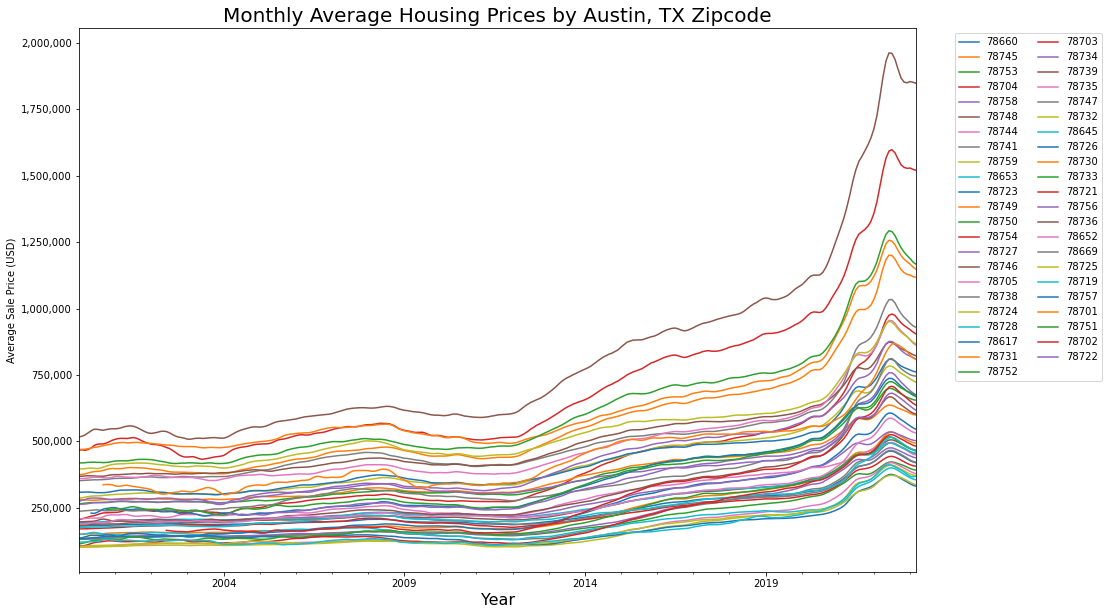

In [17]:
for zipcode in dfm.ZipCode.unique():
    temp_df = dfm[dfm.ZipCode == zipcode]
    ax = temp_df['MeanValue'].plot(figsize = (15,10), label=zipcode)

plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize = 16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Austin, TX Zipcode', fontsize = 20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1) + ''))

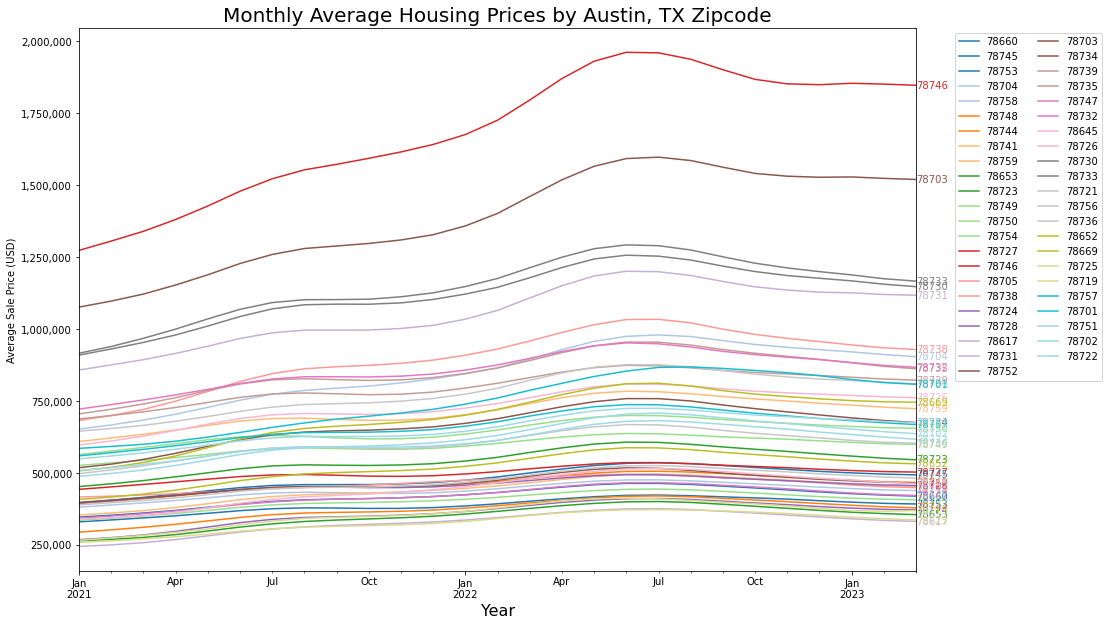

In [19]:
n_colors = len(dfm.ZipCode.unique())
cmap = plt.cm.get_cmap('tab20', n_colors)

# Iterate through each unique ZipCode value in the dataframe
for i, zipcode in enumerate(dfm.ZipCode.unique()):
    # Select data only for the current ZipCode value
    temp_df = dfm[dfm.ZipCode == zipcode]
    ax = temp_df['2021':]['MeanValue'].plot(figsize = (15,10), label=zipcode,color=cmap(i))
        # Add ZipCode labels to the plot
    x_pos = temp_df.index[-1]
    y_pos = temp_df['MeanValue'].iloc[-1]
    plt.text(x_pos, y_pos, zipcode, ha='left', va='center', color=cmap(i))
# Add plot labels and formatting
plt.legend(bbox_to_anchor=(1.04,1), loc='upper left', ncol=2)
plt.xlabel("Year", fontsize=16)
plt.ylabel("Average Sale Price (USD)")
plt.title('Monthly Average Housing Prices by Austin, TX Zipcode', fontsize=20)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1) + ''))
plt.show()

# Seasonal Decomposition above 2014

In [21]:
df2014 = dfm['2014':]
month_avg = df2014.groupby('Month')['MeanValue'].mean()

In [22]:
month_avg.head()

Month
2014-01-31    319138.220242
2014-02-28    321797.462207
2014-03-31    324714.463502
2014-04-30    327994.756427
2014-05-31    331140.476209
Name: MeanValue, dtype: float64

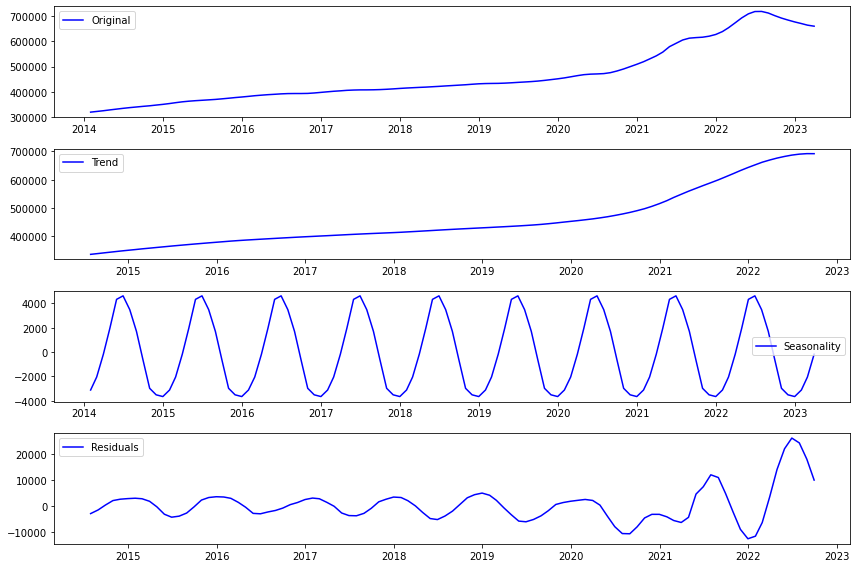

In [23]:
decomposition = sm.tsa.seasonal_decompose(month_avg, model='additive')

#Gather the trend, seasonality, and residuals
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(month_avg, label='Original', color='blue')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color='blue')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color='blue')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals', color='blue')
plt.legend(loc='best')
plt.tight_layout()

In [24]:
def stationarity_check(TS):
    
    # Import adfuller
    from statsmodels.tsa.stattools import adfuller
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [25]:
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

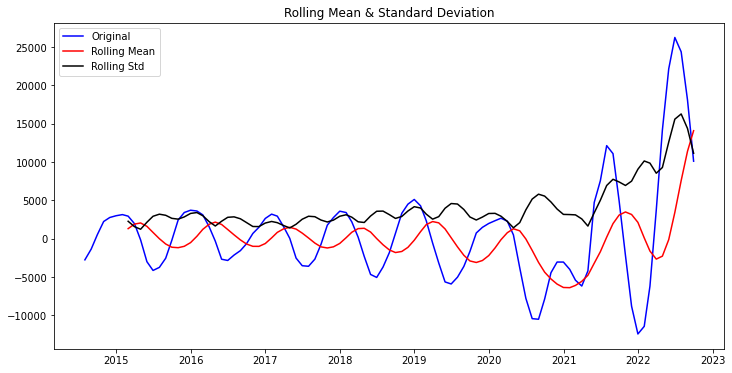

Results of Dickey-Fuller Test: 

Test Statistic                 -1.609556
p-value                         0.478792
#Lags Used                      4.000000
Number of Observations Used    94.000000
Critical Value (1%)            -3.501912
Critical Value (5%)            -2.892815
Critical Value (10%)           -2.583454
dtype: float64


In [26]:
stationarity_check(ts_log_decompose)

# Autocorrelation

<AxesSubplot:xlabel='Month'>

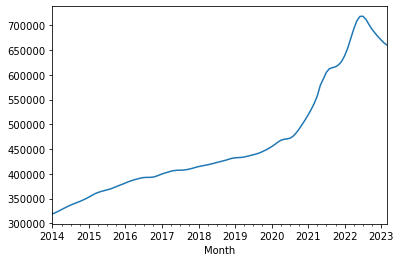

In [27]:
month_avg.plot()

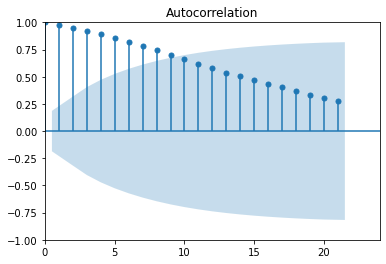

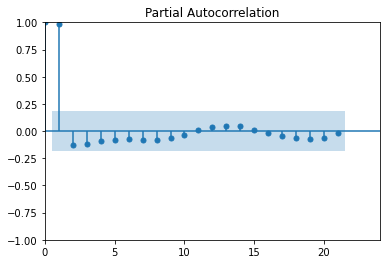

In [28]:
plot_acf(month_avg); plt.xlim(0,24); plt.show()
plot_pacf(month_avg); plt.xlim(0,24); plt.ylim(-1,1);plt.show()

# Initial SARIMA Models on Sample Zip Codes

In [31]:
dfm.ZipCode.unique()

array([78660, 78745, 78753, 78704, 78758, 78748, 78744, 78741, 78759,
       78653, 78723, 78749, 78750, 78754, 78727, 78746, 78705, 78738,
       78724, 78728, 78617, 78731, 78752, 78703, 78734, 78739, 78735,
       78747, 78732, 78645, 78726, 78730, 78733, 78721, 78756, 78736,
       78652, 78669, 78725, 78719, 78757, 78701, 78751, 78702, 78722])

In [32]:
#Select 3 zipcodes
zip_dfs = []
zip_list = np.array([78747,78652,78724])
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['ZipCode']==x][['MeanValue']].copy()))

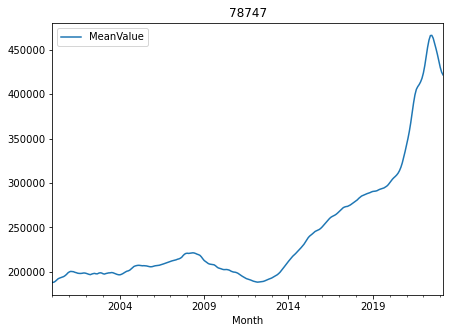

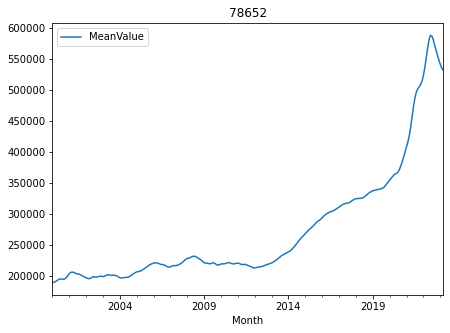

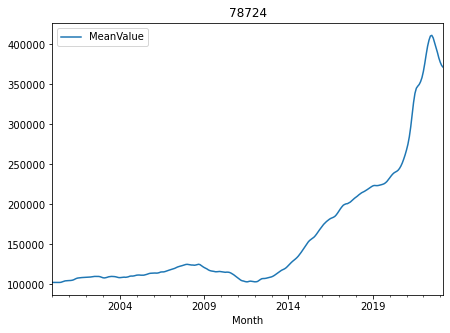

In [33]:
for df, name in zip(zip_dfs, zip_list):
    df.plot()
    plt.title(name)
    plt.show()

In [34]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [35]:
print(pdqs)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


In [36]:
#Run SARIMA
ans = []

for df, name in zip(zip_dfs, zip_list):
    for para1 in pdq:
        for para2 in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order = para1,
                                                seasonal_order = para2,
                                                enforce_stationarity = False,
                                                enforce_invertibility = False)
                output = mod.fit()
                ans.append([name, para1, para2, output.aic])
                print('Result for {}'.format(name) + ' ARIMA {} x {}12 : AIC Calculated = {}'.format(para1, para2, output.aic))
            except:
                continue

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38109D+01    |proj g|=  6.21726D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.217D-09   1.381D+01
  F =   13.810917886439466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (0, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 7708.492180633222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =      

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.07641D+01    |proj g|=  4.96421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     28      1     0     0   3.476D-06   1.076D+01
  F =   10.764147229998192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6012.394154338991
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02716D+01    |proj g|=  6.44675D-06

           * * *

Tit   = total number of i

 This problem is unconstrained.



At iterate   10    f=  1.90771D+01    |proj g|=  7.44457D-02

At iterate   15    f=  1.57842D+01    |proj g|=  2.93485D-03

At iterate   20    f=  1.56555D+01    |proj g|=  1.05539D-04

At iterate   25    f=  1.53611D+01    |proj g|=  1.20604D-03

At iterate   30    f=  1.23531D+01    |proj g|=  6.41418D-02

At iterate   35    f=  1.02325D+01    |proj g|=  1.24923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     73      1     0     0   6.501D-07   1.023D+01
  F =   10.232451291782512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-7.057E+00  -gs= 8.558E-01 BFGS update SKIPPED

At iterate   10    f=  1.27340D+01    |proj g|=  3.44514D-02

At iterate   15    f=  1.27336D+01    |proj g|=  1.35455D-02

At iterate   20    f=  1.27334D+01    |proj g|=  1.54586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     75      1     2     0   1.546D-05   1.273D+01
  F =   12.733427078707820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7111.252309918963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06295D+01    |proj g|=  1.53037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     13      1     0     0   2.522D-05   1.063D+01
  F =   10.629453574844280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (0, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5935.2350947631085
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29437D+02    |proj g|=  1.34693D+01
  ys=-3.388E+01  -gs= 5.306E+01 BFGS update

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.20076D+02    |proj g|=  7.98835D-01

At iterate   10    f=  5.20023D+02    |proj g|=  1.34075D+01
  ys=-6.462E-01  -gs= 3.059E+00 BFGS update SKIPPED

At iterate   15    f=  1.51719D+01    |proj g|=  2.16978D+01

At iterate   20    f=  1.35388D+01    |proj g|=  8.43545D-01

At iterate   25    f=  1.34849D+01    |proj g|=  3.74906D-02

At iterate   30    f=  1.34843D+01    |proj g|=  7.33769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     58      1     1     0   1.030D-05   1.348D+01
  F =   13.484324916509715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     37      1     1     0   1.951D-04   1.014D+01
  F =   10.137850498956565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5662.920578417763
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69625D+02    |proj g|=  4.38498D+01

At iterate    5    f=  5.40732D+01    |proj g|=  6.59043D+00

At iterate   10    f=  1.74919D+01    |proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.68196D+00    |proj g|=  6.32785D-03

At iterate   10    f=  8.68193D+00    |proj g|=  2.99216D-03

At iterate   15    f=  8.68088D+00    |proj g|=  4.15216D-02

At iterate   20    f=  8.65738D+00    |proj g|=  9.43051D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     28      1     0     0   4.607D-05   8.657D+00
  F =   8.6568128936700326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4834.501594667878
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  8.44074D+00    |proj g|=  5.28324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   3.373D-05   8.441D+00
  F =   8.4407393713943719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4713.93256923806
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75349D+00    |proj g|=  4.16378D-06

           * * *

Tit   = total number of ite

 This problem is unconstrained.
 This problem is unconstrained.


Result for 78747 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4715.383496553337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27289D+00    |proj g|=  4.83872D-01

At iterate    5    f=  8.76051D+00    |proj g|=  1.57932D-03

At iterate   10    f=  8.76050D+00    |proj g|=  2.23472D-03

At iterate   15    f=  8.76039D+00    |proj g|=  3.45188D-02

At iterate   20    f=  8.72026D+00    |proj g|=  2.03964D+00

At iterate   25    f=  8.55030D+00    |proj g|=  2.33643D-01

At iterate   30    f=  8.54899D+00    |proj g|=  1.34381D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradie

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.35206D+00    |proj g|=  2.09395D-03

At iterate   15    f=  8.35205D+00    |proj g|=  1.79340D-03

At iterate   20    f=  8.35177D+00    |proj g|=  2.28079D-02

At iterate   25    f=  8.33257D+00    |proj g|=  1.58006D-01

At iterate   30    f=  8.15241D+00    |proj g|=  5.57991D-01

At iterate   35    f=  8.08154D+00    |proj g|=  1.40346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     52      1     0     0   3.313D-07   8.081D+00
  F =   8.0814377492396900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.91362D+00    |proj g|=  2.54277D-04

At iterate   10    f=  8.91361D+00    |proj g|=  7.36574D-03

At iterate   15    f=  8.91201D+00    |proj g|=  9.48189D-02

At iterate   20    f=  8.75630D+00    |proj g|=  1.28548D+00

At iterate   25    f=  8.52192D+00    |proj g|=  7.67643D-02

At iterate   30    f=  8.51791D+00    |proj g|=  9.45022D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     34      1     0     0   9.450D-08   8.518D+00
  F =   8.5179067521942962     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (0, 1, 1) x (0, 1, 0, 12)12 

 This problem is unconstrained.


At iterate   20    f=  8.44666D+00    |proj g|=  4.97955D-02

At iterate   25    f=  8.43406D+00    |proj g|=  1.95562D-01

At iterate   30    f=  8.27637D+00    |proj g|=  9.66943D-01

At iterate   35    f=  8.24890D+00    |proj g|=  8.84404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     50      1     0     0   4.189D-07   8.249D+00
  F =   8.2488928124263960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4608.882189333929
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate   10    f=  8.36046D+00    |proj g|=  1.70238D-01

At iterate   15    f=  8.35192D+00    |proj g|=  1.17548D-02

At iterate   20    f=  8.35189D+00    |proj g|=  7.53134D-04

At iterate   25    f=  8.35185D+00    |proj g|=  1.40774D-02

At iterate   30    f=  8.34566D+00    |proj g|=  1.50680D-01

At iterate   35    f=  8.21850D+00    |proj g|=  3.58496D-01

At iterate   40    f=  8.08145D+00    |proj g|=  2.56618D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     58      1     0     0   1.311D-05   8.081D+00
  F =   8.0814167610434904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


Result for 78747 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4531.328111187035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59972D+00    |proj g|=  1.43565D+00

At iterate    5    f=  8.11965D+00    |proj g|=  1.14021D+00


 This problem is unconstrained.



At iterate   10    f=  8.03879D+00    |proj g|=  7.67245D-02

At iterate   15    f=  8.03554D+00    |proj g|=  4.53480D-02

At iterate   20    f=  8.03550D+00    |proj g|=  2.41444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   2.414D-04   8.036D+00
  F =   8.0355018060814274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4491.810007793437
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     20      1     0     0   5.984D-02   9.127D+00
  F =   9.1269950727863165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 0, 0) x (0, 0, 0, 12)12 : AIC Calculated = 5096.863250614765
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18122D+01    |proj g|=  1.66812D+00

At iterate    5    f=  9.95219D+00    |proj g|=  5.63917D+01

At iterate   10    f=  8.67424D+00    |proj

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   3.999D-04   8.862D+00
  F =   8.8615350779722810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4948.736573508533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15168D+01    |proj g|=  1.42518D+00

At iterate    5    f=  1.14839D+01    |proj g|=  5.87333D-01

At iterate   10    f=  1.12791D+01    |proj

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.97713D+00    |proj g|=  5.22689D+01

At iterate   20    f=  8.67741D+00    |proj g|=  3.98112D+00

At iterate   25    f=  8.67421D+00    |proj g|=  9.67422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     41      1     0     0   9.674D-05   8.674D+00
  F =   8.6742109325557184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4848.209700366091
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.47356D+00    |proj g|=  1.37434D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   8.801D-06   8.473D+00
  F =   8.4733512789519878     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4734.130013655209
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38625D+01    |proj g|=  2.17280D+00

At iterate    5    f=  1.06476D+01    |proj

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  1.13928D+01    |proj g|=  3.45126D+01

At iterate   25    f=  9.45565D+00    |proj g|=  4.03555D+01

At iterate   30    f=  8.62824D+00    |proj g|=  3.43700D+01

At iterate   35    f=  8.58618D+00    |proj g|=  4.93803D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38    109      2     0     0   9.378D-03   8.586D+00
  F =   8.5858942618376872     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for 78747 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4798.92899810543
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


Result for 78747 ARIMA (1, 0, 1) x (0, 1, 0, 12)12 : AIC Calculated = 5117.027035977805
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41707D+01    |proj g|=  8.95388D+00

At iterate    5    f=  1.17698D+01    |proj g|=  7.25672D+00

At iterate   10    f=  1.09195D+01    |proj g|=  2.74829D-01

At iterate   15    f=  1.09085D+01    |proj g|=  6.76302D-02

At iterate   20    f=  1.08901D+01    |proj g|=  7.59198D-04

At iterate   25    f=  1.08900D+01    |proj g|=  6.30823D-03

At iterate   30    f=  1.08855D+01    |proj g|=  2.56374D-01

At iterate   35    f=  1.06712D+01    |proj g|=  1.46799D+00

At iterate   40    f=  8.54843D+00    |proj g|=  1.04260D+00

At iterate   45    f=  7.95178D+00    |proj g|=  1.13721D+00

At iterate   50    f=  7.91099D+00    |proj g|=  9.47653D-03

           * * *

Tit   = total number of iterations
Tnf   = t

 This problem is unconstrained.



At iterate   35    f=  8.27965D+00    |proj g|=  9.05497D+00

At iterate   40    f=  8.18009D+00    |proj g|=  1.64234D-01

At iterate   45    f=  8.17926D+00    |proj g|=  1.76047D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     60      1     0     0   1.667D-02   8.179D+00
  F =   8.1792542003603099     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4572.023843801053
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate   15    f=  1.06031D+01    |proj g|=  8.52842D+00

At iterate   20    f=  1.05119D+01    |proj g|=  1.50546D-01

At iterate   25    f=  1.04977D+01    |proj g|=  2.55054D+00

At iterate   30    f=  8.93958D+00    |proj g|=  5.58376D+00

At iterate   35    f=  8.59463D+00    |proj g|=  1.48792D+01

At iterate   40    f=  8.44574D+00    |proj g|=  1.54129D+01

At iterate   45    f=  8.39771D+00    |proj g|=  1.38300D+00

At iterate   50    f=  8.34905D+00    |proj g|=  3.32965D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   3.330D+00   8.349D+00
  F =   8.34905432575

 This problem is unconstrained.



At iterate   10    f=  8.09613D+00    |proj g|=  2.25127D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   2.347D-04   8.096D+00
  F =   8.0961336806370525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4525.6425937954755
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18524D+01    |proj g|=  1.76686D+01

At iterate    5    f=  1.04318D+01    |pro

 This problem is unconstrained.



At iterate   10    f=  1.00431D+01    |proj g|=  1.91944D-01

At iterate   15    f=  9.90884D+00    |proj g|=  5.30554D+00

At iterate   20    f=  9.75608D+00    |proj g|=  3.06946D-01

At iterate   25    f=  9.19834D+00    |proj g|=  1.85962D+00

At iterate   30    f=  8.72039D+00    |proj g|=  3.54200D+00

At iterate   35    f=  8.23280D+00    |proj g|=  1.75909D+00

At iterate   40    f=  8.10372D+00    |proj g|=  4.78131D-01

At iterate   45    f=  8.05982D+00    |proj g|=  9.98190D-02

At iterate   50    f=  8.05726D+00    |proj g|=  2.75144D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     81   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.41634D+00    |proj g|=  2.10495D-02

At iterate   15    f=  7.57948D+00    |proj g|=  1.83052D-01

At iterate   20    f=  7.57627D+00    |proj g|=  2.42569D-02

At iterate   25    f=  7.57502D+00    |proj g|=  1.61770D-02

At iterate   30    f=  7.57501D+00    |proj g|=  1.08594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     45      1     0     0   1.086D-04   7.575D+00
  F =   7.5750053659190897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4232.852994182852
RUNNING THE L-BFGS-B CODE

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


Result for 78747 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4284.567968589119
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13207D+00    |proj g|=  4.42926D+00

At iterate    5    f=  7.30878D+00    |proj g|=  1.25164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   5.669D-05   7.309D+00
  F =   7.3087551875570727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 0) x (0, 1, 1,

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.24761D+00    |proj g|=  1.11415D+00

At iterate   10    f=  7.57149D+00    |proj g|=  1.01514D-01

At iterate   15    f=  7.56881D+00    |proj g|=  8.65774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   8.660D-05   7.569D+00
  F =   7.5688127534873617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4231.397516445948
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.71633D+00    |proj g|=  3.04771D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.207D-04   7.716D+00
  F =   7.7163309370703086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4311.712662885232
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11847D+00    |proj g|=  2.01859D+00

At iterate    5    f=  7.67601D+00    |proj

 This problem is unconstrained.



At iterate   25    f=  7.34624D+00    |proj g|=  8.54999D-02

At iterate   30    f=  7.31791D+00    |proj g|=  1.47372D-02

At iterate   35    f=  7.31482D+00    |proj g|=  3.97729D-03

At iterate   40    f=  7.31469D+00    |proj g|=  9.78009D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     51      1     0     0   9.780D-06   7.315D+00
  F =   7.3146855969293281     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78747 ARIMA (1, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4089.594563086565
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11649D+00    |proj g|=  3.71115D+00

At iterate    5    f=  7.08485D+00    |proj g|=  7.67767D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   1.564D-04   7.083D+00
  F =   7.0830750115583436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3960.3558564495556
RUNNING THE L-BFGS-B CODE

           * * *

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.36115D+00    |proj g|=  5.40876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.113D-04   7.361D+00
  F =   7.3611459595816848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4115.51944544658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70118D+00    |proj g|=  2.35846D+00

At iterate    5    f=  7.67905D+00    |proj 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.09820D+00    |proj g|=  2.24884D-01

At iterate   10    f=  7.07202D+00    |proj g|=  2.13197D-02

At iterate   15    f=  7.07187D+00    |proj g|=  1.97988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.980D-04   7.072D+00
  F =   7.0718673814933632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3956.101998873297
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.80800D+01    |proj g|=  1.43553D-02

At iterate   15    f=  1.67701D+01    |proj g|=  3.88817D-04

At iterate   20    f=  1.67460D+01    |proj g|=  1.72956D-04

At iterate   25    f=  1.07904D+01    |proj g|=  6.80104D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     47      1     0     0   3.542D-06   1.078D+01
  F =   10.784236062178547     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (0, 0, 0) x (0, 1, 1, 12)12 : AIC Calculated = 6021.603722695629
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05499D+01    |proj g|=  6.24745D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.247D-06   1.055D+01
  F =   10.549949381638498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (0, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 5890.871754954282
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =      

 This problem is unconstrained.



At iterate   15    f=  1.40984D+01    |proj g|=  1.65167D+00

At iterate   20    f=  1.36381D+01    |proj g|=  3.47542D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     37      1     0     0   9.149D-06   1.364D+01
  F =   13.637867148688629     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (0, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 7615.9298689682555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.72999D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.28680D+01    |proj g|=  1.01375D-01

At iterate   10    f=  1.28607D+01    |proj g|=  2.17565D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     38      1     0     0   3.205D-06   1.286D+01
  F =   12.860656378192724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 7182.24625903154
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16459D+01    |proj 

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.575E+02  -gs= 4.413E+01 BFGS update SKIPPED

At iterate    5    f=  4.98789D+01    |proj g|=  4.19755D+00

At iterate   10    f=  4.82145D+01    |proj g|=  8.98188D+01

At iterate   15    f=  2.72000D+01    |proj g|=  4.71065D+01

At iterate   20    f=  1.67130D+01    |proj g|=  5.75411D+00

At iterate   25    f=  1.54616D+01    |proj g|=  8.52586D-01

At iterate   30    f=  1.54319D+01    |proj g|=  5.39463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     45      2     1     0   5.405D-05   1.543D+01
  F =   15.431939757426205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.28702D+01    |proj g|=  3.11175D-01

At iterate   10    f=  1.28269D+01    |proj g|=  4.21136D-02

At iterate   15    f=  1.28212D+01    |proj g|=  3.80681D-03

At iterate   20    f=  1.28211D+01    |proj g|=  1.77138D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   6.846D-06   1.282D+01
  F =   12.821142782467248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (0, 0, 1) x (1, 0, 1, 12)12 : AIC Calculated = 7162.197672616725
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.04240D+01    |proj g|=  1.67875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     22      1     0     0   2.327D-05   1.042D+01
  F =   10.423335179841672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 5822.221030351653
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83110D+02    |proj g|=  4.58401D+01

At iterate    5    f=  1.88636D+01    |proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Result for 78652 ARIMA (0, 1, 0) x (0, 1, 1, 12)12 : AIC Calculated = 4875.415210646415
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07254D+00    |proj g|=  4.14939D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.149D-06   9.073D+00
  F =   9.0725429689592900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (0, 1, 0) x (1, 0, 0, 12)12 : AIC Calculated = 5066.478976679284
RUNNING THE L-BFGS

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13513D+01    |proj g|=  1.83006D+01

At iterate    5    f=  8.79237D+00    |proj g|=  2.19012D-01

At iterate   10    f=  8.72611D+00    |proj g|=  2.28722D-02

At iterate   15    f=  8.72560D+00    |proj g|=  1.57398D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     16      1     0     0   1.574D-05   8.726D+00
  F =   8.7255990171160747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

 This problem is unconstrained.
 This problem is unconstrained.


Result for 78652 ARIMA (0, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 5073.752496638098
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76495D+00    |proj g|=  5.10833D-01

At iterate    5    f=  8.66576D+00    |proj g|=  5.94008D-02

At iterate   10    f=  8.66474D+00    |proj g|=  2.64763D-04

At iterate   15    f=  8.66459D+00    |proj g|=  1.24997D-02

At iterate   20    f=  8.64883D+00    |proj g|=  1.31879D-01

At iterate   25    f=  8.45311D+00    |proj g|=  7.41944D-02


 This problem is unconstrained.



At iterate   30    f=  8.44627D+00    |proj g|=  4.03517D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     42      1     0     0   2.285D-05   8.446D+00
  F =   8.4462736796926450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4719.0207132684955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17407D+00    |proj g|=  1.87975D-01

           * * *

Tit   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36116D+00    |proj g|=  8.27893D-02

At iterate   10    f=  8.35584D+00    |proj g|=  1.52190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   1.522D-04   8.356D+00
  F =   8.3558351512874953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4668.556014418422
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22342D+00    |proj

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.69613D+00    |proj g|=  3.93703D-01

At iterate   10    f=  8.66470D+00    |proj g|=  3.23285D-03

At iterate   15    f=  8.66469D+00    |proj g|=  1.99791D-04

At iterate   20    f=  8.66467D+00    |proj g|=  5.22997D-03

At iterate   25    f=  8.66276D+00    |proj g|=  9.41393D-02

At iterate   30    f=  8.55748D+00    |proj g|=  3.99724D-01

At iterate   35    f=  8.45234D+00    |proj g|=  1.80203D-01

At iterate   40    f=  8.44609D+00    |proj g|=  1.21006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     49      1     0     0   1.025D-05   8.446D+00
  F =   8.44608861636

 This problem is unconstrained.



At iterate   10    f=  8.42152D+00    |proj g|=  1.97177D-04

At iterate   15    f=  8.42152D+00    |proj g|=  4.78342D-03

At iterate   20    f=  8.42128D+00    |proj g|=  7.49251D-02

At iterate   25    f=  8.39744D+00    |proj g|=  2.19050D-01

At iterate   30    f=  8.30875D+00    |proj g|=  5.37664D-02

At iterate   35    f=  8.30329D+00    |proj g|=  1.45628D-01

At iterate   40    f=  8.30147D+00    |proj g|=  2.42261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     62      1     0     0   2.423D-05   8.301D+00
  F =   8.3014731859682538     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  8.40159D+00    |proj g|=  3.01878D-01

At iterate   15    f=  8.35152D+00    |proj g|=  1.62697D-01

At iterate   20    f=  8.34584D+00    |proj g|=  6.81321D-02

At iterate   25    f=  8.34427D+00    |proj g|=  1.21434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   1.629D-04   8.344D+00
  F =   8.3442710617918259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (0, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4664.103252479839
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.23768D+00    |proj g|=  3.65739D+01

At iterate   10    f=  9.01932D+00    |proj g|=  4.44493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     75      2     0     0   1.048D-04   9.019D+00
  F =   9.0193205276096116     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for 78652 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 5038.780854406164
RUNNING THE L-BFGS-B CODE

           * * *




 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18653D+00    |proj g|=  3.79921D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.799D-04   9.187D+00
  F =   9.1865322718238982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 0, 0) x (0, 1, 0, 12)12 : AIC Calculated = 5130.085007677735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactl

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.08648D+01    |proj g|=  4.88995D+00

At iterate   15    f=  9.34279D+00    |proj g|=  2.42491D+01

At iterate   20    f=  9.10799D+00    |proj g|=  5.16809D-01

At iterate   25    f=  9.10686D+00    |proj g|=  2.40859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     45      1     0     0   2.409D-04   9.107D+00
  F =   9.1068594054384153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5089.6275482346355


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02108D+00    |proj g|=  1.24751D+00

At iterate    5    f=  8.76002D+00    |proj g|=  1.15011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     12      1     0     0   2.672D-05   8.760D+00
  F =   8.7600236800194438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 0, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4894.093213450849
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     31      1     0     0   1.953D-04   8.948D+00
  F =   8.9480665302402471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 0, 1) x (0, 0, 0, 12)12 : AIC Calculated = 4999.021123874058
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22136D+01    |proj g|=  2.64058D+00

At iterate    5    f=  1.17546D+01    |proj g|=  6.51711D-02

At iterate   10    f=  1.17538D+01    |proj


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.22732D+01    |proj g|=  6.28093D+00

At iterate   10    f=  1.17439D+01    |proj g|=  1.06964D-01

At iterate   15    f=  1.17054D+01    |proj g|=  8.69392D-01

At iterate   20    f=  1.14326D+01    |proj g|=  5.03486D-03

At iterate   25    f=  1.14316D+01    |proj g|=  1.40867D-03

At iterate   30    f=  1.14316D+01    |proj g|=  6.55312D-03

At iterate   35    f=  1.14285D+01    |proj g|=  8.72195D-02

At iterate   40    f=  9.50416D+00    |proj g|=  1.27193D+01
  ys=-1.936E+02  -gs= 7.753E-01 BFGS update SKIPPED

At iterate   45    f=  8.49644D+00    |proj g|=  9.01186D-02

At iterate   50    f=  8.25341D+00    |proj g|=  2.42850D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final f

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10823D+01    |proj g|=  5.66775D-01

At iterate   10    f=  1.10040D+01    |proj g|=  1.35720D+01

At iterate   15    f=  1.06495D+01    |proj g|=  1.55217D+00

At iterate   20    f=  1.06369D+01    |proj g|=  2.78109D-01

At iterate   25    f=  1.06153D+01    |proj g|=  9.13391D-01

At iterate   30    f=  1.05646D+01    |proj g|=  7.74069D+00
  ys=-4.998E+00  -gs= 4.583E-01 BFGS update SKIPPED

At iterate   35    f=  9.52307D+00    |proj g|=  2.04195D+01

At iterate   40    f=  8.59828D+00    |proj g|=  6.50503D+00

At iterate   45    f=  8.55366D+00    |proj g|=  4.29092D-02

At iterate   50    f=  8.55361D+00    |proj g|=  1.92900D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate    5    f=  8.42750D+00    |proj g|=  7.84307D-01

At iterate   10    f=  8.40650D+00    |proj g|=  2.36124D-01

At iterate   15    f=  8.40298D+00    |proj g|=  4.36530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     27      1     0     0   1.515D-04   8.403D+00
  F =   8.4029838577011571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4696.864992597246
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83597D+01    |proj g|=  2.55748D+01

At iterate    5    f=  1.06624D+01    |proj g|=  3.48086D+00

At iterate   10    f=  1.03033D+01    |proj g|=  8.15140D-02

At iterate   15    f=  1.02604D+01    |proj g|=  3.10550D+00

At iterate   20    f=  1.02112D+01    |proj g|=  2.43914D-01

At iterate   25    f=  9.94765D+00    |proj g|=  5.06137D+00

At iterate   30    f=  9.58605D+00    |proj g|=  1.90581D+00

At iterate   35    f=  8.76293D+00    |proj g|=  3.64398D+00

At iterate   40    f=  8.36912D+00    |proj g|=  3.10214D-01

At iterate   45    f=  8.36344D+00    |proj g|=  1.60599D-01

At iterate   50    f=  8.36222D+00    |proj g|=  1.03730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates s

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   15    f=  8.96932D+00    |proj g|=  6.95219D-02

At iterate   20    f=  8.01862D+00    |proj g|=  3.18441D-03

At iterate   25    f=  8.01861D+00    |proj g|=  2.16219D-03

At iterate   30    f=  8.01859D+00    |proj g|=  2.74990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     48      1     0     0   1.164D-07   8.019D+00
  F =   8.0185922996201775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78652 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4480.374503188059
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


Result for 78652 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4559.812500291471
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18895D+01    |proj g|=  1.82532D+01

At iterate    5    f=  7.76825D+00    |proj g|=  6.77843D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      8      1     0     0   4.948D-05   7.768D+00
  F =   7.7682543637365189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 1, 0) x (0, 1, 1,

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.10359D+00    |proj g|=  1.84907D+00

At iterate   10    f=  8.97186D+00    |proj g|=  1.34853D-01

At iterate   15    f=  8.96897D+00    |proj g|=  2.88164D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   2.882D-04   8.969D+00
  F =   8.9689699664592570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 5012.685241284265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.



At iterate   10    f=  8.06467D+00    |proj g|=  6.43803D-04

At iterate   15    f=  8.06465D+00    |proj g|=  7.77231D-03

At iterate   20    f=  8.06247D+00    |proj g|=  2.30074D-01

At iterate   25    f=  7.90980D+00    |proj g|=  1.24712D+00

At iterate   30    f=  7.78736D+00    |proj g|=  4.94459D-02

At iterate   35    f=  7.77645D+00    |proj g|=  4.56895D-02

At iterate   40    f=  7.76037D+00    |proj g|=  1.02314D-01

At iterate   45    f=  7.74609D+00    |proj g|=  3.24393D-02

At iterate   50    f=  7.73720D+00    |proj g|=  2.06547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     64   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88836D+00    |proj g|=  1.40924D+00

At iterate    5    f=  8.45995D+00    |proj g|=  1.55829D-01

At iterate   10    f=  8.45233D+00    |proj g|=  1.27697D-02

At iterate   15    f=  8.45229D+00    |proj g|=  1.31252D-03

At iterate   20    f=  8.45215D+00    |proj g|=  2.27767D-02

At iterate   25    f=  8.17859D+00    |proj g|=  3.47953D-01

At iterate   30    f=  7.84802D+00    |proj g|=  1.21133D-01

At iterate   35    f=  7.79452D+00    |proj g|=  2.09485D-02

At iterate   40    f=  7.78772D+00    |proj g|=  4.21309D-03

At iterate   45    f=  7.78714D+00    |proj g|=  1.66756D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.04007D+00    |proj g|=  1.11079D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.173D-04   8.039D+00
  F =   8.0386468854651412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 1, 1) x (0, 1, 0, 12)12 : AIC Calculated = 4491.564962089548
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07903D+01    |proj g|=  1.50188D+01

At iterate    5    f=  7.55991D+00    |proj

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.42095D+00    |proj g|=  1.61641D-03

At iterate   20    f=  8.42094D+00    |proj g|=  7.51227D-03

At iterate   25    f=  8.42008D+00    |proj g|=  1.15079D-01

At iterate   30    f=  7.89937D+00    |proj g|=  3.81471D-01

At iterate   35    f=  7.79514D+00    |proj g|=  4.67437D-02

At iterate   40    f=  7.78457D+00    |proj g|=  2.27532D-02

At iterate   45    f=  7.78162D+00    |proj g|=  4.32486D-03

At iterate   50    f=  7.78092D+00    |proj g|=  9.89416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   9.894D-04   7.781D+00
  F =   7.78092148769

 This problem is unconstrained.



At iterate    5    f=  7.61442D+00    |proj g|=  6.28336D-02

At iterate   10    f=  7.61208D+00    |proj g|=  7.02344D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.023D-05   7.612D+00
  F =   7.6120815355179943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4255.541496819041
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06035D+01    |proj

 This problem is unconstrained.



At iterate    5    f=  7.82578D+00    |proj g|=  1.07936D-01

At iterate   10    f=  7.81865D+00    |proj g|=  1.16970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.485D-04   7.819D+00
  F =   7.8186524051563513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78652 ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4372.808042077244
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34674D+01    |proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33442D+02    |proj g|=  3.55806D-01

At iterate    5    f=  1.27080D+01    |proj g|=  3.51765D-01

At iterate   10    f=  1.25921D+01    |proj g|=  1.34627D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     24      1     0     0   1.346D-05   1.259D+01
  F =   12.592140253931774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.07608D+01    |proj g|=  5.91172D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     28      1     0     0   5.912D-07   1.076D+01
  F =   10.760840039592148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (0, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 6010.548742092418
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03667D+01    |proj g|=  6.19718D-06

           * * *

Tit   = total number of i

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.52505D+01    |proj g|=  2.00058D-04

At iterate   20    f=  1.52454D+01    |proj g|=  1.41622D-04

At iterate   25    f=  1.45748D+01    |proj g|=  3.88334D-02

At iterate   30    f=  1.33424D+01    |proj g|=  9.17767D-01

At iterate   35    f=  1.06932D+01    |proj g|=  1.03699D-01

At iterate   40    f=  1.03740D+01    |proj g|=  5.54794D-03

At iterate   45    f=  1.03350D+01    |proj g|=  1.43148D-02

At iterate   50    f=  1.03292D+01    |proj g|=  3.66295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     84      1     0     0   3.663D-03   1.033D+01
  F =   10.3292214569

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46458D+01    |proj g|=  8.60599D-02

At iterate   10    f=  1.43207D+01    |proj g|=  6.04459D+00

At iterate   15    f=  1.33772D+01    |proj g|=  1.24400D+01

At iterate   20    f=  1.30364D+01    |proj g|=  1.00508D+00

At iterate   25    f=  1.30063D+01    |proj g|=  3.16313D-02

At iterate   30    f=  1.30056D+01    |proj g|=  1.43827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     89      1     0     0   6.758D-06   1.301D+01
  F =   13.005644164142309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (0, 0, 1) x (0, 0, 1, 12)12 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.78254D+01    |proj g|=  9.29177D-01

At iterate   10    f=  1.71912D+01    |proj g|=  3.21707D+01

At iterate   15    f=  1.46130D+01    |proj g|=  1.64229D+00

At iterate   20    f=  1.45064D+01    |proj g|=  1.49634D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     36      1     0     0   6.543D-05   1.451D+01
  F =   14.506350093872427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 0, 1) x (0, 1, 1, 12)12 : AIC Calculated = 8100.543352380814
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.24620D+01    |proj g|=  1.31320D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   5.293D-06   1.246D+01
  F =   12.461700444589232     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (0, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 6959.628848080792
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.26949D+02    |proj g|=  2.67066D+01

At iterate    5    f=  2.16695D+02    |proj

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10271D+01    |proj g|=  9.84889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.629D-05   1.103D+01
  F =   11.027117662566932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 0, 1) x (1, 1, 0, 12)12 : AIC Calculated = 6159.131655712348
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08040D+02    |proj g|=  1.01530D+01

At iterate    5    f=  1.90131D+01    |proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Result for 78724 ARIMA (0, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4894.081951739577
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91564D+00    |proj g|=  1.78469D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   7.374D-07   8.915D+00
  F =   8.9150059568211333     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (0, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4976.573323906192
RUNNING THE L-BFGS

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70311D+00    |proj g|=  2.93120D+00

At iterate    5    f=  8.77764D+00    |proj g|=  2.36844D-01

At iterate   10    f=  8.76474D+00    |proj g|=  2.60213D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   3.662D-05   8.765D+00
  F =   8.7647281660204097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.54240D+00    |proj g|=  2.01319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   5.074D-05   8.542D+00
  F =   8.5423907529270711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 1, 0) x (1, 1, 1, 12)12 : AIC Calculated = 4772.654040133306
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39584D+00    |proj g|=  4.60797D-01

At iterate    5    f=  8.83411D+00    |proj

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  8.42383D+00    |proj g|=  2.95807D-03

At iterate   10    f=  8.42383D+00    |proj g|=  1.70493D-03

At iterate   15    f=  8.42377D+00    |proj g|=  2.27624D-02

At iterate   20    f=  8.41868D+00    |proj g|=  1.25401D-01

At iterate   25    f=  8.31248D+00    |proj g|=  4.76802D-01

At iterate   30    f=  8.15796D+00    |proj g|=  5.32461D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     44      1     0     0   6.693D-05   8.158D+00
  F =   8.1578578775335551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 1, 1) x (0, 0, 1, 12)12 :

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.11387D+00    |proj g|=  1.14109D-02

At iterate   10    f=  8.11362D+00    |proj g|=  2.69792D-04

At iterate   15    f=  8.11349D+00    |proj g|=  6.42673D-03

At iterate   20    f=  8.09655D+00    |proj g|=  1.38008D-01

At iterate   25    f=  7.92744D+00    |proj g|=  6.82148D-02

At iterate   30    f=  7.92146D+00    |proj g|=  7.11176D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     44      1     0     0   3.598D-05   7.921D+00
  F =   7.9214595880577860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 1, 1) x (0, 1, 1, 12)12 

 This problem is unconstrained.


At iterate   15    f=  8.51728D+00    |proj g|=  1.81774D-02

At iterate   20    f=  8.50850D+00    |proj g|=  2.23394D-01

At iterate   25    f=  8.33192D+00    |proj g|=  3.50461D-01

At iterate   30    f=  8.31410D+00    |proj g|=  2.77028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     48      1     0     0   2.770D-05   8.314D+00
  F =   8.3140953830214936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (0, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4645.265223725994
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         

 This problem is unconstrained.



At iterate   10    f=  8.42414D+00    |proj g|=  1.07204D-02

At iterate   15    f=  8.42383D+00    |proj g|=  2.68182D-04

At iterate   20    f=  8.42378D+00    |proj g|=  8.75496D-03

At iterate   25    f=  8.41633D+00    |proj g|=  1.03096D-01

At iterate   30    f=  8.33714D+00    |proj g|=  1.65572D-01

At iterate   35    f=  8.20619D+00    |proj g|=  3.14298D-01

At iterate   40    f=  8.15782D+00    |proj g|=  9.57533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     63      1     0     0   1.394D-04   8.158D+00
  F =   8.1577000514133875     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


Result for 78724 ARIMA (0, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4570.304095441522
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76752D+00    |proj g|=  5.79301D+00

At iterate    5    f=  8.23943D+00    |proj g|=  4.25372D-01

At iterate   10    f=  8.16293D+00    |proj g|=  1.05408D-01

At iterate   15    f=  8.12161D+00    |proj g|=  1.93079D-01

At iterate   20    f=  8.09151D+00    |proj g|=  3.46933D-02

At iterate   25    f=  8.09108D+00    |proj g|=  2.33634D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.31202D+00    |proj g|=  3.96106D+01

At iterate   10    f=  8.77037D+00    |proj g|=  5.33437D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     39      1     0     0   7.299D-06   8.770D+00
  F =   8.7703712948601993     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (1, 0, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4899.867182531992
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94574D+00    |proj

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.09522D+01    |proj g|=  1.46788D-01

At iterate   10    f=  1.08649D+01    |proj g|=  1.29765D-01

At iterate   15    f=  1.08611D+01    |proj g|=  5.55869D-03

At iterate   20    f=  1.08587D+01    |proj g|=  9.34986D-02

At iterate   25    f=  9.10678D+00    |proj g|=  5.65564D+00

At iterate   30    f=  8.59973D+00    |proj g|=  4.78708D-02

At iterate   35    f=  8.57766D+00    |proj g|=  1.98851D-02

At iterate   40    f=  8.57184D+00    |proj g|=  7.22809D-02

At iterate   45    f=  8.56898D+00    |proj g|=  6.16278D-02

At iterate   50    f=  8.56723D+00    |proj g|=  4.01187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  1.09465D+01    |proj g|=  1.98470D+00

At iterate   15    f=  1.04242D+01    |proj g|=  2.99923D+01

At iterate   20    f=  8.78618D+00    |proj g|=  4.48924D+00

At iterate   25    f=  8.77143D+00    |proj g|=  9.63293D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     90      2     0     0   1.386D-03   8.769D+00
  F =   8.7689864368734902     

ABNORMAL_TERMINATION_IN_LNSRCH                              
Result for 78724 ARIMA (1, 0, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4901.094431775407
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80756D+00    |proj g|=  1.36566D+00

At iterate    5    f=  8.52736D+00    |proj g|=  2.72050D-03

           * * *

Tit   = total number of i

 This problem is unconstrained.



At iterate   10    f=  1.02850D+01    |proj g|=  5.05552D+00

At iterate   15    f=  9.95876D+00    |proj g|=  6.94463D-01

At iterate   20    f=  9.93140D+00    |proj g|=  2.09686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   4.622D-04   9.931D+00
  F =   9.9313983305820042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 0, 0) x (1, 1, 1, 12)12 : AIC Calculated = 5549.720268464758
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.09129D+01    |proj g|=  3.22061D+01

At iterate   25    f=  8.82280D+00    |proj g|=  6.29726D+00

At iterate   30    f=  8.30318D+00    |proj g|=  3.53111D+00

At iterate   35    f=  8.28789D+00    |proj g|=  6.37493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     70      1     0     0   2.715D-04   8.288D+00
  F =   8.2878836019908704     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 0, 1) x (0, 0, 1, 12)12 : AIC Calculated = 4632.639049910906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.06808D+01    |proj g|=  6.11581D-02

At iterate   15    f=  1.05304D+01    |proj g|=  3.48650D-01

At iterate   20    f=  1.04398D+01    |proj g|=  8.31578D-03

At iterate   25    f=  1.04397D+01    |proj g|=  1.86614D-02

At iterate   30    f=  1.04335D+01    |proj g|=  2.79459D-01

At iterate   35    f=  9.88601D+00    |proj g|=  6.24805D+00

At iterate   40    f=  8.47363D+00    |proj g|=  2.71063D+00

At iterate   45    f=  8.04188D+00    |proj g|=  4.56899D-01

At iterate   50    f=  7.98438D+00    |proj g|=  1.34023D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     65   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.33208D+00    |proj g|=  2.59662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   2.597D-04   8.332D+00
  F =   8.3320792013457652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 0, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4657.300194350937
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29510D+01    |proj g|=  4.08614D+01

At iterate    5    f=  1.11873D+01    |proj

 This problem is unconstrained.



At iterate   10    f=  8.15769D+00    |proj g|=  5.99395D-02

At iterate   15    f=  8.15691D+00    |proj g|=  2.16955D-04

At iterate   20    f=  8.15691D+00    |proj g|=  9.45171D-03

At iterate   25    f=  8.15629D+00    |proj g|=  9.18750D-02

At iterate   30    f=  8.14805D+00    |proj g|=  1.65384D-01

At iterate   35    f=  8.02513D+00    |proj g|=  1.08092D+00

At iterate   40    f=  8.01172D+00    |proj g|=  5.25591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     61      1     0     0   1.102D-05   8.012D+00
  F =   8.0117165385558859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  9.11982D+00    |proj g|=  8.17006D-01

At iterate   20    f=  9.08013D+00    |proj g|=  7.37546D-01

At iterate   25    f=  8.38825D+00    |proj g|=  1.83338D+00

At iterate   30    f=  8.13131D+00    |proj g|=  6.27042D-01

At iterate   35    f=  8.10578D+00    |proj g|=  2.99912D-02

At iterate   40    f=  8.10534D+00    |proj g|=  2.32943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     65      1     0     0   2.329D-04   8.105D+00
  F =   8.1053391552549225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 0, 1) x (1, 1, 1, 12)12 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.17975D+00    |proj g|=  1.04430D-01

At iterate   20    f=  7.89303D+00    |proj g|=  1.31553D+00

At iterate   25    f=  7.70159D+00    |proj g|=  3.48374D-03

At iterate   30    f=  7.70150D+00    |proj g|=  2.82788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     43      1     0     0   8.278D-07   7.702D+00
  F =   7.7015029467125835     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (1, 1, 0) x (0, 0, 1, 12)12 : AIC Calculated = 4303.438644265621
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =        

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


Result for 78724 ARIMA (1, 1, 0) x (0, 1, 0, 12)12 : AIC Calculated = 4366.744776677815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20095D+00    |proj g|=  2.94548D+00

At iterate    5    f=  7.43173D+00    |proj g|=  4.26296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      8      1     0     0   9.724D-05   7.432D+00
  F =   7.4317222781758652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 1, 0) x (0, 1, 1,

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.00173D+00    |proj g|=  8.04422D-01

At iterate   10    f=  7.70979D+00    |proj g|=  3.34801D-01

At iterate   15    f=  7.69395D+00    |proj g|=  4.15990D-02

At iterate   20    f=  7.69301D+00    |proj g|=  4.86843D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     28      1     0     0   4.868D-05   7.693D+00
  F =   7.6930065828781045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 1, 0) x (1, 0, 1, 12)12 : AIC Calculated = 4300.6976732459825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.


Result for 78724 ARIMA (1, 1, 0) x (1, 1, 0, 12)12 : AIC Calculated = 4134.3302615456305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.70298D+00    |proj g|=  1.13976D+00

At iterate    5    f=  7.62870D+00    |proj g|=  5.44085D-03

At iterate   10    f=  7.62870D+00    |proj g|=  1.27180D-03

At iterate   15    f=  7.62861D+00    |proj g|=  2.12896D-02

At iterate   20    f=  7.61809D+00    |proj g|=  2.45055D-01

At iterate   25    f=  7.50221D+00    |proj g|=  1.32573D-01

At iterate   30    f=  7.46035D+00    |proj g|=  6.30429D-02

At iterate   35    f=  7.42199D+00    |proj g|=  8.33666D-02

At iterate   40    f=  7.40453D+00    |proj g|=  2.21727D-02

At iterate   45    f=  7.39850D+00    |proj g|=  1.70496D-02

At iterate   50    f=  7.39607D+00    |proj g|=  1.90779D-02

           * * *

Tit   = total number of iterations
Tnf   = 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06417D+01    |proj g|=  1.35748D+02

At iterate    5    f=  7.82001D+00    |proj g|=  5.19425D-01

At iterate   10    f=  7.79882D+00    |proj g|=  1.22338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   1.223D-04   7.799D+00
  F =   7.7988246304519855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78724 ARIMA (1, 1, 1) x (0, 0, 0, 12)12 : AIC Calculated = 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.20744D+00    |proj g|=  2.86761D-01

At iterate   10    f=  7.19481D+00    |proj g|=  4.25354D-04

At iterate   15    f=  7.19481D+00    |proj g|=  3.79026D-03

At iterate   20    f=  7.19430D+00    |proj g|=  4.59761D-02

At iterate   25    f=  7.14557D+00    |proj g|=  1.16545D-01

At iterate   30    f=  7.13399D+00    |proj g|=  7.29289D-02

At iterate   35    f=  7.13189D+00    |proj g|=  1.68342D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     44      1     0     0   8.523D-07   7.132D+00
  F =   7.1318927440323963     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


Result for 78724 ARIMA (1, 1, 1) x (1, 0, 0, 12)12 : AIC Calculated = 4161.603909482739
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11949D+00    |proj g|=  6.15289D+00

At iterate    5    f=  7.96263D+00    |proj g|=  3.20585D-01

At iterate   10    f=  7.91765D+00    |proj g|=  1.94586D-02

At iterate   15    f=  7.91762D+00    |proj g|=  1.12684D-03


 This problem is unconstrained.



At iterate   20    f=  7.91726D+00    |proj g|=  3.10712D-02

At iterate   25    f=  7.85867D+00    |proj g|=  5.18180D-01

At iterate   30    f=  7.44777D+00    |proj g|=  4.07413D-01

At iterate   35    f=  7.41509D+00    |proj g|=  2.16677D-02

At iterate   40    f=  7.39908D+00    |proj g|=  5.24420D-02

At iterate   45    f=  7.39554D+00    |proj g|=  1.83434D-02

At iterate   50    f=  7.39447D+00    |proj g|=  7.20974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   7.210D-03   7.394D+00
  F =   7.3944739914391340     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate   10    f=  7.27043D+00    |proj g|=  1.19421D-03

At iterate   15    f=  7.27022D+00    |proj g|=  2.94142D-02

At iterate   20    f=  7.24220D+00    |proj g|=  2.26701D-01

At iterate   25    f=  7.22360D+00    |proj g|=  5.23867D-02

At iterate   30    f=  7.22001D+00    |proj g|=  1.36679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     41      1     0     0   8.610D-06   7.220D+00
  F =   7.2200139648972046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78724 ARIMA (1, 1, 1) x (1, 1, 0, 12)12 : AIC Calculated = 4036.76779241264
RUNNING THE L-BFGS-B CODE


 This problem is unconstrained.



At iterate   10    f=  7.71360D+00    |proj g|=  9.24048D-02

At iterate   15    f=  7.70807D+00    |proj g|=  1.95331D-03

At iterate   20    f=  7.70803D+00    |proj g|=  1.13858D-02

At iterate   25    f=  7.70387D+00    |proj g|=  1.69095D-01

At iterate   30    f=  7.57091D+00    |proj g|=  8.64499D-01

At iterate   35    f=  7.29571D+00    |proj g|=  2.34150D-01

At iterate   40    f=  7.24653D+00    |proj g|=  5.88560D-02

At iterate   45    f=  7.21621D+00    |proj g|=  7.32852D-02

At iterate   50    f=  7.20097D+00    |proj g|=  1.98460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

In [37]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [38]:
#Return the best set of parameters based on AIC
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [39]:
best_para

name        pdq           pdqs          AIC
123  78652  (1, 1, 1)  (0, 1, 1, 12)  4226.087120
187  78724  (1, 1, 1)  (0, 1, 1, 12)  3987.596151
63   78747  (1, 1, 1)  (1, 1, 1, 12)  3956.101999

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11649D+00    |proj g|=  3.71115D+00

At iterate    5    f=  7.08485D+00    |proj g|=  7.67767D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   1.564D-04   7.083D+00
  F =   7.0830750115583436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


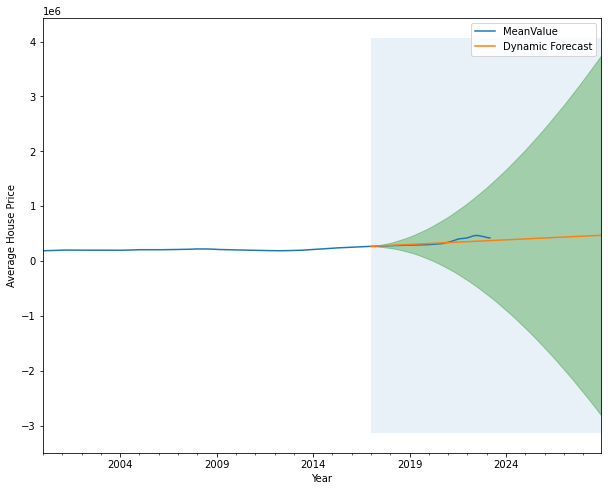

The Mean Squared Error of our forecasts for Zipcode 78652 is 43102.57
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07903D+01    |proj g|=  1.50188D+01

At iterate    5    f=  7.55991D+00    |proj g|=  6.14434D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   3.698D-05   7.559D+00
  F =   7.5592959132794517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


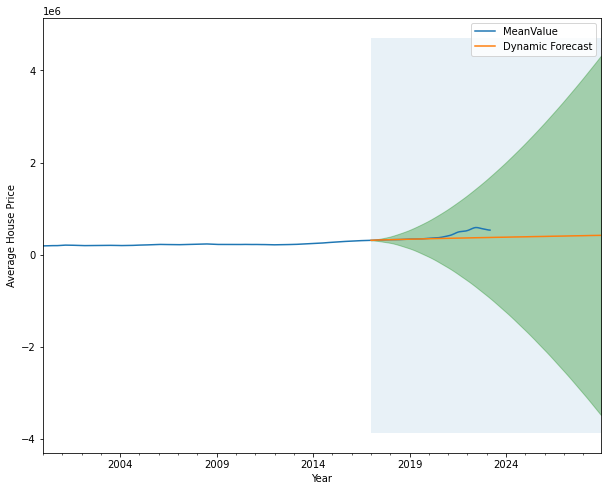

The Mean Squared Error of our forecasts for Zipcode 78724 is 97963.27
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78668D+00    |proj g|=  5.57486D+00

At iterate    5    f=  7.74005D+00    |proj g|=  4.41805D-01

At iterate   10    f=  7.71360D+00    |proj g|=  9.24048D-02


 This problem is unconstrained.



At iterate   15    f=  7.70807D+00    |proj g|=  1.95331D-03

At iterate   20    f=  7.70803D+00    |proj g|=  1.13858D-02

At iterate   25    f=  7.70387D+00    |proj g|=  1.69095D-01

At iterate   30    f=  7.57091D+00    |proj g|=  8.64499D-01

At iterate   35    f=  7.29571D+00    |proj g|=  2.34150D-01

At iterate   40    f=  7.24653D+00    |proj g|=  5.88560D-02

At iterate   45    f=  7.21621D+00    |proj g|=  7.32852D-02

At iterate   50    f=  7.20097D+00    |proj g|=  1.98460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   1.985D-02   7.201D+00
  F =   7.20096528534

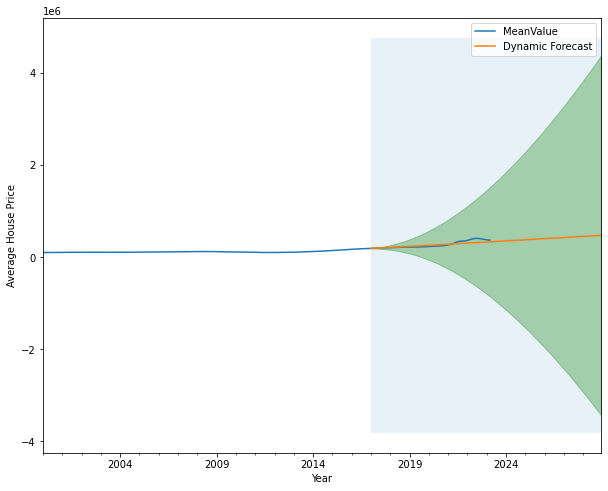

The Mean Squared Error of our forecasts for Zipcode 78747 is 38071.95


In [46]:
# Make Prediction post 2016 and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order=pdq,
                                 seasonal_order=pdqs,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    # get dynamic predictions starting 2017-06-01 up to 2030-12-31
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), end=pd.to_datetime('2028-12-31'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-01-31':]['MeanValue']
    
    # Plot the dynamic forecast with confidence intervals as above
    ax = df.plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Year')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts for Zipcode {} is {}'.format(name, round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38704D+00    |proj g|=  8.71036D+00

At iterate    5    f=  6.99464D+00    |proj g|=  8.98345D-02

At iterate   10    f=  6.99391D+00    |proj g|=  4.58701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.587D-05   6.994D+00
  F =   6.9939092967283107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


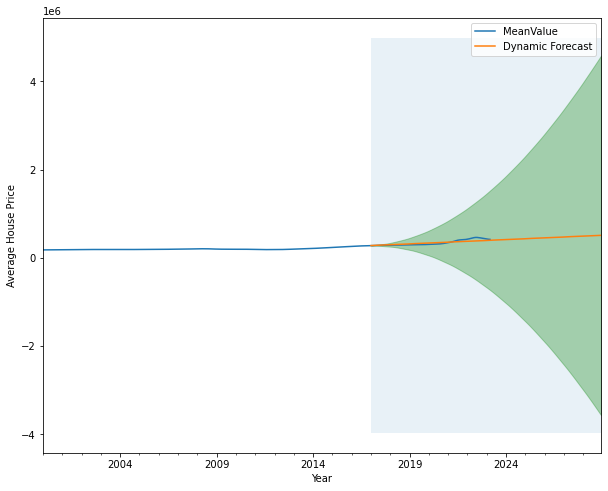

The Mean Squared Error of our forecasts for Zipcode 78652 is 33286.89
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54744D+00    |proj g|=  2.65694D+00

At iterate    5    f=  7.17009D+00    |proj g|=  3.35958D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   3.896D-05   7.170D+00
  F =   7.1697919925455809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


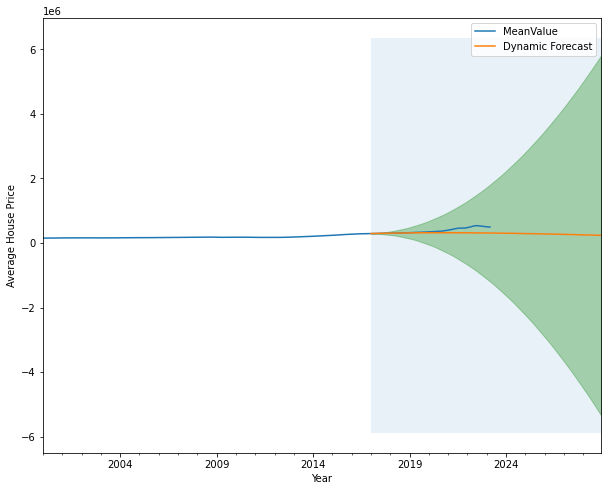

The Mean Squared Error of our forecasts for Zipcode 78724 is 105345.85
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73526D+00    |proj g|=  8.79679D+00

At iterate    5    f=  7.07771D+00    |proj g|=  7.94834D-02

At iterate   10    f=  7.05223D+00    |proj g|=  1.62801D-01


 This problem is unconstrained.



At iterate   15    f=  7.01787D+00    |proj g|=  8.24754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.288D-04   7.018D+00
  F =   7.0178492921033380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


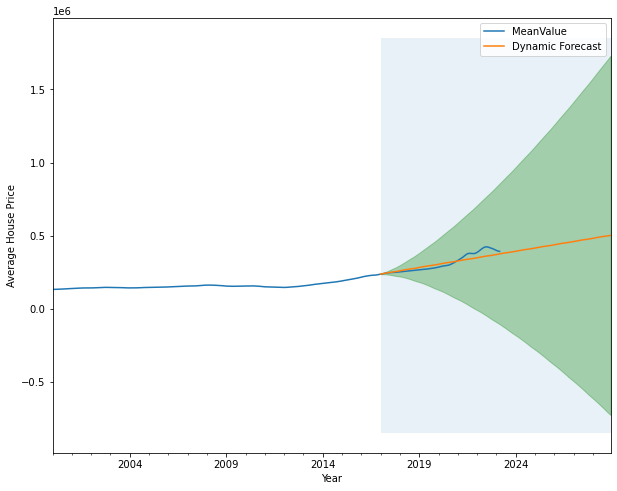

The Mean Squared Error of our forecasts for Zipcode 78747 is 26524.22


In [89]:
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order=pdq,
                                 seasonal_order=pdqs,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)
                                
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    # get dynamic predictions starting 2017-06-01 up to 2030-12-31
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), end=pd.to_datetime('2028-12-31'), dynamic=True, full_results=True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean.clip(lower=0)  # add lower bound of 0
    zip_truth = df['2017-01-31':]['MeanValue']
    
    # Plot the dynamic forecast with confidence intervals as above
    ax = df.plot(label='observed', figsize=(10, 8))
    pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

    ax.fill_between(pred_dynamic_conf.index,
                    pred_dynamic_conf.iloc[:, 0],
                    pred_dynamic_conf.iloc[:, 1], color='g', alpha=.3)

    ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2017-01-31'), zip_forecasted.index[-1], alpha=.1, zorder=-1)

    ax.set_xlabel('Year')
    ax.set_ylabel('Average House Price')

    plt.legend()
    plt.show()

    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    print('The Mean Squared Error of our forecasts for Zipcode {} is {}'.format(name, round(sqrt_mse, 2))) 
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value


In [91]:
predictions = pd.DataFrame()

current = []  # create an empty list to hold the current prices

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order=pdq,
                                 seasonal_order=pdqs,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    
    # get dynamic predictions starting 2017-06-01 up to 2030-12-31
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), end=pd.to_datetime('2028-12-31'), dynamic=True, full_results=True)
    zip_forecasted = pred_dynamic.predicted_mean
    
    # add predicted values for 2026 and 2028 to the predictions DataFrame
    predictions.loc[name, 'Zipcode'] = name
    predictions.loc[name, 'Current Price'] = df['2023-03']['MeanValue'][0]
    predictions.loc[name, '2026'] = zip_forecasted.loc['2026-12-31']
    predictions.loc[name, '2028'] = zip_forecasted.loc['2028-12-31']
    
    # calculate ROI for 2026 and 2028
    current_price = df['2023-03']['MeanValue'][0]
    roi_2026 = (predictions.loc[name, '2026'] - current_price) / current_price
    roi_2028 = (predictions.loc[name, '2028'] - current_price) / current_price

    # add ROI columns
    predictions.loc[name, '2026_roi'] = roi_2026
    predictions.loc[name, '2028_roi'] = roi_2028

predictions = predictions[['Zipcode', 'Current Price', '2026', '2028', '2026_roi', '2028_roi']]


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38704D+00    |proj g|=  8.71036D+00

At iterate    5    f=  6.99464D+00    |proj g|=  8.98345D-02

At iterate   10    f=  6.99391D+00    |proj g|=  4.58701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.587D-05   6.994D+00
  F =   6.9939092967283107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  7.05223D+00    |proj g|=  1.62801D-01

At iterate   15    f=  7.01787D+00    |proj g|=  8.24754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.288D-04   7.018D+00
  F =   7.0178492921033380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [92]:
predictions

Zipcode  Current Price           2026           2028  2026_roi  \
78652  78652.0    419470.0578  471699.301273  511002.569998  0.124512   
78724  78724.0    493374.4832  265147.606080  235281.123000 -0.462583   
78747  78747.0    392080.8478  457336.659983  501651.000947  0.166435   

       2028_roi  
78652  0.218210  
78724 -0.523119  
78747  0.279458

# For All ZipCodes

In [77]:
zip_dfs = []
zip_list = dfm.ZipCode.unique()
for x in zip_list:
    zip_dfs.append(pd.DataFrame(dfm[dfm['ZipCode']==x][['MeanValue']].copy()))

In [78]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0,2)
# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p,d,q))
# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [142]:
zip_list

array([78660, 78745, 78753, 78704, 78758, 78748, 78744, 78741, 78759,
       78653, 78723, 78749, 78750, 78754, 78727, 78746, 78705, 78738,
       78724, 78728, 78617, 78731, 78752, 78703, 78734, 78739, 78735,
       78747, 78732, 78645, 78726, 78730, 78733, 78721, 78756, 78736,
       78652, 78669, 78725, 78719, 78757, 78701, 78751, 78702, 78722])

In [113]:
start = time.time()

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, d and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, d and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

ans = []
for i, zipcode in enumerate(zip_list):
    df = zip_dfs[i]
    name = str(zipcode)
    
    # Initialize the best AIC and corresponding parameters
    best_aic = float("inf")
    best_params = None
    best_seasonal_params = None
    
    # Loop over all possible combinations of parameters
    for param in pdq:
        for param_seasonal in pdqs:
            try:
                # Fit the SARIMAX model with the current parameters
                mod = sm.tsa.statespace.SARIMAX(df,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)
                results = mod.fit()
                
                # If the current AIC is the best so far, store the corresponding parameters
                if results.aic < best_aic:
                    best_aic = results.aic
                    best_params = param
                    best_seasonal_params = param_seasonal
                
            except:
                continue
    
    # Append the best parameters and corresponding AIC to the answer list
    ans.append([name, best_params, best_seasonal_params, best_aic])
    print('Result for {}: ARIMA {} x {}12 : AIC Calculated = {}'.format(name, best_params, best_seasonal_params, best_aic))

end = time.time()
print("Time taken:", end - start)


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38039D+01    |proj g|=  6.57253D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   6.573D-09   1.380D+01
  F =   13.803880688089807     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.1

 This problem is unconstrained.



At iterate   25    f=  1.06852D+01    |proj g|=  1.76698D-02
  ys=-8.521E+00  -gs= 8.385E-01 BFGS update SKIPPED

At iterate   30    f=  1.04572D+01    |proj g|=  3.67706D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     62      1     2     0   3.677D-07   1.046D+01
  F =   10.457161318707952     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07313D+01    |proj g|=  8.47351D-04

           * * *


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.79738D+02    |proj g|=  9.64569D+01

At iterate    5    f=  6.19118D+02    |proj g|=  7.04243D+01

At iterate   10    f=  1.06877D+01    |proj g|=  1.52094D-01

At iterate   15    f=  1.06875D+01    |proj g|=  5.49415D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     28      1     0     0   2.486D-05   1.069D+01
  F =   10.687504747906514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94897D+02    |proj g|=  1.51088D+01

At iterate    5    f=  4.12845D+01    |proj g|=  1.19078D+00

At iterate   10    f=  1.80469D+01    |proj g|=  5.97230D-02

At iterate   15    f=  1.55773D+01    |proj g|=  2.13683D-03

At iterate   20    f=  1.55079D+01    |proj g|=  1.09695D-04

At iterate   25    f=  1.38206D+01    |proj g|=  9.85561D-03
  ys=-4.212E+00  -gs= 4.395E-01 BFGS update SKIPPED

At iterate   30    f=  1.32232D+01    |proj g|=  1.06749D-01

At iterate   35    f=  1.02739D+01    |proj g|=  3.71001D-01

At iterate   40    f=  1.01850D+01    |proj g|=  4.23478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.21350D+02    |proj g|=  2.45421D+03

At iterate    5    f=  1.12984D+02    |proj g|=  1.22330D+01

At iterate   10    f=  8.49590D+01    |proj g|=  7.12828D-01

At iterate   15    f=  7.91441D+01    |proj g|=  3.77670D-02

At iterate   20    f=  7.84440D+01    |proj g|=  8.84624D-04

At iterate   25    f=  7.84397D+01    |proj g|=  5.22832D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.05877D+01    |proj g|=  2.63327D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     10      1     0     0   2.633D-05   1.059D+01
  F =   10.587704063802054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90550D+02    |proj g|=  1.31711D+01
  ys=-3.037E+02  -gs= 5.116E+01 BFGS update SKIPPED

At iterate    5    f=  3.15207D+01    |proj g|=  1.58510D+00

At iterate   10  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.28760D+02    |proj g|=  7.33159D+02

At iterate    5    f=  1.37276D+01    |proj g|=  1.35469D-02

At iterate   10    f=  1.37276D+01    |proj g|=  4.08847D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   4.088D-06   1.373D+01
  F =   13.727575728815131     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


  ys=-2.824E-02  -gs= 2.042E-02 BFGS update SKIPPED

At iterate    5    f=  1.01026D+01    |proj g|=  5.73881D-02

At iterate   10    f=  1.00963D+01    |proj g|=  9.21295D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     1     0   6.189D-04   1.010D+01
  F =   10.096332259638743     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.24211D+02    |proj g|=  3.73819D+01

At iterate    5    f=  4.79987D+01    |proj g|=  3.36775D+01

At iterate   10    f=  2.24497D+01    |proj g|=  8.97586D-01

At iterate   15    f=  1.69927D+01    |proj g|=  9.85181D-02

At iterate   20    f=  1.67125D+01    |proj g|=  9.43638D-03

At iterate   25    f=  1.67087D+01    |proj g|=  6.17174D-05

At iterate   30    f=  1.67086D+01    |proj g|=  2.87875D-03

At iterate   35    f=  1.67066D+01    |proj g|=  7.96976D-03

At iterate   40    f=  1.52423D+01    |proj g|=  1.34580D-02

At iterate   45    f=  1.48768D+01    |proj g|=  7.75007D-02

At iterate   50    f=  1.34607D+01    |proj g|=  2.96673D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78387D+00    |proj g|=  2.05041D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   7.972D-07   8.783D+00
  F =   8.7832269625167179     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.62365D+00    |proj g|=  2.50094D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   6.811D-05   8.624D+00
  F =   8.6236512428561927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43266D+00    |proj g|=  1.71863D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.31101D+00    |proj g|=  5.96075D-02

At iterate   10    f=  8.30928D+00    |proj g|=  1.44461D-03

At iterate   15    f=  8.30927D+00    |proj g|=  5.86109D-03

At iterate   20    f=  8.30866D+00    |proj g|=  5.40667D-02

At iterate   25    f=  8.29488D+00    |proj g|=  1.80027D-01

At iterate   30    f=  8.02554D+00    |proj g|=  2.01286D-01

At iterate   35    f=  8.01795D+00    |proj g|=  6.44505D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     52      1     0     0   1.073D-05   8.018D+00
  F =   8.0179538273454369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.02858D+00    |proj g|=  9.59669D-02

At iterate   10    f=  8.01772D+00    |proj g|=  1.97521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     22      1     0     0   2.367D-04   8.018D+00
  F =   8.0177204571000562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.97616D+00    |proj g|=  3.07745D-01

At iterate    5    f=  8.41158D+00    |proj g|=  1.04204D-01


 This problem is unconstrained.



At iterate   10    f=  8.40790D+00    |proj g|=  2.78436D-04

At iterate   15    f=  8.40790D+00    |proj g|=  6.33717D-03

At iterate   20    f=  8.40712D+00    |proj g|=  1.03690D-01

At iterate   25    f=  8.29386D+00    |proj g|=  1.31621D+00

At iterate   30    f=  8.20280D+00    |proj g|=  3.47924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     45      1     0     0   1.463D-05   8.203D+00
  F =   8.2027650046063751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  8.31200D+00    |proj g|=  8.39467D-02

At iterate   15    f=  8.30928D+00    |proj g|=  3.07888D-04

At iterate   20    f=  8.30922D+00    |proj g|=  1.24719D-02

At iterate   25    f=  8.30382D+00    |proj g|=  9.88482D-02

At iterate   30    f=  8.18501D+00    |proj g|=  7.52726D-01

At iterate   35    f=  8.01835D+00    |proj g|=  4.41235D-02

At iterate   40    f=  8.01775D+00    |proj g|=  2.83560D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     50      1     0     0   2.753D-05   8.018D+00
  F =   8.0177499754950681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07131D+01    |proj g|=  2.66966D+01

At iterate    5    f=  8.02510D+00    |proj g|=  1.31023D-01

At iterate   10    f=  8.00566D+00    |proj g|=  6.83326D-02

At iterate   15    f=  8.00346D+00    |proj g|=  2.70904D-02

At iterate   20    f=  8.00326D+00    |proj g|=  2.52467D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   2.525D-04   8.003D+00
  F =   8.0032574963750740     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.03310D+01    |proj g|=  5.70257D+01

At iterate   10    f=  8.63294D+00    |proj g|=  2.69158D+00

At iterate   15    f=  8.63162D+00    |proj g|=  5.46837D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     52      1     0     0   5.468D-04   8.632D+00
  F =   8.6316244437287306     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81383D+00    |proj g|=  4.02774D-04

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12520D+01    |proj g|=  1.09743D+00

At iterate    5    f=  1.12249D+01    |proj g|=  4.39986D-01

At iterate   10    f=  1.11433D+01    |proj g|=  2.40517D-01

At iterate   15    f=  1.11416D+01    |proj g|=  7.25040D-04

At iterate   20    f=  1.11413D+01    |proj g|=  8.45819D-02

At iterate   25    f=  1.11014D+01    |proj g|=  1.15789D+00

At iterate   30    f=  8.97062D+00    |proj g|=  2.89919D+00

At iterate   35    f=  8.47836D+00    |proj g|=  2.42703D-01

At iterate   40    f=  8.44770D+00    |proj g|=  1.82779D-01

At iterate   45    f=  8.44256D+00    |proj g|=  2.41450D-01

At iterate   50    f=  8.44043D+00    |proj g|=  9.10656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.68135D+00    |proj g|=  1.73594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     30      1     0     0   1.736D-04   8.681D+00
  F =   8.6813506166775412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.60467D+01    |proj g|=  1.09030D+02

At iterate    5    f=  1.06446D+01    |proj g|=  7.07306D-02

At iterate   10    f=  1.06401D+01    |proj g|=  2.18113D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.04332D+01    |proj g|=  1.47361D+00

At iterate   10    f=  1.03258D+01    |proj g|=  1.59036D+00

At iterate   15    f=  8.57875D+00    |proj g|=  5.69560D+00

At iterate   20    f=  8.46958D+00    |proj g|=  1.07073D+00

At iterate   25    f=  8.43436D+00    |proj g|=  3.79186D-02

At iterate   30    f=  8.43119D+00    |proj g|=  1.30786D-02

At iterate   35    f=  8.43118D+00    |proj g|=  1.17190D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     57      1     0     0   1.172D-05   8.431D+00
  F =   8.4311750673668762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.16310D+01    |proj g|=  1.68003D-01

At iterate   20    f=  1.03934D+01    |proj g|=  1.46208D+01

At iterate   25    f=  8.76565D+00    |proj g|=  1.09456D+02

At iterate   30    f=  8.38776D+00    |proj g|=  3.69998D+01

At iterate   35    f=  8.19987D+00    |proj g|=  7.08464D-01

At iterate   40    f=  8.19921D+00    |proj g|=  4.85305D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     79      1     1     0   6.197D-03   8.199D+00
  F =   8.1992090572357181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.09156D+01    |proj g|=  1.08388D+00

At iterate   15    f=  1.07918D+01    |proj g|=  2.71812D-03

At iterate   20    f=  1.07913D+01    |proj g|=  4.24905D-03

At iterate   25    f=  1.07912D+01    |proj g|=  6.31296D-03

At iterate   30    f=  1.07845D+01    |proj g|=  9.09819D-02

At iterate   35    f=  1.03725D+01    |proj g|=  1.82603D+00

At iterate   40    f=  8.83507D+00    |proj g|=  1.76160D+00

At iterate   45    f=  7.87490D+00    |proj g|=  3.71487D-01

At iterate   50    f=  7.87052D+00    |proj g|=  3.74608D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     72   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.14627D+00    |proj g|=  8.22619D-01

At iterate   10    f=  9.03001D+00    |proj g|=  2.93971D-01

At iterate   15    f=  8.26438D+00    |proj g|=  2.16426D-01

At iterate   20    f=  8.25503D+00    |proj g|=  9.14957D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     31      1     0     0   1.398D-03   8.255D+00
  F =   8.2550251374134191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06930D+00    |proj g|=  1.40780D+00

At iterate    5    f=  8.25918D+00    |proj g|=  1.19557D+00

At iterate   10    f=  8.07155D+00    |proj g|=  3.10318D-01

At iterate   15    f=  8.05482D+00    |proj g|=  3.30431D-02

At iterate   20    f=  8.05477D+00    |proj g|=  2.46801D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   2.468D-04   8.055D+00
  F =   8.0547700110981300     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  1.01049D+01    |proj g|=  2.01895D-01

At iterate   15    f=  9.98483D+00    |proj g|=  2.25269D-01

At iterate   20    f=  9.60718D+00    |proj g|=  7.93636D+00

At iterate   25    f=  8.90505D+00    |proj g|=  2.80684D+00

At iterate   30    f=  8.37966D+00    |proj g|=  9.12860D-01

At iterate   35    f=  8.06885D+00    |proj g|=  3.36190D-01

At iterate   40    f=  8.01671D+00    |proj g|=  7.45446D-02

At iterate   45    f=  8.01630D+00    |proj g|=  3.47092D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     72      1     0     0   2.533D-04   8.016D+00
  F =   8.01630133387

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  8.23256D+00    |proj g|=  6.07572D-01

At iterate   20    f=  7.55483D+00    |proj g|=  8.54083D-02

At iterate   25    f=  7.52268D+00    |proj g|=  1.56287D-02

At iterate   30    f=  7.52022D+00    |proj g|=  1.81543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     36      1     0     0   2.465D-05   7.520D+00
  F =   7.5202199913162682     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93188D+00    |proj g|=  1.02148D+01

At iterate    5    f=  7.24185D+00    |proj g|=  2.33790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      7      1     0     0   2.765D-05   7.242D+00
  F =   7.2418496587801071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.58267D+00    |proj g|=  8.58658D-01

At iterate   15    f=  7.50963D+00    |proj g|=  2.01327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   1.180D-04   7.510D+00
  F =   7.5096323054109595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23260D+00    |proj g|=  1.26228D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  7.22983D+00    |proj g|=  3.16986D-01

At iterate   10    f=  7.22080D+00    |proj g|=  1.02786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   6.836D-05   7.221D+00
  F =   7.2207978234603800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68419D+00    |proj g|=  1.24912D+01

At iterate    5    f=  7.63378D+00    |proj g|=  2.70818D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28255D+00    |proj g|=  4.25555D+00

At iterate    5    f=  7.56972D+00    |proj g|=  2.81176D-01

At iterate   10    f=  7.50986D+00    |proj g|=  1.12199D-03

At iterate   15    f=  7.50876D+00    |proj g|=  5.96480D-02

At iterate   20    f=  7.41757D+00    |proj g|=  5.28365D-01

At iterate   25    f=  7.25544D+00    |proj g|=  1.57550D-01

At iterate   30    f=  7.23039D+00    |proj g|=  1.43386D-02

At iterate   35    f=  7.22966D+00    |proj g|=  2.00507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  6.99391D+00    |proj g|=  4.58701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.587D-05   6.994D+00
  F =   6.9939092967283107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00247D+01    |proj g|=  6.90363D+00

At iterate    5    f=  7.29700D+00    |proj g|=  2.22140D-01

At iterate   10    f=  7.28820D+00    |proj g|=  1.67319D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.50159D+00    |proj g|=  2.35568D-01

At iterate   10    f=  7.47644D+00    |proj g|=  9.98088D-04

At iterate   15    f=  7.47641D+00    |proj g|=  6.18516D-03

At iterate   20    f=  7.47369D+00    |proj g|=  7.64968D-02

At iterate   25    f=  7.34247D+00    |proj g|=  6.56384D-01

At iterate   30    f=  7.24462D+00    |proj g|=  5.52000D-02

At iterate   35    f=  7.23121D+00    |proj g|=  3.48930D-02

At iterate   40    f=  7.22671D+00    |proj g|=  1.48535D-02

At iterate   45    f=  7.22652D+00    |proj g|=  7.46834D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     59   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.04977D+00    |proj g|=  1.77480D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   1.775D-04   7.050D+00
  F =   7.0497725708892700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07843D+01    |proj g|=  1.13652D+01

At iterate    5    f=  7.07154D+00    |proj g|=  5.20945D-01

At iterate   10    f=  6.98553D+00    |proj g|=  4.12817D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38278D+01    |proj g|=  9.05943D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.059D-09   1.383D+01
  F =   13.827800143897123     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.0

 This problem is unconstrained.



At iterate    5    f=  2.39670D+01    |proj g|=  1.73358D-01

At iterate   10    f=  1.67281D+01    |proj g|=  7.48372D-03

At iterate   15    f=  1.62629D+01    |proj g|=  7.65191D-05

At iterate   20    f=  1.62389D+01    |proj g|=  4.47292D-04
  ys=-9.850E+01  -gs= 7.320E-01 BFGS update SKIPPED

At iterate   25    f=  1.06454D+01    |proj g|=  7.21224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     54      1     1     0   7.459D-06   1.063D+01
  F =   10.633391853096771     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01643D+01    |proj g|=  1.08182D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.080D-05   1.016D+01
  F =   10.164274960999769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.8

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.34309D+01    |proj g|=  5.88647D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     17      1     0     0   4.535D-05   1.343D+01
  F =   13.430855606996404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40704D+01    |proj g|=  1.96665D+00

At iterate    5    f=  1.34153D+01    |proj g|=  3.73796D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  1.41277D+01    |proj g|=  1.50540D+01

At iterate   10    f=  1.35168D+01    |proj g|=  2.33873D+00

At iterate   15    f=  1.27568D+01    |proj g|=  2.24238D-01

At iterate   20    f=  1.27505D+01    |proj g|=  7.34253D-03

At iterate   25    f=  1.27504D+01    |proj g|=  1.00238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     73      1     0     0   1.002D-05   1.275D+01
  F =   12.750422121979687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15228D+01    |proj g|=  3.52869D-01

At iterate    5    f=  1.11238D+01    |proj g|=  3.09569D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   3.096D-05   1.112D+01
  F =   11.123753931985057     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.42020D+02    |proj g|=  1.69139D+02

At iterate   10    f=  1.30470D+01    |proj g|=  4.83059D-01

At iterate   15    f=  1.28666D+01    |proj g|=  1.65094D-01

At iterate   20    f=  1.27145D+01    |proj g|=  6.55655D-02

At iterate   25    f=  1.27114D+01    |proj g|=  2.69777D-02

At iterate   30    f=  1.27105D+01    |proj g|=  1.21933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     65      1     0     0   7.952D-06   1.271D+01
  F =   12.710485144341590     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     21      1     0     0   2.948D-05   1.024D+01
  F =   10.244286999901286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57299D+02    |proj g|=  3.56608D+01

At iterate    5    f=  1.48460D+01    |proj g|=  1.60499D+00

At iterate   10    f=  1.32185D+01    |proj g|=  4.29750D-02

At iterate   15    f=  1.31924D+01    |proj g|=  8.24582D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.77841D+00    |proj g|=  1.37666D-03

At iterate   15    f=  8.77823D+00    |proj g|=  2.21253D-02

At iterate   20    f=  8.75185D+00    |proj g|=  2.27997D-01

At iterate   25    f=  8.71407D+00    |proj g|=  8.14313D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     35      1     0     0   1.365D-06   8.713D+00
  F =   8.7125257662966824     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.45594D+00    |proj g|=  3.04784D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   2.954D-05   8.456D+00
  F =   8.4559446616520777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80728D+00    |proj g|=  5.13385D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.43938D+00    |proj g|=  3.71389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     20      1     0     0   4.173D-05   8.439D+00
  F =   8.4391867688899627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41207D+00    |proj g|=  4.91722D-01

At iterate    5    f=  8.92384D+00    |proj g|=  9.50412D-04

At iterate   10    f=  8.92384D+00    |proj g|=  6.32305D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24036D+00    |proj g|=  6.16062D-01

At iterate    5    f=  8.48724D+00    |proj g|=  4.55874D-02

At iterate   10    f=  8.48234D+00    |proj g|=  2.07053D-03

At iterate   15    f=  8.48234D+00    |proj g|=  2.90513D-03

At iterate   20    f=  8.48191D+00    |proj g|=  3.62982D-02

At iterate   25    f=  8.46324D+00    |proj g|=  1.81471D-01

At iterate   30    f=  8.19878D+00    |proj g|=  1.97454D-01

At iterate   35    f=  8.15480D+00    |proj g|=  7.29464D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.06210D+00    |proj g|=  3.75360D-02

At iterate   10    f=  8.06092D+00    |proj g|=  2.23891D-04

At iterate   15    f=  8.06073D+00    |proj g|=  2.30016D-02

At iterate   20    f=  8.03596D+00    |proj g|=  2.86611D-01

At iterate   25    f=  7.91786D+00    |proj g|=  1.55985D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     39      1     0     0   4.567D-05   7.918D+00
  F =   7.9175898898973935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.40888D+00    |proj g|=  3.62508D-01

At iterate   30    f=  8.40037D+00    |proj g|=  1.97577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     48      1     0     0   2.538D-05   8.400D+00
  F =   8.4003684366604219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10497D+00    |proj g|=  5.89657D-01

At iterate    5    f=  8.52647D+00    |proj g|=  9.88401D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.48161D+00    |proj g|=  2.31362D-02

At iterate   25    f=  8.45226D+00    |proj g|=  2.35092D-01

At iterate   30    f=  8.22171D+00    |proj g|=  7.53340D-01

At iterate   35    f=  8.15567D+00    |proj g|=  8.48384D-02

At iterate   40    f=  8.15346D+00    |proj g|=  1.75551D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     52      1     0     0   1.164D-05   8.153D+00
  F =   8.1534557313530769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.06492D+00    |proj g|=  1.23986D+00

At iterate   30    f=  7.97482D+00    |proj g|=  4.10005D-01

At iterate   35    f=  7.96574D+00    |proj g|=  1.13877D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     42      1     0     0   3.196D-06   7.966D+00
  F =   7.9657389015522302     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43237D+00    |proj g|=  4.59939D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.05062D+00    |proj g|=  2.61805D-02

At iterate   15    f=  8.05059D+00    |proj g|=  4.92602D-04

At iterate   20    f=  8.05056D+00    |proj g|=  1.36462D-02

At iterate   25    f=  8.04839D+00    |proj g|=  8.14171D-02

At iterate   30    f=  7.97055D+00    |proj g|=  3.52174D-01

At iterate   35    f=  7.90291D+00    |proj g|=  2.22032D-01

At iterate   40    f=  7.89556D+00    |proj g|=  3.03104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     53      1     0     0   5.408D-05   7.896D+00
  F =   7.8955168261800361     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  8.71421D+00    |proj g|=  8.21645D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     48      1     1     0   8.216D-05   8.714D+00
  F =   8.7142104771580886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86422D+00    |proj g|=  5.35342D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.10637D+01    |proj g|=  1.97772D-01

At iterate   15    f=  1.10625D+01    |proj g|=  6.88357D-04

At iterate   20    f=  1.10625D+01    |proj g|=  3.51367D-02

At iterate   25    f=  1.10553D+01    |proj g|=  4.53555D-01

At iterate   30    f=  1.03766D+01    |proj g|=  6.24302D+00

At iterate   35    f=  8.56065D+00    |proj g|=  6.27352D-01

At iterate   40    f=  8.49339D+00    |proj g|=  5.84970D-02

At iterate   45    f=  8.48683D+00    |proj g|=  4.23114D-02

At iterate   50    f=  8.48543D+00    |proj g|=  3.82404D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     70   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.01659D+01    |proj g|=  1.33670D-01

At iterate   10    f=  1.01622D+01    |proj g|=  1.73902D+00

At iterate   15    f=  9.80286D+00    |proj g|=  3.66241D+01

At iterate   20    f=  8.73281D+00    |proj g|=  4.71734D-01

At iterate   25    f=  8.71433D+00    |proj g|=  9.47569D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     38      1     0     0   5.201D-04   8.714D+00
  F =   8.7143085147599741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45505D+01    |proj g|=  2.44345D+00

At iterate    5    f=  1.01773D+01    |proj g|=  1.25031D-01


 This problem is unconstrained.



At iterate   10    f=  9.74099D+00    |proj g|=  6.11464D+00
  ys=-3.623E-01  -gs= 2.599E-01 BFGS update SKIPPED

At iterate   15    f=  8.56477D+00    |proj g|=  2.51533D-01

At iterate   20    f=  8.48432D+00    |proj g|=  2.15396D-02

At iterate   25    f=  8.48122D+00    |proj g|=  7.93058D-01

At iterate   30    f=  8.47710D+00    |proj g|=  1.43530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     58      1     1     0   3.437D-05   8.477D+00
  F =   8.4771019184087688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.07857D+00    |proj g|=  8.68759D+00

At iterate   10    f=  8.71310D+00    |proj g|=  2.15451D-01

At iterate   15    f=  8.71307D+00    |proj g|=  1.01566D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     35      1     0     0   1.016D-02   8.713D+00
  F =   8.7130714826853417     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24476D+01    |proj g|=  2.87185D+00

At iter

 This problem is unconstrained.



At iterate   20    f=  9.05936D+00    |proj g|=  3.78828D-01

At iterate   25    f=  8.65696D+00    |proj g|=  4.09785D-01

At iterate   30    f=  8.65567D+00    |proj g|=  3.59645D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     40      1     0     0   5.039D-06   8.656D+00
  F =   8.6556131869437181     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29376D+01    |proj g|=  6.22688D+00


 This problem is unconstrained.



At iterate    5    f=  1.14368D+01    |proj g|=  5.32048D+00

At iterate   10    f=  1.06825D+01    |proj g|=  9.40510D-01

At iterate   15    f=  1.06411D+01    |proj g|=  3.00132D-03

At iterate   20    f=  1.06410D+01    |proj g|=  3.27908D-02

At iterate   25    f=  1.06406D+01    |proj g|=  4.74946D-03

At iterate   30    f=  1.06406D+01    |proj g|=  8.01248D-03

At iterate   35    f=  1.06394D+01    |proj g|=  9.42173D-02

At iterate   40    f=  1.05082D+01    |proj g|=  6.26025D-01

At iterate   45    f=  8.54548D+00    |proj g|=  2.40955D+00

At iterate   50    f=  7.96231D+00    |proj g|=  1.07886D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.50018D+00    |proj g|=  1.75243D+01

At iterate   20    f=  8.37225D+00    |proj g|=  1.78683D+00

At iterate   25    f=  8.37063D+00    |proj g|=  2.32550D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   2.326D-04   8.371D+00
  F =   8.3706320849151297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.49947D+01    |proj g|=  8.36112D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.09703D+00    |proj g|=  3.68653D-01

At iterate   15    f=  8.08577D+00    |proj g|=  2.46004D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   2.251D-04   8.086D+00
  F =   8.0856753375920185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.24753D+01    |proj g|=  1.69137D+01


 This problem is unconstrained.



At iterate    5    f=  1.08962D+01    |proj g|=  6.06106D+00

At iterate   10    f=  9.79519D+00    |proj g|=  1.61625D-01

At iterate   15    f=  9.72395D+00    |proj g|=  2.70469D+00

At iterate   20    f=  9.51194D+00    |proj g|=  3.60287D+00

At iterate   25    f=  8.58664D+00    |proj g|=  2.37666D+00

At iterate   30    f=  8.16211D+00    |proj g|=  1.18214D+00

At iterate   35    f=  8.07645D+00    |proj g|=  1.34594D+00

At iterate   40    f=  8.05257D+00    |proj g|=  2.32951D-02

At iterate   45    f=  8.05157D+00    |proj g|=  3.15773D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     76   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.15693D+00    |proj g|=  5.36950D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   5.355D-05   8.157D+00
  F =   8.1569332083928074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   3.685D-05   7.780D+00
  F =   7.7804880191104981     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52606D+00    |proj g|=  6.17832D-01

At iterate    5    f=  7.42429D+00    |proj g|=  4.17957D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.72872D+00    |proj g|=  1.67235D-04

At iterate   10    f=  7.72870D+00    |proj g|=  5.36527D-03

At iterate   15    f=  7.72739D+00    |proj g|=  6.80202D-02

At iterate   20    f=  7.72212D+00    |proj g|=  3.06590D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   3.066D-06   7.722D+00
  F =   7.7221201319092456     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.41241D+00    |proj g|=  3.64106D-02

At iterate   10    f=  7.41114D+00    |proj g|=  5.12323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   3.897D-05   7.411D+00
  F =   7.4111364710527541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98333D+00    |proj g|=  1.06694D+01

At iterate    5    f=  7.94635D+00    |proj g|=  4.42271D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.83761D+00    |proj g|=  1.20444D-01

At iterate   10    f=  7.83474D+00    |proj g|=  1.05700D-03

At iterate   15    f=  7.83448D+00    |proj g|=  2.30687D-02

At iterate   20    f=  7.80404D+00    |proj g|=  2.89615D-01

At iterate   25    f=  7.53115D+00    |proj g|=  1.41226D-01

At iterate   30    f=  7.48895D+00    |proj g|=  3.46907D-02

At iterate   35    f=  7.48412D+00    |proj g|=  1.11214D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     43      1     0     0   5.252D-07   7.484D+00
  F =   7.4840963104110392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36904D+00    |proj g|=  4.77023D+00

At iterate    5    f=  7.57846D+00    |proj g|=  5.65779D-01

At iterate   10    f=  7.53983D+00    |proj g|=  4.88233D-04

At iterate   15    f=  7.53982D+00    |proj g|=  2.48286D-03

At iterate   20    f=  7.53969D+00    |proj g|=  3.31886D-02

At iterate   25    f=  7.53191D+00    |proj g|=  1.41204D-01

At iterate   30    f=  7.52988D+00    |proj g|=  1.18911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.47264D+00    |proj g|=  2.99515D-02

At iterate   10    f=  7.47136D+00    |proj g|=  3.80357D-04

At iterate   15    f=  7.47135D+00    |proj g|=  5.38835D-03

At iterate   20    f=  7.47047D+00    |proj g|=  6.30711D-02

At iterate   25    f=  7.45063D+00    |proj g|=  2.20399D-01

At iterate   30    f=  7.44447D+00    |proj g|=  5.79777D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     34      1     0     0   4.315D-06   7.444D+00
  F =   7.4444743643507163     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.16637D+00    |proj g|=  1.35071D-01

At iterate   10    f=  7.15388D+00    |proj g|=  5.26791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   7.496D-05   7.154D+00
  F =   7.1538758832286291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78745: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4001.8627428415753
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36457D+01    |pr

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.38245D+01    |proj g|=  2.85647D-01

At iterate   10    f=  1.61240D+01    |proj g|=  1.25059D-02

At iterate   15    f=  1.56112D+01    |proj g|=  1.49772D-04

At iterate   20    f=  1.55949D+01    |proj g|=  5.63748D-04
  ys=-5.353E+00  -gs= 8.382E-01 BFGS update SKIPPED

At iterate   25    f=  1.04377D+01    |proj g|=  1.14796D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     54      1     1     0   9.702D-07   1.037D+01
  F =   10.371362237608588     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.61835D+01    |proj g|=  8.22875D+01

At iterate   10    f=  1.05614D+01    |proj g|=  1.04249D+00

At iterate   15    f=  1.04362D+01    |proj g|=  8.06351D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     43      1     1     0   2.810D-06   1.044D+01
  F =   10.436236839248714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95543D+00    |proj g|=  1.04933D-05

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18369D+01    |proj g|=  8.80587D+00

At iterate    5    f=  2.48618D+01    |proj g|=  5.69978D-01

At iterate   10    f=  1.42560D+01    |proj g|=  1.47977D-02

At iterate   15    f=  1.37684D+01    |proj g|=  9.15220D-02

At iterate   20    f=  1.30352D+01    |proj g|=  1.01093D-01

At iterate   25    f=  1.30327D+01    |proj g|=  5.80656D-05

At iterate   30    f=  1.30327D+01    |proj g|=  1.91982D-03

At iterate   35    f=  1.30321D+01    |proj g|=  3.14789D-02

At iterate   40    f=  1.30063D+01    |proj g|=  8.14904D-02

At iterate   45    f=  1.29528D+01    |proj g|=  1.20396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.54643D+01    |proj g|=  5.32408D+00

At iterate   15    f=  1.38805D+01    |proj g|=  9.28600D+00

At iterate   20    f=  1.25810D+01    |proj g|=  1.72961D-01

At iterate   25    f=  1.25765D+01    |proj g|=  1.10493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     75      1     0     0   1.223D-05   1.258D+01
  F =   12.576450421986044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.22070D+01    |proj g|=  2.56657D+01

At iterate   10    f=  2.15559D+01    |proj g|=  7.02282D+00

At iterate   15    f=  1.73319D+01    |proj g|=  2.89653D+01

At iterate   20    f=  1.44326D+01    |proj g|=  8.87693D-01

At iterate   25    f=  1.43198D+01    |proj g|=  9.08278D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     45      1     0     0   8.241D-05   1.432D+01
  F =   14.319824174439496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  2.53570D+02    |proj g|=  3.55399D+00

At iterate   15    f=  1.49104D+01    |proj g|=  2.19205D+01

At iterate   20    f=  1.33012D+01    |proj g|=  4.66865D-01

At iterate   25    f=  1.32863D+01    |proj g|=  2.15829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   3.277D-05   1.329D+01
  F =   13.286150585831882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.


  ys=-1.602E-01  -gs= 4.632E-02 BFGS update SKIPPED

At iterate    5    f=  9.98611D+00    |proj g|=  6.26007D-02

At iterate   10    f=  9.98589D+00    |proj g|=  7.40872D-02

At iterate   15    f=  9.98570D+00    |proj g|=  3.88793D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     27      1     1     0   3.888D-05   9.986D+00
  F =   9.9856950289321897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.



At iterate    5    f=  4.39182D+01    |proj g|=  7.39147D-01

At iterate   10    f=  2.83474D+01    |proj g|=  1.95551D+00

At iterate   15    f=  1.39806D+01    |proj g|=  1.73200D-01

At iterate   20    f=  1.35535D+01    |proj g|=  1.57331D-01

At iterate   25    f=  1.27578D+01    |proj g|=  5.34612D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   4.857D-05   1.276D+01
  F =   12.755361554797169     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03572D+00    |proj g|=  3.27809D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   3.278D-06   9.036D+00
  F =   9.0357185351804716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43366D+00    |proj g|=  1.66776D+00

At iterate    5    f=  8.21879D+00    |proj g|=  1.08494D-02

At iterate   10    f=  8.21138D+00    |proj g|=  4.43759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     20      1     0     0   4.565D-05   8.211D+00
  F =   8.2113641768087007     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.19340D+00    |proj g|=  5.32957D-02

At iterate   20    f=  7.93250D+00    |proj g|=  3.71449D-02

At iterate   25    f=  7.91024D+00    |proj g|=  8.72478D-02

At iterate   30    f=  7.90902D+00    |proj g|=  7.30231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     40      1     0     0   9.370D-06   7.909D+00
  F =   7.9090150945031805     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.33666D+00    |proj g|=  1.13392D-01

At iterate   20    f=  8.26658D+00    |proj g|=  7.10011D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     31      1     0     0   5.360D-06   8.267D+00
  F =   8.2665387448681162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34960D+00    |proj g|=  1.09838D+00

At iterate    5    f=  7.79985D+00    |proj g|=  3.90717D-02

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85316D+00    |proj g|=  3.03897D-01

At iterate    5    f=  8.29990D+00    |proj g|=  1.30903D-02

At iterate   10    f=  8.29988D+00    |proj g|=  1.43173D-03

At iterate   15    f=  8.29971D+00    |proj g|=  2.51808D-02

At iterate   20    f=  8.27511D+00    |proj g|=  3.72524D-01

At iterate   25    f=  8.12964D+00    |proj g|=  2.89868D-01

At iterate   30    f=  8.11271D+00    |proj g|=  1.94638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   30    f=  8.07740D+00    |proj g|=  5.92125D-01

At iterate   35    f=  7.91051D+00    |proj g|=  9.08252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     44      1     0     0   2.387D-05   7.910D+00
  F =   7.9104608429420509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26883D+00    |proj g|=  4.30154D-01

At iterate    5    f=  7.85751D+00    |proj g|=  6.82980D-02


 This problem is unconstrained.



At iterate   10    f=  7.85735D+00    |proj g|=  2.81767D-04

At iterate   15    f=  7.85728D+00    |proj g|=  7.24910D-03

At iterate   20    f=  7.83742D+00    |proj g|=  9.48074D-01

At iterate   25    f=  7.74584D+00    |proj g|=  1.76451D-01

At iterate   30    f=  7.74308D+00    |proj g|=  2.23095D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     45      1     0     0   2.025D-05   7.743D+00
  F =   7.7430762388938250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.82976D+00    |proj g|=  1.55262D-01

At iterate   10    f=  7.79633D+00    |proj g|=  1.62765D-01

At iterate   15    f=  7.78483D+00    |proj g|=  8.24950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     31      1     0     0   2.896D-04   7.785D+00
  F =   7.7848112277030808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.90508D+00    |proj g|=  6.68656D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.62060D+00    |proj g|=  2.41784D+01

At iterate   10    f=  8.45833D+00    |proj g|=  2.74663D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     75      2     0     0   3.240D-04   8.458D+00
  F =   8.4583066407181207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61676D+00    |proj g|=  5.07476D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   5.075D-04   8.617D+00
  F =   8.6167580903639873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04912D+01    |proj g|=  4.55570D-01

At iterate    5    f=  1.04811D+01    |proj g|=  1.77463D-01

At iterate   10    f=  1.04631D+01    |proj g|=  1.78797D-03

At iterate   15    f=  1.04631D+01    |proj g|=  1.11503D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83461D+01    |proj g|=  5.50086D+01

At iterate    5    f=  1.03539D+01    |proj g|=  8.15105D-02

At iterate   10    f=  1.03512D+01    |proj g|=  1.30359D+00

At iterate   15    f=  9.95301D+00    |proj g|=  2.83909D+01

At iterate   20    f=  8.54915D+00    |proj g|=  1.39670D+00

At iterate   25    f=  8.46656D+00    |proj g|=  1.33350D+00

At iterate   30    f=  8.45796D+00    |proj g|=  4.74436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  8.24554D+00    |proj g|=  2.05645D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     25      1     0     0   2.056D-04   8.246D+00
  F =   8.2455395493114079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10615D+01    |proj g|=  6.11188D-01

At iterate    5    f=  1.00150D+01    |proj g|=  2.43317D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  9.68060D+00    |proj g|=  6.55814D+00

At iterate   15    f=  8.38281D+00    |proj g|=  6.05253D+00

At iterate   20    f=  8.25382D+00    |proj g|=  1.39660D-01

At iterate   25    f=  8.24585D+00    |proj g|=  1.63520D-01

At iterate   30    f=  8.24270D+00    |proj g|=  2.60795D-01

At iterate   35    f=  8.24241D+00    |proj g|=  2.73763D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     54      1     0     0   2.738D-05   8.242D+00
  F =   8.2424146880980356     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80217D+00    |proj g|=  4.91257D-01

At iterate    5    f=  8.40675D+00    |proj g|=  8.08802D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     18      1     0     0   3.409D-04   8.400D+00
  F =   8.4004239887183374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.00637D+01    |proj g|=  5.24927D-02

At iterate   15    f=  9.94206D+00    |proj g|=  7.27813D-01

At iterate   20    f=  9.88722D+00    |proj g|=  4.49937D-03

At iterate   25    f=  9.86445D+00    |proj g|=  1.10864D-01

At iterate   30    f=  9.25348D+00    |proj g|=  7.94295D-01

At iterate   35    f=  7.88966D+00    |proj g|=  6.47905D-01

At iterate   40    f=  7.76042D+00    |proj g|=  5.68245D-01

At iterate   45    f=  7.71969D+00    |proj g|=  8.53587D-02

At iterate   50    f=  7.71248D+00    |proj g|=  1.68130D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     75   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.05547D+01    |proj g|=  5.61273D-01

At iterate   10    f=  1.03343D+01    |proj g|=  1.49274D+01

At iterate   15    f=  1.00947D+01    |proj g|=  8.22518D-02

At iterate   20    f=  1.00248D+01    |proj g|=  5.25886D+00

At iterate   25    f=  9.98652D+00    |proj g|=  2.75667D-01

At iterate   30    f=  9.87709D+00    |proj g|=  8.47689D+00

At iterate   35    f=  8.39755D+00    |proj g|=  3.65602D+00

At iterate   40    f=  8.09990D+00    |proj g|=  7.52396D-01

At iterate   45    f=  8.01919D+00    |proj g|=  8.32125D-01

At iterate   50    f=  8.01446D+00    |proj g|=  2.41908D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.86665D+00    |proj g|=  1.55969D+00

At iterate   10    f=  7.81137D+00    |proj g|=  6.92693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   2.651D-04   7.811D+00
  F =   7.8111070057699070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32088D+01    |proj g|=  4.65478D+00


 This problem is unconstrained.



At iterate    5    f=  9.87847D+00    |proj g|=  4.78256D-01

At iterate   10    f=  9.64962D+00    |proj g|=  1.46200D-01

At iterate   15    f=  9.44589D+00    |proj g|=  1.80543D+00

At iterate   20    f=  8.87008D+00    |proj g|=  4.77813D+00

At iterate   25    f=  8.14726D+00    |proj g|=  9.45838D-01

At iterate   30    f=  7.78917D+00    |proj g|=  9.93310D-01

At iterate   35    f=  7.77225D+00    |proj g|=  2.17367D-02

At iterate   40    f=  7.77221D+00    |proj g|=  2.85559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     73      1     0     0   2.702D-04   7.772D+00
  F =   7.77221022926

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.53376D+00    |proj g|=  3.56471D-01

At iterate   25    f=  7.51960D+00    |proj g|=  5.51398D-03

At iterate   30    f=  7.51766D+00    |proj g|=  5.17404D-02

At iterate   35    f=  7.51736D+00    |proj g|=  5.06848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     50      1     0     0   1.148D-05   7.517D+00
  F =   7.5173638068586719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.04645D+00    |proj g|=  3.07056D+00

At iterate    5    f=  7.31130D+00    |proj g|=  1.27331D-04

At iterate   10    f=  7.31129D+00    |proj g|=  5.30279D-03

At iterate   15    f=  7.31083D+00    |proj g|=  6.05229D-02

At iterate   20    f=  7.30804D+00    |proj g|=  6.31731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     24      1     0     0   3.769D-06   7.308D+00
  F =   7.3080305121324152     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  7.73359D+00    |proj g|=  1.37550D-01

At iterate   15    f=  7.72981D+00    |proj g|=  1.03453D-03

At iterate   20    f=  7.72968D+00    |proj g|=  2.91197D-02

At iterate   25    f=  7.71538D+00    |proj g|=  2.96597D-01

At iterate   30    f=  7.54007D+00    |proj g|=  3.34638D-01

At iterate   35    f=  7.51863D+00    |proj g|=  7.08370D-03

At iterate   40    f=  7.51648D+00    |proj g|=  3.11168D-03

At iterate   45    f=  7.51643D+00    |proj g|=  4.52907D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     47     56      1     0     0   3.395D-07   7.516D+00
  F =   7.516426516232

 This problem is unconstrained.



At iterate   20    f=  7.25164D+00    |proj g|=  3.32233D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   6.524D-06   7.252D+00
  F =   7.2516426435823567     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00116D+00    |proj g|=  3.12678D+00

At iterate    5    f=  7.26168D+00    |proj g|=  3.67365D-02

At iterate   10    f=  7.26103D+00    |proj g|=  2.15562D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28436D+00    |proj g|=  8.30143D+00

At iterate    5    f=  7.60114D+00    |proj g|=  3.50833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   1.203D-04   7.601D+00
  F =   7.6008898968527925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   25    f=  7.27010D+00    |proj g|=  5.13760D-02

At iterate   30    f=  7.25464D+00    |proj g|=  5.96318D-02

At iterate   35    f=  7.24565D+00    |proj g|=  1.32784D-02

At iterate   40    f=  7.24533D+00    |proj g|=  5.39592D-03

At iterate   45    f=  7.24531D+00    |proj g|=  2.67039D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     54      1     0     0   2.670D-05   7.245D+00
  F =   7.2453078388255250     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.53633D+00    |proj g|=  2.14588D-02

At iterate   20    f=  7.53086D+00    |proj g|=  1.24187D-01

At iterate   25    f=  7.52664D+00    |proj g|=  1.52790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     28      1     0     0   4.896D-06   7.527D+00
  F =   7.5266400825770994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44374D+00    |proj g|=  3.44859D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12325D+00    |proj g|=  5.73272D+00

At iterate    5    f=  7.32914D+00    |proj g|=  6.59894D-01

At iterate   10    f=  7.28226D+00    |proj g|=  9.67681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   9.691D-06   7.282D+00
  F =   7.2822414271662206     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5    

 This problem is unconstrained.



At iterate   10    f=  7.11777D+00    |proj g|=  3.02882D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   8.099D-05   7.118D+00
  F =   7.1177723254272838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73526D+00    |proj g|=  8.79679D+00

At iterate    5    f=  7.07771D+00    |proj g|=  7.94834D-02


 This problem is unconstrained.



At iterate   10    f=  7.05223D+00    |proj g|=  1.62801D-01

At iterate   15    f=  7.01787D+00    |proj g|=  8.24754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     21      1     0     0   2.288D-04   7.018D+00
  F =   7.0178492921033380     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78753: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3925.959904993663
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43590D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.09358D+01    |proj g|=  1.14558D-01

At iterate   10    f=  1.89766D+01    |proj g|=  5.28922D-03

At iterate   15    f=  1.79589D+01    |proj g|=  1.21312D-04

At iterate   20    f=  1.79320D+01    |proj g|=  1.24632D-04
  ys=-9.619E+01  -gs= 8.007E-01 BFGS update SKIPPED
  ys=-7.771E+00  -gs= 8.318E-01 BFGS update SKIPPED

At iterate   25    f=  1.13212D+01    |proj g|=  1.03259D-02

At iterate   30    f=  1.13096D+01    |proj g|=  2.27551D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     64      1     2     0   2.276D-07   1.131D+01
  F =   11.309563863186101     

CONVERGE

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.41099D+01    |proj g|=  1.10485D+01

At iterate   15    f=  1.15233D+01    |proj g|=  8.51112D-01

At iterate   20    f=  1.14197D+01    |proj g|=  1.71300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     27      1     0     0   3.553D-05   1.142D+01
  F =   11.419715594188219     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09050D+01    |proj g|=  8.09361D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56243D+01    |proj g|=  2.50315D+00

At iterate   10    f=  1.44767D+01    |proj g|=  4.82727D-01

At iterate   15    f=  1.44017D+01    |proj g|=  2.90560D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     27      1     0     0   5.525D-06   1.440D+01
  F =   14.400974262517977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.22381D+01    |proj g|=  1.56586D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f=  1.39439D+01    |proj g|=  2.32037D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     29      1     0     0   4.393D-06   1.394D+01
  F =   13.943854555641938     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09573D+03    |proj g|=  1.35764D+01

At iterate    5    f=  1.07897D+03    |proj g|=  1.07016D+00

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.71227D+02    |proj g|=  8.89022D+00
  ys=-2.789E+02  -gs= 1.443E+01 BFGS update SKIPPED

At iterate    5    f=  1.36854D+02    |proj g|=  8.28825D+00

At iterate   10    f=  1.30289D+02    |proj g|=  3.01689D+02

At iterate   15    f=  5.61715D+01    |proj g|=  7.21959D+01

At iterate   20    f=  2.92304D+01    |proj g|=  1.63502D+00

At iterate   25    f=  2.04828D+01    |proj g|=  2.26576D+02

At iterate   30    f=  2.02883D+01    |proj g|=  7.92311D+01

At iterate   35    f=  1.96306D+01    |proj g|=  1.41530D+02

At iterate   40    f=  1.88428D+01    |proj g|=  1.66246D+02

At iterate   45    f=  1.87541D+01    |proj g|=  1.59121D+02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     48    169      3     1     0   1.973D+00   1.874D+01
  F =   18.741974066777082     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88668D+01    |proj g|=  1.13690D+01

At iterate    5    f=  1.33181D+01    |proj g|=  2.77960D-03

At iterate   10    f=  1.33178D+01    |proj g|=  5.19165D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  1.43989D+01    |proj g|=  4.92849D-01

At iterate   10    f=  1.40829D+01    |proj g|=  8.05099D-02

At iterate   15    f=  1.39842D+01    |proj g|=  1.56390D-01

At iterate   20    f=  1.39808D+01    |proj g|=  6.36825D-03

At iterate   25    f=  1.39777D+01    |proj g|=  6.64601D-02

At iterate   30    f=  1.39769D+01    |proj g|=  5.30704D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     55      1     0     0   6.833D-06   1.398D+01
  F =   13.976902806778682     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.09296D+01    |proj g|=  3.97750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     28      1     0     0   1.381D-04   1.093D+01
  F =   10.929579764881613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62033D+02    |proj g|=  9.30759D+01

At iterate    5    f=  4.42323D+01    |proj g|=  1.11560D+00


 This problem is unconstrained.



At iterate   10    f=  4.34542D+01    |proj g|=  2.08124D+00

At iterate   15    f=  1.11940D+01    |proj g|=  4.82757D+00

At iterate   20    f=  1.10754D+01    |proj g|=  3.96831D-02

At iterate   25    f=  1.10541D+01    |proj g|=  6.31003D-01

At iterate   30    f=  1.10483D+01    |proj g|=  2.55617D-02

At iterate   35    f=  1.10481D+01    |proj g|=  1.50617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     63      1     0     0   1.506D-05   1.105D+01
  F =   11.048145928211403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91865D+00    |proj g|=  4.01541D-01

At iterate    5    f=  9.51624D+00    |proj g|=  4.79844D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     10      1     0     0   4.129D-05   9.516D+00
  F =   9.5162358569547472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53908D+00    |proj g|=  4.46345D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.463D-06   9.539D+00
  F =   9.5390769955698538     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.63421D+00    |proj g|=  1.07122D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   1.071D-04   9.634D+00
  F =   9.6342145517100146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02055D+01    |proj g|=  5.04333D-01

At iterate    5    f=  9.23551D+00    |proj g|=  9.70165D-02

At iterate   10    f=  9.22840D+00    |proj g|=  1.18560D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10918D+00    |proj g|=  4.37719D-01

At iterate    5    f=  8.77039D+00    |proj g|=  2.48500D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   9.605D-05   8.770D+00
  F =   8.7703320612878741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.


At iterate    5    f=  9.28356D+00    |proj g|=  1.05669D-01

At iterate   10    f=  9.27971D+00    |proj g|=  4.64937D-04

At iterate   15    f=  9.27960D+00    |proj g|=  1.82606D-02

At iterate   20    f=  9.26840D+00    |proj g|=  1.79115D-01

At iterate   25    f=  9.12267D+00    |proj g|=  2.16956D-01

At iterate   30    f=  9.11752D+00    |proj g|=  3.95582D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     43      1     0     0   3.533D-06   9.118D+00
  F =   9.1175220715665120     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.



At iterate   25    f=  9.17386D+00    |proj g|=  1.83563D-02

At iterate   30    f=  9.04240D+00    |proj g|=  6.75730D-01

At iterate   35    f=  8.94862D+00    |proj g|=  3.23984D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     45      1     0     0   1.601D-05   8.948D+00
  F =   8.9484672401466927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16945D+00    |proj g|=  4.36145D-01


 This problem is unconstrained.



At iterate    5    f=  8.84020D+00    |proj g|=  6.80108D-02

At iterate   10    f=  8.83897D+00    |proj g|=  2.06400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   9.713D-05   8.839D+00
  F =   8.8389734077566562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09817D+00    |proj g|=  4.69899D-01


 This problem is unconstrained.



At iterate    5    f=  8.77623D+00    |proj g|=  5.17104D-02

At iterate   10    f=  8.76685D+00    |proj g|=  1.34792D-01

At iterate   15    f=  8.76278D+00    |proj g|=  1.23478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   1.032D-04   8.763D+00
  F =   8.7627536455076296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93082D+00    |proj g|=  3.55772D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   10    f=  9.86984D+00    |proj g|=  4.44778D+01

At iterate   15    f=  9.48159D+00    |proj g|=  2.29137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     42      1     1     0   7.955D-06   9.482D+00
  F =   9.4815908272784526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60925D+00    |proj g|=  4.96803D-04

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.73715D+01    |proj g|=  4.20875D+00

At iterate   10    f=  1.44634D+01    |proj g|=  9.90742D+00

At iterate   15    f=  1.27988D+01    |proj g|=  1.47429D-01

At iterate   20    f=  1.27831D+01    |proj g|=  3.15764D-04

At iterate   25    f=  1.27756D+01    |proj g|=  4.65354D-01

At iterate   30    f=  1.07334D+01    |proj g|=  1.98608D+00

At iterate   35    f=  9.28391D+00    |proj g|=  2.31049D+00

At iterate   40    f=  9.20524D+00    |proj g|=  2.63702D-01

At iterate   45    f=  9.19763D+00    |proj g|=  1.16568D-01

At iterate   50    f=  9.19630D+00    |proj g|=  1.51356D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67485D+00    |proj g|=  5.48785D-01

At iterate    5    f=  9.56508D+00    |proj g|=  3.09594D+00

At iterate   10    f=  9.49944D+00    |proj g|=  2.57779D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     40      2     0     0   2.582D-05   9.499D+00
  F =   9.4985464043498844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45407D+00    |proj g|=  1.50449D+00

At iterate    5    f=  9.18352D+00    |proj g|=  1.50079D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     30      1     0     0   4.610D-04   9.183D+00
  F =   9.1831758720769674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.35082D+01    |proj g|=  2.65362D+01

At iterate   10    f=  1.23601D+01    |proj g|=  3.92068D-01

At iterate   15    f=  1.18827D+01    |proj g|=  4.06511D+00

At iterate   20    f=  1.17446D+01    |proj g|=  2.38380D-01

At iterate   25    f=  1.17435D+01    |proj g|=  3.21151D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     35      1     0     0   3.212D-04   1.174D+01
  F =   11.743497371745509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.26663D+01    |proj g|=  2.70125D-01

At iterate   10    f=  1.26648D+01    |proj g|=  2.02108D+00

At iterate   15    f=  1.26614D+01    |proj g|=  8.87129D-01

At iterate   20    f=  1.26027D+01    |proj g|=  9.95350D+00

At iterate   25    f=  1.01644D+01    |proj g|=  2.61619D+01

At iterate   30    f=  9.58901D+00    |proj g|=  1.89754D+00

At iterate   35    f=  9.56189D+00    |proj g|=  1.33707D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     84      1     0     0   9.535D-02   9.562D+00
  F =   9.5617674484803246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99729D+00    |proj g|=  2.12402D+00

At iterate    5    f=  9.73703D+00    |proj g|=  4.70788D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.074D-04   9.737D+00
  F =   9.7370225618429842     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.65827D+00    |proj g|=  2.22817D+00

At iterate   15    f=  9.08573D+00    |proj g|=  2.74174D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   3.553D-04   9.084D+00
  F =   9.0842225736783195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02534D+02    |proj g|=  1.74333D+02

At iterate    5    f=  1.09979D+01    |proj g|=  5.78224D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.91771D+00    |proj g|=  8.94528D-01

At iterate   10    f=  8.85932D+00    |proj g|=  3.21193D-01

At iterate   15    f=  8.83248D+00    |proj g|=  1.09249D-01

At iterate   20    f=  8.82602D+00    |proj g|=  6.23146D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     42      1     0     0   9.631D-05   8.826D+00
  F =   8.8260143313343242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.04814D+01    |proj g|=  2.40392D+00

At iterate   10    f=  1.04363D+01    |proj g|=  4.63316D-01

At iterate   15    f=  1.03557D+01    |proj g|=  8.97846D+00

At iterate   20    f=  1.02086D+01    |proj g|=  3.01155D-02

At iterate   25    f=  1.02083D+01    |proj g|=  3.67906D-02

At iterate   30    f=  1.02082D+01    |proj g|=  2.49358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     48      1     0     0   2.494D-04   1.021D+01
  F =   10.208244444489610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47095D+00    |proj g|=  1.98241D+00

At iterate    5    f=  8.17831D+00    |proj g|=  1.56231D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.831D-05   8.178D+00
  F =   8.1783125514166741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.95234D+01    |proj g|=  3.19141D+01

At iterate    5    f=  8.50124D+00    |proj g|=  1.07947D-02

At iterate   10    f=  8.50113D+00    |proj g|=  3.07361D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   3.074D-05   8.501D+00
  F =   8.5011341965191942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08928D+01    |proj g|=  1.80062D+01

At iterate    5    f=  8.76589D+00    |proj g|=  3.86170D-01

At iterate   10    f=  8.75208D+00    |proj g|=  6.32458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   6.325D-05   8.752D+00
  F =   8.7520838900930897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   5.400D-05   7.947D+00
  F =   7.9465554344712777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04251D+01    |proj g|=  6.65835D+00

At iterate    5    f=  8.33456D+00    |proj g|=  1.25081D-01

At iterate   10    f=  8.32968D+00    |proj g|=  4.65382D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.27842D+00    |proj g|=  1.61252D-02

At iterate   10    f=  8.27785D+00    |proj g|=  2.37666D-02

At iterate   15    f=  8.27754D+00    |proj g|=  1.02695D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   1.027D-04   8.278D+00
  F =   8.2775360885307716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38072D+00    |proj g|=  1.27423D+01



 This problem is unconstrained.


At iterate    5    f=  8.00156D+00    |proj g|=  1.33706D-01

At iterate   10    f=  7.99533D+00    |proj g|=  8.86458D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   8.865D-05   7.995D+00
  F =   7.9953302660519396     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29794D+00    |proj g|=  1.14989D+01


 This problem is unconstrained.



At iterate    5    f=  8.01400D+00    |proj g|=  2.76518D-01

At iterate   10    f=  7.95608D+00    |proj g|=  7.07884D-02

At iterate   15    f=  7.93723D+00    |proj g|=  1.45086D-01

At iterate   20    f=  7.93577D+00    |proj g|=  5.65121D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     26      1     0     0   2.924D-05   7.936D+00
  F =   7.9357672384402180     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78704: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4438.158119049642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.28432D+01    |proj g|=  6.52070D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     31      2     1     0   6.503D-06   1.284D+01
  F =   12.843195573236709     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09608D+01    |proj g|=  1.99289D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.04952D+01    |proj g|=  5.76893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     28      1     0     0   9.401D-06   1.050D+01
  F =   10.495243136611622     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00121D+01    |proj g|=  1.24864D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.84932D+01    |proj g|=  7.71870D-01

At iterate   10    f=  1.58969D+01    |proj g|=  3.68380D-02

At iterate   15    f=  1.48170D+01    |proj g|=  1.08071D-03

At iterate   20    f=  1.48049D+01    |proj g|=  2.55722D-04

At iterate   25    f=  1.47811D+01    |proj g|=  1.97482D-03

At iterate   30    f=  1.35757D+01    |proj g|=  4.05645D-02

At iterate   35    f=  9.97610D+00    |proj g|=  4.40143D-02

At iterate   40    f=  9.97441D+00    |proj g|=  2.27283D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     75      1     0     0   2.273D-05   9.974D+00
  F =   9.97440790500

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39713D+02    |proj g|=  4.85667D+01

At iterate    5    f=  4.12668D+02    |proj g|=  7.09417D-01

At iterate   10    f=  2.42153D+02    |proj g|=  3.94737D+01
  ys=-1.551E+03  -gs= 1.707E+01 BFGS update SKIPPED

At iterate   15    f=  1.35272D+01    |proj g|=  2.24008D-01

At iterate   20    f=  1.34999D+01    |proj g|=  1.98619D-01

At iterate   25    f=  1.34965D+01    |proj g|=  5.87889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.69964D+01    |proj g|=  3.67150D+00

At iterate   10    f=  2.60840D+01    |proj g|=  1.90959D+02

At iterate   15    f=  1.75045D+01    |proj g|=  5.05687D+00

At iterate   20    f=  1.45599D+01    |proj g|=  4.04455D-01

At iterate   25    f=  1.45542D+01    |proj g|=  1.05794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     53      2     1     0   7.319D-05   1.455D+01
  F =   14.554161853598274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.62960D+02    |proj g|=  1.18297D+01

At iterate   10    f=  4.14902D+01    |proj g|=  3.28604D+02
  ys=-2.638E+02  -gs= 5.494E+00 BFGS update SKIPPED

At iterate   15    f=  1.39672D+01    |proj g|=  7.15803D+00

At iterate   20    f=  1.35219D+01    |proj g|=  3.78366D-01

At iterate   25    f=  1.33807D+01    |proj g|=  1.42064D-02

At iterate   30    f=  1.33793D+01    |proj g|=  1.20349D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     60      1     1     0   4.393D-06   1.338D+01
  F =   13.379276816828229     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.



At iterate    5    f=  1.00935D+01    |proj g|=  9.59361D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     18      1     0     0   3.481D-05   1.009D+01
  F =   10.093302272253041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98119D+02    |proj g|=  2.46308D+01

At iterate    5    f=  3.17665D+01    |proj g|=  1.71148D+00


 This problem is unconstrained.



At iterate   10    f=  1.74559D+01    |proj g|=  8.75552D-01

At iterate   15    f=  1.63583D+01    |proj g|=  1.34885D-01

At iterate   20    f=  1.62468D+01    |proj g|=  3.88263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     28      1     0     0   5.777D-05   1.625D+01
  F =   16.246795827626194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16330D+00    |proj g|=  2.87343D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.873D-06   9.163D+00
  F =   9.1633046825721074     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.357D-04   8.630D+00
  F =   8.6300883646215087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33724D+00    |proj g|=  2.34461D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.30340D+00    |proj g|=  2.74228D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   3.497D-05   8.303D+00
  F =   8.3033966013015998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22026D+00    |proj g|=  4.90133D-01

At iterate    5    f=  8.74108D+00    |proj g|=  2.23942D-03

At iterate   10    f=  8.74107D+00    |proj g|=  1.91411D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.32168D+00    |proj g|=  3.18809D-02

At iterate   10    f=  8.32046D+00    |proj g|=  2.97453D-04

At iterate   15    f=  8.32041D+00    |proj g|=  5.10026D-03

At iterate   20    f=  8.31537D+00    |proj g|=  5.43279D-02

At iterate   25    f=  8.14552D+00    |proj g|=  2.32613D+00

At iterate   30    f=  8.06576D+00    |proj g|=  2.53749D-01

At iterate   35    f=  8.06226D+00    |proj g|=  5.02416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     43      1     0     0   8.556D-06   8.062D+00
  F =   8.0622643273467389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.88864D+00    |proj g|=  2.51141D-02

At iterate   10    f=  7.88778D+00    |proj g|=  1.35821D-03

At iterate   15    f=  7.88763D+00    |proj g|=  3.33399D-02

At iterate   20    f=  7.87552D+00    |proj g|=  2.30409D-01

At iterate   25    f=  7.79607D+00    |proj g|=  5.07420D-02

At iterate   30    f=  7.79320D+00    |proj g|=  3.26795D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     38      1     0     0   9.625D-06   7.793D+00
  F =   7.7931978902432251     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   20    f=  8.40955D+00    |proj g|=  6.26888D-01

At iterate   25    f=  8.25921D+00    |proj g|=  1.49731D-01

At iterate   30    f=  8.25772D+00    |proj g|=  3.09388D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     44      1     0     0   3.094D-05   8.258D+00
  F =   8.2577199301472497     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11715D+01    |proj g|=  6.29064D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  8.32051D+00    |proj g|=  1.04407D-02

At iterate   15    f=  8.32034D+00    |proj g|=  6.04571D-04

At iterate   20    f=  8.32025D+00    |proj g|=  1.27590D-02

At iterate   25    f=  8.30729D+00    |proj g|=  1.41669D-01

At iterate   30    f=  8.08344D+00    |proj g|=  2.12000D-01

At iterate   35    f=  8.06110D+00    |proj g|=  6.18097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     50      1     0     0   1.307D-06   8.061D+00
  F =   8.0610921207826145     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57687D+00    |proj g|=  2.62095D+00

At iterate    5    f=  7.90498D+00    |proj g|=  1.88794D-01

At iterate   10    f=  7.87575D+00    |proj g|=  2.66498D-02

At iterate   15    f=  7.87561D+00    |proj g|=  4.17191D-04

At iterate   20    f=  7.87560D+00    |proj g|=  3.84173D-03

At iterate   25    f=  7.87485D+00    |proj g|=  5.02049D-02

At iterate   30    f=  7.82596D+00    |proj g|=  3.60873D-01

At iterate   35    f=  7.77790D+00    |proj g|=  7.13833D-02

At iterate   40    f=  7.77779D+00    |proj g|=  7.66497D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.88265D+00    |proj g|=  8.25285D+01

At iterate   10    f=  8.57327D+00    |proj g|=  8.74144D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     40      1     0     0   6.669D-03   8.570D+00
  F =   8.5704906689173441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.71235D+00    |proj g|=  5.31544D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06804D+01    |proj g|=  7.57141D-01

At iterate    5    f=  1.06638D+01    |proj g|=  1.97195D-01

At iterate   10    f=  1.06601D+01    |proj g|=  1.44403D-03

At iterate   15    f=  1.06597D+01    |proj g|=  4.31239D-02

At iterate   20    f=  1.05901D+01    |proj g|=  9.19635D-01

At iterate   25    f=  8.51196D+00    |proj g|=  3.49822D-01

At iterate   30    f=  8.36572D+00    |proj g|=  2.26107D-01

At iterate   35    f=  8.34884D+00    |proj g|=  1.49051D-01

At iterate   40    f=  8.34474D+00    |proj g|=  1.20508D-01

At iterate   45    f=  8.34312D+00    |proj g|=  1.98333D-02

At iterate   50    f=  8.34224D+00    |proj g|=  7.82601D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75762D+00    |proj g|=  4.06739D-01

At iterate    5    f=  8.72284D+00    |proj g|=  4.51345D-01

At iterate   10    f=  8.61249D+00    |proj g|=  4.16154D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     37      1     0     0   1.705D-02   8.611D+00
  F =   8.6109036819842064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.58084D+00    |proj g|=  1.02673D+00

At iterate    5    f=  8.40874D+00    |proj g|=  1.52549D+00

At iterate   10    f=  8.33677D+00    |proj g|=  2.76391D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     22      1     0     0   1.551D-05   8.337D+00
  F =   8.3367735844396851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18365D+01    |proj g|=  1.08490D+00

At iterate    5    f=  1.00303D+01    |proj g|=  1.93553D-01

At iterate   10    f=  9.96193D+00    |proj g|=  9.73704D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  9.05765D+00    |proj g|=  3.61665D-01

At iterate   20    f=  8.34960D+00    |proj g|=  1.45841D-01

At iterate   25    f=  8.34309D+00    |proj g|=  7.69804D-02

At iterate   30    f=  8.33657D+00    |proj g|=  3.67673D-01

At iterate   35    f=  8.33503D+00    |proj g|=  1.65145D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     78      2     0     0   3.856D-04   8.335D+00
  F =   8.3349178103012083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.16154D+01    |proj g|=  2.05611D-02

At iterate   10    f=  1.16137D+01    |proj g|=  1.61493D+00

At iterate   15    f=  1.15895D+01    |proj g|=  3.80016D+00
  ys=-6.197E+00  -gs= 6.731E-01 BFGS update SKIPPED

At iterate   20    f=  9.66932D+00    |proj g|=  4.17703D+01

At iterate   25    f=  8.31849D+00    |proj g|=  7.62723D+00

At iterate   30    f=  8.13442D+00    |proj g|=  7.80532D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     71      1     1     0   2.947D-04   8.134D+00
  F =   8.1338523582634998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.



At iterate   10    f=  8.84675D+00    |proj g|=  2.88537D-03

At iterate   15    f=  8.84644D+00    |proj g|=  3.31158D-02

At iterate   20    f=  8.58179D+00    |proj g|=  2.94079D+00

At iterate   25    f=  8.51048D+00    |proj g|=  2.28214D-02

At iterate   30    f=  8.50265D+00    |proj g|=  2.29168D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     45      1     0     0   2.449D-06   8.503D+00
  F =   8.5026263870867904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.00232D+01    |proj g|=  1.59191D-01

At iterate   20    f=  1.00118D+01    |proj g|=  1.00476D-03

At iterate   25    f=  1.00109D+01    |proj g|=  3.59934D-02

At iterate   30    f=  9.93909D+00    |proj g|=  2.81063D-01

At iterate   35    f=  9.25474D+00    |proj g|=  6.14987D+00

At iterate   40    f=  7.92923D+00    |proj g|=  2.26828D+00

At iterate   45    f=  7.84421D+00    |proj g|=  8.45216D-02

At iterate   50    f=  7.83413D+00    |proj g|=  2.55258D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     74      1     0     0   2.553D-01   7.834D+00
  F =   7.83413276333

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03443D+01    |proj g|=  3.55004D+00

At iterate    5    f=  8.95772D+00    |proj g|=  3.04201D+00

At iterate   10    f=  8.87880D+00    |proj g|=  8.24557D-01

At iterate   15    f=  8.29789D+00    |proj g|=  1.19627D+00

At iterate   20    f=  8.19366D+00    |proj g|=  2.57204D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     75      2     0     0   6.267D-03   8.193D+00
  F =   8.1930309302270015     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.39085D+01    |proj g|=  6.35333D+01

At iterate    5    f=  1.04867D+01    |proj g|=  5.69895D-01

At iterate   10    f=  1.02730D+01    |proj g|=  1.55816D+01

At iterate   15    f=  1.00411D+01    |proj g|=  9.61879D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.17355D+00    |proj g|=  9.65467D-01

At iterate   10    f=  7.90654D+00    |proj g|=  3.71173D-01

At iterate   15    f=  7.90432D+00    |proj g|=  2.05152D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   2.052D-04   7.904D+00
  F =   7.9043248457350828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45300D+01    |proj g|=  6.86837D+00

At iterate    5    f=  9.97861D+00    |proj g|=  1.25706D+00

At iterate   10    f=  9.63032D+00    |proj g|=  5.58945D-01

At iterate   15    f=  9.51008D+00    |proj g|=  1.43259D-01

At iterate   20    f=  8.81810D+00    |proj g|=  7.76631D+00

At iterate   25    f=  8.00098D+00    |proj g|=  5.73321D-01

At iterate   30    f=  7.86717D+00    |proj g|=  7.76309D-02

At iterate   35    f=  7.86327D+00    |proj g|=  8.99262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  7.67334D+00    |proj g|=  7.00522D-03

At iterate   35    f=  7.67217D+00    |proj g|=  2.92700D-03

At iterate   40    f=  7.67209D+00    |proj g|=  1.03277D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     41     48      1     0     0   4.670D-06   7.672D+00
  F =   7.6720913955947143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.86795D+00    |proj g|=  2.33701D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.47152D+00    |proj g|=  1.12984D-04

At iterate   10    f=  7.47151D+00    |proj g|=  3.32516D-03

At iterate   15    f=  7.47125D+00    |proj g|=  3.89415D-02

At iterate   20    f=  7.46814D+00    |proj g|=  4.60892D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     26      1     0     0   4.692D-07   7.468D+00
  F =   7.4678175794095374     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74700D+00    |proj g|=  3.25574D-01

At iterate    5    f=  7.67147D+00    |proj g|=  2.33657D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.337D-05   7.671D+00
  F =   7.6714712964630278     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  7.41846D+00    |proj g|=  6.23738D-03

At iterate   15    f=  7.41619D+00    |proj g|=  8.73291D-02

At iterate   20    f=  7.40736D+00    |proj g|=  4.08655D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     25      1     0     0   4.411D-06   7.407D+00
  F =   7.4073641144186846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74341D+00    |proj g|=  5.60699D+00


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.41899D+00    |proj g|=  4.07320D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   1.947D-04   7.418D+00
  F =   7.4184751933917568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25748D+00    |proj g|=  3.78650D+00

At iterate    5    f=  7.79640D+00    |proj g|=  8.93909D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  7.75585D+00    |proj g|=  1.06922D-01

At iterate   10    f=  7.74994D+00    |proj g|=  1.44356D-03

At iterate   15    f=  7.74961D+00    |proj g|=  3.25053D-02

At iterate   20    f=  7.70652D+00    |proj g|=  4.47225D-01

At iterate   25    f=  7.49839D+00    |proj g|=  8.69244D-02

At iterate   30    f=  7.45891D+00    |proj g|=  2.86204D-02

At iterate   35    f=  7.45020D+00    |proj g|=  2.61728D-02

At iterate   40    f=  7.44832D+00    |proj g|=  8.36356D-03

At iterate   45    f=  7.44793D+00    |proj g|=  6.50716D-04

At iterate   50    f=  7.44791D+00    |proj g|=  4.85243D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.72038D+00    |proj g|=  4.25444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   1.794D-04   7.720D+00
  F =   7.7201313582194953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83670D+00    |proj g|=  5.19494D+00

At iterate    5    f=  7.24055D+00    |proj g|=  1.93077D-02

At iterate   10    f=  7.24043D+00    |proj g|=  1.61059D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13608D+00    |proj g|=  5.28684D+00

At iterate    5    f=  7.50935D+00    |proj g|=  2.63876D-01

At iterate   10    f=  7.48014D+00    |proj g|=  7.93479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   5.090D-06   7.480D+00
  F =   7.4801289815074608     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16361D+00    |proj g|=  7.67469D+00

At iterate    5    f=  7.26045D+00    |proj g|=  3.99705D-02

At iterate   10    f=  7.25081D+00    |proj g|=  2.59128D-02

At iterate   15    f=  7.25056D+00    |proj g|=  8.40185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   8.402D-05   7.251D+00
  F =   7.2505637528664391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.17164D+02    |proj g|=  1.11787D+01

At iterate    5    f=  3.39001D+01    |proj g|=  5.08101D-01

At iterate   10    f=  1.76815D+01    |proj g|=  2.36218D-02

At iterate   15    f=  1.61782D+01    |proj g|=  6.88701D-04

At iterate   20    f=  1.61504D+01    |proj g|=  2.01170D-04

At iterate   25    f=  1.05401D+01    |proj g|=  1.44246D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     47      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.06533D+01    |proj g|=  4.24888D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     34      1     0     0   4.066D-04   1.065D+01
  F =   10.653311820700605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01709D+01    |proj g|=  8.44853D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  1.75061D+01    |proj g|=  5.05798D-02

At iterate   15    f=  1.54552D+01    |proj g|=  1.71153D-03

At iterate   20    f=  1.54057D+01    |proj g|=  1.97083D-04

At iterate   25    f=  1.43567D+01    |proj g|=  1.18695D-02

At iterate   30    f=  1.03140D+01    |proj g|=  3.99908D-01

At iterate   35    f=  1.01327D+01    |proj g|=  2.52405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     72      1     0     0   1.359D-06   1.013D+01
  F =   10.132682676384132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-7.064E+04  -gs= 5.120E+01 BFGS update SKIPPED
  ys=-4.827E+00  -gs= 8.240E-01 BFGS update SKIPPED

At iterate   10    f=  1.39505D+01    |proj g|=  3.70557D-01

At iterate   15    f=  1.39185D+01    |proj g|=  5.80086D-01

At iterate   20    f=  1.37205D+01    |proj g|=  1.62250D-01

At iterate   25    f=  1.36722D+01    |proj g|=  3.63267D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     59      1     2     0   1.271D-05   1.367D+01
  F =   13.672178630298104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.06258D+01    |proj g|=  4.02135D+00

At iterate   10    f=  2.86569D+01    |proj g|=  1.48631D+02

At iterate   15    f=  1.63533D+01    |proj g|=  7.33594D+00

At iterate   20    f=  1.48978D+01    |proj g|=  4.60967D-01

At iterate   25    f=  1.48749D+01    |proj g|=  5.69192D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     36      1     0     0   1.219D-04   1.487D+01
  F =   14.874886309876441     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.41300D+01    |proj g|=  7.84776D+02

At iterate   20    f=  1.75759D+01    |proj g|=  4.91677D+01

At iterate   25    f=  1.47856D+01    |proj g|=  6.14172D+00

At iterate   30    f=  1.35864D+01    |proj g|=  2.62984D-01

At iterate   35    f=  1.35712D+01    |proj g|=  3.28679D-02

At iterate   40    f=  1.35678D+01    |proj g|=  7.54099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     60      1     0     0   3.773D-06   1.357D+01
  F =   13.567807144121936     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09587D+01    |proj g|=  3.37494D-01

At iterate    5    f=  1.01182D+01    |proj g|=  2.11088D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     20      1     0     0   3.314D-05   1.012D+01
  F =   10.118155667707143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.54636D+00    |proj g|=  3.15751D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     26      1     0     0   4.281D-08   8.546D+00
  F =   8.5463586155393720     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.74052D+00    |proj g|=  2.14058D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.39620D+00    |proj g|=  2.25544D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.255D-06   8.396D+00
  F =   8.3961975913851994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     62      2     1     0   1.011D-04   8.332D+00
  F =   8.3321491934745655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32003D+00    |proj g|=  4.59153D-01

At iterate    5    f=  8.75869D+00    |proj g|=  2.76006D-04

At iterate   10    f=  8.75869D+00    |proj g|=  3.17205D-03

At iterate   15    f=  8.75850D+00    |proj g|=  4.52662D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.82020D+00    |proj g|=  3.14988D-04

At iterate   10    f=  8.82011D+00    |proj g|=  2.01956D-02

At iterate   15    f=  8.80691D+00    |proj g|=  2.93201D-01

At iterate   20    f=  8.48798D+00    |proj g|=  5.92265D-02

At iterate   25    f=  8.43427D+00    |proj g|=  6.66423D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     33      1     0     0   7.970D-06   8.434D+00
  F =   8.4342292374535930     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.44424D+00    |proj g|=  7.73299D-03

At iterate   20    f=  8.44295D+00    |proj g|=  1.28046D-01

At iterate   25    f=  8.28439D+00    |proj g|=  1.97818D+00

At iterate   30    f=  8.24979D+00    |proj g|=  1.22772D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     40      1     0     0   2.600D-05   8.250D+00
  F =   8.2497784286589724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.33535D+00    |proj g|=  2.50258D-01

At iterate   15    f=  8.32713D+00    |proj g|=  1.07146D-03

At iterate   20    f=  8.32712D+00    |proj g|=  1.97234D-03

At iterate   25    f=  8.32641D+00    |proj g|=  2.93612D-02

At iterate   30    f=  8.29938D+00    |proj g|=  1.76025D-01

At iterate   35    f=  8.02419D+00    |proj g|=  5.32476D-01

At iterate   40    f=  7.98874D+00    |proj g|=  2.44133D-02

At iterate   45    f=  7.98855D+00    |proj g|=  3.67884D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     52      1     0     0   3.679D-07   7.989D+00
  F =   7.98855399409

 This problem is unconstrained.



At iterate   10    f=  8.00937D+00    |proj g|=  2.56543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   2.565D-04   8.009D+00
  F =   8.0093700839208246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12476D+01    |proj g|=  2.66161D+01


 This problem is unconstrained.



At iterate    5    f=  7.95083D+00    |proj g|=  4.45561D-01

At iterate   10    f=  7.94432D+00    |proj g|=  3.12256D-02

At iterate   15    f=  7.94227D+00    |proj g|=  1.02271D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   2.570D-04   7.942D+00
  F =   7.9422646015878193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08703D+00    |proj g|=  7.65228D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     49      1     0     0   2.499D-03   8.571D+00
  F =   8.5707596704628592     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77015D+00    |proj g|=  4.78759D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80526D+00    |proj g|=  4.04579D-01

At iterate    5    f=  8.74289D+00    |proj g|=  2.19141D+00

At iterate   10    f=  8.66807D+00    |proj g|=  1.62425D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   1.278D-02   8.668D+00
  F =   8.6680703444631337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.55526D+00    |proj g|=  1.06915D+00

At iterate    5    f=  8.39580D+00    |proj g|=  7.37386D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   1.778D-05   8.396D+00
  F =   8.3957655459925871     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01248D+00    |proj g|=  4.85753D-01

At iterate    5    f=  9.00477D+00    |proj g|=  4.53880D+00

At iterate   10    f=  8.67779D+00    |proj g|=  3.50751D+01

At iterate   15    f=  8.58277D+00    |proj g|=  2.46873D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     28      1     0     0   1.230D-03   8.583D+00
  F =   8.5827624258967408     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.10413D+01    |proj g|=  3.87322D+00

At iterate   10    f=  1.06189D+01    |proj g|=  2.63348D-01

At iterate   15    f=  1.06017D+01    |proj g|=  1.44876D-02

At iterate   20    f=  1.05988D+01    |proj g|=  1.25494D-01

At iterate   25    f=  1.05979D+01    |proj g|=  1.59938D-03

At iterate   30    f=  1.05978D+01    |proj g|=  2.50775D-02

At iterate   35    f=  1.05828D+01    |proj g|=  2.29757D-01

At iterate   40    f=  9.86279D+00    |proj g|=  2.03986D+00

At iterate   45    f=  8.25366D+00    |proj g|=  6.71550D-01

At iterate   50    f=  7.83009D+00    |proj g|=  5.82746D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate   10    f=  8.74601D+00    |proj g|=  1.28123D+01

At iterate   15    f=  8.24945D+00    |proj g|=  2.32163D+00

At iterate   20    f=  8.24900D+00    |proj g|=  1.80467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     43      1     0     0   1.805D-03   8.249D+00
  F =   8.2489979926819021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33657D+01    |proj g|=  1.19436D+02

At iter

 This problem is unconstrained.



At iterate   10    f=  1.07592D+01    |proj g|=  1.17290D+01

At iterate   15    f=  1.03288D+01    |proj g|=  7.81511D-01

At iterate   20    f=  1.03254D+01    |proj g|=  2.31478D-01

At iterate   25    f=  1.03148D+01    |proj g|=  4.73968D+00

At iterate   30    f=  1.02704D+01    |proj g|=  3.71485D+00

At iterate   35    f=  1.02182D+01    |proj g|=  4.91647D+00

At iterate   40    f=  9.22087D+00    |proj g|=  7.63295D+01

At iterate   45    f=  8.17882D+00    |proj g|=  3.59885D+00

At iterate   50    f=  8.16716D+00    |proj g|=  8.74785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70   

 This problem is unconstrained.



At iterate    5    f=  8.01070D+00    |proj g|=  1.37185D+00

At iterate   10    f=  7.97393D+00    |proj g|=  5.01010D-02

At iterate   15    f=  7.97362D+00    |proj g|=  2.52240D-04

At iterate   20    f=  7.97361D+00    |proj g|=  1.01435D-02

At iterate   25    f=  7.97166D+00    |proj g|=  2.88390D-01

At iterate   30    f=  7.86858D+00    |proj g|=  1.07295D+00

At iterate   35    f=  7.85343D+00    |proj g|=  1.68840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     47      1     0     0   1.114D-06   7.853D+00
  F =   7.8534324830957907     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  1.00412D+01    |proj g|=  2.93758D-01

At iterate   15    f=  9.96579D+00    |proj g|=  9.66708D-02

At iterate   20    f=  9.64265D+00    |proj g|=  4.12107D-01

At iterate   25    f=  8.99148D+00    |proj g|=  7.72892D+00

At iterate   30    f=  8.23781D+00    |proj g|=  6.90991D-01

At iterate   35    f=  7.94691D+00    |proj g|=  2.35602D-01

At iterate   40    f=  7.93926D+00    |proj g|=  5.86930D-02

At iterate   45    f=  7.93917D+00    |proj g|=  7.89539D-04

At iterate   50    f=  7.93917D+00    |proj g|=  1.51332D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     85   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61506D+00    |proj g|=  6.07222D-01

At iterate    5    f=  8.41933D+00    |proj g|=  1.01734D-03

At iterate   10    f=  8.41913D+00    |proj g|=  1.82152D-02

At iterate   15    f=  8.35361D+00    |proj g|=  2.97650D-01

At iterate   20    f=  7.64474D+00    |proj g|=  4.95982D-01

At iterate   25    f=  7.62929D+00    |proj g|=  1.54245D-02

At iterate   30    f=  7.62635D+00    |proj g|=  3.12654D-03

At iterate   35    f=  7.62603D+00    |proj g|=  5.33515D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   7.186D-05   7.611D+00
  F =   7.6113446648733678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10663D+01    |proj g|=  3.99098D+00

At iterate    5    f=  8.38323D+00    |proj g|=  1.26713D-01

At iterate   10    f=  8.25339D+00    |proj g|=  1.89004D+00

At iterate   15    f=  7.67359D+00    |proj g|=  5.70583D-01

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     33      1     0     0   9.709D-05   7.618D+00
  F =   7.6179465124788459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38833D+00    |proj g|=  3.03515D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  7.32459D+00    |proj g|=  1.13582D-02

At iterate   10    f=  7.32451D+00    |proj g|=  1.06107D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   1.061D-04   7.325D+00
  F =   7.3245050439882542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07717D+01    |proj g|=  8.34645D+01

At iterate    5    f=  8.33824D+00    |proj g|=  1.25333D-01

At itera

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87090D+00    |proj g|=  1.18837D+01

At iterate    5    f=  8.03351D+00    |proj g|=  1.73687D-01

At iterate   10    f=  7.97799D+00    |proj g|=  3.56707D-01

At iterate   15    f=  7.93288D+00    |proj g|=  1.04514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     27      1     0     0   1.959D-04   7.933D+00
  F =   7.9328475545572479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04381D+01    |proj g|=  2.23653D+01

At iterate    5    f=  8.00270D+00    |proj g|=  3.06792D-03

At iterate   10    f=  8.00265D+00    |proj g|=  7.19795D-03

At iterate   15    f=  7.99725D+00    |proj g|=  1.11354D-01

At iterate   20    f=  7.67105D+00    |proj g|=  9.88060D-01

At iterate   25    f=  7.56182D+00    |proj g|=  4.33325D-03

At iterate   30    f=  7.56172D+00    |proj g|=  3.32095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  7.36214D+00    |proj g|=  2.47044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     37      1     0     0   3.900D-06   7.362D+00
  F =   7.3621369207100775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80841D+00    |proj g|=  2.80337D+00

At iterate    5    f=  8.04762D+00    |proj g|=  2.77601D+00

At iterate   10    f=  7.93413D+00    |proj g|=  6.77118D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  7.17756D+00    |proj g|=  4.16841D-04

At iterate   20    f=  7.17754D+00    |proj g|=  8.51039D-03

At iterate   25    f=  7.17561D+00    |proj g|=  1.22262D-01

At iterate   30    f=  7.13690D+00    |proj g|=  1.00175D-01

At iterate   35    f=  7.13095D+00    |proj g|=  1.37619D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     46      1     0     0   3.039D-05   7.131D+00
  F =   7.1309280281906675     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  7.12749D+00    |proj g|=  8.81763D-02

At iterate   15    f=  7.12182D+00    |proj g|=  1.16898D-03

At iterate   20    f=  7.12182D+00    |proj g|=  1.17060D-02

At iterate   25    f=  7.12156D+00    |proj g|=  1.33834D-01

At iterate   30    f=  7.10424D+00    |proj g|=  4.85360D-01

At iterate   35    f=  7.05432D+00    |proj g|=  1.71409D-02

At iterate   40    f=  7.05408D+00    |proj g|=  6.07150D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     44      1     0     0   9.979D-06   7.054D+00
  F =   7.0540797242045752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.59079D+01    |proj g|=  5.78355D-03

At iterate   15    f=  1.57121D+01    |proj g|=  6.91879D-05

At iterate   20    f=  1.56847D+01    |proj g|=  8.11588D-04
  ys=-4.766E+00  -gs= 8.191E-01 BFGS update SKIPPED

At iterate   25    f=  1.05438D+01    |proj g|=  5.94839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     49      1     1     0   2.705D-06   1.054D+01
  F =   10.535325906946420     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07142D+01    |proj g|=  4.59690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   4.595D-04   1.071D+01
  F =   10.714164583056416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.18041D+01    |proj g|=  3.90643D+00

At iterate    5    f=  2.16672D+01    |proj g|=  3.29350D-01

At iterate   10    f=  1.53372D+01    |proj g|=  1.26395D-02

At iterate   15    f=  1.50191D+01    |proj g|=  1.01218D-04

At iterate   20    f=  1.50046D+01    |proj g|=  8.33707D-04

At iterate   25    f=  1.28337D+01    |proj g|=  3.85797D-02

At iterate   30    f=  1.04955D+01    |proj g|=  3.28849D-01

At iterate   35    f=  1.02017D+01    |proj g|=  3.37510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.54369D+01    |proj g|=  3.13874D+00

At iterate   20    f=  1.30793D+01    |proj g|=  1.95437D+01

At iterate   25    f=  1.24784D+01    |proj g|=  5.81300D-01

At iterate   30    f=  1.24561D+01    |proj g|=  3.07354D-02

At iterate   35    f=  1.24557D+01    |proj g|=  4.58318D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     87      1     0     0   4.583D-06   1.246D+01
  F =   12.455701098546076     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14855D+01    |proj g|=  3.30256D-01

At iterate    5    f=  1.06527D+01    |proj g|=  9.17750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     12      1     0     0   2.554D-05   1.065D+01
  F =   10.652747553192192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.36416D+01    |proj g|=  7.69082D+00

At iterate   25    f=  1.32381D+01    |proj g|=  1.15960D+00

At iterate   30    f=  1.31502D+01    |proj g|=  2.39927D-01

At iterate   35    f=  1.31384D+01    |proj g|=  5.20194D-03

At iterate   40    f=  1.31375D+01    |proj g|=  2.54715D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     61      1     0     0   2.547D-05   1.314D+01
  F =   13.137514166054196     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.


  ys=-3.448E-03  -gs= 3.798E-02 BFGS update SKIPPED

At iterate    5    f=  1.01671D+01    |proj g|=  2.06252D-02

At iterate   10    f=  1.01663D+01    |proj g|=  3.12697D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     1     0   3.127D-05   1.017D+01
  F =   10.166250358210240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13043D+02    |proj g|=  1.06526D+01


 This problem is unconstrained.



At iterate    5    f=  1.50872D+01    |proj g|=  1.88423D+00

At iterate   10    f=  1.49441D+01    |proj g|=  2.94494D-01

At iterate   15    f=  1.48989D+01    |proj g|=  2.62486D-01

At iterate   20    f=  1.43685D+01    |proj g|=  1.34689D+00

At iterate   25    f=  1.42766D+01    |proj g|=  1.38678D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     56      1     0     0   9.699D-05   1.428D+01
  F =   14.276192311224442     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19773D+00    |proj g|=  2.78035D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.780D-06   9.198D+00
  F =   9.1977277499580072     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15824D+01    |proj g|=  9.65103D+00

At iterate    5    f=  8.40209D+00    |proj g|=  3.63922D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     13      1     0     0   3.639D-05   8.402D+00
  F =   8.4020884401746230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  8.42205D+00    |proj g|=  1.31247D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   7.576D-05   8.422D+00
  F =   8.4220502713442205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.36106D+00    |proj g|=  4.53309D-01

At iterate    5    f=  8.77637D+00    |proj g|=  9.09973D-03

At iterate   10    f=  8.77637D+00    |proj g|=  1.51382D-03

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36406D+00    |proj g|=  6.17107D-02

At iterate   10    f=  8.36115D+00    |proj g|=  2.93211D-04

At iterate   15    f=  8.36113D+00    |proj g|=  3.04931D-03

At iterate   20    f=  8.35939D+00    |proj g|=  7.77860D-02

At iterate   25    f=  8.24773D+00    |proj g|=  5.34629D-01

At iterate   30    f=  8.06546D+00    |proj g|=  2.50939D-01

At iterate   35    f=  8.05980D+00    |proj g|=  4.64235D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     53      1     0     0   1.393D-05   8.060D+00
  F =   8.0598028306371106     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.01915D+00    |proj g|=  2.68746D-02

At iterate   10    f=  8.01786D+00    |proj g|=  9.23110D-04

At iterate   15    f=  8.01784D+00    |proj g|=  8.91833D-03

At iterate   20    f=  8.01502D+00    |proj g|=  8.21358D-02

At iterate   25    f=  7.95724D+00    |proj g|=  4.05893D-01

At iterate   30    f=  7.84164D+00    |proj g|=  2.52995D-02

At iterate   35    f=  7.84144D+00    |proj g|=  3.84086D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     53      1     0     0   3.841D-05   7.841D+00
  F =   7.8414354522277803     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  8.46103D+00    |proj g|=  4.73151D-03

At iterate   20    f=  8.46067D+00    |proj g|=  4.91682D-02

At iterate   25    f=  8.44339D+00    |proj g|=  2.04507D-01

At iterate   30    f=  8.25143D+00    |proj g|=  1.28429D-01

At iterate   35    f=  8.24616D+00    |proj g|=  5.17477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     52      1     0     0   9.815D-06   8.246D+00
  F =   8.2461606406364147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  8.36105D+00    |proj g|=  5.10228D-03

At iterate   15    f=  8.36101D+00    |proj g|=  9.58403D-04

At iterate   20    f=  8.36095D+00    |proj g|=  1.52689D-02

At iterate   25    f=  8.35220D+00    |proj g|=  1.93718D-01

At iterate   30    f=  8.10616D+00    |proj g|=  3.53971D-01

At iterate   35    f=  8.06057D+00    |proj g|=  1.42771D-01

At iterate   40    f=  8.05889D+00    |proj g|=  2.34891D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     41     51      1     0     0   4.714D-06   8.059D+00
  F =   8.0588906165731355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10261D+01    |proj g|=  7.73497D+00

At iterate    5    f=  8.37289D+00    |proj g|=  2.33381D-01

At iterate   10    f=  8.00195D+00    |proj g|=  2.86845D-02

At iterate   15    f=  8.00181D+00    |proj g|=  4.58867D-04

At iterate   20    f=  8.00179D+00    |proj g|=  2.93408D-03

At iterate   25    f=  7.98941D+00    |proj g|=  1.19771D-01

At iterate   30    f=  7.81912D+00    |proj g|=  1.98471D-01

At iterate   35    f=  7.81312D+00    |proj g|=  8.26115D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-1.229E+00  -gs= 8.698E-01 BFGS update SKIPPED

At iterate    5    f=  9.46014D+00    |proj g|=  2.85243D+00

At iterate   10    f=  8.69764D+00    |proj g|=  8.89232D+00

At iterate   15    f=  8.64586D+00    |proj g|=  5.30485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     43      1     1     0   4.766D-05   8.646D+00
  F =   8.6458592729002213     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07644D+01    |proj g|=  2.60388D-01

At iterate    5    f=  1.07561D+01    |proj g|=  1.74683D-01

At iterate   10    f=  1.06267D+01    |proj g|=  7.83141D-02

At iterate   15    f=  1.06175D+01    |proj g|=  7.17114D-04

At iterate   20    f=  1.05985D+01    |proj g|=  9.37072D-02

At iterate   25    f=  9.43556D+00    |proj g|=  4.47457D+00

At iterate   30    f=  8.60916D+00    |proj g|=  4.48858D+00

At iterate   35    f=  8.44532D+00    |proj g|=  2.82571D-03

At iterate   40    f=  8.44514D+00    |proj g|=  2.33773D-02

At iterate   45    f=  8.44471D+00    |proj g|=  2.38105D-03

At iterate   50    f=  8.44441D+00    |proj g|=  8.36562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.03762D+01    |proj g|=  2.76762D+01

At iterate   20    f=  8.83006D+00    |proj g|=  3.92304D+01

At iterate   25    f=  8.65011D+00    |proj g|=  3.21003D+00

At iterate   30    f=  8.64582D+00    |proj g|=  3.51965D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     61      1     0     0   5.669D-03   8.646D+00
  F =   8.6458201225934754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09465D+01    |proj g|=  3.09740D-01

At iterate    5    f=  1.04343D+01    |proj g|=  3.22418D-01

At iterate   10    f=  1.03177D+01    |proj g|=  1.61179D+00

At iterate   15    f=  8.55331D+00    |proj g|=  4.19566D-01

At iterate   20    f=  8.43839D+00    |proj g|=  1.44319D-01

At iterate   25    f=  8.43315D+00    |proj g|=  1.71356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     60      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.15754D+01    |proj g|=  2.18914D-02

At iterate   10    f=  1.15752D+01    |proj g|=  2.83452D-02

At iterate   15    f=  1.15706D+01    |proj g|=  1.26719D+00

At iterate   20    f=  1.12891D+01    |proj g|=  9.07090D-01

At iterate   25    f=  9.32432D+00    |proj g|=  2.09770D+01

At iterate   30    f=  8.23691D+00    |proj g|=  3.65503D+00

At iterate   35    f=  8.21432D+00    |proj g|=  5.20578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     63      1     0     0   3.092D-04   8.214D+00
  F =   8.2142930005261352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.05305D+01    |proj g|=  3.90374D-02

At iterate   15    f=  1.03644D+01    |proj g|=  3.80211D-01

At iterate   20    f=  1.02413D+01    |proj g|=  7.78672D-04

At iterate   25    f=  1.02406D+01    |proj g|=  2.45464D-02

At iterate   30    f=  1.01635D+01    |proj g|=  3.94759D-01

At iterate   35    f=  9.16031D+00    |proj g|=  2.85724D+00

At iterate   40    f=  7.89467D+00    |proj g|=  1.20385D-01

At iterate   45    f=  7.87715D+00    |proj g|=  4.29269D-01

At iterate   50    f=  7.86684D+00    |proj g|=  9.06038D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     73   

 This problem is unconstrained.



At iterate    5    f=  8.93049D+00    |proj g|=  1.41198D+00

At iterate   10    f=  8.78586D+00    |proj g|=  6.13809D+00

At iterate   15    f=  8.26930D+00    |proj g|=  3.29052D+00

At iterate   20    f=  8.26701D+00    |proj g|=  2.79488D-03

At iterate   25    f=  8.26691D+00    |proj g|=  3.17573D-01

At iterate   30    f=  8.25518D+00    |proj g|=  9.92297D+00

At iterate   35    f=  8.14254D+00    |proj g|=  2.75825D+00

At iterate   40    f=  8.14123D+00    |proj g|=  1.08909D-01

At iterate   45    f=  8.14121D+00    |proj g|=  1.29669D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     72   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.05601D+01    |proj g|=  1.57381D+00
  ys=-3.165E-01  -gs= 5.479E-01 BFGS update SKIPPED

At iterate   25    f=  9.17564D+00    |proj g|=  3.70048D+01

At iterate   30    f=  8.25585D+00    |proj g|=  4.56011D+00

At iterate   35    f=  8.21621D+00    |proj g|=  1.82092D+00

At iterate   40    f=  8.21456D+00    |proj g|=  1.09880D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     74      1     1     0   3.092D-04   8.215D+00
  F =   8.2145523070811350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate   10    f=  8.04996D+00    |proj g|=  3.04374D-02

At iterate   15    f=  8.04978D+00    |proj g|=  2.89150D-04

At iterate   20    f=  8.04977D+00    |proj g|=  8.40382D-03

At iterate   25    f=  8.04896D+00    |proj g|=  1.39543D-01

At iterate   30    f=  7.92647D+00    |proj g|=  2.65374D-01

At iterate   35    f=  7.89948D+00    |proj g|=  3.89493D-01

At iterate   40    f=  7.89674D+00    |proj g|=  8.25428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     58      1     0     0   8.712D-05   7.897D+00
  F =   7.8967369609554376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27761D+01    |proj g|=  3.07051D+00

At iterate    5    f=  1.02775D+01    |proj g|=  2.61365D-01

At iterate   10    f=  1.01576D+01    |proj g|=  1.02074D+00

At iterate   15    f=  9.62176D+00    |proj g|=  1.00015D+00

At iterate   20    f=  8.37270D+00    |proj g|=  4.55323D+00

At iterate   25    f=  8.01889D+00    |proj g|=  1.54209D-01

At iterate   30    f=  8.00985D+00    |proj g|=  4.37471D-02

At iterate   35    f=  8.00980D+00    |proj g|=  2.53436D-04

At iterate   40    f=  8.00978D+00    |proj g|=  7.88694D-03

At iterate   45    f=  8.00885D+00    |proj g|=  8.57428D-02

At iterate   50    f=  7.96236D+00    |proj g|=  2.56048D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  7.52833D+00    |proj g|=  2.90179D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   1.028D-04   7.524D+00
  F =   7.5243761276512657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60537D+00    |proj g|=  5.13956D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   15    f=  7.80752D+00    |proj g|=  7.65938D-02

At iterate   20    f=  7.38032D+00    |proj g|=  6.14831D-01

At iterate   25    f=  7.35097D+00    |proj g|=  9.69331D-02

At iterate   30    f=  7.31998D+00    |proj g|=  1.43854D-02

At iterate   35    f=  7.30344D+00    |proj g|=  8.09172D-02

At iterate   40    f=  7.29598D+00    |proj g|=  4.02865D-02

At iterate   45    f=  7.29051D+00    |proj g|=  2.27024D-02

At iterate   50    f=  7.28757D+00    |proj g|=  1.39268D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     65      1     0     0   1.393D-02   7.288D+00
  F =   7.28756820050

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37544D+00    |proj g|=  6.91430D-01

At iterate    5    f=  7.72007D+00    |proj g|=  7.22151D-01

At iterate   10    f=  7.65016D+00    |proj g|=  7.80340D-03

At iterate   15    f=  7.65014D+00    |proj g|=  6.98431D-03

At iterate   20    f=  7.64830D+00    |proj g|=  1.13412D-01

At iterate   25    f=  7.56903D+00    |proj g|=  6.67248D-01

At iterate   30    f=  7.52404D+00    |proj g|=  1.01782D-01

At iterate   35    f=  7.52123D+00    |proj g|=  3.81342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.45718D+00    |proj g|=  3.29241D-01

At iterate   10    f=  7.43206D+00    |proj g|=  3.74215D-03

At iterate   15    f=  7.43205D+00    |proj g|=  7.31019D-03

At iterate   20    f=  7.43080D+00    |proj g|=  9.69771D-02

At iterate   25    f=  7.36063D+00    |proj g|=  9.19100D-01

At iterate   30    f=  7.29913D+00    |proj g|=  6.88036D-02

At iterate   35    f=  7.26522D+00    |proj g|=  1.05380D-01

At iterate   40    f=  7.24445D+00    |proj g|=  6.47228D-02

At iterate   45    f=  7.23357D+00    |proj g|=  7.27589D-03

At iterate   50    f=  7.23086D+00    |proj g|=  3.95390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  7.61106D+00    |proj g|=  5.29861D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     43      1     0     0   5.299D-06   7.611D+00
  F =   7.6110558038867140     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06083D+00    |proj g|=  3.67034D+00

At iterate    5    f=  7.84972D+00    |proj g|=  6.97578D-01

At iterate   10    f=  7.79750D+00    |proj g|=  5.30704D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.50164D+00    |proj g|=  1.04193D-03

At iterate   15    f=  7.50157D+00    |proj g|=  9.48561D-03

At iterate   20    f=  7.49239D+00    |proj g|=  1.22203D-01

At iterate   25    f=  7.29163D+00    |proj g|=  3.62831D-01

At iterate   30    f=  7.15555D+00    |proj g|=  1.05879D-01

At iterate   35    f=  7.10658D+00    |proj g|=  2.70645D-02

At iterate   40    f=  7.09172D+00    |proj g|=  2.75630D-02

At iterate   45    f=  7.08166D+00    |proj g|=  2.50980D-02

At iterate   50    f=  7.07550D+00    |proj g|=  4.72171D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.80022D+00    |proj g|=  2.11090D-01

At iterate   10    f=  7.79348D+00    |proj g|=  2.05660D-03

At iterate   15    f=  7.79346D+00    |proj g|=  8.59608D-03

At iterate   20    f=  7.79088D+00    |proj g|=  7.82350D-02

At iterate   25    f=  7.52759D+00    |proj g|=  9.08041D-01

At iterate   30    f=  7.33049D+00    |proj g|=  5.03073D-02

At iterate   35    f=  7.27348D+00    |proj g|=  1.41575D-01

At iterate   40    f=  7.24439D+00    |proj g|=  2.27277D-01

At iterate   45    f=  7.24008D+00    |proj g|=  1.64334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     72   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.05657D+00    |proj g|=  5.38057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   2.444D-05   7.057D+00
  F =   7.0565561902541676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89796D+00    |proj g|=  1.35109D+01

At iterate    5    f=  7.31567D+00    |proj g|=  1.84864D-01

At iterate   10    f=  7.30576D+00    |proj g|=  1.21882D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11419D+01    |proj g|=  1.65521D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.655D-06   1.114D+01
  F =   11.141884034878696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.08085D+01    |proj g|=  3.30832D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     25      1     0     0   5.481D-05   1.079D+01
  F =   10.785381719887415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03198D+01    |proj g|=  8.31299D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.33527D+01    |proj g|=  1.77384D-02

At iterate   15    f=  1.33522D+01    |proj g|=  1.36859D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   1.369D-05   1.335D+01
  F =   13.352159553002977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19430D+02    |proj g|=  7.68463D+01

At iterate    5    f=  5.93689D+01    |proj g|=  2.25191D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  1.65377D+01    |proj g|=  1.62486D-02

At iterate   15    f=  1.48483D+01    |proj g|=  1.64075D+01

At iterate   20    f=  1.39962D+01    |proj g|=  1.40948D+01

At iterate   25    f=  1.34893D+01    |proj g|=  5.72132D-01

At iterate   30    f=  1.34746D+01    |proj g|=  3.04169D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     65      1     0     0   5.028D-06   1.347D+01
  F =   13.474550064566532     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.99975D+01    |proj g|=  3.72312D+00

At iterate   10    f=  2.76111D+01    |proj g|=  6.06161D+01

At iterate   15    f=  1.76130D+01    |proj g|=  4.71640D+00

At iterate   20    f=  1.61913D+01    |proj g|=  6.74029D-02

At iterate   25    f=  1.61287D+01    |proj g|=  6.68875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     48      1     0     0   6.689D-02   1.613D+01
  F =   16.128728580701946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.45464D+01    |proj g|=  1.66557D+01

At iterate   20    f=  1.34229D+01    |proj g|=  5.17772D-01

At iterate   25    f=  1.33569D+01    |proj g|=  9.74593D-02

At iterate   30    f=  1.33550D+01    |proj g|=  4.77564D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     50      1     0     0   3.861D-05   1.335D+01
  F =   13.354925914004495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.02845D+01    |proj g|=  2.33250D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     20      1     0     0   2.772D-05   1.028D+01
  F =   10.283303178837659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97521D+02    |proj g|=  2.64412D+01

At iterate    5    f=  1.63991D+01    |proj g|=  4.06279D+00

At iterate   10    f=  1.38946D+01    |proj g|=  7.87233D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53427D+00    |proj g|=  1.75343D-01

At iterate    5    f=  8.49888D+00    |proj g|=  3.40171D-04

At iterate   10    f=  8.49887D+00    |proj g|=  2.59438D-03

At iterate   15    f=  8.49814D+00    |proj g|=  3.37936D-02

At iterate   20    f=  8.49549D+00    |proj g|=  1.57841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     21     26      1     0     0   1.995D-06   8.495D+00
  F =   8.4954944617664978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL    

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83883D+00    |proj g|=  4.88996D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.890D-06   8.839D+00
  F =   8.8388322069868330     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.48438D+00    |proj g|=  2.67826D-04

At iterate   15    f=  8.48433D+00    |proj g|=  8.38097D-03

At iterate   20    f=  8.47867D+00    |proj g|=  8.58021D-02

At iterate   25    f=  8.31342D+00    |proj g|=  4.89016D-01

At iterate   30    f=  8.23868D+00    |proj g|=  3.11950D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     50      1     0     0   2.667D-05   8.238D+00
  F =   8.2383424224120443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.60099D+00    |proj g|=  7.15420D-03

At iterate   10    f=  8.59944D+00    |proj g|=  1.18639D-01

At iterate   15    f=  8.55602D+00    |proj g|=  1.04532D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     28      1     0     0   1.123D-06   8.555D+00
  F =   8.5551208493539423     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45592D+00    |proj g|=  4.65137D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.48538D+00    |proj g|=  4.35662D-02

At iterate   15    f=  8.48421D+00    |proj g|=  2.47713D-04

At iterate   20    f=  8.48419D+00    |proj g|=  7.50496D-03

At iterate   25    f=  8.48224D+00    |proj g|=  7.15363D-02

At iterate   30    f=  8.40983D+00    |proj g|=  3.94168D-01

At iterate   35    f=  8.24135D+00    |proj g|=  6.09436D-02

At iterate   40    f=  8.23826D+00    |proj g|=  1.17847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     51      1     0     0   1.178D-04   8.238D+00
  F =   8.2382615993883093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44827D+00    |proj g|=  4.80575D-01

At iterate    5    f=  8.11637D+00    |proj g|=  5.10940D-02

At iterate   10    f=  8.09791D+00    |proj g|=  4.06035D-02

At iterate   15    f=  8.09750D+00    |proj g|=  2.16197D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   2.162D-04   8.098D+00
  F =   8.0975004788145917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.79633D+00    |proj g|=  7.39819D+00

At iterate   15    f=  8.78779D+00    |proj g|=  2.63496D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     39      1     0     0   2.635D-05   8.788D+00
  F =   8.7877923035534149     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92320D+00    |proj g|=  4.99790D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.10596D+01    |proj g|=  2.74272D-02

At iterate   15    f=  1.10595D+01    |proj g|=  2.06330D-03

At iterate   20    f=  1.10593D+01    |proj g|=  3.61529D-02

At iterate   25    f=  1.10407D+01    |proj g|=  1.06226D+00

At iterate   30    f=  9.83640D+00    |proj g|=  7.07182D+00

At iterate   35    f=  8.62997D+00    |proj g|=  1.07594D+00

At iterate   40    f=  8.55889D+00    |proj g|=  1.17530D-01

At iterate   45    f=  8.54754D+00    |proj g|=  2.23359D-01

At iterate   50    f=  8.54482D+00    |proj g|=  3.85864D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     62   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98694D+00    |proj g|=  4.60629D-01

At iterate    5    f=  8.84135D+00    |proj g|=  3.22658D+00

At iterate   10    f=  8.80327D+00    |proj g|=  6.07467D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   6.497D-06   8.803D+00
  F =   8.8032693761704301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  8.52946D+00    |proj g|=  2.57628D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     14      1     0     0   7.651D-06   8.529D+00
  F =   8.5294530647732500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33607D+01    |proj g|=  1.84808D+00

At iterate    5    f=  1.03200D+01    |proj g|=  2.75471D+00

At iterate   10    f=  1.01600D+01    |proj g|=  3.19682D-01

At itera

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.19365D+01    |proj g|=  1.35133D-01

At iterate   10    f=  1.19349D+01    |proj g|=  1.48148D+00

At iterate   15    f=  1.19228D+01    |proj g|=  2.19317D+00

At iterate   20    f=  8.38062D+00    |proj g|=  9.64585D-01

At iterate   25    f=  8.36646D+00    |proj g|=  8.61879D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     69      1     0     0   3.024D-04   8.366D+00
  F =   8.3663987196492222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.06640D+01    |proj g|=  3.20045D-01

At iterate   15    f=  1.06542D+01    |proj g|=  1.83163D-02

At iterate   20    f=  1.06429D+01    |proj g|=  1.79416D-02

At iterate   25    f=  1.06428D+01    |proj g|=  6.46242D-03

At iterate   30    f=  1.06406D+01    |proj g|=  1.03510D-01

At iterate   35    f=  1.01560D+01    |proj g|=  4.42850D+00

At iterate   40    f=  8.43792D+00    |proj g|=  1.46893D+00

At iterate   45    f=  8.08175D+00    |proj g|=  3.60583D-01

At iterate   50    f=  8.03111D+00    |proj g|=  8.06982D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     61   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     36      1     0     0   9.155D-04   8.388D+00
  F =   8.3877031093442547     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.61852D+01    |proj g|=  6.65376D+01

At iterate    5    f=  1.07665D+01    |proj g|=  5.63984D-01


 This problem is unconstrained.



At iterate   10    f=  1.05501D+01    |proj g|=  1.58972D+01

At iterate   15    f=  1.03146D+01    |proj g|=  9.09864D-02

At iterate   20    f=  1.02882D+01    |proj g|=  2.00683D+00

At iterate   25    f=  1.02412D+01    |proj g|=  4.02240D-01

At iterate   30    f=  9.71526D+00    |proj g|=  2.00006D+01

At iterate   35    f=  8.42485D+00    |proj g|=  1.42233D+00

At iterate   40    f=  8.38740D+00    |proj g|=  6.42379D+00

At iterate   45    f=  8.33776D+00    |proj g|=  4.47849D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     49     68      1     0     0   2.524D-04   8.338D+00
  F =   8.33758092170

 This problem is unconstrained.



At iterate    5    f=  8.27023D+00    |proj g|=  8.69212D-01

At iterate   10    f=  8.15227D+00    |proj g|=  7.69474D-02

At iterate   15    f=  8.15162D+00    |proj g|=  2.05956D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     23      1     0     0   2.060D-04   8.152D+00
  F =   8.1516240708137584     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89483D+01    |proj g|=  1.24620D+01

At iterate    5    f=  1.02331D+01    |proj g|=  2.28416D+00

At iterate   10    f=  9.89634D+00    |proj g|=  2.82461D-01

At iterate   15    f=  9.80642D+00    |proj g|=  1.25929D-01

At iterate   20    f=  9.04453D+00    |proj g|=  2.33076D+00

At iterate   25    f=  8.61843D+00    |proj g|=  7.68886D+00

At iterate   30    f=  8.26013D+00    |proj g|=  5.51012D-01

At iterate   35    f=  8.12885D+00    |proj g|=  9.63660D-01

At iterate   40    f=  8.10968D+00    |proj g|=  2.55430D-02

At iterate   45    f=  8.10949D+00    |proj g|=  2.13510D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   5.687D-05   8.111D+00
  F =   8.1109806677011811     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.50969D+00    |proj g|=  4.46599D-01

At iterate    5    f=  8.44209D+00    |proj g|=  1.56521D-03

At iterate   10    f=  8.44183D+00    |proj g|=  2.42411D-02

At iterate   15    f=  8.40117D+00    |proj g|=  4.48923D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   6.943D-05   7.470D+00
  F =   7.4695961036058369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74928D+00    |proj g|=  1.28801D-01

At iterate    5    f=  7.73555D+00    |proj g|=  5.62808D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.74823D+00    |proj g|=  7.02952D-02

At iterate   20    f=  7.74657D+00    |proj g|=  1.54761D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     29      1     0     0   4.861D-05   7.747D+00
  F =   7.7465689385376733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.44994D+00    |proj g|=  1.46989D-01

At iterate    5    f=  7.43518D+00    |proj g|=  1.25673D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.43471D+00    |proj g|=  1.26841D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.268D-04   7.435D+00
  F =   7.4347067210224056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31400D+00    |proj g|=  3.31283D+00

At iterate    5    f=  7.91167D+00    |proj g|=  4.75824D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   15    f=  7.84378D+00    |proj g|=  5.60555D-02

At iterate   20    f=  7.71866D+00    |proj g|=  1.03655D+00

At iterate   25    f=  7.54658D+00    |proj g|=  6.77419D-02

At iterate   30    f=  7.51930D+00    |proj g|=  4.55620D-02

At iterate   35    f=  7.51541D+00    |proj g|=  5.93300D-03

At iterate   40    f=  7.51536D+00    |proj g|=  1.10185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     50      1     0     0   1.102D-05   7.515D+00
  F =   7.5153578065541176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88610D+00    |proj g|=  4.14789D+00

At iterate    5    f=  7.61838D+00    |proj g|=  2.74671D-01

At iterate   10    f=  7.56551D+00    |proj g|=  3.97342D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.024D-05   7.565D+00
  F =   7.5653612563799042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.79394D+00    |proj g|=  5.14815D-03

At iterate   20    f=  7.79259D+00    |proj g|=  7.84913D-02

At iterate   25    f=  7.67039D+00    |proj g|=  8.84091D-01

At iterate   30    f=  7.54542D+00    |proj g|=  7.87691D-02

At iterate   35    f=  7.51869D+00    |proj g|=  3.76707D-02

At iterate   40    f=  7.51539D+00    |proj g|=  4.99696D-03

At iterate   45    f=  7.51482D+00    |proj g|=  2.93436D-03

At iterate   50    f=  7.51478D+00    |proj g|=  8.23076D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     55      1     0     0   8.231D-04   7.515D+00
  F =   7.51477684361

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.26461D+00    |proj g|=  2.95679D-02

At iterate   10    f=  7.26190D+00    |proj g|=  1.94744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   8.444D-05   7.262D+00
  F =   7.2618570970752438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78741: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4060.453312619015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43530D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


  ys=-7.982E+02  -gs= 7.148E+01 BFGS update SKIPPED

At iterate    5    f=  1.34305D+01    |proj g|=  6.60384D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     27      2     1     0   1.490D-06   1.343D+01
  F =   13.430520942967469     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13370D+01    |proj g|=  1.33582D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of fu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10492D+01    |proj g|=  1.32089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   1.321D-03   1.105D+01
  F =   11.049152580400524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.72929D+01    |proj g|=  2.93424D+01

At iterate    5    f=  1.39387D+01    |proj g|=  2.39829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     25      1     0     0   9.556D-05   1.394D+01
  F =   13.938666040358386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95048D+02    |proj g|=  2.21314D+01

At iterate    5    f=  6.87420D+01    |proj g|=  1.13408D+02

At iterate   10    f=  2.39264D+01    |proj g|=  1.74598D+01

At iterate   15    f=  1.68943D+01    |proj g|=  2.62401D+00

At iterate   20    f=  1.59687D+01    |proj g|=  1.36862D-01

At iterate   25    f=  1.59641D+01    |proj g|=  5.75912D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     45      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   4.578D-04   1.331D+01
  F =   13.310341680112961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.73726D+03    |proj g|=  4.01129D+02

At iterate    5    f=  1.46391D+01    |proj g|=  2.10708D-01

At iterate   10    f=  1.40334D+01    |proj g|=  6.48909D-01

At iterate   15    f=  1.40105D+01    |proj g|=  5.78144D-02

At iter

 This problem is unconstrained.


  ys=-8.255E-03  -gs= 9.759E-03 BFGS update SKIPPED

At iterate    5    f=  1.04622D+01    |proj g|=  3.16833D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     35      1     1     0   2.365D-05   1.046D+01
  F =   10.461913458372207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30610D+02    |proj g|=  1.39148D+02

At iterate    5    f=  4.41218D+01    |proj g|=  6.72960D+00

At iterate   10    f=  1.50228D+01    |proj g|=  9.20759D-01

At iterate   15    f=  1.39018D+01    |proj g|=  2.62030D-01

At iterate   20    f=  1.38142D+01    |proj g|=  2.36459D-04

At iterate   25    f=  1.38142D+01    |proj g|=  1.06994D-03

At iterate   30    f=  1.38141D+01    |proj g|=  5.01891D-03

At iterate   35    f=  1.38004D+01    |proj g|=  1.27437D-01

At iterate   40    f=  1.36083D+01    |proj g|=  3.34103D-01

At iterate   45    f=  1.33186D+01    |proj g|=  1.26132D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65673D+00    |proj g|=  1.70921D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.709D-06   9.657D+00
  F =   9.6567305649967263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.3

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.900D-05   9.145D+00
  F =   9.1447717937316817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86304D+00    |proj g|=  2.17817D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  8.82967D+00    |proj g|=  3.99299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     16      1     0     0   1.855D-05   8.830D+00
  F =   8.8296668241964955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75391D+00    |proj g|=  4.61630D-01

At iterate    5    f=  9.21555D+00    |proj g|=  1.68389D-04

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.



At iterate   15    f=  8.78356D+00    |proj g|=  2.51937D-03

At iterate   20    f=  8.78339D+00    |proj g|=  2.76512D-02

At iterate   25    f=  8.77126D+00    |proj g|=  1.65728D-01

At iterate   30    f=  8.57041D+00    |proj g|=  2.60264D-01

At iterate   35    f=  8.55163D+00    |proj g|=  3.04541D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     48      1     0     0   5.897D-06   8.552D+00
  F =   8.5516334370688813     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99106D+00    |proj g|=  1.52379D+00

At iterate    5    f=  8.43507D+00    |proj g|=  1.50568D-01

At iterate   10    f=  8.42643D+00    |proj g|=  1.27427D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   1.274D-04   8.426D+00
  F =   8.4264310525417372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46301D+00    |proj g|=  2.78687D-01

At iterate    5    f=  8.89275D+00    |proj g|=  1.80912D-01

At iterate   10    f=  8.88702D+00    |proj g|=  4.30516D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   1.598D-04   8.887D+00
  F =   8.8870207751069152     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  8.49097D+00    |proj g|=  6.42615D-02

At iterate   15    f=  8.49049D+00    |proj g|=  1.30272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     29      1     0     0   1.303D-04   8.490D+00
  F =   8.4904937568186405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89974D+00    |proj g|=  9.81162D-01


 This problem is unconstrained.



At iterate    5    f=  8.42072D+00    |proj g|=  9.70690D-02

At iterate   10    f=  8.41512D+00    |proj g|=  6.53164D-02

At iterate   15    f=  8.41341D+00    |proj g|=  1.98807D-02

At iterate   20    f=  8.41340D+00    |proj g|=  1.42558D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   1.426D-04   8.413D+00
  F =   8.4133999682418175     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57954D+00    |proj g|=  7.15969D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   7.160D-02   9.580D+00
  F =   9.5795374145630028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.45379D+01    |proj g|=  1.16778D+01

At iterate   15    f=  1.24619D+01    |proj g|=  7.80355D-01

At iterate   20    f=  1.24318D+01    |proj g|=  4.50993D-04

At iterate   25    f=  1.24317D+01    |proj g|=  1.14959D-02

At iterate   30    f=  1.24241D+01    |proj g|=  1.36343D-01

At iterate   35    f=  9.43700D+00    |proj g|=  9.43222D+00

At iterate   40    f=  8.87219D+00    |proj g|=  6.11791D-02

At iterate   45    f=  8.87194D+00    |proj g|=  8.86675D-03

At iterate   50    f=  8.87185D+00    |proj g|=  2.81888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     68   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31180D+00    |proj g|=  4.46123D-01

At iterate    5    f=  9.19952D+00    |proj g|=  3.94826D-01

At iterate   10    f=  9.15052D+00    |proj g|=  5.04549D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     20      1     0     0   8.562D-06   9.151D+00
  F =   9.1505221463931168     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.86203D+00    |proj g|=  8.30784D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   8.308D-06   8.862D+00
  F =   8.8620345341788500     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.90649D+01    |proj g|=  2.03875D+01

At iterate    5    f=  1.24007D+01    |proj g|=  1.77884D+01

At iterate   10    f=  1.15438D+01    |proj g|=  7.06158D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.20751D+01    |proj g|=  2.07836D+00
  ys=-5.372E-04  -gs= 1.070E-03 BFGS update SKIPPED

At iterate   10    f=  1.20743D+01    |proj g|=  3.49099D-01

At iterate   15    f=  1.20668D+01    |proj g|=  6.04206D+00
  ys=-1.054E+01  -gs= 8.371E-01 BFGS update SKIPPED

At iterate   20    f=  8.83277D+00    |proj g|=  1.29829D+01

At iterate   25    f=  8.63670D+00    |proj g|=  7.66079D-02

At iterate   30    f=  8.63624D+00    |proj g|=  1.44124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     79      1     2     0   1.441D-03   8.636D+00
  F =   8.6362352205179249     

CONVERGE


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   35    f=  9.10039D+00    |proj g|=  2.16011D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     43      1     0     0   3.567D-05   9.100D+00
  F =   9.1003524324221221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.88482D+01    |proj g|=  4.20866D+01

At iterate    5    f=  1.98661D+01    |proj g|=  4.11112D+01

At iterate   10    f=  1.40903D+01    |proj g|=  1.02729D+00


 This problem is unconstrained.



At iterate   15    f=  1.34555D+01    |proj g|=  1.53496D+00

At iterate   20    f=  1.18304D+01    |proj g|=  4.79390D-02

At iterate   25    f=  1.18058D+01    |proj g|=  1.55112D-02

At iterate   30    f=  1.18058D+01    |proj g|=  1.11011D-02

At iterate   35    f=  1.18023D+01    |proj g|=  1.86498D-01

At iterate   40    f=  9.03290D+00    |proj g|=  4.50362D+00
  ys=-1.953E+00  -gs= 8.440E-01 BFGS update SKIPPED

At iterate   45    f=  8.40409D+00    |proj g|=  1.99368D-01

At iterate   50    f=  8.33978D+00    |proj g|=  4.08417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     71      1     1

 This problem is unconstrained.



At iterate    5    f=  9.52968D+00    |proj g|=  8.84868D-01

At iterate   10    f=  9.39600D+00    |proj g|=  4.74346D-01

At iterate   15    f=  8.77423D+00    |proj g|=  1.77364D+01

At iterate   20    f=  8.69682D+00    |proj g|=  3.48529D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     46      1     0     0   1.463D-03   8.697D+00
  F =   8.6968038005664283     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68868D+02    |proj g|=  2.99979D+02

At iterate    5    f=  1.06727D+01    |proj g|=  5.55515D-01

At iterate   10    f=  1.05184D+01    |proj g|=  2.67421D+01

At iterate   15    f=  1.02410D+01    |proj g|=  3.23455D+00

At iterate   20    f=  1.02016D+01    |proj g|=  1.30526D+00

At iterate   25    f=  1.01803D+01    |proj g|=  6.30546D-01

At iterate   30    f=  1.01540D+01    |proj g|=  2.11540D+00

At iterate   35    f=  9.67084D+00    |proj g|=  2.67748D+01

At iterate   40    f=  8.75852D+00    |proj g|=  4.95391D+00

At iterate   45    f=  8.73669D+00    |proj g|=  4.58200D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03930D+01    |proj g|=  3.05174D+00

At iterate    5    f=  8.78041D+00    |proj g|=  1.09244D+00

At iterate   10    f=  8.47039D+00    |proj g|=  2.99279D-01

At iterate   15    f=  8.44961D+00    |proj g|=  9.14048D-02

At iterate   20    f=  8.44951D+00    |proj g|=  2.18483D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     27      1     0     0   2.185D-04   8.450D+00
  F =   8.4495069622192602     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  1.00871D+01    |proj g|=  4.70964D-01

At iterate   15    f=  1.00576D+01    |proj g|=  1.49764D+00

At iterate   20    f=  9.61613D+00    |proj g|=  1.10925D+00

At iterate   25    f=  9.60931D+00    |proj g|=  8.65657D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     36      1     0     0   3.954D-04   9.609D+00
  F =   9.6093089334305297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.11296D+00    |proj g|=  1.09120D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.113D-05   9.113D+00
  F =   9.1127787473347084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42059D+00    |proj g|=  2.19048D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  8.01759D+00    |proj g|=  2.43079D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   3.360D-05   8.018D+00
  F =   8.0175094372437368     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.28882D+00    |proj g|=  2.08789D-01

At iterate    5    f=  8.25688D+00    |proj g|=  1.01368D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.25683D+00    |proj g|=  2.30372D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.970D-06   8.257D+00
  F =   8.2568301561477586     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.99064D+00    |proj g|=  2.59040D-01

At iterate    5    f=  7.93974D+00    |proj g|=  7.40663D-04

At iterate   10    f=  7.93972D+00    |proj g|=  1.50930D-02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.162D-04   7.940D+00
  F =   7.9397196459801984     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.78447D+01    |proj g|=  2.21218D+02

At iterate    5    f=  9.23710D+00    |proj g|=  9.22481D-02

At iterate   10    f=  9.21708D+00    |proj g|=  3.85622D-01

At iterate   15    f=  9.21253D+00    |proj g|=  2.69315D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     58      1     0     0   6.273D-06   9.016D+00
  F =   9.0160435173963744     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42257D+01    |proj g|=  5.27452D+01

At iterate    5    f=  8.78900D+00    |proj g|=  3.80934D-01

At iterate   10    f=  8.70543D+00    |proj g|=  1.95309D+00

At iterate   15    f=  8.53605D+00    |proj g|=  6.36376D-02

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92869D+00    |proj g|=  7.58142D+00

At iterate    5    f=  7.83687D+00    |proj g|=  1.30154D-01

At iterate   10    f=  7.83367D+00    |proj g|=  2.58619D-04


 This problem is unconstrained.



At iterate   15    f=  7.83361D+00    |proj g|=  1.73467D-02

At iterate   20    f=  7.82581D+00    |proj g|=  2.24691D-01

At iterate   25    f=  7.76397D+00    |proj g|=  7.35702D-02

At iterate   30    f=  7.75763D+00    |proj g|=  7.11016D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     38      1     0     0   1.533D-06   7.758D+00
  F =   7.7576310201932994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.05263D+00    |proj g|=  3.24124D-02

At iterate   15    f=  8.05221D+00    |proj g|=  3.13915D-04

At iterate   20    f=  8.05218D+00    |proj g|=  6.99810D-03

At iterate   25    f=  8.04893D+00    |proj g|=  7.38098D-02

At iterate   30    f=  7.97036D+00    |proj g|=  1.81825D-01

At iterate   35    f=  7.95953D+00    |proj g|=  8.22663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     44      1     0     0   9.230D-06   7.960D+00
  F =   7.9595100678082069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     22      1     0     0   1.117D-04   7.818D+00
  F =   7.8178802301722516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15470D+01    |proj g|=  4.05883D+01

At iterate    5    f=  8.06758D+00    |proj g|=  3.12951D-01


 This problem is unconstrained.



At iterate   10    f=  7.95279D+00    |proj g|=  3.35514D-01

At iterate   15    f=  7.82736D+00    |proj g|=  3.08599D-01

At iterate   20    f=  7.81536D+00    |proj g|=  2.57010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   2.444D-04   7.815D+00
  F =   7.8153588381135668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78759: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4336.758109267861
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exa

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09966D+01    |proj g|=  1.93214D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.932D-06   1.100D+01
  F =   10.996565395814685     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08829D+01    |proj g|=  3.90210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.900D-04   1.088D+01
  F =   10.882872289557403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.8

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03800D+01    |proj g|=  4.92602D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.926D-06   1.038D+01
  F =   10.379989444535244     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.25916D+01    |proj g|=  2.41719D-01

At iterate   10    f=  1.25201D+01    |proj g|=  2.47498D-02

At iterate   15    f=  1.25200D+01    |proj g|=  4.11838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     38      1     0     0   1.810D-05   1.252D+01
  F =   12.520008309016752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14326D+01    |proj g|=  3.42339D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.308E+03  -gs= 3.409E+01 BFGS update SKIPPED

At iterate    5    f=  2.35676D+01    |proj g|=  3.27547D+00

At iterate   10    f=  2.35293D+01    |proj g|=  7.58162D+00

At iterate   15    f=  1.90848D+01    |proj g|=  3.76812D+01

At iterate   20    f=  1.51102D+01    |proj g|=  2.96985D+00

At iterate   25    f=  1.48341D+01    |proj g|=  3.65178D-01

At iterate   30    f=  1.48288D+01    |proj g|=  1.11652D-03

At iterate   35    f=  1.46937D+01    |proj g|=  6.08845D-02

At iterate   40    f=  9.99197D+00    |proj g|=  5.40903D-01

At iterate   45    f=  9.90762D+00    |proj g|=  2.48555D-01

At iterate   50    f=  9.85632D+00    |proj g|=  7.34577D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.25745D+01    |proj g|=  8.86209D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   4.951D-06   1.257D+01
  F =   12.574478668940721     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.82954D+02    |proj g|=  6.47756D+01

At iterate    5    f=  1.25101D+01    |proj g|=  1.63085D-01

At iterate   10    f=  1.24848D+01    |proj g|=  2.88496D-02

At itera

 This problem is unconstrained.



At iterate   10    f=  1.01749D+01    |proj g|=  2.97732D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     26      1     0     0   2.977D-05   1.017D+01
  F =   10.174925535892330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.29699D+02    |proj g|=  2.62092D+01

At iterate    5    f=  2.94277D+01    |proj g|=  2.73158D+00


 This problem is unconstrained.



At iterate   10    f=  1.75571D+01    |proj g|=  6.80525D-02

At iterate   15    f=  1.65084D+01    |proj g|=  5.24680D-02

At iterate   20    f=  1.64957D+01    |proj g|=  2.97591D-04

At iterate   25    f=  1.64957D+01    |proj g|=  3.76140D-04

At iterate   30    f=  1.64946D+01    |proj g|=  1.20816D-02

At iterate   35    f=  6.60770D+00    |proj g|=  2.94516D+06
  ys=-6.280E+14  -gs= 7.461E+03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36    101      2     1     0   2.945D+06   6.608D+00
  F =   6.6076998849161441     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22024D+00    |proj g|=  2.59792D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate   20    f=  8.78301D+00    |proj g|=  7.95765D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     26      1     0     0   7.899D-06   8.783D+00
  F =   8.7829253332820691     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95253D+00    |proj g|=  1.68665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.90520D+00    |proj g|=  2.31074D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   1.352D-04   8.904D+00
  F =   8.9037395543518176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54697D+00    |proj g|=  2.03713D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.51778D+00    |proj g|=  3.33699D-02

At iterate   15    f=  8.51502D+00    |proj g|=  2.98170D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     25      1     0     0   2.982D-05   8.515D+00
  F =   8.5150195123484131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22606D+00    |proj g|=  5.18731D-01

At iterate    5    f=  8.80996D+00    |proj g|=  5.27791D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.63081D+00    |proj g|=  2.62887D-03

At iterate   10    f=  8.63081D+00    |proj g|=  1.91989D-03

At iterate   15    f=  8.63063D+00    |proj g|=  2.62534D-02

At iterate   20    f=  8.62167D+00    |proj g|=  1.49880D-01

At iterate   25    f=  8.32261D+00    |proj g|=  3.94672D-01

At iterate   30    f=  8.25240D+00    |proj g|=  1.39691D-01

At iterate   35    f=  8.22653D+00    |proj g|=  8.67080D-03

At iterate   40    f=  8.22470D+00    |proj g|=  3.82953D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     44     54      1     0     0   8.994D-06   8.225D+00
  F =   8.22467014699

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.17014D+00    |proj g|=  5.07131D-02

At iterate   10    f=  8.16860D+00    |proj g|=  2.03090D-04

At iterate   15    f=  8.16850D+00    |proj g|=  8.11639D-03

At iterate   20    f=  8.16211D+00    |proj g|=  1.93119D-01

At iterate   25    f=  7.98313D+00    |proj g|=  5.44330D-02

At iterate   30    f=  7.98251D+00    |proj g|=  2.69014D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     47      1     0     0   4.384D-07   7.983D+00
  F =   7.9825090412901307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00866D+01    |proj g|=  5.52680D+00

At iterate    5    f=  8.44067D+00    |proj g|=  2.91039D-01

At iterate   10    f=  8.40802D+00    |proj g|=  2.30631D-02

At iterate   15    f=  8.40668D+00    |proj g|=  2.58607D-04

At iterate   20    f=  8.40667D+00    |proj g|=  4.21230D-03

At iterate   25    f=  8.40570D+00    |proj g|=  4.88022D-02

At iterate   30    f=  8.35830D+00    |proj g|=  3.10503D-01

At iterate   35    f=  8.21722D+00    |proj g|=  1.94123D-01

At iterate   40    f=  8.20349D+00    |proj g|=  6.32316D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  8.23812D+00    |proj g|=  2.22458D-04

At iterate   15    f=  8.23812D+00    |proj g|=  3.67542D-03

At iterate   20    f=  8.23780D+00    |proj g|=  4.61310D-02

At iterate   25    f=  8.23327D+00    |proj g|=  3.41129D-01

At iterate   30    f=  8.09083D+00    |proj g|=  1.10277D-01

At iterate   35    f=  8.08581D+00    |proj g|=  5.20685D-02

At iterate   40    f=  8.08524D+00    |proj g|=  4.23722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     47      1     0     0   4.237D-05   8.085D+00
  F =   8.0852388600765881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  8.16179D+00    |proj g|=  1.04846D-01

At iterate   15    f=  8.15698D+00    |proj g|=  1.98540D-03

At iterate   20    f=  8.15698D+00    |proj g|=  3.88864D-04

At iterate   25    f=  8.15696D+00    |proj g|=  7.81838D-03

At iterate   30    f=  8.15357D+00    |proj g|=  1.35478D-01

At iterate   35    f=  8.00672D+00    |proj g|=  2.23959D-01

At iterate   40    f=  7.96869D+00    |proj g|=  4.50222D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     55      1     0     0   8.900D-08   7.969D+00
  F =   7.9685927436908894     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18734D+00    |proj g|=  3.37208D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.372D-02   9.187D+00
  F =   9.1873355682363851     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.13056D+01    |proj g|=  1.89232D-01

At iterate   15    f=  1.13045D+01    |proj g|=  6.05475D-04

At iterate   20    f=  1.13045D+01    |proj g|=  2.85267D-02

At iterate   25    f=  1.12996D+01    |proj g|=  3.63479D-01

At iterate   30    f=  1.06752D+01    |proj g|=  5.93040D+00

At iterate   35    f=  8.77035D+00    |proj g|=  1.03023D+00

At iterate   40    f=  8.62426D+00    |proj g|=  7.30354D-02

At iterate   45    f=  8.60785D+00    |proj g|=  2.27551D-02

At iterate   50    f=  8.60020D+00    |proj g|=  1.29353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     69   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.79509D+00    |proj g|=  2.08559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     26      1     0     0   2.086D-03   8.795D+00
  F =   8.7950870778398098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.11564D+01    |proj g|=  7.88414D+01

At iterate    5    f=  1.08776D+01    |proj g|=  6.46613D-02

At iterate   10    f=  1.08616D+01    |proj g|=  4.32067D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.54763D+00    |proj g|=  5.34551D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   2.026D-05   8.548D+00
  F =   8.5476135612382098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25046D+01    |proj g|=  1.24425D+00


 This problem is unconstrained.



At iterate    5    f=  1.05692D+01    |proj g|=  5.41209D-02

At iterate   10    f=  1.00960D+01    |proj g|=  2.57287D+00

At iterate   15    f=  8.58161D+00    |proj g|=  2.22805D+00

At iterate   20    f=  8.56038D+00    |proj g|=  2.97755D-01

At iterate   25    f=  8.54790D+00    |proj g|=  1.57919D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     51      1     0     0   4.866D-05   8.547D+00
  F =   8.5474650086531554     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  8.72652D+00    |proj g|=  3.58328D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     51      2     0     0   2.573D-04   8.727D+00
  F =   8.7265197998608368     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20592D+01    |proj g|=  4.66585D+00

At iterate    5    f=  1.15887D+01    |proj g|=  4.35633D-01

At iterate   10    f=  1.15858D+01    |proj g|=  2.84251D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  8.78311D+00    |proj g|=  1.02106D+00

At iterate   30    f=  8.75669D+00    |proj g|=  4.50724D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     39      1     0     0   1.181D-07   8.757D+00
  F =   8.7566368412908862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33052D+01    |proj g|=  6.47613D+00

At iterate    5    f=  1.18622D+01    |proj g|=  6.52053D+00


 This problem is unconstrained.



At iterate   10    f=  1.09460D+01    |proj g|=  6.44697D-02

At iterate   15    f=  1.09457D+01    |proj g|=  9.01941D-03

At iterate   20    f=  1.09456D+01    |proj g|=  1.13455D-03

At iterate   25    f=  1.09455D+01    |proj g|=  1.77621D-02

At iterate   30    f=  1.09408D+01    |proj g|=  2.97234D-01

At iterate   35    f=  1.06794D+01    |proj g|=  1.03277D+00

At iterate   40    f=  9.49559D+00    |proj g|=  1.29657D+00

At iterate   45    f=  8.98908D+00    |proj g|=  6.36014D-01

At iterate   50    f=  8.79650D+00    |proj g|=  1.18256D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     67   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11183D+01    |proj g|=  5.73377D-01

At iterate   10    f=  1.09422D+01    |proj g|=  1.61632D+01

At iterate   15    f=  1.06826D+01    |proj g|=  5.58197D-01

At iterate   20    f=  1.06795D+01    |proj g|=  4.27333D-01

At iterate   25    f=  1.06271D+01    |proj g|=  1.77153D+00

At iterate   30    f=  9.83857D+00    |proj g|=  1.17432D+01

At iterate   35    f=  8.38766D+00    |proj g|=  2.02798D+00

At iterate   40    f=  8.33900D+00    |proj g|=  2.72887D-01

At iterate   45    f=  8.33742D+00    |proj g|=  3.53311D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     78   

 This problem is unconstrained.



At iterate   10    f=  8.22385D+00    |proj g|=  2.90636D-02

At iterate   15    f=  8.22356D+00    |proj g|=  1.99719D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     23      1     0     0   1.997D-04   8.224D+00
  F =   8.2235647600911435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72264D+01    |proj g|=  1.00623D+01


 This problem is unconstrained.



At iterate    5    f=  1.03938D+01    |proj g|=  3.31699D-01

At iterate   10    f=  1.02948D+01    |proj g|=  4.66474D-01

At iterate   15    f=  9.92725D+00    |proj g|=  6.99391D+00

At iterate   20    f=  8.57630D+00    |proj g|=  1.00537D+00

At iterate   25    f=  8.26449D+00    |proj g|=  5.63868D-01

At iterate   30    f=  8.23444D+00    |proj g|=  8.65105D-01

At iterate   35    f=  8.18241D+00    |proj g|=  4.23805D-02

At iterate   40    f=  8.18105D+00    |proj g|=  1.44933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     67      1     0     0   2.100D-04   8.181D+00
  F =   8.18105474333

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.42611D+00    |proj g|=  2.22861D-02

At iterate   15    f=  8.32830D+00    |proj g|=  2.38598D-01

At iterate   20    f=  7.65292D+00    |proj g|=  2.28564D-01

At iterate   25    f=  7.65044D+00    |proj g|=  9.98485D-04

At iterate   30    f=  7.65035D+00    |proj g|=  2.50899D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     42      1     0     0   4.995D-05   7.650D+00
  F =   7.6503462397985080     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   5.053D-05   7.791D+00
  F =   7.7905264677211390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72833D+00    |proj g|=  5.82537D+00

At iterate    5    f=  7.41274D+00    |proj g|=  4.10335D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bou

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.64092D+00    |proj g|=  1.95448D-03

At iterate   10    f=  7.64079D+00    |proj g|=  3.89828D-02

At iterate   15    f=  7.63872D+00    |proj g|=  1.81990D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     22      1     0     0   1.344D-06   7.639D+00
  F =   7.6386513451638667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34455D+00    |proj g|=  2.48056D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.66453D+00    |proj g|=  6.91957D-01

At iterate   10    f=  7.64918D+00    |proj g|=  7.07324D-04

At iterate   15    f=  7.64918D+00    |proj g|=  4.19118D-03

At iterate   20    f=  7.64864D+00    |proj g|=  5.64300D-02

At iterate   25    f=  7.56637D+00    |proj g|=  5.09485D-01

At iterate   30    f=  7.44502D+00    |proj g|=  1.56066D-01

At iterate   35    f=  7.39966D+00    |proj g|=  2.28416D-02

At iterate   40    f=  7.37826D+00    |proj g|=  9.54610D-03

At iterate   45    f=  7.37427D+00    |proj g|=  6.61603D-03

At iterate   50    f=  7.37084D+00    |proj g|=  2.01439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.42050D+00    |proj g|=  2.87829D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   1.752D-04   7.421D+00
  F =   7.4205024867580907     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63806D+00    |proj g|=  5.25025D+00

At iterate    5    f=  7.64979D+00    |proj g|=  1.25399D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.19450D+00    |proj g|=  3.13350D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   1.259D-04   7.194D+00
  F =   7.1942984703456769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21889D+00    |proj g|=  3.17399D+00

At iterate    5    f=  7.46914D+00    |proj g|=  1.45542D-01

At iterate   10    f=  7.46357D+00    |proj g|=  2.03923D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21279D+00    |proj g|=  1.12060D+00

At iterate    5    f=  7.74910D+00    |proj g|=  1.69233D-02

At iterate   10    f=  7.74894D+00    |proj g|=  1.10143D-02

At iterate   15    f=  7.74345D+00    |proj g|=  1.69973D-01

At iterate   20    f=  7.60213D+00    |proj g|=  5.34608D-01

At iterate   25    f=  7.43394D+00    |proj g|=  3.96579D-02

At iterate   30    f=  7.41906D+00    |proj g|=  1.64913D-02

At iterate   35    f=  7.41429D+00    |proj g|=  1.24880D-02

At iterate   40    f=  7.41261D+00    |proj g|=  3.64642D-03

At iterate   45    f=  7.41205D+00    |proj g|=  1.25050D-02

At iterate   50    f=  7.41189D+00    |proj g|=  1.28785D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.27507D+00    |proj g|=  8.56059D-02

At iterate   10    f=  7.27262D+00    |proj g|=  3.28282D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   3.283D-05   7.273D+00
  F =   7.2726210201880734     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01230D+01    |proj g|=  5.23784D+00

At iterate    5    f=  7.50791D+00    |proj g|=  1.90951D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.05645D+01    |proj g|=  6.85668D-02

At iterate   10    f=  1.66734D+01    |proj g|=  2.67495D-03

At iterate   15    f=  1.65142D+01    |proj g|=  5.21396D-05

At iterate   20    f=  1.64451D+01    |proj g|=  6.38474D-04

At iterate   25    f=  1.07949D+01    |proj g|=  7.00753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     48      1     0     0   2.170D-06   1.078D+01
  F =   10.782167824713495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   15    f=  1.08470D+01    |proj g|=  9.92824D-01

At iterate   20    f=  1.08409D+01    |proj g|=  4.75348D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     27      1     0     0   4.753D-05   1.084D+01
  F =   10.840925938289732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03821D+01    |proj g|=  9.85647D-06

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.36223D+01    |proj g|=  9.30115D-02

At iterate   15    f=  1.36135D+01    |proj g|=  3.57806D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     20      1     0     0   2.940D-05   1.361D+01
  F =   13.613544534545971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35163D+01    |proj g|=  9.60395D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.28479D+01    |proj g|=  7.18597D-02

At iterate   10    f=  1.28470D+01    |proj g|=  5.17308D-02

At iterate   15    f=  1.28461D+01    |proj g|=  6.12785D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     60      2     1     0   3.042D-06   1.285D+01
  F =   12.846067400728396     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15948D+01    |proj g|=  3.83875D-01

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.09542D+01    |proj g|=  1.53687D+00

At iterate   10    f=  4.09175D+01    |proj g|=  3.67225D+01

At iterate   15    f=  2.99512D+01    |proj g|=  5.77149D+01

At iterate   20    f=  2.05801D+01    |proj g|=  1.10894D+01

At iterate   25    f=  1.53475D+01    |proj g|=  2.26779D+00

At iterate   30    f=  1.51684D+01    |proj g|=  2.08459D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     53      1     0     0   5.358D-05   1.517D+01
  F =   15.168350768052029     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.29040D+01    |proj g|=  4.11053D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   4.111D-05   1.290D+01
  F =   12.904042024983829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.35712D+02    |proj g|=  1.61601D+02

At iterate    5    f=  1.31965D+01    |proj g|=  3.88376D-01

At iterate   10    f=  1.31317D+01    |proj g|=  2.15169D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.03998D+01    |proj g|=  1.09461D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     19      1     0     0   2.461D-05   1.040D+01
  F =   10.399771066278667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39839D+02    |proj g|=  3.70693D+01

At iterate    5    f=  2.93376D+01    |proj g|=  1.67212D+01

At iterate   10    f=  2.38669D+01    |proj g|=  3.92116D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09434D+00    |proj g|=  1.40668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   5.873D-07   9.094D+00
  F =   9.0937593751039802     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72835D+00    |proj g|=  1.96181D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   1.962D-06   8.728D+00
  F =   8.7283511106563250     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.7

 This problem is unconstrained.



At iterate   10    f=  8.69096D+00    |proj g|=  2.20736D-02

At iterate   15    f=  8.69059D+00    |proj g|=  1.87713D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     23      1     0     0   1.877D-05   8.691D+00
  F =   8.6905864790570160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51227D+00    |proj g|=  5.22107D-01

At iterate    5    f=  9.11360D+00    |proj g|=  7.16333D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41246D+00    |proj g|=  5.18074D-01

At iterate    5    f=  8.68328D+00    |proj g|=  4.81696D-03

At iterate   10    f=  8.68325D+00    |proj g|=  3.38267D-03

At iterate   15    f=  8.68263D+00    |proj g|=  4.36020D-02

At iterate   20    f=  8.65798D+00    |proj g|=  2.24348D-01

At iterate   25    f=  8.47921D+00    |proj g|=  4.73612D-02

At iterate   30    f=  8.46567D+00    |proj g|=  1.88901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06832D+00    |proj g|=  1.40986D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   1.848D-04   9.066D+00
  F =   9.0656438392943830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.6

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.68206D+00    |proj g|=  5.53948D-03

At iterate   15    f=  8.68200D+00    |proj g|=  1.17618D-03

At iterate   20    f=  8.68191D+00    |proj g|=  1.84164D-02

At iterate   25    f=  8.67458D+00    |proj g|=  1.22429D-01

At iterate   30    f=  8.49606D+00    |proj g|=  3.17306D-01

At iterate   35    f=  8.46330D+00    |proj g|=  7.70507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     39     51      1     0     0   1.032D-05   8.463D+00
  F =   8.4632669192419279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  8.37219D+00    |proj g|=  1.23568D-02

At iterate   20    f=  8.37023D+00    |proj g|=  1.31918D-01

At iterate   25    f=  8.29915D+00    |proj g|=  1.55917D-01

At iterate   30    f=  8.28044D+00    |proj g|=  6.95316D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     44      1     0     0   2.970D-05   8.280D+00
  F =   8.2796047955035252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.30835D+00    |proj g|=  2.72851D-01

At iterate   15    f=  8.30314D+00    |proj g|=  3.10209D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     29      1     0     0   1.669D-04   8.303D+00
  F =   8.3031362129095339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44503D+00    |proj g|=  3.98481D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22394D+01    |proj g|=  1.28980D+00
  ys=-4.495E+00  -gs= 7.299E-01 BFGS update SKIPPED

At iterate    5    f=  1.02573D+01    |proj g|=  5.27546D+01

At iterate   10    f=  8.99099D+00    |proj g|=  5.17479D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     62      1     1     0   4.355D-04   8.991D+00
  F =   8.9909676961769449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12653D+00    |proj g|=  4.27397D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.86735D+00    |proj g|=  8.11679D+00

At iterate   15    f=  9.01941D+00    |proj g|=  1.33618D+01

At iterate   20    f=  8.99100D+00    |proj g|=  1.96263D+00

At iterate   25    f=  8.98888D+00    |proj g|=  6.45427D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   3.128D-05   8.989D+00
  F =   8.9888787481618539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.72756D+00    |proj g|=  1.67846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     14      1     0     0   7.339D-06   8.728D+00
  F =   8.7275617772901164     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99745D+01    |proj g|=  5.63783D+00

At iterate    5    f=  1.08886D+01    |proj g|=  3.03600D-01

At iterate   10    f=  1.07103D+01    |proj g|=  6.98693D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.95118D+00    |proj g|=  3.28399D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     24      1     0     0   5.341D-04   8.948D+00
  F =   8.9479672745724859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23894D+01    |proj g|=  2.76040D+00

At iterate    5    f=  1.19661D+01    |proj g|=  1.99527D-01

At iterate   10    f=  1.19626D+01    |proj g|=  2.02840D-02
  ys=-1.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41294D+00    |proj g|=  1.34926D+00

At iterate    5    f=  9.22966D+00    |proj g|=  1.49271D-03

At iterate   10    f=  9.22964D+00    |proj g|=  4.81275D-03

At iterate   15    f=  9.22821D+00    |proj g|=  6.08272D-02

At iterate   20    f=  8.91302D+00    |proj g|=  7.96762D-02

At iterate   25    f=  8.90293D+00    |proj g|=  5.88586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     41      1     0     0   

 This problem is unconstrained.



At iterate   15    f=  1.10107D+01    |proj g|=  2.03373D-01

At iterate   20    f=  1.09745D+01    |proj g|=  2.51840D-03

At iterate   25    f=  1.09745D+01    |proj g|=  1.09085D-03

At iterate   30    f=  1.09740D+01    |proj g|=  2.81869D-02

At iterate   35    f=  1.09228D+01    |proj g|=  5.70615D-01

At iterate   40    f=  9.81333D+00    |proj g|=  2.43408D+00

At iterate   45    f=  8.52321D+00    |proj g|=  6.01004D-01

At iterate   50    f=  8.32560D+00    |proj g|=  6.23976D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     70      1     0     0   6.240D-01   8.326D+00
  F =   8.32560440764

 This problem is unconstrained.



At iterate   15    f=  8.59613D+00    |proj g|=  1.91547D+00

At iterate   20    f=  8.59427D+00    |proj g|=  2.68891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     36      1     0     0   1.689D-04   8.594D+00
  F =   8.5942660838788694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.94803D+01    |proj g|=  7.35643D+01

At iterate    5    f=  1.00362D+01    |proj g|=  6.00343D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  9.55073D+00    |proj g|=  3.06097D-01

At iterate   25    f=  8.82194D+00    |proj g|=  3.15533D+01

At iterate   30    f=  8.60481D+00    |proj g|=  2.39632D+00

At iterate   35    f=  8.55269D+00    |proj g|=  4.66459D+00

At iterate   40    f=  8.54119D+00    |proj g|=  3.86672D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     52      1     0     0   1.853D-04   8.541D+00
  F =   8.5411925528889014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.34162D+00    |proj g|=  6.31503D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.405D-04   8.342D+00
  F =   8.3416143476211424     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.84223D+01    |proj g|=  2.26011D+01

At iterate    5    f=  1.01162D+01    |proj g|=  4.30767D+00


 This problem is unconstrained.



At iterate   10    f=  9.82177D+00    |proj g|=  2.26768D-01

At iterate   15    f=  9.68167D+00    |proj g|=  2.29092D-01

At iterate   20    f=  8.54977D+00    |proj g|=  6.51514D-01

At iterate   25    f=  8.34131D+00    |proj g|=  9.42096D-01

At iterate   30    f=  8.29597D+00    |proj g|=  1.86837D-01

At iterate   35    f=  8.29145D+00    |proj g|=  2.22580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     61      1     0     0   1.562D-04   8.291D+00
  F =   8.2914457997675530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  8.35241D+00    |proj g|=  8.31541D-01

At iterate   25    f=  8.10077D+00    |proj g|=  2.93717D-02

At iterate   30    f=  8.10018D+00    |proj g|=  4.23401D-02

At iterate   35    f=  8.09878D+00    |proj g|=  3.76602D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     50      1     0     0   1.497D-05   8.099D+00
  F =   8.0987582553835082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.81669D+00    |proj g|=  5.40452D-03

At iterate   10    f=  7.81669D+00    |proj g|=  1.83362D-03

At iterate   15    f=  7.81659D+00    |proj g|=  2.83854D-02

At iterate   20    f=  7.81224D+00    |proj g|=  8.16647D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   9.496D-06   7.812D+00
  F =   7.8115645589399794     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11843D+00    |proj g|=  2.05066D-01

At iterate    5    f=  8.08757D+00    |proj g|=  5.38122D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   5.381D-05   8.088D+00
  F =   8.0875719288381767     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69580D+00    |proj g|=  1.08364D+00

At iterate    5    f=  8.36792D+00    |proj g|=  1.77134D-03

At iterate   10    f=  8.36792D+00    |proj g|=  6.93631D-04

At iterate   15    f=  8.36783D+00    |proj g|=  1.14029D-02

At iterate   20    f=  7.95033D+00    |proj g|=  5.23510D-01
  ys=-2.133E-02  -gs= 2.093E-01 BFGS update SKIPPED

At iterate   25    f=  7.85394D+00    |proj g|=  1.36878D-02

At iterate   30    f=  7.85320D+00    |proj g|=  3.83687D-02

At iterate   35    f=  7.85055D+00    |proj g|=  7.41752D-03

At iterate   40    f=  7.85029D+00    |proj g|=  7.20312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46780D+00    |proj g|=  2.90437D+00

At iterate    5    f=  7.62311D+00    |proj g|=  1.24738D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   1.448D-04   7.623D+00
  F =   7.6230447742704346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.89243D+00    |proj g|=  9.97388D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.246D-04   7.892D+00
  F =   7.8924296076399765     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10180D+01    |proj g|=  1.31584D+01

At iterate    5    f=  7.86233D+00    |proj g|=  4.60492D-02

At iterate   10    f=  7.85690D+00    |proj g|=  6.35903D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  7.68115D+00    |proj g|=  3.54867D-03

At iterate   10    f=  7.68114D+00    |proj g|=  4.37126D-04

At iterate   15    f=  7.68110D+00    |proj g|=  1.01470D-02

At iterate   20    f=  7.67841D+00    |proj g|=  5.21460D-02

At iterate   25    f=  7.67741D+00    |proj g|=  3.19420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     32      1     0     0   1.689D-05   7.677D+00
  F =   7.6774111925832189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20216D+00    |proj g|=  2.98015D+00

At iterate    5    f=  7.59888D+00    |proj g|=  1.16120D-01

At iterate   10    f=  7.59652D+00    |proj g|=  1.93616D-04

At iterate   15    f=  7.59652D+00    |proj g|=  8.59966D-04

At iterate   20    f=  7.59634D+00    |proj g|=  1.15142D-02

At iterate   25    f=  7.58480D+00    |proj g|=  9.19581D-02

At iterate   30    f=  7.58291D+00    |proj g|=  6.88988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.33088D+01    |proj g|=  3.57777D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     23      1     0     0   6.715D-06   1.331D+01
  F =   13.308755972474737     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10234D+01    |proj g|=  1.87814D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   1.996D-03   1.074D+01
  F =   10.742550962414208     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56973D+03    |proj g|=  2.98267D+02

At iterate    5    f=  1.02633D+03    |proj g|=  5.64896D+02

At iterate   10    f=  1.18813D+01    |proj g|=  6.74748D+00

At iterate   15    f=  1.07030D+01    |proj g|=  6.50263D-02

       

 This problem is unconstrained.



At iterate   20    f=  1.38205D+01    |proj g|=  1.27279D+00

At iterate   25    f=  1.35968D+01    |proj g|=  3.36138D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     34      1     0     0   2.203D-05   1.360D+01
  F =   13.596806322416064     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.73818D+02    |proj g|=  1.58779D+02

At iterate    5    f=  1.99773D+02    |proj g|=  6.27409D+00

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.62546D+03    |proj g|=  1.46697D+00

At iterate   10    f=  1.62141D+01    |proj g|=  3.53442D-02

At iterate   15    f=  1.60814D+01    |proj g|=  1.82678D-01
  ys=-4.377E+00  -gs= 9.024E-01 BFGS update SKIPPED

At iterate   20    f=  1.31382D+01    |proj g|=  5.10398D-02

At iterate   25    f=  1.31317D+01    |proj g|=  1.57203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     78      1     1     0   5.149D-06   1.313D+01
  F =   13.131679268361214     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.07844D+01    |proj g|=  9.29139D+00

At iterate   10    f=  6.96163D+01    |proj g|=  1.15108D+02

At iterate   15    f=  3.02377D+01    |proj g|=  4.03905D+01

At iterate   20    f=  1.74507D+01    |proj g|=  2.95139D+00

At iterate   25    f=  1.60577D+01    |proj g|=  1.32871D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     57      1     0     0   1.065D-01   1.600D+01
  F =   16.004356514066174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.07621D+03    |proj g|=  5.27401D+01

At iterate   15    f=  1.43706D+01    |proj g|=  5.16812D+00

At iterate   20    f=  1.39519D+01    |proj g|=  4.62995D-02

At iterate   25    f=  1.39453D+01    |proj g|=  1.79805D-02

At iterate   30    f=  1.39452D+01    |proj g|=  1.00836D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     47      1     0     0   2.529D-06   1.395D+01
  F =   13.945221514347544     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.01707D+01    |proj g|=  3.07918D-01

At iterate   10    f=  1.01682D+01    |proj g|=  6.37955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     22      1     0     0   3.137D-05   1.017D+01
  F =   10.168226462827036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93458D+02    |proj g|=  1.09467D+02

At iterate    5    f=  9.05186D+01    |proj g|=  6.69809D+00


 This problem is unconstrained.



At iterate   10    f=  2.58948D+01    |proj g|=  6.77313D-01

At iterate   15    f=  1.93466D+01    |proj g|=  3.29773D-01

At iterate   20    f=  1.76071D+01    |proj g|=  2.16288D-02

At iterate   25    f=  1.75747D+01    |proj g|=  6.41739D-03

At iterate   30    f=  1.75746D+01    |proj g|=  7.49914D-05

At iterate   35    f=  1.75249D+01    |proj g|=  1.14819D-02

At iterate   40    f=  1.48352D+01    |proj g|=  1.02416D-01

At iterate   45    f=  1.42133D+01    |proj g|=  1.13708D-01

At iterate   50    f=  1.38818D+01    |proj g|=  2.24982D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     86   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25631D+00    |proj g|=  2.61053D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.611D-06   9.256D+00
  F =   9.2563094140135345     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48311D+00    |proj g|=  2.51230D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.512D-06   8.483D+00
  F =   8.4831061206086282     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.8

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.39332D+00    |proj g|=  7.88738D-02

At iterate   25    f=  8.33343D+00    |proj g|=  3.69035D-01

At iterate   30    f=  8.16617D+00    |proj g|=  1.23474D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     43      1     0     0   9.016D-06   8.166D+00
  F =   8.1658667344269613     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.93590D+00    |proj g|=  5.53757D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.60168D+00    |proj g|=  5.28133D-02

At iterate   25    f=  8.58060D+00    |proj g|=  1.26183D-02

At iterate   30    f=  8.57664D+00    |proj g|=  5.19229D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     41      1     0     0   5.192D-07   8.577D+00
  F =   8.5766381643223788     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58527D+00    |proj g|=  8.50936D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.54653D+00    |proj g|=  1.25347D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   2.395D-04   8.547D+00
  F =   8.5465295469168723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65257D+01    |proj g|=  2.60878D+01

At iterate    5    f=  8.41506D+00    |proj g|=  2.27573D-01

At iterate   10    f=  8.39765D+00    |proj g|=  8.79231D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  8.09788D+00    |proj g|=  6.56734D-01

At iterate   10    f=  8.08116D+00    |proj g|=  1.87021D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     24      1     0     0   1.960D-04   8.081D+00
  F =   8.0810940442859476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35019D+00    |proj g|=  8.74558D+00


 This problem is unconstrained.



At iterate    5    f=  8.33078D+00    |proj g|=  4.58847D-01

At iterate   10    f=  8.04506D+00    |proj g|=  1.17685D-01

At iterate   15    f=  8.00749D+00    |proj g|=  8.69441D-02

At iterate   20    f=  8.00071D+00    |proj g|=  5.00381D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     37      1     0     0   2.156D-04   8.001D+00
  F =   8.0007050504311579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19107D+01    |proj g|=  8.71110D+00

At iterate    5    f=  1.18827D+01    |proj g|=  7.35223D+00
  ys=-6.927E-01  -gs= 4.384E-01 BFGS update SKIPPED

At iterate   10    f=  8.85946D+00    |proj g|=  6.34311D+01

At iterate   15    f=  8.70881D+00    |proj g|=  1.96119D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     51      1     1     0   1.190D-02   8.709D+00
  F =   8.7088133028065950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.87334D+00    |proj g|=  4.32508D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.04350D+01    |proj g|=  9.58647D-02

At iterate   10    f=  1.04343D+01    |proj g|=  9.17401D-01

At iterate   15    f=  1.03442D+01    |proj g|=  1.35234D+01

At iterate   20    f=  8.73384D+00    |proj g|=  3.31519D+00

At iterate   25    f=  8.73248D+00    |proj g|=  3.00172D-01

At iterate   30    f=  8.71839D+00    |proj g|=  1.60732D+00

At iterate   35    f=  8.70875D+00    |proj g|=  1.42069D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     51      1     0     0   4.493D-05   8.709D+00
  F =   8.7087499953723899     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     30      1     0     0   8.510D-05   8.482D+00
  F =   8.4822734871527494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09558D+01    |proj g|=  6.03767D+00

At iterate    5    f=  1.08023D+01    |proj g|=  2.93385D-01

At iterate   10    f=  1.07868D+01    |proj g|=  3.35496D-02

At iterate   15    f=  1.07843D+01    |proj g|=  2.37999D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.64452D+00    |proj g|=  1.28846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   2.383D-04   8.645D+00
  F =   8.6445156799985075     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20728D+01    |proj g|=  8.74114D+00

At iterate    5    f=  1.16098D+01    |proj g|=  2.04670D-01

At iterate   10    f=  1.16075D+01    |proj g|=  1.28474D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  9.17893D+00    |proj g|=  1.37269D-01

At iterate   10    f=  9.17679D+00    |proj g|=  3.06192D-03

At iterate   15    f=  9.17660D+00    |proj g|=  6.65662D-02

At iterate   20    f=  9.15375D+00    |proj g|=  8.35845D-01

At iterate   25    f=  8.81080D+00    |proj g|=  2.16066D-01

At iterate   30    f=  8.71741D+00    |proj g|=  1.37114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     39      1     0     0   3.642D-06   8.717D+00
  F =   8.7173488121082041     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.21490D+01    |proj g|=  5.76965D+00

At iterate   10    f=  1.13546D+01    |proj g|=  5.35961D-01

At iterate   15    f=  1.09640D+01    |proj g|=  1.08674D-01

At iterate   20    f=  1.09590D+01    |proj g|=  9.01185D-04

At iterate   25    f=  1.09590D+01    |proj g|=  1.57443D-02

At iterate   30    f=  1.09555D+01    |proj g|=  1.81258D-01

At iterate   35    f=  1.07497D+01    |proj g|=  1.81283D+00

At iterate   40    f=  9.32261D+00    |proj g|=  9.13795D+00

At iterate   45    f=  8.08136D+00    |proj g|=  6.43553D-01

At iterate   50    f=  7.96499D+00    |proj g|=  3.44786D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.53867D+00    |proj g|=  2.12712D+00

At iterate   10    f=  9.08853D+00    |proj g|=  3.19489D-01

At iterate   15    f=  8.90973D+00    |proj g|=  2.53071D+00

At iterate   20    f=  8.31139D+00    |proj g|=  8.12331D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   2.227D-02   8.309D+00
  F =   8.3086640533958320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.14153D+00    |proj g|=  2.22037D+00

At iterate   10    f=  8.04307D+00    |proj g|=  2.77790D-01

At iterate   15    f=  8.04205D+00    |proj g|=  7.75211D-04



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     40      1     0     0   7.752D-04   8.042D+00
  F =   8.0420453991100160     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.40486D+01    |proj g|=  3.45855D+01

At iterate    5    f=  1.07195D+01    |proj g|=  6.99916D+00

At iterate   10    f=  9.82208D+00    |proj g|=  8.83337D-02

At iterate   15    f=  9.64205D+00    |proj g|=  1.25641D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  7.87238D+00    |proj g|=  7.95543D-02

At iterate   30    f=  7.86156D+00    |proj g|=  3.26224D-02

At iterate   35    f=  7.85526D+00    |proj g|=  2.21213D-02

At iterate   40    f=  7.85439D+00    |proj g|=  9.17195D-04

At iterate   45    f=  7.85433D+00    |proj g|=  7.83103D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     47     65      1     0     0   2.883D-06   7.854D+00
  F =   7.8543292222400369     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.66505D+00    |proj g|=  4.41884D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   5.792D-05   7.665D+00
  F =   7.6650425429024560     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90365D+00    |proj g|=  2.77407D-01

At iterate    5    f=  7.85051D+00    |proj g|=  2.49172D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  8.70189D+00    |proj g|=  1.91503D-01

At iterate   10    f=  8.69696D+00    |proj g|=  2.00026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   9.067D-05   8.697D+00
  F =   8.6969275754339161     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63567D+00    |proj g|=  2.67461D-01

At iterate    5    f=  7.57927D+00    |proj g|=  2.47926D-04

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.58088D+00    |proj g|=  1.06541D-01

At iterate   10    f=  7.57927D+00    |proj g|=  1.88134D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   1.881D-04   7.579D+00
  F =   7.5792686603265311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23364D+01    |proj g|=  6.48534D+01

At iterate    5    f=  8.06303D+00    |proj g|=  4.12648D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.17503D+00    |proj g|=  3.80930D-01

At iterate   10    f=  8.14105D+00    |proj g|=  3.99329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   4.698D-05   8.141D+00
  F =   8.1410390210905934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59262D+01    |proj g|=  2.48641D+01

At iterate    5    f=  8.42910D+00    |proj g|=  5.80953D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.46324D+00    |proj g|=  4.11190D-03

At iterate   15    f=  7.46229D+00    |proj g|=  6.81671D-02

At iterate   20    f=  7.41549D+00    |proj g|=  2.79919D-01

At iterate   25    f=  7.39404D+00    |proj g|=  3.46333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   3.931D-06   7.394D+00
  F =   7.3940332037895651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.24395D+00    |proj g|=  3.39900D-01

At iterate   10    f=  8.14173D+00    |proj g|=  1.58670D-01

At iterate   15    f=  8.13828D+00    |proj g|=  2.54258D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     22      1     0     0   6.555D-05   8.138D+00
  F =   8.1382764761853927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09433D+01    |proj g|=  3.27044D+01


 This problem is unconstrained.



At iterate    5    f=  7.65902D+00    |proj g|=  3.33112D-01

At iterate   10    f=  7.52574D+00    |proj g|=  5.20710D-01

At iterate   15    f=  7.50544D+00    |proj g|=  4.74362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     21      1     0     0   3.078D-04   7.505D+00
  F =   7.5054395434506063     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30494D+01    |proj g|=  4.15052D+01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.45366D+00    |proj g|=  6.55884D-01

At iterate   20    f=  7.44116D+00    |proj g|=  3.57139D-04

At iterate   25    f=  7.44115D+00    |proj g|=  3.02842D-03

At iterate   30    f=  7.44024D+00    |proj g|=  6.18803D-02

At iterate   35    f=  7.38218D+00    |proj g|=  2.88277D-01

At iterate   40    f=  7.36507D+00    |proj g|=  3.55272D-02

At iterate   45    f=  7.36441D+00    |proj g|=  1.09722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     55      1     0     0   3.128D-05   7.364D+00
  F =   7.3644052576176797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.15468D+02    |proj g|=  1.88818D+01

At iterate    5    f=  4.54767D+01    |proj g|=  5.40862D-01

At iterate   10    f=  1.97417D+01    |proj g|=  2.56816D-02

At iterate   15    f=  1.70240D+01    |proj g|=  9.42474D-04

At iterate   20    f=  1.69346D+01    |proj g|=  8.04651D-05

At iterate   25    f=  1.36932D+01    |proj g|=  1.49667D-03
  ys=-3.290E+01  -gs= 6.571E-01 BFGS update SKIPPED

At iterate   30    f=  1.07151D+01    |proj g|=  3.53278D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  8.74543D+02    |proj g|=  4.50724D+02

At iterate   10    f=  1.09450D+01    |proj g|=  1.89847D+00

At iterate   15    f=  1.08397D+01    |proj g|=  1.52336D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     35      1     0     0   2.968D-04   1.083D+01
  F =   10.834818987077586     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02624D+01    |proj g|=  1.12772D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.46752D+02    |proj g|=  7.43041D+01

At iterate    5    f=  1.42141D+01    |proj g|=  2.14414D-01

At iterate   10    f=  1.39202D+01    |proj g|=  5.29373D-01

At iterate   15    f=  1.38674D+01    |proj g|=  9.66069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   4.468D-05   1.387D+01
  F =   13.867352642732493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40573D+01    |proj g|=  6.14354D-01

At iterate    5    f=  1.38274D+01    |proj g|=  7.17860D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     25      1     0     0   5.310D-06   1.383D+01
  F =   13.827351254848059     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-7.809E+02  -gs= 6.955E+01 BFGS update SKIPPED

At iterate    5    f=  9.48475D+01    |proj g|=  1.23052D+02

At iterate   10    f=  3.52040D+01    |proj g|=  2.07255D+01

At iterate   15    f=  1.92968D+01    |proj g|=  2.36485D+00

At iterate   20    f=  1.70373D+01    |proj g|=  5.62143D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     65      3     1     0   4.801D-03   1.704D+01
  F =   17.037331723207735     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.32027D+01    |proj g|=  1.67335D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   2.444D-06   1.320D+01
  F =   13.202727823720947     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46604D+03    |proj g|=  3.92102D+02

At iterate    5    f=  7.37466D+02    |proj g|=  4.53449D+02

At iterate   10    f=  1.32484D+01    |proj g|=  2.07999D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  1.03248D+01    |proj g|=  1.07749D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     32      1     0     0   2.694D-05   1.032D+01
  F =   10.324678386184891     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92731D+02    |proj g|=  1.24986D+02

At iterate    5    f=  6.59758D+01    |proj g|=  6.85135D+01


 This problem is unconstrained.



At iterate   10    f=  4.68055D+01    |proj g|=  1.23331D+01

At iterate   15    f=  2.14637D+01    |proj g|=  1.12855D+01

At iterate   20    f=  1.36973D+01    |proj g|=  3.84209D-01

At iterate   25    f=  1.35941D+01    |proj g|=  6.81262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     40      1     0     0   3.321D-05   1.359D+01
  F =   13.594077128910524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96987D+00    |proj g|=  5.47828D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.478D-06   8.970D+00
  F =   8.9698746474954891     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.61989D+00    |proj g|=  2.85954D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   2.487D-05   8.620D+00
  F =   8.6198893758042168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57997D+00    |proj g|=  4.72562D-01

At iterate    5    f=  9.06722D+00    |proj g|=  1.95090D-04

At iterate   10    f=  9.06722D+00    |proj g|=  3.52398D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.62958D+00    |proj g|=  5.28904D-02

At iterate   10    f=  8.62348D+00    |proj g|=  1.55745D-03

At iterate   15    f=  8.62348D+00    |proj g|=  1.27105D-03

At iterate   20    f=  8.62336D+00    |proj g|=  1.75642D-02

At iterate   25    f=  8.60918D+00    |proj g|=  1.65102D-01

At iterate   30    f=  8.35722D+00    |proj g|=  1.82287D-01

At iterate   35    f=  8.34646D+00    |proj g|=  6.25044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     45      1     0     0   2.054D-05   8.346D+00
  F =   8.3464529872302666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.21268D+00    |proj g|=  3.83659D-02

At iterate   10    f=  8.21252D+00    |proj g|=  1.66083D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   1.661D-04   8.213D+00
  F =   8.2125217641444355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34771D+00    |proj g|=  4.24622D-01

At iterate    5    f=  8.82179D+00    |proj g|=  4.88474D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     24      1     0     0   1.853D-04   8.744D+00
  F =   8.7438837340570323     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24330D+00    |proj g|=  5.10183D-01

At iterate    5    f=  8.65258D+00    |proj g|=  1.12383D-01

At iterate   10    f=  8.62335D+00    |proj g|=  6.57856D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   10    f=  8.27515D+00    |proj g|=  8.05875D-02

At iterate   15    f=  8.27475D+00    |proj g|=  1.70061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     36      1     0     0   1.701D-04   8.275D+00
  F =   8.2747453591474542     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57889D+00    |proj g|=  4.38130D-01


 This problem is unconstrained.



At iterate    5    f=  8.20574D+00    |proj g|=  6.05043D-02

At iterate   10    f=  8.20442D+00    |proj g|=  5.76842D-02

At iterate   15    f=  8.20416D+00    |proj g|=  1.75692D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   2.205D-04   8.204D+00
  F =   8.2041558517925104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40791D+00    |proj g|=  8.07184D-02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   8.072D-02   9.408D+00
  F =   9.4079067340856017     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21006D+01    |proj g|=  5.06405D+00

At iterate    5    f=  1.20407D+01    |proj g|=  1.47116D+01
  ys=-2.771E+00  -gs= 4.099E-01 BFGS update SKIPPED

At iterate   10    f=  9.19911D+00    |proj g|=  6.69449D+01

At iterate   15  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04245D+00    |proj g|=  4.40343D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   4.402D-04   9.042D+00
  F =   9.0424506732056944     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.02674D+01    |proj g|=  1.44626D-01

At iterate   10    f=  1.02658D+01    |proj g|=  1.38336D+00

At iterate   15    f=  9.28070D+00    |proj g|=  6.40158D+01

At iterate   20    f=  8.93320D+00    |proj g|=  6.48106D-01

At iterate   25    f=  8.91291D+00    |proj g|=  6.32522D+00

At iterate   30    f=  8.90510D+00    |proj g|=  3.05417D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     55      1     0     0   5.760D-04   8.905D+00
  F =   8.9050950376407076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.61291D+01    |proj g|=  1.40006D+01

At iterate    5    f=  1.12299D+01    |proj g|=  1.05249D+00

At iterate   10    f=  1.09651D+01    |proj g|=  2.66607D-01

At iterate   15    f=  1.09173D+01    |proj g|=  1.82995D-02

At iterate   20    f=  1.09173D+01    |proj g|=  8.45034D-03

At iterate   25    f=  1.09170D+01    |proj g|=  1.34033D-01

At iterate   30    f=  1.08799D+01    |proj g|=  1.70448D+00

At iterate   35    f=  9.69351D+00    |proj g|=  1.60028D+01

At iterate   40    f=  8.70014D+00    |proj g|=  1.21457D+00

At iterate   45    f=  8.67768D+00    |proj g|=  9.79684D-02

At iterate   50    f=  8.65857D+00    |proj g|=  7.46245D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.17822D+01    |proj g|=  1.45067D+00

At iterate   15    f=  1.17679D+01    |proj g|=  7.62361D+00
  ys=-1.449E+01  -gs= 5.481E-01 BFGS update SKIPPED

At iterate   20    f=  8.55234D+00    |proj g|=  7.34939D+00

At iterate   25    f=  8.46690D+00    |proj g|=  1.13546D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     71      1     1     0   2.212D-04   8.467D+00
  F =   8.4667987424053130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0   

 This problem is unconstrained.



At iterate   35    f=  8.88466D+00    |proj g|=  2.74564D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     41      1     0     0   1.942D-04   8.885D+00
  F =   8.8846600421112178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33755D+01    |proj g|=  3.11124D+01

At iterate    5    f=  1.89813D+01    |proj g|=  2.15438D+01

At iterate   10    f=  1.28126D+01    |proj g|=  4.25807D+00


 This problem is unconstrained.



At iterate   15    f=  1.22148D+01    |proj g|=  1.52612D+00

At iterate   20    f=  1.13240D+01    |proj g|=  5.47431D-01

At iterate   25    f=  1.12853D+01    |proj g|=  1.40111D-02

At iterate   30    f=  1.12853D+01    |proj g|=  4.49151D-03

At iterate   35    f=  1.12786D+01    |proj g|=  1.01705D-01

At iterate   40    f=  1.09707D+01    |proj g|=  1.68648D+00

At iterate   45    f=  9.46356D+00    |proj g|=  6.42853D-01

At iterate   50    f=  8.96529D+00    |proj g|=  3.71955D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     66      1     0     0   3.720D-01   8.965D+00
  F =   8.96529075383

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.54000D+00    |proj g|=  7.38247D-01

At iterate   25    f=  8.53341D+00    |proj g|=  2.80534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.805D-04   8.533D+00
  F =   8.5334121751189222     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43377D+02    |proj g|=  2.51415D+02

At iterate    5    f=  1.03962D+01    |proj g|=  5.59723D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03380D+01    |proj g|=  3.16127D+00

At iterate    5    f=  8.57621D+00    |proj g|=  4.80607D-01

At iterate   10    f=  8.22548D+00    |proj g|=  6.47841D-02

At iterate   15    f=  8.22318D+00    |proj g|=  1.70492D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   1.502D-04   8.223D+00
  F =   8.2231747341207946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  1.12198D+01    |proj g|=  1.41241D+01

At iterate   10    f=  9.79623D+00    |proj g|=  6.73588D-01

At iterate   15    f=  9.77858D+00    |proj g|=  2.84622D-01

At iterate   20    f=  9.68058D+00    |proj g|=  4.65160D+00

At iterate   25    f=  9.19699D+00    |proj g|=  1.71904D+00

At iterate   30    f=  9.16677D+00    |proj g|=  5.59489D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     42      1     0     0   4.544D-04   9.167D+00
  F =   9.1666281998277430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     10      1     0     0   2.306D-05   8.186D+00
  F =   8.1862769075836184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79068D+00    |proj g|=  1.24125D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69204D+00    |proj g|=  8.81017D+00

At iterate    5    f=  8.06774D+00    |proj g|=  5.50006D-02

At iterate   10    f=  8.06457D+00    |proj g|=  1.72529D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   6.717D-05   8.065D+00
  F =   8.0645720224967636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  7.73796D+00    |proj g|=  6.17212D-03

At iterate   15    f=  7.73641D+00    |proj g|=  5.91089D-02

At iterate   20    f=  7.73046D+00    |proj g|=  9.09862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   7.145D-06   7.730D+00
  F =   7.7304622562435279     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78405D+00    |proj g|=  2.02857D-01


 This problem is unconstrained.



At iterate    5    f=  7.73805D+00    |proj g|=  1.92450D-02

At iterate   10    f=  7.73787D+00    |proj g|=  2.20298D-04

At iterate   15    f=  7.73785D+00    |proj g|=  1.41683D-02

At iterate   20    f=  7.73634D+00    |proj g|=  1.56466D-01

At iterate   25    f=  7.73034D+00    |proj g|=  1.34910D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     45      1     0     0   1.942D-05   7.730D+00
  F =   7.7303278434199285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.30396D+00    |proj g|=  2.62180D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   6.108D-05   8.299D+00
  F =   8.2992413305637260     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23471D+01    |proj g|=  4.15790D+01

At iterate    5    f=  8.35171D+00    |proj g|=  2.50849D-01

At iterate   10    f=  8.33033D+00    |proj g|=  7.32027D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.53264D+00    |proj g|=  1.30168D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   5.177D-05   7.530D+00
  F =   7.5301832954747070     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51845D+01    |proj g|=  1.48126D+01

At iterate    5    f=  7.86285D+00    |proj g|=  3.01677D-01

At iterate   10    f=  7.85147D+00    |proj g|=  5.84562D-03

       

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22126D+00    |proj g|=  6.33354D+00

At iterate    5    f=  7.79355D+00    |proj g|=  9.96992D-02

At iterate   10    f=  7.78946D+00    |proj g|=  1.69276D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   1.693D-04   7.789D+00
  F =   7.7894594749805917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10



 This problem is unconstrained.



At iterate    5    f=  7.53291D+00    |proj g|=  1.63161D-01

At iterate   10    f=  7.51052D+00    |proj g|=  3.04090D-02

At iterate   15    f=  7.51002D+00    |proj g|=  8.77840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   8.778D-05   7.510D+00
  F =   7.5100186604655885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78750: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4200.590412539798
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exa

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.03853D+01    |proj g|=  4.46992D-01

At iterate   10    f=  1.71083D+01    |proj g|=  2.05625D-02

At iterate   15    f=  1.59593D+01    |proj g|=  5.15318D-04

At iterate   20    f=  1.59405D+01    |proj g|=  2.82677D-04
  ys=-1.634E+02  -gs= 7.569E-01 BFGS update SKIPPED

At iterate   25    f=  1.04440D+01    |proj g|=  7.94073D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     52      1     1     0   4.494D-07   1.043D+01
  F =   10.432457374707521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.07958D+01    |proj g|=  1.12014D+00

At iterate   15    f=  1.06664D+01    |proj g|=  1.60922D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     27      1     0     0   3.944D-06   1.067D+01
  F =   10.666398421416702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02142D+01    |proj g|=  6.69296D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   15    f=  1.54745D+01    |proj g|=  1.68901D-03

At iterate   20    f=  1.54278D+01    |proj g|=  2.04263D-04
  ys=-7.873E+01  -gs= 8.596E-01 BFGS update SKIPPED

At iterate   25    f=  1.10967D+01    |proj g|=  2.55456D-01

At iterate   30    f=  1.04459D+01    |proj g|=  8.86161D-01

At iterate   35    f=  1.01760D+01    |proj g|=  4.99533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     76      1     1     0   2.836D-06   1.018D+01
  F =   10.175883872598156     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.53787D+01    |proj g|=  4.63489D+00

At iterate   15    f=  1.28277D+01    |proj g|=  3.45032D+00

At iterate   20    f=  1.27060D+01    |proj g|=  4.29077D-01

At iterate   25    f=  1.26926D+01    |proj g|=  2.41362D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     80      1     0     0   2.975D-05   1.269D+01
  F =   12.692574308260747     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.22099D+01    |proj g|=  1.46822D+00

At iterate   10    f=  3.17335D+01    |proj g|=  3.31472D+01

At iterate   15    f=  2.04176D+01    |proj g|=  2.05164D+01

At iterate   20    f=  1.64715D+01    |proj g|=  8.39529D-01

At iterate   25    f=  1.62258D+01    |proj g|=  1.62052D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     53      2     1     0   1.625D-01   1.623D+01
  F =   16.225849847176757     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  4.12360D+02    |proj g|=  1.48286D+00

At iterate   15    f=  4.12130D+02    |proj g|=  3.47711D+01

At iterate   20    f=  1.44793D+01    |proj g|=  1.44347D+01

At iterate   25    f=  1.35424D+01    |proj g|=  1.52961D+00

At iterate   30    f=  1.34485D+01    |proj g|=  5.95590D-02

At iterate   35    f=  1.34334D+01    |proj g|=  2.98857D-02

At iterate   40    f=  1.34321D+01    |proj g|=  1.65299D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     73      1     0     0   1.653D-05   1.343D+01
  F =   13.432107129276828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  1.00762D+01    |proj g|=  2.93730D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     22      1     0     0   6.193D-05   1.007D+01
  F =   10.073909699447587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83979D+02    |proj g|=  3.18685D+01


 This problem is unconstrained.



At iterate    5    f=  2.16460D+01    |proj g|=  8.82181D+01

At iterate   10    f=  1.74256D+01    |proj g|=  2.97265D+00

At iterate   15    f=  1.60725D+01    |proj g|=  2.27482D+01

At iterate   20    f=  1.57913D+01    |proj g|=  1.13720D+01

At iterate   25    f=  1.56760D+01    |proj g|=  2.15973D-01

At iterate   30    f=  1.56759D+01    |proj g|=  9.39632D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     50      1     0     0   6.818D-05   1.568D+01
  F =   15.675868587982530     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.60532D+00    |proj g|=  1.05176D-02

At iterate   10    f=  8.59168D+00    |proj g|=  1.44131D-01

At iterate   15    f=  8.58282D+00    |proj g|=  4.95533D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     15     21      1     0     0   4.955D-06   8.583D+00
  F =   8.5828159179724626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72799D+00    |proj g|=  2.17385D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.57144D+00    |proj g|=  3.91462D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     38      1     0     0   4.424D-05   8.571D+00
  F =   8.5714370512857112     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37651D+00    |proj g|=  2.24514D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.497D-05   8.344D+00
  F =   8.3440385309323126     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16844D+00    |proj g|=  4.92560D-01

At iterate    5    f=  8.67306D+00    |proj g|=  3.64219D-04

At iterate   10    f=  8.67305D+00    |proj g|=  3.16731D-03

At iterate   15    f=  8.67278D+00    |proj g|=  4.70087D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.26756D+00    |proj g|=  1.01522D-03

At iterate   10    f=  8.26755D+00    |proj g|=  1.58807D-03

At iterate   15    f=  8.26673D+00    |proj g|=  2.06774D-02

At iterate   20    f=  8.23957D+00    |proj g|=  1.25275D-01

At iterate   25    f=  7.99502D+00    |proj g|=  2.59002D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     36      1     0     0   5.676D-06   7.995D+00
  F =   7.9946533194205047     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.45737D+00    |proj g|=  1.00362D-03

At iterate   10    f=  8.45733D+00    |proj g|=  2.10347D-02

At iterate   15    f=  8.45168D+00    |proj g|=  2.58828D-01

At iterate   20    f=  8.41369D+00    |proj g|=  3.87187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     29      1     0     0   1.111D-05   8.414D+00
  F =   8.4136879730065033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.36250D+00    |proj g|=  1.55239D-02

At iterate   20    f=  8.35444D+00    |proj g|=  4.52094D-01

At iterate   25    f=  8.16129D+00    |proj g|=  7.16948D-02

At iterate   30    f=  8.16083D+00    |proj g|=  5.57048D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     40      1     0     0   5.570D-06   8.161D+00
  F =   8.1608283795643004     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.27099D+00    |proj g|=  7.94658D-02

At iterate   15    f=  8.26755D+00    |proj g|=  3.17948D-04

At iterate   20    f=  8.26755D+00    |proj g|=  2.88666D-03

At iterate   25    f=  8.26683D+00    |proj g|=  3.20740D-02

At iterate   30    f=  8.23368D+00    |proj g|=  1.50871D-01

At iterate   35    f=  8.04465D+00    |proj g|=  9.71078D-02

At iterate   40    f=  7.99726D+00    |proj g|=  1.38570D-01

At iterate   45    f=  7.99465D+00    |proj g|=  2.15553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     59      1     0     0   5.656D-06   7.995D+00
  F =   7.99464942427

 This problem is unconstrained.



At iterate   10    f=  8.01751D+00    |proj g|=  4.02845D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   5.528D-04   8.018D+00
  F =   8.0175076195425845     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37068D+00    |proj g|=  4.83781D-01

At iterate    5    f=  8.04919D+00    |proj g|=  5.89031D-01


 This problem is unconstrained.



At iterate   10    f=  7.98803D+00    |proj g|=  3.82407D-01

At iterate   15    f=  7.93887D+00    |proj g|=  2.09168D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   2.686D-04   7.939D+00
  F =   7.9388208308288233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01600D+00    |proj g|=  6.85584D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17663D+01    |proj g|=  1.77260D+00
  ys=-2.661E+00  -gs= 5.814E-01 BFGS update SKIPPED

At iterate    5    f=  1.02613D+01    |proj g|=  4.74943D+01

At iterate   10    f=  8.58832D+00    |proj g|=  1.88021D+00

At iterate   15    f=  8.58529D+00    |proj g|=  1.10511D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     76      2     1     0   1.105D-03   8.585D+00
  F =   8.5852882427190522     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.75760D+00    |proj g|=  4.30971D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.06300D+01    |proj g|=  6.80226D-02

At iterate   10    f=  1.06255D+01    |proj g|=  2.09313D+00

At iterate   15    f=  9.94937D+00    |proj g|=  5.07599D+01

At iterate   20    f=  8.59797D+00    |proj g|=  1.01888D+01

At iterate   25    f=  8.58500D+00    |proj g|=  5.22782D-02

At iterate   30    f=  8.58498D+00    |proj g|=  1.83260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     45      1     0     0   2.860D-04   8.585D+00
  F =   8.5849779390832115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19637D+01    |proj g|=  1.06066D+00

At iterate    5    f=  1.05577D+01    |proj g|=  7.99938D-02

At iterate   10    f=  1.03190D+01    |proj g|=  4.37954D-01

At iterate   15    f=  9.85982D+00    |proj g|=  3.28753D+00

At iterate   20    f=  8.37623D+00    |proj g|=  2.09198D-01

At iterate   25    f=  8.37497D+00    |proj g|=  1.32563D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     54      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.15684D+01    |proj g|=  4.21453D-02

At iterate   10    f=  1.15553D+01    |proj g|=  5.08282D+00

At iterate   15    f=  8.32183D+00    |proj g|=  1.97725D+01

At iterate   20    f=  8.15863D+00    |proj g|=  4.05292D+00

At iterate   25    f=  8.15290D+00    |proj g|=  1.03795D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     56      1     0     0   3.304D-04   8.153D+00
  F =   8.1528643352727563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08410D+01    |proj g|=  1.70255D+00

At iterate   10    f=  1.06272D+01    |proj g|=  7.13764D-02

At iterate   15    f=  1.06234D+01    |proj g|=  4.96571D-02

At iterate   20    f=  1.06097D+01    |proj g|=  5.56596D-02

At iterate   25    f=  1.06094D+01    |proj g|=  2.19977D-03

At iterate   30    f=  1.06083D+01    |proj g|=  4.18554D-02

At iterate   35    f=  1.05311D+01    |proj g|=  8.37549D-01

At iterate   40    f=  8.92102D+00    |proj g|=  4.83007D+00

At iterate   45    f=  7.94171D+00    |proj g|=  2.41130D-01

At iterate   50    f=  7.82592D+00    |proj g|=  3.97923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.20536D+00    |proj g|=  1.36619D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   3.076D-04   8.205D+00
  F =   8.2049756403659835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.42076D+01    |proj g|=  1.02403D+02

At iterate    5    f=  1.09082D+01    |proj g|=  5.47471D-01

At iterate   10    f=  1.08116D+01    |proj g|=  1.34001D+01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.99861D+00    |proj g|=  2.08786D-02

At iterate   20    f=  7.99855D+00    |proj g|=  2.58825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     24      1     0     0   2.588D-04   7.999D+00
  F =   7.9985541192297571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.62075D+01    |proj g|=  9.12517D+00

At iterate    5    f=  1.02382D+01    |proj g|=  7.53105D-01


 This problem is unconstrained.



At iterate   10    f=  1.00353D+01    |proj g|=  3.51160D-01

At iterate   15    f=  9.85511D+00    |proj g|=  1.58694D+00

At iterate   20    f=  8.18502D+00    |proj g|=  1.03324D+00

At iterate   25    f=  8.15947D+00    |proj g|=  4.36663D-01

At iterate   30    f=  7.97523D+00    |proj g|=  1.51973D-01

At iterate   35    f=  7.95658D+00    |proj g|=  5.37169D-02

At iterate   40    f=  7.95402D+00    |proj g|=  3.78424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     78      1     0     0   2.689D-04   7.954D+00
  F =   7.9539854375568622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26299D+00    |proj g|=  5.13412D-01

At iterate    5    f=  8.18810D+00    |proj g|=  1.87295D-03

At iterate   10    f=  8.18683D+00    |proj g|=  2.61286D-02

At iterate   15    f=  8.08669D+00    |proj g|=  1.13674D+00

At iterate   20    f=  7.48080D+00    |proj g|=  9.22877D-02

At iterate   25    f=  7.47920D+00    |proj g|=  1.41071D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     39      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   4.813D-05   7.592D+00
  F =   7.5918488297517088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.78197D+00    |proj g|=  3.00457D+00

At iterate    5    f=  7.23293D+00    |proj g|=  1.02622D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.20150D+00    |proj g|=  1.44006D-04

At iterate   10    f=  7.20149D+00    |proj g|=  6.88401D-03

At iterate   15    f=  7.20062D+00    |proj g|=  6.25584D-02

At iterate   20    f=  7.19893D+00    |proj g|=  6.11977D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   7.966D-06   7.199D+00
  F =   7.1989332045127075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.20107D+00    |proj g|=  2.70767D-02

At iterate   10    f=  7.20060D+00    |proj g|=  1.32014D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.320D-04   7.201D+00
  F =   7.2005984834185375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10163D+00    |proj g|=  4.10543D+00

At iterate    5    f=  7.60069D+00    |proj g|=  2.94295D-04

       

 This problem is unconstrained.



At iterate    5    f=  7.53304D+00    |proj g|=  8.40746D-02

At iterate   10    f=  7.52995D+00    |proj g|=  4.09834D-03

At iterate   15    f=  7.52742D+00    |proj g|=  7.93779D-02

At iterate   20    f=  7.39721D+00    |proj g|=  6.30067D-01

At iterate   25    f=  7.23469D+00    |proj g|=  3.37690D-02

At iterate   30    f=  7.22339D+00    |proj g|=  4.83895D-02

At iterate   35    f=  7.22235D+00    |proj g|=  2.76552D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     48      1     0     0   1.274D-05   7.222D+00
  F =   7.2223501563515908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32643D+00    |proj g|=  4.06000D+00

At iterate    5    f=  7.28505D+00    |proj g|=  2.38049D-01

At iterate   10    f=  7.26834D+00    |proj g|=  2.75755D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.034D-04   7.268D+00
  F =   7.2683409377691381     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.47721D+00    |proj g|=  2.51717D-03

At iterate   20    f=  7.47620D+00    |proj g|=  5.01357D-02

At iterate   25    f=  7.37901D+00    |proj g|=  4.07685D-01

At iterate   30    f=  7.23189D+00    |proj g|=  7.18308D-02

At iterate   35    f=  7.22560D+00    |proj g|=  3.48011D-02

At iterate   40    f=  7.22262D+00    |proj g|=  3.41126D-02

At iterate   45    f=  7.22235D+00    |proj g|=  3.92957D-03

At iterate   50    f=  7.22234D+00    |proj g|=  2.84157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59      1     0     0   2.842D-04   7.222D+00
  F =   7.22233531016

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89422D+00    |proj g|=  4.21682D+00

At iterate    5    f=  7.03717D+00    |proj g|=  1.68455D-01

At iterate   10    f=  7.02816D+00    |proj g|=  1.38064D-02

At iterate   15    f=  7.02640D+00    |proj g|=  1.44026D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   2.207D-04   7.026D+00
  F =   7.0263304289494384     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68830D+02    |proj g|=  1.35045D+01

At iterate    5    f=  3.27289D+01    |proj g|=  4.64130D-01

At iterate   10    f=  1.75239D+01    |proj g|=  2.14228D-02

At iterate   15    f=  1.61449D+01    |proj g|=  5.97039D-04

At iterate   20    f=  1.61195D+01    |proj g|=  2.31334D-04
  ys=-2.829E+01  -gs= 7.505E-01 BFGS update SKIPPED

At iterate   25    f=  1.06707D+01    |proj g|=  1.85854D-02
  ys=-9.995E+00  -gs= 8.468E-01 BFGS update SKIPPED

At iterate   30    f=  1.04607D+01    |proj g|=  1.26896D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.25169D+02    |proj g|=  2.62828D+02

At iterate   10    f=  1.05179D+01    |proj g|=  2.38423D-01

At iterate   15    f=  1.05138D+01    |proj g|=  5.04873D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     30      1     0     0   6.754D-06   1.051D+01
  F =   10.513820286888754     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00353D+01    |proj g|=  1.13602D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.23652D+02    |proj g|=  2.21837D+01

At iterate    5    f=  3.81144D+01    |proj g|=  1.22445D+00

At iterate   10    f=  1.74437D+01    |proj g|=  6.29405D-02

At iterate   15    f=  1.52156D+01    |proj g|=  2.26397D-03

At iterate   20    f=  1.51517D+01    |proj g|=  2.10876D-04

At iterate   25    f=  1.42214D+01    |proj g|=  1.18758D-02

At iterate   30    f=  1.10080D+01    |proj g|=  2.87370D-01

At iterate   35    f=  1.00316D+01    |proj g|=  2.21180D-01

At iterate   40    f=  9.99737D+00    |proj g|=  8.15756D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.20107D+02    |proj g|=  6.17876D+00
  ys=-2.760E+04  -gs= 6.041E+01 BFGS update SKIPPED

At iterate   10    f=  1.66212D+01    |proj g|=  5.14772D-01

At iterate   15    f=  1.61080D+01    |proj g|=  3.62324D-01

At iterate   20    f=  1.48821D+01    |proj g|=  6.17408D+00

At iterate   25    f=  1.37921D+01    |proj g|=  8.99014D-01

At iterate   30    f=  1.35979D+01    |proj g|=  4.57920D-02

At iterate   35    f=  1.35837D+01    |proj g|=  5.09095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     91      1     1     0   5.598D-05   1.358D+01
  F =   13.583710178294067     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.09534D+01    |proj g|=  3.71072D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   3.711D-05   1.095D+01
  F =   10.953405117451242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.38658D+02    |proj g|=  1.38907D+01
  ys=-5.631E+03  -gs= 5.790E+01 BFGS update SKIPPED

At iterate    5    f=  4.13589D+01    |proj g|=  1.72685D+00

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  5.24798D+02    |proj g|=  1.82773D+00

At iterate   15    f=  4.46633D+01    |proj g|=  3.87811D+02

At iterate   20    f=  1.46781D+01    |proj g|=  1.27909D+01

At iterate   25    f=  1.37585D+01    |proj g|=  4.25757D-01

At iterate   30    f=  1.36628D+01    |proj g|=  1.89479D-01

At iterate   35    f=  1.36504D+01    |proj g|=  8.82054D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     47      1     0     0   1.513D-05   1.365D+01
  F =   13.650371283907445     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.00749D+01    |proj g|=  2.67235D-02

At iterate   10    f=  1.00734D+01    |proj g|=  8.47862D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     44      1     0     0   8.479D-05   1.007D+01
  F =   10.073369066919104     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83426D+02    |proj g|=  4.83769D+01

At iterate    5    f=  4.54214D+01    |proj g|=  6.13893D+00

At iterate   10    f=  1.99315D+01    |proj g|=  9.66397D-01

At iterate   15    f=  1.69110D+01    |proj g|=  6.30287D-02

At iterate   20    f=  1.67967D+01    |proj g|=  3.20391D-03

At iterate   25    f=  1.67961D+01    |proj g|=  2.34170D-04

At iterate   30    f=  1.67950D+01    |proj g|=  7.10264D-03

At iterate   35    f=  1.54158D+01    |proj g|=  4.80127D-02

At iterate   40    f=  1.47083D+01    |proj g|=  3.76472D-02

At iterate   45    f=  1.36594D+01    |proj g|=  1.26338D-02

At iterate   50    f=  1.35515D+01    |proj g|=  6.10778D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.62792D+00    |proj g|=  5.28700D-03

At iterate   15    f=  8.62520D+00    |proj g|=  7.10420D-02

At iterate   20    f=  8.58607D+00    |proj g|=  1.30740D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     25      1     0     0   2.967D-08   8.586D+00
  F =   8.5859918257928900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66997D+00    |proj g|=  2.30214D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62506D+00    |proj g|=  5.80052D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.801D-06   8.625D+00
  F =   8.6250631695576274     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.29772D+00    |proj g|=  3.03714D-02

At iterate   10    f=  8.29743D+00    |proj g|=  3.74735D-04

At iterate   15    f=  8.29709D+00    |proj g|=  1.46789D-02

At iterate   20    f=  8.27543D+00    |proj g|=  1.85876D-01

At iterate   25    f=  8.03174D+00    |proj g|=  1.47594D-01

At iterate   30    f=  8.02676D+00    |proj g|=  7.73838D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     42      1     0     0   9.959D-06   8.027D+00
  F =   8.0267643675700722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.73159D+00    |proj g|=  1.67220D-03

At iterate   10    f=  8.73124D+00    |proj g|=  3.58169D-02

At iterate   15    f=  8.41605D+00    |proj g|=  7.22837D-02

At iterate   20    f=  8.38196D+00    |proj g|=  1.83002D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     39      1     0     0   1.223D-06   8.382D+00
  F =   8.3819469906204969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.40847D+00    |proj g|=  1.78258D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     24      1     0     0   2.665D-04   8.408D+00
  F =   8.4084725379757117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01405D+01    |proj g|=  1.11640D+01

At iterate    5    f=  8.32317D+00    |proj g|=  1.33470D-01

At iterate   10    f=  8.30030D+00    |proj g|=  6.55764D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.92441D+00    |proj g|=  7.20659D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     29      1     0     0   5.242D-04   7.924D+00
  F =   7.9244084582062353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.31662D+00    |proj g|=  7.87930D-01


 This problem is unconstrained.



At iterate    5    f=  7.87518D+00    |proj g|=  2.84366D-01

At iterate   10    f=  7.85056D+00    |proj g|=  1.02282D-01

At iterate   15    f=  7.85016D+00    |proj g|=  1.17005D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     35      1     0     0   2.552D-04   7.850D+00
  F =   7.8501444192427288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02523D+00    |proj g|=  1.01109D-01

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   5.196D-04   8.699D+00
  F =   8.6993047242080710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12575D+01    |proj g|=  1.52558D+00

At iterate    5    f=  1.12195D+01    |proj g|=  6.73748D-01

At iterate   10    f=  1.09824D+01    |proj g|=  7.70591D-01

At iterate   15    f=  1.09629D+01    |proj g|=  6.12852D-03




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   20    f=  1.09628D+01    |proj g|=  6.42659D-03

At iterate   25    f=  1.09626D+01    |proj g|=  9.14651D-02

At iterate   30    f=  1.09291D+01    |proj g|=  8.84468D-01

At iterate   35    f=  9.80119D+00    |proj g|=  2.29401D+00

At iterate   40    f=  8.32852D+00    |proj g|=  2.71708D-01

At iterate   45    f=  8.32398D+00    |proj g|=  1.40309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     45     71      1     0     0   1.403D-04   8.324D+00
  F =   8.3239750020287353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.02740D+01    |proj g|=  1.00773D-01

At iterate   10    f=  1.02725D+01    |proj g|=  1.23786D+00

At iterate   15    f=  9.84572D+00    |proj g|=  4.78084D+01

At iterate   20    f=  8.69199D+00    |proj g|=  2.31194D+01

At iterate   25    f=  8.63616D+00    |proj g|=  2.53097D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     42      1     0     0   2.148D-03   8.636D+00
  F =   8.6361642155508722     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.57846D+00    |proj g|=  6.04395D-01

At iterate    5    f=  8.41799D+00    |proj g|=  1.94466D+00

At iterate   10    f=  8.31982D+00    |proj g|=  1.16783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.168D-05   8.320D+00
  F =   8.3198214491125828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85873D+00    |proj g|=  4.97296D-01

At iterate    5    f=  8.85444D+00    |proj g|=  4.29935D+00

At iterate   10    f=  8.68485D+00    |proj g|=  5.03020D+01

At iterate   15    f=  8.52877D+00    |proj g|=  8.86577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     27      1     0     0   1.042D-02   8.529D+00
  F =   8.5287661294397541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.12129D+01    |proj g|=  6.14141D+00

At iterate   10    f=  1.02937D+01    |proj g|=  2.77492D-01

At iterate   15    f=  1.02869D+01    |proj g|=  3.77585D-03

At iterate   20    f=  1.02864D+01    |proj g|=  9.78479D-03

At iterate   25    f=  1.02848D+01    |proj g|=  6.77730D-02

At iterate   30    f=  8.41043D+00    |proj g|=  2.62431D+00
  ys=-2.250E+00  -gs= 8.659E-01 BFGS update SKIPPED

At iterate   35    f=  8.00590D+00    |proj g|=  2.83338D-01

At iterate   40    f=  7.80881D+00    |proj g|=  1.32159D-01

At iterate   45    f=  7.79937D+00    |proj g|=  2.66706D-02

At iterate   50    f=  7.79145D+00    |proj g|=  9.36721D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.


At iterate    5    f=  9.17956D+00    |proj g|=  2.42280D+00

At iterate   10    f=  8.92710D+00    |proj g|=  2.94881D-01

At iterate   15    f=  8.49320D+00    |proj g|=  2.78660D+00

At iterate   20    f=  8.19000D+00    |proj g|=  6.48377D+00

At iterate   25    f=  8.17204D+00    |proj g|=  2.64600D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     41      1     0     0   2.646D-04   8.172D+00
  F =   8.1720392349272366     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


 This problem is unconstrained.



At iterate    5    f=  1.04111D+01    |proj g|=  5.77980D-01

At iterate   10    f=  1.03378D+01    |proj g|=  1.27187D+01

At iterate   15    f=  9.97681D+00    |proj g|=  8.38483D-01

At iterate   20    f=  9.95994D+00    |proj g|=  2.94936D+00

At iterate   25    f=  9.85010D+00    |proj g|=  3.86896D-01

At iterate   30    f=  9.80751D+00    |proj g|=  3.70109D+00

At iterate   35    f=  8.67712D+00    |proj g|=  6.42010D+01

At iterate   40    f=  8.15911D+00    |proj g|=  3.07753D+00

At iterate   45    f=  8.10764D+00    |proj g|=  5.14278D+00

At iterate   50    f=  8.10284D+00    |proj g|=  1.89271D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44039D+00    |proj g|=  2.17290D+00

At iterate    5    f=  7.97453D+00    |proj g|=  2.60391D+00

At iterate   10    f=  7.87598D+00    |proj g|=  1.10530D-02

At iterate   15    f=  7.87594D+00    |proj g|=  1.77449D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     28      1     0     0   3.918D-04   7.876D+00
  F =   7.8759355846208772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  9.63245D+00    |proj g|=  2.43622D-01

At iterate   15    f=  9.55712D+00    |proj g|=  2.10089D-01

At iterate   20    f=  9.33546D+00    |proj g|=  2.95680D+00

At iterate   25    f=  8.80183D+00    |proj g|=  4.94323D+00

At iterate   30    f=  8.47499D+00    |proj g|=  7.06450D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     66      1     0     0   2.003D-04   8.475D+00
  F =   8.4749753941988768     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07149D+00    |proj g|=  4.44079D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   4.439D-05   8.071D+00
  F =   8.0714869353235414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.48633D+00    |proj g|=  3.30742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   9.928D-05   7.486D+00
  F =   7.4863297045758062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.75508D+00    |proj g|=  2.75252D-01

At iterate    5    f=  7.70310D+00    |proj g|=  3.02120D-04

At iterate   10    f=  7.70307D+00    |proj g|=  1.69004D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.70315D+00    |proj g|=  1.11585D-02

At iterate   10    f=  7.70306D+00    |proj g|=  4.55464D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   4.555D-05   7.703D+00
  F =   7.7030602635723850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.49432D+00    |proj g|=  3.09509D-01

At iterate    5    f=  7.42720D+00    |proj g|=  2.02000D-04

At iter

 This problem is unconstrained.



At iterate   10    f=  7.42717D+00    |proj g|=  1.97878D-04

At iterate   15    f=  7.42716D+00    |proj g|=  5.74522D-03

At iterate   20    f=  7.42560D+00    |proj g|=  5.74274D-02

At iterate   25    f=  7.41531D+00    |proj g|=  3.94235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     31      1     0     0   4.574D-05   7.415D+00
  F =   7.4153094029502977     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.45769D+00    |proj g|=  7.19170D-02

At iterate   30    f=  7.44681D+00    |proj g|=  8.50733D-02

At iterate   35    f=  7.43711D+00    |proj g|=  1.38790D-02

At iterate   40    f=  7.43669D+00    |proj g|=  4.01095D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     51      1     0     0   2.231D-04   7.437D+00
  F =   7.4366911395089517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.75081D+00    |proj g|=  4.57681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     29      1     0     0   3.604D-06   7.751D+00
  F =   7.7508072186531640     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08320D+00    |proj g|=  2.39943D+00

At iterate    5    f=  7.22028D+00    |proj g|=  7.58857D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15839D+01    |proj g|=  1.00745D+01

At iterate    5    f=  7.50152D+00    |proj g|=  3.58150D-01

At iterate   10    f=  7.48062D+00    |proj g|=  1.13587D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   2.697D-06   7.481D+00
  F =   7.4806182319030494     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.33101D+00    |proj g|=  4.48537D-01

At iterate   10    f=  7.24551D+00    |proj g|=  1.04101D-01

At iterate   15    f=  7.20934D+00    |proj g|=  1.24615D-01

At iterate   20    f=  7.20369D+00    |proj g|=  1.97913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.979D-04   7.204D+00
  F =   7.2036865633233402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78727: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4029.657102334424
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41089D+01    |proj g|=  4.77141D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     37      2     1     0   7.276D-07   1.411D+01
  F =   14.108397924847386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25113D+01    |proj g|=  3.92397D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.21816D+01    |proj g|=  2.23217D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     39      1     0     0   2.232D-06   1.218D+01
  F =   12.181633543089404     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15981D+01    |proj g|=  7.25411D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.61356D+01    |proj g|=  5.13129D-01

At iterate   15    f=  1.57599D+01    |proj g|=  1.65272D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     28      1     0     0   4.110D-06   1.576D+01
  F =   15.758351702767053     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.00850D+02    |proj g|=  4.02279D+01

At iterate    5    f=  1.46376D+01    |proj g|=  6.43137D-02

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.12906D+03    |proj g|=  6.97620D+00

At iterate    5    f=  6.12174D+03    |proj g|=  3.58209D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     55      1     0     0   3.677D+01   6.119D+03
  F =   6119.2209961673379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29641D+01    |proj g|=  3.33550D-01

At iterate    5    f=  1.27255D+01    |proj g|=  7.58575D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   7.586D-06   1.273D+01
  F =   12.725500243514558     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  3.12676D+01    |proj g|=  1.97352D-01
  ys=-2.431E-14  -gs= 8.436E-14 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29    150      4     3     0   4.046D-01   3.127D+01
  F =   31.267634586494978     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.51377D+01    |proj g|=  2.50460D-01

At iterate    5    f=  1.50779D+01    |proj g|=  4.64553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  1.65396D+01    |proj g|=  5.76384D-02

At iterate   10    f=  1.54175D+01    |proj g|=  1.67942D+01

At iterate   15    f=  1.48475D+01    |proj g|=  1.87340D+00

At iterate   20    f=  1.47880D+01    |proj g|=  6.73397D-02

At iterate   25    f=  1.47823D+01    |proj g|=  5.04644D-03

At iterate   30    f=  1.47780D+01    |proj g|=  1.17848D-02

At iterate   35    f=  1.47778D+01    |proj g|=  1.24578D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     87      1     0     0   1.960D-05   1.478D+01
  F =   14.777846250788453     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     41      1     0     0   2.558D-04   1.159D+01
  F =   11.590006981313270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13157D+03    |proj g|=  4.39460D+02

At iterate    5    f=  3.71117D+02    |proj g|=  5.22800D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  2.21877D+02    |proj g|=  3.95026D+00

At iterate   15    f=  1.65253D+01    |proj g|=  3.35937D+00

At iterate   20    f=  1.62489D+01    |proj g|=  8.02438D-01

At iterate   25    f=  1.62476D+01    |proj g|=  2.74253D-02

At iterate   30    f=  1.62475D+01    |proj g|=  1.83924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     54      1     0     0   1.066D-02   1.625D+01
  F =   16.247538825154095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07882D+01    |proj g|=  5.50848D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.508D-07   1.079D+01
  F =   10.788157086525942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02509D+01    |proj g|=  4.35794D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.358D-06   1.025D+01
  F =   10.250913209304883     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.7

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06879D+01    |proj g|=  2.37837D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   3.308D-05   1.069D+01
  F =   10.687708634764785     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02901D+01    |proj g|=  3.16664D-01

At iterate    5    f=  1.02515D+01    |proj g|=  1.96698D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  9.43988D+00    |proj g|=  1.50128D-01

At iterate   10    f=  9.42134D+00    |proj g|=  3.87491D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     25      1     0     0   4.269D-05   9.421D+00
  F =   9.4212551584389121     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04975D+01    |proj g|=  3.77904D-01

At iterate    5    f=  9.97588D+00    |proj g|=  7.00789D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.97544D+00    |proj g|=  4.99544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   4.995D-05   9.975D+00
  F =   9.9754384149309452     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.78819D+01    |proj g|=  9.50501D+01

At iterate    5    f=  9.86294D+00    |proj g|=  2.80175D-01

At iterate   10    f=  9.85855D+00    |proj g|=  1.46947D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.50988D+01    |proj g|=  2.11014D+02

At iterate    5    f=  1.01455D+01    |proj g|=  4.92853D-01

At iterate   10    f=  1.00462D+01    |proj g|=  8.30214D+00

At iterate   15    f=  9.46071D+00    |proj g|=  3.09013D-01

At iterate   20    f=  9.43382D+00    |proj g|=  2.29974D-01

At iterate   25    f=  9.42091D+00    |proj g|=  4.44825D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     49      1     0     0   4.571D-05   9.421D+00
  F =   9.4209043445939358     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06793D+01    |proj g|=  3.19499D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   4.693D-04   1.032D+01
  F =   10.322588861446311     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04047D+02    |proj g|=  1.09779D+02

At iterate    5    f=  1.01649D+02    |proj g|=  4.35897D+01

At iterate   10    f=  6.66599D+01    |proj g|=  1.95020D+02

At iterate   15    f=  2.15316D+01    |proj g|=  3.12710D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03863D+01    |proj g|=  8.30503D-01

At iterate    5    f=  1.02308D+01    |proj g|=  6.70163D+00

At iterate   10    f=  1.02096D+01    |proj g|=  2.14093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   1.596D-06   1.021D+01
  F =   10.209629076765982     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.86411D+00    |proj g|=  3.45148D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     16      1     0     0   1.298D-05   9.864D+00
  F =   9.8640859160432459     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.47654D+02    |proj g|=  2.50066D+02

At iterate    5    f=  3.71458D+01    |proj g|=  1.02473D+02

At iterate   10    f=  3.34918D+01    |proj g|=  4.07999D+00

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.33913D+01    |proj g|=  5.96108D-01
  ys=-8.333E-04  -gs= 1.013E-03 BFGS update SKIPPED

At iterate   10    f=  1.33850D+01    |proj g|=  1.75375D-02

At iterate   15    f=  1.33555D+01    |proj g|=  5.81041D+00

At iterate   20    f=  1.19473D+01    |proj g|=  1.20618D+02

At iterate   25    f=  1.06341D+01    |proj g|=  7.63439D+00

At iterate   30    f=  1.00857D+01    |proj g|=  5.65974D+00

At iterate   35    f=  1.00730D+01    |proj g|=  4.46900D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     79      1     1     0   7.198D-05   1.007D+01
  F =   10.072968435369106     

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.04719D+01    |proj g|=  5.39087D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   5.391D-05   1.047D+01
  F =   10.471905834226044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55380D+02    |proj g|=  3.01849D+02
  ys=-2.007E+01  -gs= 1.043E+01 BFGS update SKIPPED

At iterate    5    f=  1.25996D+02    |proj g|=  6.08148D+00

At iterate   10  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23947D+01    |proj g|=  5.68817D-01

At iterate   10    f=  1.22837D+01    |proj g|=  4.13586D+01

At iterate   15    f=  1.19592D+01    |proj g|=  7.76799D-02

At iterate   20    f=  1.19543D+01    |proj g|=  6.38609D+00

At iterate   25    f=  1.19406D+01    |proj g|=  9.26750D-01

At iterate   30    f=  1.08947D+01    |proj g|=  6.62691D+01

At iterate   35    f=  9.80787D+00    |proj g|=  1.33605D+01

At iterate   40    f=  9.70075D+00    |proj g|=  1.00099D+00

At iterate   45    f=  9.70020D+00    |proj g|=  2.76561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     82   

 This problem is unconstrained.



At iterate    5    f=  9.90107D+00    |proj g|=  2.25657D+00

At iterate   10    f=  9.48332D+00    |proj g|=  1.88571D-01

At iterate   15    f=  9.48022D+00    |proj g|=  2.77798D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     36      1     0     0   8.979D-04   9.480D+00
  F =   9.4802229956376145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.43470D+02    |proj g|=  4.79022D+02

At iterate    5    f=  4.06287D+01    |proj g|=  1.14880D+02

At iterate   10    f=  1.35582D+01    |proj g|=  2.77994D+01

At iterate   15    f=  1.27129D+01    |proj g|=  8.06022D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44881D+00    |proj g|=  2.38673D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   2.374D-05   9.449D+00
  F =   9.4488106425305549     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.3

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35874D+00    |proj g|=  1.78184D-01

At iterate    5    f=  9.32329D+00    |proj g|=  2.95390D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   2.954D-06   9.323D+00
  F =   9.3232873583087201     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     28      1     0     0   8.344D-04   1.047D+01
  F =   10.472377019948270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.98114D+00    |proj g|=  1.61817D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.93390D+00    |proj g|=  9.65273D-01

At iterate   10    f=  9.92773D+00    |proj g|=  9.10148D-02

At iterate   15    f=  9.92693D+00    |proj g|=  7.82673D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     20      1     0     0   2.736D-04   9.927D+00
  F =   9.9269278464877377     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62977D+01    |proj g|=  7.34710D+01

At iterate    5    f=  1.08711D+01    |proj g|=  1.03751D+00

At iterate   10    f=  9.57916D+00    |proj g|=  2.16035D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     20      1     0     0   8.813D-05   9.577D+00
  F =   9.5765576067596552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.17985D+01    |proj g|=  2.35650D+02

At iterate    5    f=  8.82260D+00    |proj g|=  1.39694D-01

At iterate   10    f=  8.81561D+00    |proj g|=  5.70791D-02

At iterate   15    f=  8.81495D+00    |proj g|=  8.18698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   7.477D-05   8.815D+00
  F =   8.8149525809231744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.55629D+01    |proj g|=  1.11998D+02

At iterate    5    f=  9.28460D+00    |proj g|=  3.43426D-01

At iterate   10    f=  9.14849D+00    |proj g|=  3.21058D-01

At iterate   15    f=  9.14059D+00    |proj g|=  2.99799D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     25      1     0     0   9.807D-05   9.141D+00
  F =   9.1405936475878082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  8.87597D+00    |proj g|=  7.37685D-01

At iterate   10    f=  8.84997D+00    |proj g|=  7.22116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   7.368D-05   8.850D+00
  F =   8.8499579867541609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.14898D+01    |proj g|=  8.73268D+01


 This problem is unconstrained.



At iterate    5    f=  9.67103D+00    |proj g|=  1.86451D+00

At iterate   10    f=  9.60470D+00    |proj g|=  5.67667D-01

At iterate   15    f=  9.58137D+00    |proj g|=  8.87111D-02

At iterate   20    f=  9.57952D+00    |proj g|=  5.77721D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     35      1     0     0   6.125D-04   9.580D+00
  F =   9.5795155124763429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78746: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4926.743540155131
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.30753D+01    |proj g|=  1.56571D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     18      1     0     0   2.168D-06   1.308D+01
  F =   13.075345520046834     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08130D+01    |proj g|=  2.23430D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19959D+02    |proj g|=  2.11047D+02

At iterate    5    f=  6.45709D+02    |proj g|=  2.69623D+02

At iterate   10    f=  1.46889D+01    |proj g|=  8.28428D+01

At iterate   15    f=  1.14557D+01    |proj g|=  8.58103D+00

At iterate   20    f=  1.05531D+01    |proj g|=  1.84123D+00

At iterate   25    f=  1.05462D+01    |proj g|=  2.50447D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     58      1     0     0   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.30826D+01    |proj g|=  3.87199D-02

At iterate   15    f=  1.30823D+01    |proj g|=  4.15685D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   4.157D-06   1.308D+01
  F =   13.082302607364069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.21863D+02    |proj g|=  9.85606D+01

At iterate    5    f=  1.18997D+02    |proj g|=  3.74096D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03841D+03    |proj g|=  4.84662D+01

At iterate    5    f=  1.00037D+03    |proj g|=  1.49397D+00

At iterate   10    f=  9.92153D+02    |proj g|=  1.13953D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     41      1     0     0   1.906D+00   9.903D+02
  F =   990.30540578248917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11968D+01    |proj g|=  3.59805D-01

At iterate    5    f=  1.04735D+01    |proj g|=  5.55083D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.36792D+01    |proj g|=  1.32172D-01

At iterate   25    f=  1.36752D+01    |proj g|=  1.95026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     38      1     0     0   1.826D-05   1.368D+01
  F =   13.675228736217086     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07608D+01    |proj g|=  3.52608D-01


 This problem is unconstrained.



At iterate    5    f=  9.98700D+00    |proj g|=  1.38380D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     23      1     0     0   2.351D-04   9.984D+00
  F =   9.9839021986100533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79177D+02    |proj g|=  7.38172D+01

At iterate    5    f=  1.60643D+01    |proj g|=  2.77953D+00


 This problem is unconstrained.



At iterate   10    f=  1.30198D+01    |proj g|=  1.35756D-01

At iterate   15    f=  1.29260D+01    |proj g|=  5.17790D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   5.015D-05   1.293D+01
  F =   12.925002963366305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.05316D+00    |proj g|=  2.74039D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   4.047D-05   8.636D+00
  F =   8.6362898821901588     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78568D+00    |proj g|=  1.99483D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34807D+00    |proj g|=  3.57012D-01

At iterate    5    f=  8.31946D+00    |proj g|=  4.40060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   2.683D-05   8.319D+00
  F =   8.3194288818266315     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   25    f=  8.14997D+00    |proj g|=  8.46793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     30      1     0     0   4.340D-06   8.150D+00
  F =   8.1499626526863711     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67459D+00    |proj g|=  6.15453D+00

At iterate    5    f=  8.86749D+00    |proj g|=  1.96194D-02

At iterate   10    f=  8.86741D+00    |proj g|=  1.78880D-03

At itera

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16183D+00    |proj g|=  3.65264D-01

At iterate    5    f=  8.02223D+00    |proj g|=  2.13999D-04

At iterate   10    f=  8.02222D+00    |proj g|=  2.89170D-03

At iterate   15    f=  8.02190D+00    |proj g|=  3.80782D-02

At iterate   20    f=  7.97957D+00    |proj g|=  3.89478D-01

At iterate   25    f=  7.90808D+00    |proj g|=  7.69256D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     33      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.33240D+00    |proj g|=  1.92565D-01

At iterate   25    f=  8.24667D+00    |proj g|=  4.51483D-01

At iterate   30    f=  8.22846D+00    |proj g|=  4.50554D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     37      1     0     0   9.951D-05   8.228D+00
  F =   8.2284631979371881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.46985D+00    |proj g|=  4.69384D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.09201D+00    |proj g|=  1.61131D-02

At iterate   10    f=  8.09189D+00    |proj g|=  2.02705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   2.027D-04   8.092D+00
  F =   8.0918910809643894     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63692D+00    |proj g|=  3.22801D+00


 This problem is unconstrained.



At iterate    5    f=  8.02849D+00    |proj g|=  9.72801D-02

At iterate   10    f=  8.00596D+00    |proj g|=  1.62069D-02

At iterate   15    f=  8.00592D+00    |proj g|=  6.77096D-04

At iterate   20    f=  8.00583D+00    |proj g|=  1.23129D-02

At iterate   25    f=  7.99983D+00    |proj g|=  5.88263D-02

At iterate   30    f=  7.92541D+00    |proj g|=  3.50416D-01

At iterate   35    f=  7.88136D+00    |proj g|=  1.11636D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     60      1     0     0   2.134D-05   7.881D+00
  F =   7.8813425550544647     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81673D+00    |proj g|=  3.10770D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   3.107D-04   8.817D+00
  F =   8.8167276101811716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.12705D+01    |proj g|=  1.38564D-02

At iterate   20    f=  1.11338D+01    |proj g|=  1.53353D-02
  ys=-7.975E+00  -gs= 9.929E-01 BFGS update SKIPPED

At iterate   25    f=  8.43185D+00    |proj g|=  2.01588D-02

At iterate   30    f=  8.43153D+00    |proj g|=  1.26832D-01

At iterate   35    f=  8.43056D+00    |proj g|=  7.61770D-02

At iterate   40    f=  8.42991D+00    |proj g|=  9.70582D-03

At iterate   45    f=  8.42942D+00    |proj g|=  1.05236D-02

At iterate   50    f=  8.42898D+00    |proj g|=  2.05835D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     79      1     1

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     59      2     0     0   8.039D-04   8.604D+00
  F =   8.6040524963833978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89216D+01    |proj g|=  1.34798D+02

At iterate    5    f=  1.00373D+01    |proj g|=  1.25835D-01

At iterate   10    f=  1.00307D+01    |proj g|=  2.64961D+00

At iterate   15    f=  9.65526D+00    |proj g|=  4.30371D+01

At iter

 This problem is unconstrained.



At iterate   25    f=  8.60446D+00    |proj g|=  1.75725D-02

At iterate   30    f=  8.60411D+00    |proj g|=  1.56650D+00

At iterate   35    f=  8.60401D+00    |proj g|=  2.81018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     57      1     0     0   2.810D-03   8.604D+00
  F =   8.6040094735492634     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69388D+00    |proj g|=  1.04939D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.35552D+00    |proj g|=  7.31824D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   5.060D-05   8.355D+00
  F =   8.3554367933424185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98165D+01    |proj g|=  6.46760D+00

At iterate    5    f=  1.01552D+01    |proj g|=  1.76000D+00


 This problem is unconstrained.



At iterate   10    f=  1.01357D+01    |proj g|=  3.51125D-01

At iterate   15    f=  1.00829D+01    |proj g|=  7.40013D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     24      1     0     0   8.819D-04   1.008D+01
  F =   10.082505305575170     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73170D+00    |proj g|=  5.21755D-01

At iterate    5    f=  8.65541D+00    |proj g|=  1.18827D+00

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20834D+01    |proj g|=  3.79747D+00

At iterate    5    f=  1.18123D+01    |proj g|=  1.28505D-01

At iterate   10    f=  1.18116D+01    |proj g|=  2.06093D-02

At iterate   15    f=  1.17990D+01    |proj g|=  2.68367D+00
  ys=-3.739E+01  -gs= 7.316E-01 BFGS update SKIPPED

At iterate   20    f=  8.41086D+00    |proj g|=  2.95503D+00

At iterate   25    f=  8.20155D+00    |proj g|=  6.32027D+00

At iterate   30    f=  8.19831D+00    |proj g|=  2.43760D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.



At iterate   15    f=  9.11818D+00    |proj g|=  2.15605D-01

At iterate   20    f=  8.86344D+00    |proj g|=  3.50876D+00

At iterate   25    f=  8.62589D+00    |proj g|=  1.92421D-02

At iterate   30    f=  8.62388D+00    |proj g|=  1.64011D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     36      1     0     0   1.640D-06   8.624D+00
  F =   8.6238753239451267     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.83798D+00    |proj g|=  3.41088D-01

At iterate   15    f=  8.23137D+00    |proj g|=  1.99782D+00

At iterate   20    f=  8.22748D+00    |proj g|=  2.47632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   2.476D-04   8.227D+00
  F =   8.2274832254167922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.26181D+01    |proj g|=  1.37911D+02

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     21      1     0     0   1.993D-04   8.081D+00
  F =   8.0805309894422024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10578D+01    |proj g|=  3.14301D+01

At iterate    5    f=  1.02126D+01    |proj g|=  8.05206D+00


 This problem is unconstrained.



At iterate   10    f=  9.61111D+00    |proj g|=  1.34029D-01

At iterate   15    f=  9.39882D+00    |proj g|=  4.82760D+00

At iterate   20    f=  8.85827D+00    |proj g|=  2.23816D+00

At iterate   25    f=  8.72059D+00    |proj g|=  1.72503D-01

At iterate   30    f=  8.71885D+00    |proj g|=  3.24756D-03

At iterate   35    f=  8.71885D+00    |proj g|=  1.30204D-02

At iterate   40    f=  8.71869D+00    |proj g|=  1.77383D-01

At iterate   45    f=  8.70187D+00    |proj g|=  1.66274D+00

At iterate   50    f=  8.54409D+00    |proj g|=  2.52564D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71   

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   1.377D-04   7.475D+00
  F =   7.4748022727761212     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67971D+00    |proj g|=  9.04226D-02

At iterate    5    f=  7.67422D+00    |proj g|=  1.25125D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.41144D+00    |proj g|=  2.45107D-04

At iterate   10    f=  7.41143D+00    |proj g|=  7.42638D-03

At iterate   15    f=  7.41027D+00    |proj g|=  8.36735D-02

At iterate   20    f=  7.39211D+00    |proj g|=  9.07138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     26      1     0     0   8.033D-06   7.392D+00
  F =   7.3920579819771950     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47295D+00    |proj g|=  9.20175D-01

At iterate    5    f=  7.41148D+00    |proj g|=  2.07668D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   2.451D-04   7.411D+00
  F =   7.4114301566199670     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82003D+00    |proj g|=  1.12806D+00

At iterate    5    f=  7.60138D+00    |proj g|=  2.19437D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   1.157D-04   7.601D+00
  F =   7.6013795530136816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00127D+00    |proj g|=  3.99308D+00

At iterate    5    f=  7.39531D+00    |proj g|=  7.47160D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.753D-04   7.395D+00
  F =   7.3953035009944887     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.32878D+00    |proj g|=  3.81579D-03

At iterate   10    f=  7.32877D+00    |proj g|=  4.80217D-04

At iterate   15    f=  7.32876D+00    |proj g|=  9.75831D-03

At iterate   20    f=  7.32771D+00    |proj g|=  1.06660D-01

At iterate   25    f=  7.31315D+00    |proj g|=  2.47982D-01

At iterate   30    f=  7.30991D+00    |proj g|=  1.33253D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     32      1     0     0   1.333D-05   7.310D+00
  F =   7.3099054231550271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78705: ARIMA (1, 1, 1) x (1, 1, 1, 12)12

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59425D+03    |proj g|=  4.31073D+00

At iterate    5    f=  1.36018D+01    |proj g|=  1.53049D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     16      1     0     0   2.298D-06   1.360D+01
  F =   13.601848747199970     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.16438D+01    |proj g|=  1.67463D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     32      1     0     0   1.669D-05   1.164D+01
  F =   11.643570360715319     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11331D+01    |proj g|=  5.77387D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.53403D+01    |proj g|=  1.80428D-02

At iterate   15    f=  1.48389D+01    |proj g|=  2.21748D-01

At iterate   20    f=  1.47583D+01    |proj g|=  4.48104D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     33      1     0     0   4.481D-06   1.476D+01
  F =   14.758334165853009     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43515D+01    |proj g|=  6.28820D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41168D+01    |proj g|=  8.63847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     30      1     0     0   9.032D-05   1.412D+01
  F =   14.115764973658115     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.59307D+03    |proj g|=  4.28616D+00

At iterate    5    f=  1.34202D+01    |proj g|=  1.62667D-02

At iterate   10    f=  1.34199D+01    |proj g|=  2.37312D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22498D+01    |proj g|=  3.55193D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      8      1     0     0   1.479D-05   1.199D+01
  F =   11.988790848580564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   20    f=  2.07726D+01    |proj g|=  1.01749D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     61      2     0     0   1.024D-02   2.077D+01
  F =   20.772517202092533     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34831D+01    |proj g|=  5.16661D-03

At iterate    5    f=  1.34817D+01    |proj g|=  6.15429D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.52772D+03    |proj g|=  2.80630D+02

At iterate    5    f=  1.33897D+01    |proj g|=  5.27765D-02

At iterate   10    f=  1.33829D+01    |proj g|=  2.10186D-02

At iterate   15    f=  1.33804D+01    |proj g|=  2.03990D-03

At iterate   20    f=  1.33804D+01    |proj g|=  3.57408D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   9.115D-06   1.338D+01
  F =   13.380410169684366     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17740D+01    |proj g|=  3.49239D-01

At iterate    5    f=  1.09845D+01    |proj g|=  3.03816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     20      1     0     0   1.252D-05   1.098D+01
  F =   10.983996389563488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-4.814E+00  -gs= 5.082E+00 BFGS update SKIPPED

At iterate   15    f=  3.73880D+01    |proj g|=  1.99106D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19    127      3     2     0   1.962D+01   3.336D+01
  F =   33.359989899088326     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01334D+01    |proj g|=  1.09246D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.40235D+01    |proj g|=  4.97134D+00

At iterate    5    f=  1.31014D+01    |proj g|=  3.78128D-03

At iterate   10    f=  1.30887D+01    |proj g|=  7.23975D-04

At iterate   15    f=  1.29415D+01    |proj g|=  6.72727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     35      1     0     0   4.048D-06   9.303D+00
  F =   9.3030504559928868     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.58748D+00    |proj g|=  2.54495D-01

At iterate   15    f=  9.57455D+00    |proj g|=  1.89458D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   1.807D-05   9.575D+00
  F =   9.5745156715494435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32254D+00    |proj g|=  1.91385D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.43676D+00    |proj g|=  6.14194D-01

At iterate   10    f=  9.29499D+00    |proj g|=  8.76124D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     25      1     0     0   2.967D-05   9.295D+00
  F =   9.2949919413406015     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02645D+01    |proj g|=  4.49532D-01

At iterate    5    f=  9.68962D+00    |proj g|=  9.08798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     15      1     0     0   1.069D-04   9.690D+00
  F =   9.6896097511025694     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  1.27914D+01    |proj g|=  4.36115D-02

At iterate   20    f=  1.27882D+01    |proj g|=  4.39383D-04

At iterate   25    f=  1.27881D+01    |proj g|=  9.68259D-03

At iterate   30    f=  1.27809D+01    |proj g|=  1.12986D-01

At iterate   35    f=  1.23589D+01    |proj g|=  3.67087D-01

At iterate   40    f=  8.74262D+00    |proj g|=  1.36447D-01

At iterate   45    f=  8.74042D+00    |proj g|=  9.70379D-05

At iterate   50    f=  8.74022D+00    |proj g|=  2.20113D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     68      1     0     0   2.201D-02   8.740D+00
  F =   8.74022305045

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91734D+00    |proj g|=  3.67064D-01

At iterate    5    f=  9.34690D+00    |proj g|=  9.58152D-02

At iterate   10    f=  9.34237D+00    |proj g|=  8.91455D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   1.373D-04   9.342D+00
  F =   9.3423730366836963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.97875D+00    |proj g|=  1.47638D-02

At iterate   10    f=  8.97855D+00    |proj g|=  7.05922D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     54      2     0     0   1.480D-04   8.978D+00
  F =   8.9784789153242350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.60408D+01    |proj g|=  8.66882D+01

At iterate    5    f=  9.63743D+00    |proj g|=  8.35019D-01

At iterate   10    f=  8.94709D+00    |proj g|=  3.44551D-01

At iterate   15    f=  8.93275D+00    |proj g|=  1.19743D-01

At iter

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25013D+01    |proj g|=  1.42814D+01

At iterate    5    f=  1.24707D+01    |proj g|=  8.39324D+00

At iterate   10    f=  9.72661D+00    |proj g|=  2.69095D+01

At iterate   15    f=  9.59676D+00    |proj g|=  1.05931D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     78      2     0     0   1.083D-02   9.596D+00
  F =   9.5964394510022295     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75559D+00    |proj g|=  3.87404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate    5    f=  2.45885D+01    |proj g|=  7.23627D+00

At iterate   10    f=  1.87631D+01    |proj g|=  2.31556D+01

At iterate   15    f=  1.37629D+01    |proj g|=  2.05600D+00

At iterate   20    f=  1.35450D+01    |proj g|=  1.01107D-02

At iterate   25    f=  1.35448D+01    |proj g|=  1.86328D-03

At iterate   30    f=  1.35401D+01    |proj g|=  1.09144D-01
  ys=-1.009E+01  -gs= 9.500E-01 BFGS update SKIPPED

At iterate   35    f=  1.07420D+01    |proj g|=  2.01820D+00

At iterate   40    f=  9.33670D+00    |proj g|=  7.46829D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     43     69      1     1

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80296D+00    |proj g|=  4.72726D-01

At iterate    5    f=  9.66386D+00    |proj g|=  8.88187D+00

At iterate   10    f=  9.63952D+00    |proj g|=  1.11315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     35      1     0     0   1.113D-03   9.640D+00
  F =   9.6395228041721097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.50729D+01    |proj g|=  1.90764D+01

At iterate    5    f=  1.50745D+01    |proj g|=  1.18849D+01

At iterate   10    f=  1.25793D+01    |proj g|=  4.78353D+00

At iterate   15    f=  1.20002D+01    |proj g|=  1.77609D-01

At iterate   20    f=  1.18147D+01    |proj g|=  3.21411D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     28      1     0     0   1.287D-04   1.181D+01
  F =   11.814709947402690     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  1.22342D+01    |proj g|=  4.25538D-01
  ys=-5.228E-03  -gs= 1.271E-03 BFGS update SKIPPED

At iterate   10    f=  1.22298D+01    |proj g|=  2.75835D-02
  ys=-1.379E+01  -gs= 8.559E-01 BFGS update SKIPPED

At iterate   15    f=  9.15265D+00    |proj g|=  4.15412D+00

At iterate   20    f=  9.12849D+00    |proj g|=  8.43368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     66      1     2     0   1.151D-04   9.128D+00
  F =   9.1284509277511621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.04889D+01    |proj g|=  1.02870D+01

At iterate   10    f=  1.89730D+01    |proj g|=  1.49389D+00

At iterate   15    f=  1.61165D+01    |proj g|=  2.25129D+00

At iterate   20    f=  1.32695D+01    |proj g|=  5.81514D-01

At iterate   25    f=  1.31505D+01    |proj g|=  3.68880D-02

At iterate   30    f=  1.31502D+01    |proj g|=  3.50855D-04

At iterate   35    f=  1.31502D+01    |proj g|=  1.66498D-02

At iterate   40    f=  1.31457D+01    |proj g|=  2.00169D-01

At iterate   45    f=  9.82122D+00    |proj g|=  2.16487D+00

At iterate   50    f=  8.80881D+00    |proj g|=  6.74585D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.20999D+01    |proj g|=  5.38109D-01

At iterate   10    f=  1.20791D+01    |proj g|=  1.26453D+01

At iterate   15    f=  1.17403D+01    |proj g|=  2.02647D+01

At iterate   20    f=  1.16199D+01    |proj g|=  1.17879D-01

At iterate   25    f=  1.16196D+01    |proj g|=  3.64315D-01

At iterate   30    f=  1.16168D+01    |proj g|=  3.55371D+00

At iterate   35    f=  9.44245D+00    |proj g|=  2.61001D+01

At iterate   40    f=  9.12971D+00    |proj g|=  3.83394D-01

At iterate   45    f=  9.12847D+00    |proj g|=  4.76192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     68   

 This problem is unconstrained.



At iterate    5    f=  9.39129D+00    |proj g|=  3.90940D-01

At iterate   10    f=  8.97991D+00    |proj g|=  2.42273D-01

At iterate   15    f=  8.95968D+00    |proj g|=  1.00380D-01

At iterate   20    f=  8.95753D+00    |proj g|=  8.73761D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     34      1     0     0   8.464D-05   8.958D+00
  F =   8.9575256440772915     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.13165D+01    |proj g|=  1.26214D+00

At iterate   15    f=  1.12961D+01    |proj g|=  4.88460D-02

At iterate   20    f=  1.11894D+01    |proj g|=  2.66311D+00

At iterate   25    f=  1.07772D+01    |proj g|=  2.77977D-01

At iterate   30    f=  1.07712D+01    |proj g|=  2.57334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   2.573D-04   1.077D+01
  F =   10.771202491841850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  9.58824D+00    |proj g|=  1.42112D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   2.386D-04   9.588D+00
  F =   9.5878421830473819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.62164D+00    |proj g|=  4.36120D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   10    f=  9.95650D+00    |proj g|=  1.20313D-02

At iterate   15    f=  9.95498D+00    |proj g|=  4.32678D-04

At iterate   20    f=  9.95400D+00    |proj g|=  1.03400D-02

At iterate   25    f=  8.31204D+00    |proj g|=  3.33694D-01
  ys=-2.841E+00  -gs= 3.984E-01 BFGS update SKIPPED

At iterate   30    f=  8.26133D+00    |proj g|=  2.94638D-03

At iterate   35    f=  8.26050D+00    |proj g|=  9.09870D-02

At iterate   40    f=  8.25669D+00    |proj g|=  5.28507D-02

At iterate   45    f=  8.25477D+00    |proj g|=  1.60215D-02

At iterate   50    f=  8.25339D+00    |proj g|=  6.87818D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.58725D+00    |proj g|=  5.59601D-02

At iterate   15    f=  9.58674D+00    |proj g|=  3.70864D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     19      1     0     0   3.170D-05   9.587D+00
  F =   9.5867417401807806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22050D+00    |proj g|=  1.74478D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98716D+01    |proj g|=  2.08494D+01

At iterate    5    f=  9.03804D+00    |proj g|=  8.84301D-01

At iterate   10    f=  8.94439D+00    |proj g|=  5.81105D-03

At iterate   15    f=  8.94438D+00    |proj g|=  1.86245D-03

At iterate   20    f=  8.94422D+00    |proj g|=  6.39516D-02

At iterate   25    f=  8.92230D+00    |proj g|=  8.43071D-01

At iterate   30    f=  8.59462D+00    |proj g|=  1.93250D+00

At iterate   35    f=  8.26574D+00    |proj g|=  2.08578D-01

At iterate   40    f=  8.25953D+00    |proj g|=  1.50034D-01

At iterate   45    f=  8.25789D+00    |proj g|=  1.09006D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.08539D+00    |proj g|=  5.21738D-01

At iterate   10    f=  8.96310D+00    |proj g|=  3.84250D-02

At iterate   15    f=  8.96299D+00    |proj g|=  4.03821D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     28      1     0     0   4.038D-05   8.963D+00
  F =   8.9629900311639830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.35944D+01    |proj g|=  5.17520D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.12933D+01    |proj g|=  1.27216D+01

At iterate    5    f=  1.18045D+01    |proj g|=  6.85699D+00

At iterate   10    f=  1.04457D+01    |proj g|=  1.46319D+00

At iterate   15    f=  1.04267D+01    |proj g|=  1.94860D-01

At iterate   20    f=  1.04256D+01    |proj g|=  1.03093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     41      1     0     0   6.498D-03   1.043D+01
  F =   10.425599768104517     

CONVERG


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49467D+01    |proj g|=  2.18343D+01

At iterate    5    f=  8.54645D+00    |proj g|=  3.81056D-01

At iterate   10    f=  8.43277D+00    |proj g|=  1.13252D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   1.929D-04   8.432D+00
  F =   8.4321131116932140     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.05187D+00    |proj g|=  2.35191D-01

At iterate   10    f=  8.03015D+00    |proj g|=  1.13203D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   7.182D-05   8.030D+00
  F =   8.0301489274500462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63700D+01    |proj g|=  4.96896D+01


 This problem is unconstrained.



At iterate    5    f=  8.37409D+00    |proj g|=  1.46257D-01

At iterate   10    f=  8.37053D+00    |proj g|=  3.63031D-02

At iterate   15    f=  8.36935D+00    |proj g|=  1.37533D-02

At iterate   20    f=  8.36934D+00    |proj g|=  3.11484D-03

At iterate   25    f=  8.36924D+00    |proj g|=  4.09857D-02

At iterate   30    f=  8.35462D+00    |proj g|=  1.82850D-01

At iterate   35    f=  8.24727D+00    |proj g|=  1.08806D-01

At iterate   40    f=  8.24542D+00    |proj g|=  7.30362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   4.039D-05   8.245D+00
  F =   8.24542021992

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33442D+02    |proj g|=  3.55806D-01

At iterate    5    f=  1.27080D+01    |proj g|=  3.51765D-01

At iterate   10    f=  1.25921D+01    |proj g|=  1.34627D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     24      1     0     0   1.346D-05   1.259D+01
  F =   12.592140253931774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.07608D+01    |proj g|=  5.91172D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     28      1     0     0   5.912D-07   1.076D+01
  F =   10.760840039592148     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03667D+01    |proj g|=  6.19718D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.56515D+01    |proj g|=  1.35399D-02

At iterate   15    f=  1.52505D+01    |proj g|=  2.00058D-04

At iterate   20    f=  1.52454D+01    |proj g|=  1.41622D-04

At iterate   25    f=  1.45748D+01    |proj g|=  3.88334D-02

At iterate   30    f=  1.33424D+01    |proj g|=  9.17767D-01

At iterate   35    f=  1.06932D+01    |proj g|=  1.03699D-01

At iterate   40    f=  1.03740D+01    |proj g|=  5.54794D-03

At iterate   45    f=  1.03350D+01    |proj g|=  1.43148D-02

At iterate   50    f=  1.03292D+01    |proj g|=  3.66295D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     84   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46458D+01    |proj g|=  8.60599D-02

At iterate   10    f=  1.43207D+01    |proj g|=  6.04459D+00

At iterate   15    f=  1.33772D+01    |proj g|=  1.24400D+01

At iterate   20    f=  1.30364D+01    |proj g|=  1.00508D+00

At iterate   25    f=  1.30063D+01    |proj g|=  3.16313D-02

At iterate   30    f=  1.30056D+01    |proj g|=  1.43827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     89      1     0     0   6.758D-06   1.301D+01
  F =   13.005644164142309     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.78254D+01    |proj g|=  9.29177D-01

At iterate   10    f=  1.71912D+01    |proj g|=  3.21707D+01

At iterate   15    f=  1.46130D+01    |proj g|=  1.64229D+00

At iterate   20    f=  1.45064D+01    |proj g|=  1.49634D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     36      1     0     0   6.543D-05   1.451D+01
  F =   14.506350093872427     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30705D+01    |proj g|=  1.08516D+01

At iterate    5    f=  1.24620D+01    |proj g|=  1.31320D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   5.293D-06   1.246D+01
  F =   12.461700444589232     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10271D+01    |proj g|=  9.84889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   1.629D-05   1.103D+01
  F =   11.027117662566932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08040D+02    |proj g|=  1.01530D+01

At iterate    5    f=  1.90131D+01    |proj g|=  5.13153D+01

At iterate   10    f=  1.69750D+01    |proj g|=  3.83510D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.76583D+00    |proj g|=  6.54561D-02

At iterate   25    f=  8.76359D+00    |proj g|=  3.05889D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     29      1     0     0   3.059D-07   8.764D+00
  F =   8.7635877271318581     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91564D+00    |proj g|=  1.78469D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82776D+00    |proj g|=  4.60911D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.609D-06   8.828D+00
  F =   8.8277591533740960     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24696D+00    |proj g|=  4.69883D+00

At iterate    5    f=  8.54240D+00    |proj g|=  2.01319D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   5.074D-05   8.542D+00
  F =   8.5423907529270711     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39584D+00    |proj g|=  4.60797D-01

At iterate    5    f=  8.83411D+00    |proj g|=  9.65307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   2.579D-04   8.834D+00
  F =   8.8341057454592828     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   25    f=  8.54572D+00    |proj g|=  5.28388D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     43      1     0     0   7.690D-07   8.546D+00
  F =   8.5457170115123162     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85494D+00    |proj g|=  1.37701D+01

At iterate    5    f=  8.11387D+00    |proj g|=  1.14109D-02


 This problem is unconstrained.



At iterate   10    f=  8.11362D+00    |proj g|=  2.69792D-04

At iterate   15    f=  8.11349D+00    |proj g|=  6.42673D-03

At iterate   20    f=  8.09655D+00    |proj g|=  1.38008D-01

At iterate   25    f=  7.92744D+00    |proj g|=  6.82148D-02

At iterate   30    f=  7.92146D+00    |proj g|=  7.11176D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     44      1     0     0   3.598D-05   7.921D+00
  F =   7.9214595880577860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.


At iterate   15    f=  8.51728D+00    |proj g|=  1.81774D-02

At iterate   20    f=  8.50850D+00    |proj g|=  2.23394D-01

At iterate   25    f=  8.33192D+00    |proj g|=  3.50461D-01

At iterate   30    f=  8.31410D+00    |proj g|=  2.77028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     48      1     0     0   2.770D-05   8.314D+00
  F =   8.3140953830214936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  8.44317D+00    |proj g|=  1.63575D-01

At iterate   10    f=  8.42414D+00    |proj g|=  1.07204D-02

At iterate   15    f=  8.42383D+00    |proj g|=  2.68182D-04

At iterate   20    f=  8.42378D+00    |proj g|=  8.75496D-03

At iterate   25    f=  8.41633D+00    |proj g|=  1.03096D-01

At iterate   30    f=  8.33714D+00    |proj g|=  1.65572D-01

At iterate   35    f=  8.20619D+00    |proj g|=  3.14298D-01

At iterate   40    f=  8.15782D+00    |proj g|=  9.57533D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     63      1     0     0   1.394D-04   8.158D+00
  F =   8.15770005141

 This problem is unconstrained.



At iterate    5    f=  8.17980D+00    |proj g|=  2.88791D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     18      1     0     0   2.145D-04   8.180D+00
  F =   8.1797564434435870     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76752D+00    |proj g|=  5.79301D+00


 This problem is unconstrained.



At iterate    5    f=  8.23943D+00    |proj g|=  4.25372D-01

At iterate   10    f=  8.16293D+00    |proj g|=  1.05408D-01

At iterate   15    f=  8.12161D+00    |proj g|=  1.93079D-01

At iterate   20    f=  8.09151D+00    |proj g|=  3.46933D-02

At iterate   25    f=  8.09108D+00    |proj g|=  2.33634D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     40      1     0     0   2.336D-04   8.091D+00
  F =   8.0910758290206548     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17517D+00    |proj g|=  2.70858D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   2.709D-02   9.175D+00
  F =   9.1751685886341754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.09522D+01    |proj g|=  1.46788D-01

At iterate   10    f=  1.08649D+01    |proj g|=  1.29765D-01

At iterate   15    f=  1.08611D+01    |proj g|=  5.55869D-03

At iterate   20    f=  1.08587D+01    |proj g|=  9.34986D-02

At iterate   25    f=  9.10678D+00    |proj g|=  5.65564D+00

At iterate   30    f=  8.59973D+00    |proj g|=  4.78708D-02

At iterate   35    f=  8.57766D+00    |proj g|=  1.98851D-02

At iterate   40    f=  8.57184D+00    |proj g|=  7.22809D-02

At iterate   45    f=  8.56898D+00    |proj g|=  6.16278D-02

At iterate   50    f=  8.56723D+00    |proj g|=  4.01187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.10710D+01    |proj g|=  3.88461D+01

At iterate    5    f=  1.09534D+01    |proj g|=  5.65517D-02

At iterate   10    f=  1.09465D+01    |proj g|=  1.98470D+00

At iterate   15    f=  1.04242D+01    |proj g|=  2.99923D+01

At iterate   20    f=  8.78618D+00    |proj g|=  4.48924D+00

At iterate   25    f=  8.77143D+00    |proj g|=  9.63293D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     90      2     0     0   1.386D-03   8.769D+00
  F =   8.7689864368734902     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80756D+00    |proj g|=  1.36566D+00

At iterate    5    f=  8.52736D+00    |proj g|=  2.72050D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   10    f=  1.02850D+01    |proj g|=  5.05552D+00

At iterate   15    f=  9.95876D+00    |proj g|=  6.94463D-01

At iterate   20    f=  9.93140D+00    |proj g|=  2.09686D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     39      1     0     0   4.622D-04   9.931D+00
  F =   9.9313983305820042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.09936D+00    |proj g|=  4.91122D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.69789D+00    |proj g|=  1.14921D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     17      1     0     0   2.890D-04   8.698D+00
  F =   8.6978924756726990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19710D+01    |proj g|=  2.05603D+00

At iterate    5    f=  1.14650D+01    |proj g|=  1.48077D-01

At iterate   10    f=  1.14642D+01    |proj g|=  2.31175D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17718D+01    |proj g|=  2.00142D+00

At iterate    5    f=  1.07885D+01    |proj g|=  6.50689D-01

At iterate   10    f=  1.06808D+01    |proj g|=  6.11581D-02

At iterate   15    f=  1.05304D+01    |proj g|=  3.48650D-01

At iterate   20    f=  1.04398D+01    |proj g|=  8.31578D-03

At iterate   25    f=  1.04397D+01    |proj g|=  1.86614D-02

At iterate   30    f=  1.04335D+01    |proj g|=  2.79459D-01

At iterate   35    f=  9.88601D+00    |proj g|=  6.24805D+00

At iterate   40    f=  8.47363D+00    |proj g|=  2.71063D+00

At iterate   45    f=  8.04188D+00    |proj g|=  4.56899D-01

At iterate   50    f=  7.98438D+00    |proj g|=  1.34023D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.33265D+00    |proj g|=  9.78948D-01

At iterate   20    f=  8.33208D+00    |proj g|=  2.59662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   2.597D-04   8.332D+00
  F =   8.3320792013457652     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.29510D+01    |proj g|=  4.08614D+01

At iterate    5    f=  1.11873D+01    |proj g|=  6.24493D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.31502D+00    |proj g|=  5.89896D-01

At iterate   10    f=  8.15769D+00    |proj g|=  5.99395D-02

At iterate   15    f=  8.15691D+00    |proj g|=  2.16955D-04

At iterate   20    f=  8.15691D+00    |proj g|=  9.45171D-03

At iterate   25    f=  8.15629D+00    |proj g|=  9.18750D-02

At iterate   30    f=  8.14805D+00    |proj g|=  1.65384D-01

At iterate   35    f=  8.02513D+00    |proj g|=  1.08092D+00

At iterate   40    f=  8.01172D+00    |proj g|=  5.25591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     61      1     0     0   1.102D-05   8.012D+00
  F =   8.01171653855

 This problem is unconstrained.



At iterate    5    f=  1.04854D+01    |proj g|=  1.75278D-01

At iterate   10    f=  1.03044D+01    |proj g|=  6.38641D-02

At iterate   15    f=  9.11982D+00    |proj g|=  8.17006D-01

At iterate   20    f=  9.08013D+00    |proj g|=  7.37546D-01

At iterate   25    f=  8.38825D+00    |proj g|=  1.83338D+00

At iterate   30    f=  8.13131D+00    |proj g|=  6.27042D-01

At iterate   35    f=  8.10578D+00    |proj g|=  2.99912D-02

At iterate   40    f=  8.10534D+00    |proj g|=  2.32943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     65      1     0     0   2.329D-04   8.105D+00
  F =   8.10533915525

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.06209D+00    |proj g|=  5.58533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   5.578D-05   8.062D+00
  F =   8.0620898289333809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.3

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.69744D+00    |proj g|=  7.75893D-02

At iterate    5    f=  7.69301D+00    |proj g|=  4.87287D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     10      1     0     0   4.873D-05   7.693D+00
  F =   7.6930087705837966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.62870D+00    |proj g|=  5.44085D-03

At iterate   10    f=  7.62870D+00    |proj g|=  1.27180D-03

At iterate   15    f=  7.62861D+00    |proj g|=  2.12896D-02

At iterate   20    f=  7.61809D+00    |proj g|=  2.45055D-01

At iterate   25    f=  7.50221D+00    |proj g|=  1.32573D-01

At iterate   30    f=  7.46035D+00    |proj g|=  6.30429D-02

At iterate   35    f=  7.42199D+00    |proj g|=  8.33666D-02

At iterate   40    f=  7.40453D+00    |proj g|=  2.21727D-02

At iterate   45    f=  7.39850D+00    |proj g|=  1.70496D-02

At iterate   50    f=  7.39607D+00    |proj g|=  1.90779D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.79882D+00    |proj g|=  1.22338D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   1.223D-04   7.799D+00
  F =   7.7988246304519855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.37735D+00    |proj g|=  1.17289D+01

At iterate    5    f=  7.96184D+00    |proj g|=  4.84318D-01

At iterate   10    f=  7.92370D+00    |proj g|=  1.35004D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04604D+01    |proj g|=  1.03075D+01

At iterate    5    f=  7.20744D+00    |proj g|=  2.86761D-01

At iterate   10    f=  7.19481D+00    |proj g|=  4.25354D-04

At iterate   15    f=  7.19481D+00    |proj g|=  3.79026D-03

At iterate   20    f=  7.19430D+00    |proj g|=  4.59761D-02

At iterate   25    f=  7.14557D+00    |proj g|=  1.16545D-01

At iterate   30    f=  7.13399D+00    |proj g|=  7.29289D-02

At iterate   35    f=  7.13189D+00    |proj g|=  1.68342D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   30    f=  7.44405D+00    |proj g|=  2.44740D-02

At iterate   35    f=  7.44373D+00    |proj g|=  5.39615D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     43      1     0     0   2.564D-06   7.444D+00
  F =   7.4437346048077764     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11949D+00    |proj g|=  6.15289D+00

At iterate    5    f=  7.96263D+00    |proj g|=  3.20585D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.91762D+00    |proj g|=  1.12684D-03

At iterate   20    f=  7.91726D+00    |proj g|=  3.10712D-02

At iterate   25    f=  7.85867D+00    |proj g|=  5.18180D-01

At iterate   30    f=  7.44777D+00    |proj g|=  4.07413D-01

At iterate   35    f=  7.41509D+00    |proj g|=  2.16677D-02

At iterate   40    f=  7.39908D+00    |proj g|=  5.24420D-02

At iterate   45    f=  7.39554D+00    |proj g|=  1.83434D-02

At iterate   50    f=  7.39447D+00    |proj g|=  7.20974D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64      1     0     0   7.210D-03   7.394D+00
  F =   7.39447399143

 This problem is unconstrained.



At iterate    5    f=  7.27058D+00    |proj g|=  3.55167D-02

At iterate   10    f=  7.27043D+00    |proj g|=  1.19421D-03

At iterate   15    f=  7.27022D+00    |proj g|=  2.94142D-02

At iterate   20    f=  7.24220D+00    |proj g|=  2.26701D-01

At iterate   25    f=  7.22360D+00    |proj g|=  5.23867D-02

At iterate   30    f=  7.22001D+00    |proj g|=  1.36679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     41      1     0     0   8.610D-06   7.220D+00
  F =   7.2200139648972046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  7.74005D+00    |proj g|=  4.41805D-01

At iterate   10    f=  7.71360D+00    |proj g|=  9.24048D-02

At iterate   15    f=  7.70807D+00    |proj g|=  1.95331D-03

At iterate   20    f=  7.70803D+00    |proj g|=  1.13858D-02

At iterate   25    f=  7.70387D+00    |proj g|=  1.69095D-01

At iterate   30    f=  7.57091D+00    |proj g|=  8.64499D-01

At iterate   35    f=  7.29571D+00    |proj g|=  2.34150D-01

At iterate   40    f=  7.24653D+00    |proj g|=  5.88560D-02

At iterate   45    f=  7.21621D+00    |proj g|=  7.32852D-02

At iterate   50    f=  7.20097D+00    |proj g|=  1.98460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09013D+01    |proj g|=  2.11422D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.114D-06   1.090D+01
  F =   10.901292040308910     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.2

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06497D+01    |proj g|=  1.24838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   1.248D-03   1.065D+01
  F =   10.649741161107109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04284D+02    |proj g|=  1.72491D+01

At iterate    5    f=  4.38537D+01    |proj g|=  1.41322D+00

At iterate   10    f=  1.79200D+01    |proj g|=  6.11461D-02

At iterate   15    f=  1.54705D+01    |proj g|=  2.17690D-03

At iterate   20    f=  1.54017D+01    |proj g|=  1.55542D-04

At iterate   25    f=  1.42366D+01    |proj g|=  6.94137D-03
  ys=-8.405E-01  -gs= 6.513E-01 BFGS update SKIPPED

At iterate   30    f=  1.25020D+01    |proj g|=  5.83862D-02

At iterate   35    f=  1.03682D+01    |proj g|=  8.37862D-01

At iterate   40    f=  1.01121D+01    |proj g|=  1.74666D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of ac

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  8.88555D+01    |proj g|=  1.10387D-01

At iterate   15    f=  8.69876D+01    |proj g|=  4.54937D-03

At iterate   20    f=  8.69125D+01    |proj g|=  1.54755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     31      1     0     0   3.031D-05   8.691D+01
  F =   86.912513103126216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35986D+02    |proj g|=  1.48557D+01

At itera

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33677D+02    |proj g|=  1.50092D+01

At iterate    5    f=  3.12485D+01    |proj g|=  2.02524D+00

At iterate   10    f=  2.01568D+01    |proj g|=  2.07150D+01

At iterate   15    f=  1.50756D+01    |proj g|=  4.14619D-01

At iterate   20    f=  1.47908D+01    |proj g|=  8.53287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     41      1     0     0   7.913D-05   1.479D+01
  F =   14.790518304664642     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39844D+01    |proj g|=  2.95895D-01

At iterate    5    f=  1.38424D+01    |proj g|=  2.72514D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   1.457D-05   1.384D+01
  F =   13.842353842896101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.08671D+01    |proj g|=  3.23238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   2.053D-05   1.087D+01
  F =   10.867052261403229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69930D+02    |proj g|=  4.21480D+01

At iterate    5    f=  4.69498D+01    |proj g|=  1.14118D+01

At iterate   10    f=  4.41848D+01    |proj g|=  7.19786D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70306D+00    |proj g|=  2.23013D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   8.283D-07   8.702D+00
  F =   8.7024243012546929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20746D+01    |proj g|=  1.11313D+01

At iterate    5    f=  8.59230D+00    |proj g|=  1.21407D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   1.346D-04   8.592D+00
  F =   8.5923006931065018     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.32651D+00    |proj g|=  2.38930D-02

At iterate   15    f=  8.32614D+00    |proj g|=  9.21617D-05

At iterate   20    f=  8.32600D+00    |proj g|=  9.32868D-03

At iterate   25    f=  8.32400D+00    |proj g|=  1.00577D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     37      1     0     0   2.931D-06   8.324D+00
  F =   8.3238939360982904     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.27366D+00    |proj g|=  7.40543D-02

At iterate   10    f=  8.27088D+00    |proj g|=  3.54789D-04

At iterate   15    f=  8.27080D+00    |proj g|=  6.99059D-03

At iterate   20    f=  8.26190D+00    |proj g|=  9.02809D-02

At iterate   25    f=  8.08435D+00    |proj g|=  3.42205D-01

At iterate   30    f=  7.96238D+00    |proj g|=  1.70897D-02

At iterate   35    f=  7.96181D+00    |proj g|=  2.85668D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     54      1     0     0   2.343D-06   7.962D+00
  F =   7.9618080022633224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


At iterate   20    f=  8.43466D+00    |proj g|=  6.41425D-02

At iterate   25    f=  8.40139D+00    |proj g|=  1.27334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     46      1     0     0   4.209D-06   8.401D+00
  F =   8.4013943383373793     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80223D+00    |proj g|=  3.21399D+00

At iterate    5    f=  7.90804D+00    |proj g|=  4.97947D-02


 This problem is unconstrained.



At iterate   10    f=  7.90720D+00    |proj g|=  2.52740D-04

At iterate   15    f=  7.90719D+00    |proj g|=  8.56924D-03

At iterate   20    f=  7.90602D+00    |proj g|=  1.27269D-01

At iterate   25    f=  7.79961D+00    |proj g|=  7.36261D-01

At iterate   30    f=  7.77806D+00    |proj g|=  4.19081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     38      1     0     0   5.929D-06   7.778D+00
  F =   7.7780631956131829     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.38387D+00    |proj g|=  8.73800D-02

At iterate   10    f=  8.38128D+00    |proj g|=  2.82567D-04

At iterate   15    f=  8.38126D+00    |proj g|=  7.53964D-03

At iterate   20    f=  8.37910D+00    |proj g|=  8.80497D-02

At iterate   25    f=  8.30761D+00    |proj g|=  5.23964D-01

At iterate   30    f=  8.18766D+00    |proj g|=  4.06558D-02

At iterate   35    f=  8.18758D+00    |proj g|=  1.00690D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     47      1     0     0   1.007D-04   8.188D+00
  F =   8.1875751218958843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   30    f=  8.24814D+00    |proj g|=  1.82893D-01

At iterate   35    f=  7.99517D+00    |proj g|=  3.53137D-01

At iterate   40    f=  7.96138D+00    |proj g|=  1.14846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     55      1     0     0   4.884D-04   7.961D+00
  F =   7.9613413416482839     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.43857D+00    |proj g|=  4.14733D-01


 This problem is unconstrained.



At iterate    5    f=  7.98522D+00    |proj g|=  2.81490D-01

At iterate   10    f=  7.96246D+00    |proj g|=  2.51450D-02

At iterate   15    f=  7.96229D+00    |proj g|=  2.62784D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     26      1     0     0   2.628D-04   7.962D+00
  F =   7.9622940818441936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82987D+00    |proj g|=  3.63072D+00


 This problem is unconstrained.



At iterate    5    f=  8.03335D+00    |proj g|=  9.01948D-01

At iterate   10    f=  7.93735D+00    |proj g|=  1.30933D+00

At iterate   15    f=  7.89296D+00    |proj g|=  5.57836D-02

At iterate   20    f=  7.89248D+00    |proj g|=  2.66835D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     29      1     0     0   2.668D-04   7.892D+00
  F =   7.8924842673547433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.55491D+00    |proj g|=  1.11720D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     43      1     0     0   5.097D-04   8.555D+00
  F =   8.5549140387759621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73262D+00    |proj g|=  4.49485D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.11305D+01    |proj g|=  4.58138D-01

At iterate   10    f=  1.10443D+01    |proj g|=  2.54528D-01

At iterate   15    f=  1.10424D+01    |proj g|=  1.59571D-03

At iterate   20    f=  1.10417D+01    |proj g|=  1.34153D-01

At iterate   25    f=  1.09426D+01    |proj g|=  1.83220D+00

At iterate   30    f=  8.83339D+00    |proj g|=  2.97053D+00

At iterate   35    f=  8.36254D+00    |proj g|=  1.19861D-03

At iterate   40    f=  8.36208D+00    |proj g|=  1.06146D-01

At iterate   45    f=  8.36077D+00    |proj g|=  3.28435D-03

At iterate   50    f=  8.36029D+00    |proj g|=  7.36557D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.89945D+00    |proj g|=  9.53301D+01

At iterate   20    f=  8.61476D+00    |proj g|=  6.28866D-01

At iterate   25    f=  8.57327D+00    |proj g|=  5.56510D-01

At iterate   30    f=  8.55452D+00    |proj g|=  4.78174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     53      1     1     0   1.251D-04   8.555D+00
  F =   8.5545171611838793     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.35898D+00    |proj g|=  3.51421D-01

At iterate   10    f=  8.35798D+00    |proj g|=  1.67944D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     13      1     0     0   1.679D-05   8.358D+00
  F =   8.3579783991462886     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24928D+01    |proj g|=  1.37910D+00

At iterate    5    f=  1.03914D+01    |proj g|=  1.56975D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.13686D+01    |proj g|=  7.49562D-02

At iterate   10    f=  1.13681D+01    |proj g|=  2.59243D-02

At iterate   15    f=  1.13665D+01    |proj g|=  9.49776D-01
  ys=-3.856E+00  -gs= 4.989E-01 BFGS update SKIPPED

At iterate   20    f=  9.69934D+00    |proj g|=  5.36416D+01

At iterate   25    f=  8.18448D+00    |proj g|=  3.40696D+00

At iterate   30    f=  8.11675D+00    |proj g|=  4.58834D-01

At iterate   35    f=  8.11643D+00    |proj g|=  1.85960D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     79      1     1     0   7.019D-04   8.116D+00
  F =   8.1164313954876697     


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.01611D+00    |proj g|=  1.77936D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   3.031D-04   9.016D+00
  F =   9.0160760218072511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29359D+01    |proj g|=  6.29228D+00

At iterate    5    f=  1.11304D+01    |proj g|=  4.93425D+00

At iterate   10    f=  1.05464D+01    |proj g|=  2.12633D-01

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     49      1     0     0   4.026D-03   8.191D+00
  F =   8.1909846750206157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.83700D+01    |proj g|=  1.29966D+02

At iterate    5    f=  1.07961D+01    |proj g|=  5.41240D-01

At iterate   10    f=  1.07385D+01    |proj g|=  1.15605D+01

At iterate   15    f=  1.04438D+01    |proj g|=  1.51720D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  1.02509D+01    |proj g|=  9.49320D+00

At iterate   30    f=  1.01576D+01    |proj g|=  1.93670D-01

At iterate   35    f=  1.01153D+01    |proj g|=  4.53189D+00
  ys=-5.181E-03  -gs= 1.180E-01 BFGS update SKIPPED

At iterate   40    f=  8.39425D+00    |proj g|=  1.57149D+01

At iterate   45    f=  8.12171D+00    |proj g|=  1.78607D+00

At iterate   50    f=  8.11671D+00    |proj g|=  2.31079D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     79      1     1     0   2.311D-01   8.117D+00
  F =   8.1167096536930785     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 

 This problem is unconstrained.



At iterate    5    f=  7.97466D+00    |proj g|=  9.98946D-01

At iterate   10    f=  7.92815D+00    |proj g|=  3.12598D-02

At iterate   15    f=  7.92807D+00    |proj g|=  2.57612D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     27      1     0     0   2.576D-04   7.928D+00
  F =   7.9280731276169503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74439D+01    |proj g|=  1.09420D+01

At iter

 This problem is unconstrained.



At iterate   15    f=  9.76211D+00    |proj g|=  1.17642D+00

At iterate   20    f=  9.34759D+00    |proj g|=  3.13712D-01

At iterate   25    f=  8.69869D+00    |proj g|=  4.97335D+00

At iterate   30    f=  8.50681D+00    |proj g|=  2.76967D+00

At iterate   35    f=  8.00731D+00    |proj g|=  4.49579D-01

At iterate   40    f=  7.90526D+00    |proj g|=  9.67422D-01

At iterate   45    f=  7.89132D+00    |proj g|=  7.56308D-03

At iterate   50    f=  7.89130D+00    |proj g|=  1.93072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     78      1     0     0   1.931D-03   7.891D+00
  F =   7.89130377413

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   5.080D-05   7.969D+00
  F =   7.9686066863913076     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.70760D+00    |proj g|=  7.83821D-01

At iterate    5    f=  8.40295D+00    |proj g|=  2.26533D-03

At iterate   10    f=  8.40284D+00    |proj g|=  6.55869D-03

At iterate   15    f=  8.38821D+00    |proj g|=  8.42654D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      8      1     0     0   6.246D-05   7.362D+00
  F =   7.3619709840553273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.61841D+00    |proj g|=  1.37826D-01

At iterate    5    f=  7.60385D+00    |proj g|=  6.04223D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   15    f=  7.61060D+00    |proj g|=  1.74696D-01

At iterate   20    f=  7.60749D+00    |proj g|=  6.30667D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     31      1     0     0   9.858D-05   7.607D+00
  F =   7.6074899322949951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.37541D+00    |proj g|=  2.76658D-01

At iterate    5    f=  7.32223D+00    |proj g|=  1.34490D-04

At iter

 This problem is unconstrained.



At iterate   15    f=  7.32136D+00    |proj g|=  4.13213D-02

At iterate   20    f=  7.31852D+00    |proj g|=  8.42574D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     25      1     0     0   3.311D-06   7.319D+00
  F =   7.3185218301175379     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92766D+00    |proj g|=  7.32733D+00

At iterate    5    f=  7.32491D+00    |proj g|=  6.40343D-02


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.32198D+00    |proj g|=  1.97912D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   1.348D-04   7.322D+00
  F =   7.3219797513901881     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37359D+00    |proj g|=  1.82437D+01

At iterate    5    f=  8.33778D+00    |proj g|=  1.06167D-01

At iterate   10    f=  8.31615D+00    |proj g|=  1.78163D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  7.90231D+00    |proj g|=  2.89551D-01

At iterate   10    f=  7.82677D+00    |proj g|=  1.33136D-03

At iterate   15    f=  7.82521D+00    |proj g|=  1.25346D-01

At iterate   20    f=  7.70638D+00    |proj g|=  1.02724D+00

At iterate   25    f=  7.44484D+00    |proj g|=  9.99964D-02

At iterate   30    f=  7.38766D+00    |proj g|=  2.79995D-02

At iterate   35    f=  7.36240D+00    |proj g|=  1.62434D-02

At iterate   40    f=  7.35115D+00    |proj g|=  2.13501D-02

At iterate   45    f=  7.34359D+00    |proj g|=  1.32780D-02

At iterate   50    f=  7.33950D+00    |proj g|=  3.76281D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.03617D+00    |proj g|=  5.84288D-03

At iterate   10    f=  8.03606D+00    |proj g|=  7.24164D-03

At iterate   15    f=  8.02625D+00    |proj g|=  9.91847D-02

At iterate   20    f=  7.77572D+00    |proj g|=  1.21796D+00

At iterate   25    f=  7.57612D+00    |proj g|=  1.27597D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     35      1     0     0   1.106D-04   7.576D+00
  F =   7.5761032893575235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  7.43313D+00    |proj g|=  5.88583D-04

At iterate   15    f=  7.43313D+00    |proj g|=  7.71429D-03

At iterate   20    f=  7.43242D+00    |proj g|=  9.28304D-02

At iterate   25    f=  7.37421D+00    |proj g|=  3.34550D-01

At iterate   30    f=  7.35716D+00    |proj g|=  6.26886D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     43      1     0     0   3.039D-04   7.356D+00
  F =   7.3563026556670268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.92744D+00    |proj g|=  1.50485D-01

At iterate   10    f=  7.90932D+00    |proj g|=  1.80193D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   2.174D-04   7.909D+00
  F =   7.9093224617482667     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.11905D+00    |proj g|=  1.54304D+01

At iterate    5    f=  7.31249D+00    |proj g|=  3.40720D-01

At iter

 This problem is unconstrained.


At iterate    5    f=  7.25971D+00    |proj g|=  4.45471D-01

At iterate   10    f=  7.13916D+00    |proj g|=  9.69238D-02

At iterate   15    f=  7.13685D+00    |proj g|=  5.83104D-04

At iterate   20    f=  7.13684D+00    |proj g|=  5.30631D-03

At iterate   25    f=  7.13641D+00    |proj g|=  6.42850D-02

At iterate   30    f=  7.09676D+00    |proj g|=  1.06190D+00

At iterate   35    f=  7.05956D+00    |proj g|=  1.84074D-02

At iterate   40    f=  7.05933D+00    |proj g|=  3.79457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   8.553D-05   7.059D+00
  F =   7.059327534076

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.25837D+01    |proj g|=  3.22180D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     26      1     0     0   3.585D-06   1.258D+01
  F =   12.583459281736220     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09689D+01    |proj g|=  1.96589D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.44926D+01    |proj g|=  2.61266D-01

At iterate   10    f=  1.64172D+01    |proj g|=  1.15201D-02

At iterate   15    f=  1.58630D+01    |proj g|=  1.51810D-04

At iterate   20    f=  1.58469D+01    |proj g|=  4.74022D-04

At iterate   25    f=  1.04973D+01    |proj g|=  4.27040D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     48      1     0     0   4.942D-07   1.049D+01
  F =   10.493105124638848     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.24479D+01    |proj g|=  7.90339D+00

At iterate   10    f=  1.07971D+01    |proj g|=  3.19997D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     30      1     0     0   4.944D-06   1.080D+01
  F =   10.797110579508770     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03487D+01    |proj g|=  5.17364D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.93141D+01    |proj g|=  5.81236D-01

At iterate   10    f=  1.66482D+01    |proj g|=  2.88097D-02

At iterate   15    f=  1.55024D+01    |proj g|=  7.16297D-04

At iterate   20    f=  1.54801D+01    |proj g|=  1.18686D-03

At iterate   25    f=  1.52255D+01    |proj g|=  1.06463D-02

At iterate   30    f=  1.30974D+01    |proj g|=  1.79570D-01

At iterate   35    f=  1.30331D+01    |proj g|=  2.03528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     61      1     0     0   3.814D-05   1.303D+01
  F =   13.033074287716955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.58457D+01    |proj g|=  7.96744D-01

At iterate   20    f=  1.41634D+01    |proj g|=  2.71067D+01

At iterate   25    f=  1.33612D+01    |proj g|=  3.73536D+00

At iterate   30    f=  1.32438D+01    |proj g|=  1.82264D-01

At iterate   35    f=  1.32406D+01    |proj g|=  1.23185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     99      1     0     0   1.197D-05   1.324D+01
  F =   13.240578149178234     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70397D+02    |proj g|=  7.65155D+00

At iterate    5    f=  1.63671D+01    |proj g|=  2.77531D-01

At iterate   10    f=  1.45914D+01    |proj g|=  3.88164D-02

At iterate   15    f=  1.45589D+01    |proj g|=  7.29427D-05

At iterate   20    f=  1.45588D+01    |proj g|=  8.99360D-04

At iterate   25    f=  1.45505D+01    |proj g|=  5.14415D-02

At iterate   30    f=  1.38109D+01    |proj g|=  2.30481D+01

At iterate   35    f=  1.26191D+01    |proj g|=  9.84006D+00

At iterate   40    f=  1.19076D+01    |proj g|=  3.91562D+00

At iterate   45    f=  1.04818D+01    |proj g|=  1.47343D+00

At iterate   50    f=  9.86976D+00    |proj g|=  2.50333D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.79478D+02    |proj g|=  2.36969D+02

At iterate    5    f=  2.72404D+02    |proj g|=  2.16213D+01

At iterate   10    f=  2.72275D+02    |proj g|=  1.16955D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   1.170D-02   2.723D+02
  F =   272.27473104290414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  2.64679D+01    |proj g|=  8.67107D+00

At iterate   10    f=  2.29155D+01    |proj g|=  2.19188D+00

At iterate   15    f=  2.09847D+01    |proj g|=  2.12800D+01

At iterate   20    f=  1.49851D+01    |proj g|=  3.93906D+00

At iterate   25    f=  1.45905D+01    |proj g|=  7.38025D-01

At iterate   30    f=  1.44289D+01    |proj g|=  1.38381D-01

At iterate   35    f=  1.44258D+01    |proj g|=  7.00851D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     56      1     1     0   7.009D-05   1.443D+01
  F =   14.425820541724969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79521D+00    |proj g|=  3.98437D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   3.984D-06   8.795D+00
  F =   8.7952130892352294     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.5

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.46752D+00    |proj g|=  2.44192D-02

At iterate   10    f=  8.46577D+00    |proj g|=  2.72285D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   2.723D-05   8.466D+00
  F =   8.4657726256431705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24215D+00    |proj g|=  5.01036D-01

At iterate    5    f=  8.77570D+00    |proj g|=  3.14607D-04

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     47      1     0     0   2.515D-05   8.582D+00
  F =   8.5818984577956279     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33212D+00    |proj g|=  4.96105D-01

At iterate    5    f=  8.38314D+00    |proj g|=  1.54487D-03

At iterate   10    f=  8.38314D+00    |proj g|=  1.20700D-03

At iterate   15    f=  8.38241D+00    |proj g|=  1.83236D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.13901D+00    |proj g|=  2.11042D-04

At iterate   15    f=  8.13901D+00    |proj g|=  5.51890D-03

At iterate   20    f=  8.13828D+00    |proj g|=  7.26234D-02

At iterate   25    f=  7.97262D+00    |proj g|=  5.48547D-01

At iterate   30    f=  7.95281D+00    |proj g|=  9.66570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     39      1     0     0   1.643D-06   7.953D+00
  F =   7.9528141913360484     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate   25    f=  8.28367D+00    |proj g|=  2.34345D-01

At iterate   30    f=  8.27581D+00    |proj g|=  7.90367D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     41      1     0     0   3.122D-06   8.276D+00
  F =   8.2758106621368821     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79496D+00    |proj g|=  4.04494D+00

At iterate    5    f=  8.41034D+00    |proj g|=  2.64851D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  8.38311D+00    |proj g|=  5.75341D-03

At iterate   25    f=  8.38020D+00    |proj g|=  8.09238D-02

At iterate   30    f=  8.24324D+00    |proj g|=  4.27294D-01

At iterate   35    f=  8.17681D+00    |proj g|=  3.05690D-02

At iterate   40    f=  8.17671D+00    |proj g|=  5.11662D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     48      1     0     0   5.117D-06   8.177D+00
  F =   8.1767143225239600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.21657D+00    |proj g|=  4.35931D-02

At iterate   10    f=  8.21002D+00    |proj g|=  3.33213D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     21      1     0     0   2.018D-04   8.210D+00
  F =   8.2097110290002266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56285D+00    |proj g|=  4.05748D-01


 This problem is unconstrained.



At iterate    5    f=  8.15905D+00    |proj g|=  6.49431D-02

At iterate   10    f=  8.13457D+00    |proj g|=  1.50854D-01

At iterate   15    f=  8.12475D+00    |proj g|=  2.67147D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   2.218D-04   8.125D+00
  F =   8.1245873103160093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14669D+00    |proj g|=  2.91441D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-8.398E+00  -gs= 9.172E-01 BFGS update SKIPPED

At iterate    5    f=  8.89253D+00    |proj g|=  5.44202D+00

At iterate   10    f=  8.87643D+00    |proj g|=  4.14688D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     36      1     1     0   4.210D-04   8.876D+00
  F =   8.8764251124703701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.94761D+00    |proj g|=  3.29613D-04

           * * *


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.11214D+01    |proj g|=  7.20551D-02

At iterate   10    f=  1.11212D+01    |proj g|=  1.98528D-03

At iterate   15    f=  1.11210D+01    |proj g|=  3.35142D-02

At iterate   20    f=  1.10970D+01    |proj g|=  1.96699D-01
  ys=-1.199E+00  -gs= 6.069E-01 BFGS update SKIPPED

At iterate   25    f=  9.43414D+00    |proj g|=  2.92500D+00

At iterate   30    f=  8.56531D+00    |proj g|=  1.93469D-03

At iterate   35    f=  8.56459D+00    |proj g|=  3.54980D-03

At iterate   40    f=  8.56455D+00    |proj g|=  5.83090D-02

At iterate   45    f=  8.56363D+00    |proj g|=  1.87240D-01

At iterate   50    f=  8.56263D+00    |proj g|=  5.72901D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.30126D+01    |proj g|=  6.25392D+01

At iterate    5    f=  1.09579D+01    |proj g|=  5.50853D-02

At iterate   10    f=  1.09433D+01    |proj g|=  3.82985D+00

At iterate   15    f=  8.92739D+00    |proj g|=  3.14738D+01

At iterate   20    f=  8.76367D+00    |proj g|=  3.13072D+00

At iterate   25    f=  8.76094D+00    |proj g|=  1.14289D-01

At iterate   30    f=  8.76081D+00    |proj g|=  3.15474D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   3.003D-05   8.501D+00
  F =   8.5006943715167882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16539D+01    |proj g|=  6.88957D-01

At iterate    5    f=  1.06005D+01    |proj g|=  5.39324D-02

At iterate   10    f=  1.03553D+01    |proj g|=  8.85801D-01

At iterate   15    f=  8.50107D+00    |proj g|=  7.79742D-02

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.10762D+00    |proj g|=  4.96306D-01

At iterate    5    f=  8.68173D+00    |proj g|=  8.22174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     35      1     0     0   6.693D-04   8.682D+00
  F =   8.6816180539578909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   2.218D-04   9.116D+00
  F =   9.1156380857080510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23912D+01    |proj g|=  3.57461D+00

At iterate    5    f=  1.11153D+01    |proj g|=  2.22987D+00

At iterate   10    f=  1.08313D+01    |proj g|=  3.66455D-02

At iterate   15    f=  1.08142D+01    |proj g|=  1.15525D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  8.39975D+00    |proj g|=  7.28352D+00

At iterate   20    f=  8.38476D+00    |proj g|=  7.75774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     38      1     0     0   5.906D-03   8.385D+00
  F =   8.3847635134204488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.62922D+01    |proj g|=  6.69140D+01

At iterate    5    f=  1.12492D+01    |proj g|=  5.44063D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.07674D+01    |proj g|=  5.52363D-02

At iterate   20    f=  1.07644D+01    |proj g|=  6.83185D-01

At iterate   25    f=  1.07398D+01    |proj g|=  6.74372D+00

At iterate   30    f=  8.47887D+00    |proj g|=  2.89737D+00

At iterate   35    f=  8.36939D+00    |proj g|=  4.92893D+00

At iterate   40    f=  8.34105D+00    |proj g|=  1.30679D-01

At iterate   45    f=  8.34095D+00    |proj g|=  2.71182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     45     71      1     0     0   2.712D-04   8.341D+00
  F =   8.3409548468095362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.20762D+00    |proj g|=  4.44555D-01

At iterate   10    f=  8.19305D+00    |proj g|=  1.93058D-02

At iterate   15    f=  8.19283D+00    |proj g|=  2.02468D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     25      1     0     0   2.025D-04   8.193D+00
  F =   8.1928343180300374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.47292D+01    |proj g|=  6.14894D+00

At iter

 This problem is unconstrained.



At iterate   15    f=  1.02078D+01    |proj g|=  1.16689D+00

At iterate   20    f=  9.96483D+00    |proj g|=  2.13472D+00

At iterate   25    f=  8.81716D+00    |proj g|=  2.97312D+00

At iterate   30    f=  8.29623D+00    |proj g|=  2.37526D-01

At iterate   35    f=  8.20858D+00    |proj g|=  6.87562D-01

At iterate   40    f=  8.14719D+00    |proj g|=  1.17645D-01

At iterate   45    f=  8.14503D+00    |proj g|=  2.71990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     76      1     0     0   2.203D-04   8.145D+00
  F =   8.1450246672624544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20388D+00    |proj g|=  2.83739D-01

At iterate    5    f=  8.18761D+00    |proj g|=  1.68995D-03

At iterate   10    f=  8.18741D+00    |proj g|=  3.09198D-02

At iterate   15    f=  8.16420D+00    |proj g|=  3.67573D-01

At iterate   20    f=  7.62798D+00    |proj g|=  7.49725D-01

At iterate   25    f=  7.59826D+00    |proj g|=  5.53286D-02

At iterate   30    f=  7.58525D+00    |proj g|=  2.35486D-02

At iterate   35    f=  7.58460D+00    |proj g|=  1.15855D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58487D+00    |proj g|=  9.25338D-02

At iterate    5    f=  7.58214D+00    |proj g|=  4.91240D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      9      1     0     0   4.912D-05   7.582D+00
  F =   7.5821448145678749     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   2.729D-05   7.584D+00
  F =   7.5836266689604130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.30046D+00    |proj g|=  4.34931D-02

At iterate    5    f=  7.29919D+00    |proj g|=  3.71612D-04

At iterate   10    f=  7.29918D+00    |proj g|=  8.68030D-03

At iterate   15    f=  7.29848D+00    |proj g|=  9.61114D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  7.31816D+00    |proj g|=  2.12170D-01

At iterate   10    f=  7.30026D+00    |proj g|=  1.44777D-01

At iterate   15    f=  7.29899D+00    |proj g|=  2.09006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.090D-04   7.299D+00
  F =   7.2989870741710430     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01665D+00    |proj g|=  2.65180D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95599D+00    |proj g|=  1.27815D+00

At iterate    5    f=  7.66894D+00    |proj g|=  4.14001D-02

At iterate   10    f=  7.66869D+00    |proj g|=  2.51431D-03

At iterate   15    f=  7.66591D+00    |proj g|=  6.92077D-02

At iterate   20    f=  7.50719D+00    |proj g|=  3.50096D-01

At iterate   25    f=  7.38763D+00    |proj g|=  6.32304D-02

At iterate   30    f=  7.35762D+00    |proj g|=  2.88224D-02

At iterate   35    f=  7.35316D+00    |proj g|=  7.73351D-03

At iterate   40    f=  7.35241D+00    |proj g|=  5.37624D-03

At iterate   45    f=  7.35233D+00    |proj g|=  6.52124D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.72156D+00    |proj g|=  2.19949D+00

At iterate    5    f=  7.13293D+00    |proj g|=  4.70899D-02

At iterate   10    f=  7.13212D+00    |proj g|=  2.61871D-04

At iterate   15    f=  7.13211D+00    |proj g|=  4.95680D-03

At iterate   20    f=  7.13124D+00    |proj g|=  6.04678D-02

At iterate   25    f=  7.12050D+00    |proj g|=  1.54751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     32      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.35170D+00    |proj g|=  2.36343D-04

At iterate   20    f=  7.35168D+00    |proj g|=  3.94207D-03

At iterate   25    f=  7.34957D+00    |proj g|=  5.81070D-02

At iterate   30    f=  7.34834D+00    |proj g|=  1.10009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     35      1     0     0   8.064D-06   7.348D+00
  F =   7.3483353249702565     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.22285D+00    |proj g|=  1.61890D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   5.448D-05   7.223D+00
  F =   7.2227913518730436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14561D+00    |proj g|=  4.49648D+00

At iterate    5    f=  7.14067D+00    |proj g|=  1.97579D-02

At iterate   10    f=  7.14049D+00    |proj g|=  2.60953D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.37372D+01    |proj g|=  1.87367D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     16     32      1     0     0   1.077D-06   1.374D+01
  F =   13.737241539751700     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18941D+01    |proj g|=  7.45892D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


At iterate   15    f=  1.87927D+01    |proj g|=  6.59081D-04

At iterate   20    f=  1.85712D+01    |proj g|=  2.69079D-05

At iterate   25    f=  1.50098D+01    |proj g|=  1.02561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     53      1     0     0   2.421D-06   1.138D+01
  F =   11.376941952157553     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16206D+01    |proj g|=  7.29842D-04

        

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  5.05299D+02    |proj g|=  2.67507D+02

At iterate   10    f=  1.59176D+01    |proj g|=  4.45440D+01

At iterate   15    f=  1.26161D+01    |proj g|=  6.58785D+00

At iterate   20    f=  1.15634D+01    |proj g|=  1.13979D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     53      1     0     0   1.453D-04   1.156D+01
  F =   11.555311238643487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At itera


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65134D+03    |proj g|=  2.39086D+02

At iterate    5    f=  1.02464D+02    |proj g|=  2.27309D+01

At iterate   10    f=  2.28588D+01    |proj g|=  8.27020D+00

At iterate   15    f=  1.50161D+01    |proj g|=  6.87004D-02

At iterate   20    f=  1.48125D+01    |proj g|=  2.76317D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     33      1     0     0   1.213D-05   1.481D+01
  F =   14.812299015680464     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.46289D+01    |proj g|=  5.79001D+00

At iterate   10    f=  1.36691D+01    |proj g|=  3.04428D-01

At iterate   15    f=  1.35566D+01    |proj g|=  4.06527D-02

At iterate   20    f=  1.35536D+01    |proj g|=  2.69293D-02

At iterate   25    f=  1.35533D+01    |proj g|=  2.49251D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     56      1     0     0   6.329D-06   1.355D+01
  F =   13.553300806678498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.31716D+02    |proj g|=  2.90563D+01

At iterate   10    f=  2.96278D+02    |proj g|=  1.49057D+03

At iterate   15    f=  7.18445D+01    |proj g|=  1.00224D+01

At iterate   20    f=  3.93244D+01    |proj g|=  5.35106D+00

At iterate   25    f=  3.26508D+01    |proj g|=  4.99905D+00

At iterate   30    f=  3.26473D+01    |proj g|=  1.92832D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32    119      3     1     0   3.474D-01   3.265D+01
  F =   32.647321386599408     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.18522D+01    |proj g|=  6.99089D+01

At iterate    5    f=  1.36160D+01    |proj g|=  2.06098D-03

At iterate   10    f=  1.36158D+01    |proj g|=  8.82789D-03

At iterate   15    f=  1.36156D+01    |proj g|=  3.18625D-06

       

 This problem is unconstrained.



At iterate    5    f=  1.61252D+01    |proj g|=  2.19135D+00

At iterate   10    f=  1.52672D+01    |proj g|=  4.05483D-01

At iterate   15    f=  1.51221D+01    |proj g|=  1.50480D-01

At iterate   20    f=  1.45134D+01    |proj g|=  1.77351D+00

At iterate   25    f=  1.44385D+01    |proj g|=  2.15584D-01

At iterate   30    f=  1.44260D+01    |proj g|=  1.11527D-02

At iterate   35    f=  1.44251D+01    |proj g|=  3.92573D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     61      1     0     0   1.542D-06   1.443D+01
  F =   14.425105590412976     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  1.09972D+01    |proj g|=  5.45584D-02

At iterate   10    f=  1.09886D+01    |proj g|=  1.64594D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     29      1     0     0   1.303D-05   1.099D+01
  F =   10.988610506768191     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.68258D+03    |proj g|=  2.78181D+02


 This problem is unconstrained.



At iterate    5    f=  1.68676D+01    |proj g|=  1.00288D+01

At iterate   10    f=  1.53477D+01    |proj g|=  1.53473D+00

At iterate   15    f=  1.36046D+01    |proj g|=  6.96377D-02

At iterate   20    f=  1.29537D+01    |proj g|=  8.96213D-02

At iterate   25    f=  1.11937D+01    |proj g|=  2.92385D-01

At iterate   30    f=  1.11301D+01    |proj g|=  1.18060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     51      1     0     0   1.429D-05   1.113D+01
  F =   11.129424531875181     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99348D+00    |proj g|=  3.96408D-01

At iterate    5    f=  9.66528D+00    |proj g|=  3.52026D-04

At iterate   10    f=  9.66523D+00    |proj g|=  8.08398D-03

At iterate   15    f=  9.65827D+00    |proj g|=  1.22189D-01

At iterate   20    f=  9.63781D+00    |proj g|=  7.96632D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     25      1     0     0   4.636D-08   9.638D+00
  F =   9.6378048707766872     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39468D+00    |proj g|=  8.75925D-01

At iterate    5    f=  9.29601D+00    |proj g|=  3.62363D-02

At iterate   10    f=  9.29329D+00    |proj g|=  7.07858D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.275D-05   9.293D+00
  F =   9.2932911820081738     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34003D+00    |proj g|=  8.18451D-01

At iterate    5    f=  8.89752D+00    |proj g|=  1.58336D-01

At iterate   10    f=  8.89193D+00    |proj g|=  2.05687D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     18      1     0     0   7.474D-05   8.892D+00
  F =   8.8919334698508692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95266D+00    |proj g|=  2.99307D-01

At iterate    5    f=  9.42029D+00    |proj g|=  1.54294D-01

At iterate   10    f=  9.41895D+00    |proj g|=  9.19400D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   9.194D-05   9.419D+00
  F =   9.4189535021904529     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  9.00667D+00    |proj g|=  2.52103D-01

At iterate   10    f=  8.99200D+00    |proj g|=  3.54125D-01

At iterate   15    f=  8.98103D+00    |proj g|=  1.25582D-01

At iterate   20    f=  8.96158D+00    |proj g|=  1.40276D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     47      1     0     0   7.574D-05   8.961D+00
  F =   8.9612685855210259     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.89340D+00    |proj g|=  4.68123D-02

At iterate   10    f=  8.88748D+00    |proj g|=  5.49838D-02

At iterate   15    f=  8.88728D+00    |proj g|=  7.96051D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   7.961D-05   8.887D+00
  F =   8.8872836078855322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01300D+01    |proj g|=  4.47012D-02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     18      1     0     0   4.470D-02   1.013D+01
  F =   10.130000779947236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28963D+01    |proj g|=  4.17376D+00

At iterate    5    f=  1.28741D+01    |proj g|=  1.32149D+01
  ys=-1.384E+01  -gs= 5.345E-01 BFGS update SKIPPED

At iterate   10    f=  9.83230D+00    |proj g|=  3.06854D+01

At iterate   15  


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  2.50886D+01    |proj g|=  4.85613D+01

At iterate   15    f=  1.43726D+01    |proj g|=  5.00470D+00

At iterate   20    f=  1.36214D+01    |proj g|=  8.01294D-02

At iterate   25    f=  1.36123D+01    |proj g|=  2.69833D-04

At iterate   30    f=  1.36116D+01    |proj g|=  5.45219D-02

At iterate   35    f=  1.35337D+01    |proj g|=  4.46698D-01
  ys=-8.289E+00  -gs= 7.776E-01 BFGS update SKIPPED

At iterate   40    f=  9.68285D+00    |proj g|=  8.43334D+00

At iterate   45    f=  9.33733D+00    |proj g|=  2.53310D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     47     80      1     1

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     31      1     0     0   6.141D-05   9.668D+00
  F =   9.6676730374542093     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03456D+02    |proj g|=  5.71637D+02

At iterate    5    f=  1.10998D+01    |proj g|=  1.22772D-01

At iterate   10    f=  1.10994D+01    |proj g|=  1.26791D+00

At iterate   15    f=  1.10435D+01    |proj g|=  1.75758D+01
  ys=-5.

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.38452D+00    |proj g|=  9.61040D-01

At iterate   10    f=  9.32843D+00    |proj g|=  3.24396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   3.034D-06   9.328D+00
  F =   9.3284257478318526     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.06240D+02    |proj g|=  1.03351D+02

At iterate    5    f=  1.87666D+01    |proj g|=  7.10049D+01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.25730D+01    |proj g|=  1.59640D-01
  ys=-9.022E-03  -gs= 1.766E-02 BFGS update SKIPPED

At iterate   10    f=  1.25533D+01    |proj g|=  3.38944D-01

At iterate   15    f=  1.24351D+01    |proj g|=  1.43889D+01
  ys=-1.768E+01  -gs= 7.134E-01 BFGS update SKIPPED

At iterate   20    f=  9.21840D+00    |proj g|=  8.79979D-01

At iterate   25    f=  9.14640D+00    |proj g|=  5.99762D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     91      1     2     0   9.610D-05   9.146D+00
  F =   9.1464011685432514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING T

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  2.79965D+01    |proj g|=  2.85804D+01

At iterate   10    f=  2.46296D+01    |proj g|=  3.45433D+00

At iterate   15    f=  1.77351D+01    |proj g|=  1.55199D+01

At iterate   20    f=  1.37712D+01    |proj g|=  8.21227D-01

At iterate   25    f=  1.32582D+01    |proj g|=  4.37664D-01

At iterate   30    f=  1.32319D+01    |proj g|=  3.77730D-02

At iterate   35    f=  1.32308D+01    |proj g|=  1.74427D-02

At iterate   40    f=  1.32235D+01    |proj g|=  9.90404D-04

At iterate   45    f=  1.32229D+01    |proj g|=  1.71895D-04

At iterate   50    f=  1.32228D+01    |proj g|=  3.96378D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf

 This problem is unconstrained.



At iterate   20    f=  9.21452D+00    |proj g|=  4.64585D+00

At iterate   25    f=  9.20843D+00    |proj g|=  8.61501D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     45      1     0     0   8.449D-05   9.208D+00
  F =   9.2084288747545546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04471D+02    |proj g|=  5.58603D+02

At iterate    5    f=  1.12141D+01    |proj g|=  5.63151D-01


 This problem is unconstrained.



At iterate   10    f=  1.11058D+01    |proj g|=  3.07515D+01

At iterate   15    f=  1.07907D+01    |proj g|=  7.80846D+00

At iterate   20    f=  1.07616D+01    |proj g|=  4.74313D-01

At iterate   25    f=  1.07460D+01    |proj g|=  8.27979D+00

At iterate   30    f=  1.07345D+01    |proj g|=  3.16138D-01

At iterate   35    f=  1.07028D+01    |proj g|=  9.02731D+00

At iterate   40    f=  9.52440D+00    |proj g|=  4.39010D-01

At iterate   45    f=  9.27865D+00    |proj g|=  5.10404D+00

At iterate   50    f=  9.14583D+00    |proj g|=  2.03002D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     74   

 This problem is unconstrained.



At iterate   10    f=  8.93161D+00    |proj g|=  2.78441D-01

At iterate   15    f=  8.92657D+00    |proj g|=  1.15208D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     34      1     0     0   6.713D-05   8.927D+00
  F =   8.9265426568647737     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.68478D+02    |proj g|=  2.29215D+02


 This problem is unconstrained.



At iterate    5    f=  1.14164D+01    |proj g|=  2.58818D+01

At iterate   10    f=  1.10416D+01    |proj g|=  6.55940D-02

At iterate   15    f=  1.09780D+01    |proj g|=  3.67838D+00

At iterate   20    f=  1.06756D+01    |proj g|=  3.26617D+00

At iterate   25    f=  1.06614D+01    |proj g|=  2.06702D-01

At iterate   30    f=  1.06367D+01    |proj g|=  1.71437D+00

At iterate   35    f=  1.06285D+01    |proj g|=  2.02750D-03

At iterate   40    f=  1.06285D+01    |proj g|=  3.09072D-02

At iterate   45    f=  1.06281D+01    |proj g|=  4.08426D-01

At iterate   50    f=  1.05731D+01    |proj g|=  4.60250D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22600D+00    |proj g|=  3.64468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   3.630D-05   9.226D+00
  F =   9.2260017805533039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.9


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.027D-05   8.945D+00
  F =   8.9454186373500963     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51352D+00    |proj g|=  7.90442D+00

At iterate    5    f=  8.52241D+00    |proj g|=  3.90997D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.978D-05   8.451D+00
  F =   8.4513237421100982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45104D+00    |proj g|=  8.93181D+00

At iterate    5    f=  8.45205D+00    |proj g|=  8.61445D-02

At iterate   10    f=  8.45086D+00    |proj g|=  1.08293D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   6.010D-05   8.451D+00
  F =   8.4508547607621942     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.05146D+01    |proj g|=  9.46006D+01

At iterate    5    f=  9.06639D+00    |proj g|=  2.87688D-01

At iterate   10    f=  9.06027D+00    |proj g|=  4.59465D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.12151D+00    |proj g|=  3.49494D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     18      1     0     0   2.601D-05   9.120D+00
  F =   9.1199432020442082     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.90672D+01    |proj g|=  6.07019D+01

At iterate    5    f=  8.85721D+00    |proj g|=  1.53492D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.29247D+00    |proj g|=  2.14753D-01

At iterate   10    f=  8.27738D+00    |proj g|=  2.70099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.701D-05   8.277D+00
  F =   8.2773811279894804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.92706D+01    |proj g|=  2.91657D+01

At iterate    5    f=  8.60049D+00    |proj g|=  2.09146D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.80516D+01    |proj g|=  4.57179D+01

At iterate    5    f=  8.55260D+00    |proj g|=  1.54296D-01

At iterate   10    f=  8.54842D+00    |proj g|=  6.32042D-02

At iterate   15    f=  8.54765D+00    |proj g|=  6.51434D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     16      1     0     0   6.514D-05   8.548D+00
  F =   8.5476519488398850     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  8.32607D+00    |proj g|=  6.18098D-02

At iterate   10    f=  8.32474D+00    |proj g|=  1.22670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   2.769D-05   8.325D+00
  F =   8.3247418695846882     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24638D+01    |proj g|=  6.05859D+01

At iterate    5    f=  8.48516D+00    |proj g|=  7.82177D-01

At iterate   10    f=  8.29069D+00    |proj g|=  1.38736D-01

At iterate   15    f=  8.28860D+00    |proj g|=  2.34195D-02

At iterate   20    f=  8.28828D+00    |proj g|=  3.15829D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     23      1     0     0   3.158D-05   8.288D+00
  F =   8.2882760672842988     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     21      2     1     0   2.642D-06   1.289D+01
  F =   12.892425011053998     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10720D+01    |proj g|=  1.72644D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.02103D+01    |proj g|=  1.00195D-01

At iterate   10    f=  1.61849D+01    |proj g|=  3.95696D-03

At iterate   15    f=  1.60155D+01    |proj g|=  6.43134D-05

At iterate   20    f=  1.59678D+01    |proj g|=  7.82409D-04
  ys=-6.604E+01  -gs= 7.642E-01 BFGS update SKIPPED

At iterate   25    f=  1.05906D+01    |proj g|=  2.35023D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     52      1     1     0   7.407D-07   1.059D+01
  F =   10.589285704614170     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  6.90448D+01    |proj g|=  8.51388D+01

At iterate   10    f=  1.06060D+01    |proj g|=  4.26273D-02

At iterate   15    f=  1.06057D+01    |proj g|=  7.81323D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     44      1     0     0   1.238D-04   1.061D+01
  F =   10.605671068469068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01584D+01    |proj g|=  1.07434D-05



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   1.073D-05   1.016D+01
  F =   10.158350486440501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70765D+02    |proj g|=  2.44857D+01

At iterate    5    f=  1.38092D+01    |proj g|=  3.28021D-01

At iterate   10    f=  1.32687D+01    |proj g|=  4.57654D-03

At iterate   15    f=  1.32681D+01    |proj g|=  3.50487D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.28631D+01    |proj g|=  3.23118D-01

At iterate   10    f=  1.27403D+01    |proj g|=  9.51424D-02

At iterate   15    f=  1.27105D+01    |proj g|=  1.05870D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     62      1     0     0   3.511D-06   1.271D+01
  F =   12.710466223507046     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13872D+01    |proj g|=  3.87168D-01

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59354D+02    |proj g|=  3.48389D+00

At iterate    5    f=  3.75988D+01    |proj g|=  4.36165D+00

At iterate   10    f=  3.64304D+01    |proj g|=  1.13475D+02

At iterate   15    f=  1.78843D+01    |proj g|=  2.04700D+01

At iterate   20    f=  1.47170D+01    |proj g|=  8.90701D-01

At iterate   25    f=  1.45952D+01    |proj g|=  9.13651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     44      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     15      1     0     0   3.850D-06   1.277D+01
  F =   12.767717288162489     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17172D+02    |proj g|=  1.91660D+02

At iterate    5    f=  1.29694D+01    |proj g|=  1.61800D+00

At iterate   10    f=  1.29034D+01    |proj g|=  1.08725D+00

At iterate   15    f=  1.26776D+01    |proj g|=  7.20608D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  1.02046D+01    |proj g|=  1.12537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     22      1     0     0   3.062D-05   1.020D+01
  F =   10.204344266877930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.89522D+02    |proj g|=  3.36158D+01


 This problem is unconstrained.



At iterate    5    f=  2.34435D+01    |proj g|=  1.61071D+01

At iterate   10    f=  1.18155D+01    |proj g|=  6.08635D+00

At iterate   15    f=  1.02524D+01    |proj g|=  2.23701D-01

At iterate   20    f=  1.01440D+01    |proj g|=  9.24690D-02

At iterate   25    f=  1.01225D+01    |proj g|=  3.99756D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     44      1     0     0   3.052D-05   1.012D+01
  F =   10.122545094414036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.49623D+00    |proj g|=  2.75792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   2.758D-05   8.496D+00
  F =   8.4962314598640489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85616D+00    |proj g|=  4.85176D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53192D+00    |proj g|=  1.93712D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   1.937D-06   8.532D+00
  F =   8.5319198831045480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.5

 This problem is unconstrained.


At iterate    5    f=  8.49523D+00    |proj g|=  2.49214D-02

At iterate   10    f=  8.49408D+00    |proj g|=  2.73875D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   2.739D-05   8.494D+00
  F =   8.4940849585048657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33231D+00    |proj g|=  5.22081D-01

At iterate    5    f=  8.93920D+00    |proj g|=  2.26744D-03

        

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.50810D+00    |proj g|=  1.14587D-02

At iterate   10    f=  8.50807D+00    |proj g|=  2.93056D-04

At iterate   15    f=  8.50791D+00    |proj g|=  1.33619D-02

At iterate   20    f=  8.49148D+00    |proj g|=  1.36490D-01

At iterate   25    f=  8.32472D+00    |proj g|=  3.67290D-01

At iterate   30    f=  8.29358D+00    |proj g|=  6.28598D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     45      1     0     0   7.743D-06   8.294D+00
  F =   8.2935740132783149     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47515D+00    |proj g|=  4.90063D-01

At iterate    5    f=  8.08768D+00    |proj g|=  1.76020D-03

At iterate   10    f=  8.08768D+00    |proj g|=  1.80145D-03

At iterate   15    f=  8.08755D+00    |proj g|=  2.57516D-02

At iterate   20    f=  8.07043D+00    |proj g|=  3.25763D-01

At iterate   25    f=  7.98385D+00    |proj g|=  1.52954D-02

At iterate   30    f=  7.98364D+00    |proj g|=  2.76317D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  8.61155D+00    |proj g|=  1.43591D-03

At iterate   15    f=  8.61142D+00    |proj g|=  2.24527D-02

At iterate   20    f=  8.59427D+00    |proj g|=  2.77838D-01

At iterate   25    f=  8.45926D+00    |proj g|=  2.82261D-02

At iterate   30    f=  8.45847D+00    |proj g|=  1.80616D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     36      1     0     0   1.323D-05   8.458D+00
  F =   8.4584683769439035     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47403D+00    |proj g|=  4.52420D-01

At iterate    5    f=  8.15613D+00    |proj g|=  6.40832D-02

At iterate   10    f=  8.15586D+00    |proj g|=  4.59338D-04

At iterate   15    f=  8.15584D+00    |proj g|=  7.96544D-03

At iterate   20    f=  8.15476D+00    |proj g|=  8.92194D-02

At iterate   25    f=  8.07288D+00    |proj g|=  2.98876D-01

At iterate   30    f=  8.06744D+00    |proj g|=  1.11543D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  8.11334D+00    |proj g|=  1.66983D-01

At iterate   10    f=  8.08198D+00    |proj g|=  2.13658D-01

At iterate   15    f=  8.07511D+00    |proj g|=  1.03258D-03

At iterate   20    f=  8.07511D+00    |proj g|=  4.10084D-03

At iterate   25    f=  8.07467D+00    |proj g|=  5.56445D-02

At iterate   30    f=  8.05280D+00    |proj g|=  1.29336D-01

At iterate   35    f=  7.97063D+00    |proj g|=  8.35989D-02

At iterate   40    f=  7.97003D+00    |proj g|=  3.40918D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     58      1     0     0   3.409D-05   7.970D+00
  F =   7.97002768385

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.05922D+01    |proj g|=  4.99073D+01

At iterate   10    f=  8.82006D+00    |proj g|=  3.03359D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     44      1     0     0   3.292D-05   8.819D+00
  F =   8.8187971513293988     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92874D+00    |proj g|=  4.26263D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13741D+01    |proj g|=  1.64776D+00

At iterate    5    f=  1.13290D+01    |proj g|=  1.05242D+00

At iterate   10    f=  1.09656D+01    |proj g|=  1.03232D-01

At iterate   15    f=  1.09528D+01    |proj g|=  1.85955D-03

At iterate   20    f=  1.09524D+01    |proj g|=  2.67450D-02

At iterate   25    f=  1.09140D+01    |proj g|=  1.50836D-01
  ys=-1.171E+00  -gs= 7.781E-01 BFGS update SKIPPED

At iterate   30    f=  8.70737D+00    |proj g|=  5.22830D+00

At iterate   35    f=  8.53850D+00    |proj g|=  1.08478D-03

At iterate   40    f=  8.53850D+00    |proj g|=  8.18369D-03

At iterate   45    f=  8.53843D+00    |proj g|=  8.96645D-02

At iterate   50    f=  8.53824D+00    |proj g|=  5.38897D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.94179D+00    |proj g|=  9.40115D-01

At iterate   10    f=  8.83867D+00    |proj g|=  4.26338D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     39      1     0     0   1.600D-02   8.836D+00
  F =   8.8360401173582162     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.42557D+01    |proj g|=  4.67097D+01

At iterate    5    f=  9.25778D+00    |proj g|=  1.92276D+01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     32      1     0     0   1.247D-04   8.531D+00
  F =   8.5310809363736997     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.94710D+01    |proj g|=  5.67696D+00

At iterate    5    f=  1.01054D+01    |proj g|=  4.45364D+00

At iterate   10    f=  9.92137D+00    |proj g|=  3.70173D-01

At iterate   15    f=  8.73931D+00    |proj g|=  7.60888D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.76306D+00    |proj g|=  1.95528D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     29      1     0     0   1.955D-04   8.763D+00
  F =   8.7630608956795566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24430D+01    |proj g|=  1.87645D+00

At iterate    5    f=  1.20086D+01    |proj g|=  5.38586D-01

At iterate   10    f=  1.20080D+01    |proj g|=  2.02113D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08515D+00    |proj g|=  7.81724D-01

At iterate    5    f=  8.99061D+00    |proj g|=  1.31790D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.374D-04   8.991D+00
  F =   8.9906116544858037     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate    5    f=  8.98507D+00    |proj g|=  5.15033D+00

At iterate   10    f=  8.84863D+00    |proj g|=  9.51365D+00

At iterate   15    f=  8.44894D+00    |proj g|=  1.43980D+01

At iterate   20    f=  8.41743D+00    |proj g|=  4.90512D-03



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     67      2     0     0   1.653D-03   8.417D+00
  F =   8.4174271732585204     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.48547D+01    |proj g|=  4.85098D+01

At iterate    5    f=  9.09752D+00    |proj g|=  5.77453D-01

At iterate   10    f=  8.87518D+00    |proj g|=  1.82312D+01

At iterate   15    f=  8.54683D+00    |proj g|=  6.18412D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.12669D+00    |proj g|=  7.16967D-02

At iterate   15    f=  8.12645D+00    |proj g|=  1.77410D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     22      1     0     0   1.774D-04   8.126D+00
  F =   8.1264485515892133     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60839D+01    |proj g|=  1.86176D+01

At iterate    5    f=  9.43304D+00    |proj g|=  3.73499D+00


 This problem is unconstrained.



At iterate   10    f=  9.30643D+00    |proj g|=  3.87231D-01

At iterate   15    f=  9.05791D+00    |proj g|=  4.60928D+00

At iterate   20    f=  8.74537D+00    |proj g|=  1.54908D+00

At iterate   25    f=  8.16791D+00    |proj g|=  3.86431D-01

At iterate   30    f=  8.08156D+00    |proj g|=  1.10645D-01

At iterate   35    f=  8.08039D+00    |proj g|=  2.31534D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     53      1     0     0   1.893D-04   8.080D+00
  F =   8.0803937193318607     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99613D+00    |proj g|=  1.03809D+00

At iterate    5    f=  8.60465D+00    |proj g|=  2.67502D-03

At iterate   10    f=  8.60438D+00    |proj g|=  1.34675D-02

At iterate   15    f=  8.37803D+00    |proj g|=  5.55989D-01

At iterate   20    f=  7.98880D+00    |proj g|=  5.23657D-01

At iterate   25    f=  7.96629D+00    |proj g|=  5.61854D-03

At iterate   30    f=  7.96547D+00    |proj g|=  1.14687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     57     

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.22530D+00    |proj g|=  2.48518D+00

At iterate    5    f=  7.66434D+00    |proj g|=  2.14356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      8      1     0     0   1.068D-04   7.664D+00
  F =   7.6643407100865293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   5.645D-05   7.951D+00
  F =   7.9512302843214071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.66438D+00    |proj g|=  2.53046D-01

At iterate    5    f=  7.61866D+00    |proj g|=  1.66343D-04

At iterate   10    f=  7.61865D+00    |proj g|=  4.38408D-03

At iterate   15    f=  7.61768D+00    |proj g|=  4.87792D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.61861D+00    |proj g|=  2.11630D-04

At iterate   15    f=  7.61860D+00    |proj g|=  6.57370D-03

At iterate   20    f=  7.61667D+00    |proj g|=  6.31509D-02

At iterate   25    f=  7.60562D+00    |proj g|=  1.07220D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   1.591D-05   7.606D+00
  F =   7.6055949927369859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.10155D+00    |proj g|=  8.80227D-02

At iterate   20    f=  7.79972D+00    |proj g|=  6.00058D-01

At iterate   25    f=  7.72297D+00    |proj g|=  1.07726D-02

At iterate   30    f=  7.72016D+00    |proj g|=  1.73605D-02

At iterate   35    f=  7.71956D+00    |proj g|=  2.33864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     49      1     0     0   2.266D-06   7.720D+00
  F =   7.7195644004890003     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44552D+00    |proj g|=  2.67745D+00

At iterate    5    f=  7.77023D+00    |proj g|=  9.43749D-02

At iterate   10    f=  7.76541D+00    |proj g|=  1.11699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   1.117D-04   7.765D+00
  F =   7.7654079727122998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.50339D+00    |proj g|=  2.63754D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.638D-05   7.503D+00
  F =   7.5033933567473641     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08616D+00    |proj g|=  3.39992D+00

At iterate    5    f=  7.43424D+00    |proj g|=  8.61112D-02

At iterate   10    f=  7.43277D+00    |proj g|=  3.53260D-03

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.39572D+01    |proj g|=  8.25106D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     17      1     0     0   8.518D-07   1.396D+01
  F =   13.957175091583341     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22602D+01    |proj g|=  5.05551D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   10    f=  4.50653D+01    |proj g|=  3.01433D+02

At iterate   15    f=  1.42694D+01    |proj g|=  2.08063D+01

At iterate   20    f=  1.20342D+01    |proj g|=  9.69134D-01

At iterate   25    f=  1.19220D+01    |proj g|=  2.90562D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     55      1     1     0   1.411D-04   1.192D+01
  F =   11.922030953393351     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.63329D+03    |proj g|=  3.86567D+02

At iterate    5    f=  1.78626D+02    |proj g|=  3.37607D+00

At iterate   10    f=  2.07862D+01    |proj g|=  2.18497D-01

At iterate   15    f=  1.81299D+01    |proj g|=  1.86719D-02

At iterate   20    f=  1.69033D+01    |proj g|=  4.08398D-02

At iterate   25    f=  1.53282D+01    |proj g|=  8.45840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     61      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.74226D+01    |proj g|=  6.59391D-02

At iterate   15    f=  1.54448D+01    |proj g|=  1.16338D+00

At iterate   20    f=  1.49475D+01    |proj g|=  5.12596D-01

At iterate   25    f=  1.47434D+01    |proj g|=  2.71204D-02

At iterate   30    f=  1.47433D+01    |proj g|=  7.73426D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     70      1     0     0   7.734D-06   1.474D+01
  F =   14.743299384227869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.98806D+02    |proj g|=  3.70797D+02

At iterate   10    f=  6.66323D+01    |proj g|=  2.59297D+02

At iterate   15    f=  1.93084D+01    |proj g|=  2.98982D+00

At iterate   20    f=  1.82771D+01    |proj g|=  8.66202D-01

At iterate   25    f=  1.81320D+01    |proj g|=  2.40138D-01

At iterate   30    f=  1.81313D+01    |proj g|=  1.86138D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     49      1     0     0   1.945D-04   1.813D+01
  F =   18.131262638532927     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.51741D+03    |proj g|=  8.48539D+02

At iterate    5    f=  1.54597D+01    |proj g|=  1.53710D-01

At iterate   10    f=  1.50893D+01    |proj g|=  4.82921D+00

At iterate   15    f=  1.46884D+01    |proj g|=  2.09520D+00

At iterate   20    f=  1.46193D+01    |proj g|=  7.79832D-02

At iterate   25    f=  1.46135D+01    |proj g|=  1.89296D-02

At iterate   30    f=  1.46116D+01    |proj g|=  1.66351D-02

At iterate   35    f=  1.46084D+01    |proj g|=  2.77911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


At iterate    5    f=  1.13563D+01    |proj g|=  1.54917D-01
  ys=-3.769E-03  -gs= 5.780E-03 BFGS update SKIPPED

At iterate   10    f=  1.13437D+01    |proj g|=  1.03708D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     30      1     1     0   6.920D-05   1.134D+01
  F =   11.343700296616436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.60738D+03    |proj g|=  4.24258D+02


 This problem is unconstrained.



At iterate    5    f=  1.79853D+02    |proj g|=  4.50226D+01

At iterate   10    f=  1.70688D+02    |proj g|=  1.07455D+01

At iterate   15    f=  1.13826D+01    |proj g|=  2.29547D-01

At iterate   20    f=  1.13261D+01    |proj g|=  1.92647D-01

At iterate   25    f=  1.12719D+01    |proj g|=  9.39242D-02

At iterate   30    f=  1.12531D+01    |proj g|=  3.08369D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     66      1     0     0   1.780D-05   1.125D+01
  F =   11.253102747583609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06578D+01    |proj g|=  4.54489D-01

At iterate    5    f=  9.97832D+00    |proj g|=  5.95894D-04

At iterate   10    f=  9.97688D+00    |proj g|=  3.08490D-02

At iterate   15    f=  9.96185D+00    |proj g|=  2.06334D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     17     27      1     0     0   1.679D-07   9.962D+00
  F =   9.9618494259033703     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.96125D+00    |proj g|=  3.42485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     22      1     0     0   5.205D-06   9.961D+00
  F =   9.9612503079753942     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61133D+00    |proj g|=  2.25882D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05567D+01    |proj g|=  4.85569D-01

At iterate    5    f=  1.00949D+01    |proj g|=  1.08396D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   6.762D-05   1.009D+01
  F =   10.094876726022376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00374D+01    |proj g|=  9.44537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      5      1     0     0   6.933D-05   1.004D+01
  F =   10.036113712054176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

 This problem is unconstrained.



At iterate   10    f=  9.20320D+00    |proj g|=  5.64918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   5.229D-05   9.203D+00
  F =   9.2032003577667201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02205D+01    |proj g|=  3.20676D-01

At iterate    5    f=  9.73171D+00    |proj g|=  6.47143D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.68670D+00    |proj g|=  1.17480D-01

At iterate   10    f=  9.66460D+00    |proj g|=  1.80327D-01

At iterate   15    f=  9.62825D+00    |proj g|=  1.02318D-01

At iterate   20    f=  9.62504D+00    |proj g|=  7.16499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   7.165D-05   9.625D+00
  F =   9.6250398589557893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.36740D+00    |proj g|=  2.93653D-01

At iterate   10    f=  9.34547D+00    |proj g|=  1.71171D-01

At iterate   15    f=  9.34520D+00    |proj g|=  1.44032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     33      1     0     0   1.440D-04   9.345D+00
  F =   9.3451990908343454     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61748D+00    |proj g|=  1.52739D+00

At iterate    5    f=  9.30192D+00    |proj g|=  3.00576D-01

At iterate   10    f=  9.28733D+00    |proj g|=  2.69055D-01

At iterate   15    f=  9.26645D+00    |proj g|=  2.68667D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     29      1     0     0   9.277D-05   9.266D+00
  F =   9.2657654313346338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04247D+01    |proj g|=  3.91276D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   3.913D-02   1.042D+01
  F =   10.424703437103986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.60546D+01    |proj g|=  4.05140D+01

At iterate   10    f=  4.36327D+01    |proj g|=  1.13114D+02

At iterate   15    f=  1.68119D+01    |proj g|=  6.88541D+00

At iterate   20    f=  1.45607D+01    |proj g|=  9.84020D-02

At iterate   25    f=  1.44108D+01    |proj g|=  3.71887D-03

At iterate   30    f=  1.44105D+01    |proj g|=  1.25944D-02

At iterate   35    f=  1.43693D+01    |proj g|=  9.52314D-01
  ys=-9.098E+00  -gs= 8.315E-01 BFGS update SKIPPED

At iterate   40    f=  1.12071D+01    |proj g|=  2.15251D+00
  ys=-3.798E-01  -gs= 6.862E-01 BFGS update SKIPPED

At iterate   45    f=  9.63648D+00    |proj g|=  3.85971D-01

At iterate   50    f=  9.63564D+00    |proj g|=  1.53036D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg =

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     51      2     0     0   5.192D-04   9.960D+00
  F =   9.9603308428375730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74165D+02    |proj g|=  9.09923D+02

At iterate    5    f=  1.17033D+01    |proj g|=  1.02510D-01

At iterate   10    f=  1.17029D+01    |proj g|=  1.11800D+00

At iterate   15    f=  1.16527D+01    |proj g|=  1.57227D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.66496D+00    |proj g|=  1.02973D+00

At iterate   10    f=  9.61139D+00    |proj g|=  4.74305D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     15      1     0     0   2.551D-06   9.611D+00
  F =   9.6113852423789208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.09525D+02    |proj g|=  2.24719D+02

At iterate    5    f=  2.89123D+01    |proj g|=  2.79756D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.31340D+01    |proj g|=  5.67124D-02

At iterate   15    f=  1.24690D+01    |proj g|=  9.44333D+01

At iterate   20    f=  1.10100D+01    |proj g|=  3.78980D+01

At iterate   25    f=  1.02353D+01    |proj g|=  6.32940D+01

At iterate   30    f=  9.46684D+00    |proj g|=  2.33234D-01

At iterate   35    f=  9.46667D+00    |proj g|=  3.80176D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     80      1     0     0   3.802D-04   9.467D+00
  F =   9.4666743726441318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.54711D+01    |proj g|=  1.22624D+02

At iterate   10    f=  4.56123D+01    |proj g|=  4.89845D+00

At iterate   15    f=  3.81410D+01    |proj g|=  3.34609D+01

At iterate   20    f=  1.72170D+01    |proj g|=  2.02133D+00

At iterate   25    f=  1.39059D+01    |proj g|=  4.35786D-01

At iterate   30    f=  1.38182D+01    |proj g|=  2.13444D-03

At iterate   35    f=  1.38147D+01    |proj g|=  1.84634D-02

At iterate   40    f=  1.38109D+01    |proj g|=  1.49999D-03

At iterate   45    f=  1.38108D+01    |proj g|=  5.26339D-03

At iterate   50    f=  1.37908D+01    |proj g|=  1.12536D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  9.54463D+00    |proj g|=  1.06120D+00

At iterate   20    f=  9.51805D+00    |proj g|=  1.15230D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     53      1     0     0   3.284D-04   9.518D+00
  F =   9.5180525590643601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.74595D+02    |proj g|=  8.91082D+02

At iterate    5    f=  1.18066D+01    |proj g|=  5.98563D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.16469D+01    |proj g|=  4.94777D+01

At iterate   15    f=  1.13810D+01    |proj g|=  1.02985D-01

At iterate   20    f=  1.13611D+01    |proj g|=  4.65695D+00
  ys=-2.909E-01  -gs= 8.587E-01 BFGS update SKIPPED

At iterate   25    f=  9.47248D+00    |proj g|=  1.80685D+00

At iterate   30    f=  9.46663D+00    |proj g|=  1.25044D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     51      1     1     0   7.057D-05   9.467D+00
  F =   9.4666289359214630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate   10    f=  9.32715D+00    |proj g|=  2.15401D-01

At iterate   15    f=  9.32447D+00    |proj g|=  1.19825D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     30      1     0     0   6.316D-05   9.324D+00
  F =   9.3244739210283978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.79742D+02    |proj g|=  3.88437D+02


 This problem is unconstrained.



At iterate    5    f=  1.29549D+01    |proj g|=  5.10510D+01

At iterate   10    f=  1.15354D+01    |proj g|=  7.71947D+00

At iterate   15    f=  1.14805D+01    |proj g|=  9.36751D-02

At iterate   20    f=  1.14766D+01    |proj g|=  1.50269D+00

At iterate   25    f=  1.14236D+01    |proj g|=  2.23387D+00

At iterate   30    f=  1.14178D+01    |proj g|=  8.24553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   2.267D-04   1.142D+01
  F =   11.417756849554527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  1.03235D+01    |proj g|=  1.44263D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   3.229D-05   1.032D+01
  F =   10.323391835681495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25477D+00    |proj g|=  2.08358D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     10      1     0     0   1.489D-05   8.807D+00
  F =   8.8069716183276334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13986D+00    |proj g|=  2.27483D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.03083D+01    |proj g|=  1.36591D+00

At iterate   15    f=  1.02893D+01    |proj g|=  9.90180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   1.049D-04   1.029D+01
  F =   10.289327238421681     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76673D+00    |proj g|=  1.42685D-01

At iterate    5    f=  8.74729D+00    |proj g|=  4.28637D-05

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15504D+01    |proj g|=  2.99625D+01

At iterate    5    f=  8.76130D+00    |proj g|=  1.70036D-01

At iterate   10    f=  8.74625D+00    |proj g|=  7.03855D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   4.336D-05   8.746D+00
  F =   8.7462479891198655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.97593D+01    |proj g|=  9.46572D+01

At iterate    5    f=  9.36249D+00    |proj g|=  4.59403D-01

At iterate   10    f=  9.34782D+00    |proj g|=  5.56312D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   5.563D-05   9.348D+00
  F =   9.3478222672581914     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36473D+01    |proj g|=  7.71085D+01

At iterate    5    f=  9.14806D+00    |proj g|=  3.63628D-01

At iterate   10    f=  9.13922D+00    |proj g|=  6.85555D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   6.856D-05   9.139D+00
  F =   9.1392193442968725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.45365D+01    |proj g|=  3.67377D+01

At iterate    5    f=  9.86006D+00    |proj g|=  9.95403D-01

At iterate   10    f=  9.70887D+00    |proj g|=  1.84480D-01

At iterate   15    f=  9.70225D+00    |proj g|=  1.62164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     19      1     0     0   7.005D-05   9.702D+00
  F =   9.7022534918434307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  8.68108D+00    |proj g|=  3.38097D-01

At iterate   10    f=  8.66786D+00    |proj g|=  1.11256D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   1.348D-05   8.668D+00
  F =   8.6678383637927130     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05376D+01    |proj g|=  1.16281D+01


 This problem is unconstrained.



At iterate    5    f=  8.58782D+00    |proj g|=  5.34904D-02

At iterate   10    f=  8.58442D+00    |proj g|=  2.72650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   4.082D-05   8.584D+00
  F =   8.5844210880353433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78703: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4800.106967123722
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42443D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49767D+03    |proj g|=  1.93313D+00

At iterate    5    f=  1.33271D+01    |proj g|=  1.86824D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     21      1     0     0   1.660D-06   1.333D+01
  F =   13.327070977269315     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.12802D+01    |proj g|=  4.29872D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     30      1     0     0   9.880D-05   1.128D+01
  F =   11.280170604033465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08026D+01    |proj g|=  5.79288D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.42807D+01    |proj g|=  6.99292D-02

At iterate   15    f=  1.61552D+01    |proj g|=  2.69665D-03

At iterate   20    f=  1.42156D+01    |proj g|=  2.85727D-01

At iterate   25    f=  1.41315D+01    |proj g|=  2.21135D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     49      1     0     0   5.747D-06   1.413D+01
  F =   14.131445006610901     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.967E+02  -gs= 4.394E+01 BFGS update SKIPPED

At iterate    5    f=  1.31520D+01    |proj g|=  4.80277D-02

At iterate   10    f=  1.31494D+01    |proj g|=  4.23136D-02

At iterate   15    f=  1.31468D+01    |proj g|=  3.09318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     42      2     1     0   2.214D-06   1.315D+01
  F =   13.146839351425585     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *



 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18546D+01    |proj g|=  3.72059D-01

At iterate    5    f=  1.15867D+01    |proj g|=  2.10770D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   2.108D-05   1.159D+01
  F =   11.586680913144535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterat

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.31074D+01    |proj g|=  1.47144D-03

At iterate   20    f=  1.31073D+01    |proj g|=  1.73856D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     35      1     0     0   2.415D-06   1.311D+01
  F =   13.107304511166587     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13931D+01    |proj g|=  3.65820D-01

At iterate    5    f=  1.06506D+01    |proj g|=  7.12171D-02


 This problem is unconstrained.



At iterate   10    f=  1.06485D+01    |proj g|=  1.80181D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     23      1     0     0   1.802D-05   1.065D+01
  F =   10.648524212216971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.90736D+02    |proj g|=  7.35235D+01

At iterate    5    f=  1.41384D+02    |proj g|=  4.55677D+00


 This problem is unconstrained.



At iterate   10    f=  4.27055D+01    |proj g|=  5.81813D-01
  ys=-4.993E+01  -gs= 2.493E+01 BFGS update SKIPPED

At iterate   15    f=  2.74141D+01    |proj g|=  4.26396D-01
  ys=-1.871E-03  -gs= 7.290E-04 BFGS update SKIPPED
  ys=-3.007E-03  -gs= 1.166E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.300E-06  -gs= 4.372E-06 BFGS update SKIPPED



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19    133      3     4     0   2.548D+00   2.741D+01
  F =   27.414090438678762     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79154D+00    |proj g|=  1.54827D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   15    f=  1.22149D+01    |proj g|=  5.14212D-03
  ys=-1.321E+01  -gs= 5.949E-01 BFGS update SKIPPED

At iterate   20    f=  9.01205D+00    |proj g|=  2.32539D-03

At iterate   25    f=  9.00595D+00    |proj g|=  2.39480D-05

At iterate   30    f=  9.00578D+00    |proj g|=  1.09090D-04

At iterate   35    f=  9.00562D+00    |proj g|=  1.81263D-05

At iterate   40    f=  9.00551D+00    |proj g|=  7.09424D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     43     66      1     1     0   3.826D-06   9.005D+00
  F =   9.0054512211034172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.52364D+00    |proj g|=  2.10647D+00

At iterate   10    f=  9.27418D+00    |proj g|=  2.23720D-01

At iterate   15    f=  9.26376D+00    |proj g|=  1.36908D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     24      1     0     0   2.981D-05   9.264D+00
  F =   9.2637348569227616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02588D+00    |proj g|=  1.84119D-06

       

 This problem is unconstrained.



At iterate    5    f=  9.09041D+00    |proj g|=  5.41099D-01

At iterate   10    f=  8.99217D+00    |proj g|=  3.38550D-02

At iterate   15    f=  8.98986D+00    |proj g|=  2.25390D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     26      1     0     0   1.286D-05   8.990D+00
  F =   8.9898495193604830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93144D+00    |proj g|=  4.53746D-01

At iterate    5    f=  9.35751D+00    |proj g|=  1.93321D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     17      1     0     0   1.513D-04   9.357D+00
  F =   9.3574781903926301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3     10      1     0     0   7.656D-05   9.138D+00
  F =   9.1376451289137695     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.82442D+01    |proj g|=  4.65191D+00

At iterate    5    f=  8.62760D+00    |proj g|=  9.09772D-02

At iterate   10    f=  8.62550D+00    |proj g|=  1.15411D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.93116D+00    |proj g|=  2.27457D-01

At iterate   15    f=  8.92615D+00    |proj g|=  6.29373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     24      1     0     0   1.565D-04   8.926D+00
  F =   8.9261483467740703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07533D+00    |proj g|=  3.69215D-01


 This problem is unconstrained.



At iterate    5    f=  8.70861D+00    |proj g|=  5.91315D-01

At iterate   10    f=  8.70036D+00    |proj g|=  1.77036D-02

At iterate   15    f=  8.69512D+00    |proj g|=  2.14613D-01

At iterate   20    f=  8.69212D+00    |proj g|=  1.36389D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     41      1     0     0   3.554D-04   8.692D+00
  F =   8.6921144945455335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.65831D+00    |proj g|=  4.13421D-01

At iterate   15    f=  8.65216D+00    |proj g|=  1.65148D-01

At iterate   20    f=  8.62575D+00    |proj g|=  6.25973D-02

At iterate   25    f=  8.61916D+00    |proj g|=  5.91934D-03

At iterate   30    f=  8.61916D+00    |proj g|=  1.22145D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   1.221D-04   8.619D+00
  F =   8.6191576092377264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-5.776E+00  -gs= 4.465E-01 BFGS update SKIPPED

At iterate   10    f=  9.65695D+00    |proj g|=  4.24811D+01

At iterate   15    f=  9.28232D+00    |proj g|=  1.41325D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     49      1     1     0   7.768D-05   9.282D+00
  F =   9.2816525567075860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44552D+00    |proj g|=  3.54521D-04


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.543D-04   9.446D+00
  F =   9.4455234004262305     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.59911D+01    |proj g|=  6.08866D+00

At iterate    5    f=  1.58400D+01    |proj g|=  2.77345D+00

At iterate   10    f=  1.36904D+01    |proj g|=  5.67844D+00

At iterate   15    f=  1.26962D+01    |proj g|=  3.02095D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.02462D+01    |proj g|=  5.82525D+01

At iterate   20    f=  9.29055D+00    |proj g|=  5.80519D+00

At iterate   25    f=  9.28175D+00    |proj g|=  3.99144D-01

At iterate   30    f=  9.28166D+00    |proj g|=  7.92722D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     44      1     0     0   7.927D-05   9.282D+00
  F =   9.2816586765205376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.02555D+00    |proj g|=  2.48355D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   8.167D-06   9.025D+00
  F =   9.0248361591487019     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.27343D+01    |proj g|=  6.76228D+00

At iterate    5    f=  1.19950D+01    |proj g|=  1.14233D+00

At iterate   10    f=  1.15380D+01    |proj g|=  3.66170D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.662E-04  -gs= 6.084E-04 BFGS update SKIPPED

At iterate   10    f=  1.20606D+01    |proj g|=  1.28469D+00

At iterate   15    f=  1.20599D+01    |proj g|=  5.64093D-01

At iterate   20    f=  9.24181D+00    |proj g|=  2.78252D+01
  ys=-8.325E+00  -gs= 7.273E-01 BFGS update SKIPPED

At iterate   25    f=  8.91141D+00    |proj g|=  6.26514D-01

At iterate   30    f=  8.82163D+00    |proj g|=  2.88210D-01

At iterate   35    f=  8.82030D+00    |proj g|=  2.10434D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     79      1     2     0   1.620D-04   8.820D+00
  F =   8.8202757775774749     

CONVERGE


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.43893D+01    |proj g|=  3.31903D+01

At iterate    5    f=  1.77743D+01    |proj g|=  3.04114D+01

At iterate   10    f=  1.37659D+01    |proj g|=  2.36935D+00

At iterate   15    f=  1.35950D+01    |proj g|=  1.43862D+00

At iterate   20    f=  1.28249D+01    |proj g|=  7.42009D-01

At iterate   25    f=  1.23873D+01    |proj g|=  3.72393D-01

At iterate   30    f=  1.23409D+01    |proj g|=  1.08815D-01

At iterate   35    f=  1.23185D+01    |proj g|=  4.13822D-04

At iterate   40    f=  1.23180D+01    |proj g|=  5.22266D-03

At iterate   45    f=  1.22868D+01    |proj g|=  9.53704D-02

At iterate   50    f=  1.09039D+01    |proj g|=  9.77677D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     45      1     0     0   5.243D-04   8.874D+00
  F =   8.8740403665679501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50031D+02    |proj g|=  2.62974D+02

At iterate    5    f=  1.16748D+01    |proj g|=  5.33443D-01

At iterate   10    f=  1.16437D+01    |proj g|=  1.17294D+01

At iterate   15    f=  1.11866D+01    |proj g|=  6.92635D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  1.11821D+01    |proj g|=  6.08806D-02

At iterate   25    f=  1.09830D+01    |proj g|=  1.07555D+00

At iterate   30    f=  1.04715D+01    |proj g|=  5.89237D+01

At iterate   35    f=  8.90639D+00    |proj g|=  1.24944D+01

At iterate   40    f=  8.82028D+00    |proj g|=  4.97473D-02

At iterate   45    f=  8.82021D+00    |proj g|=  7.83562D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     68      1     0     0   9.632D-04   8.820D+00
  F =   8.8202054786499620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.77617D+00    |proj g|=  4.34612D-01

At iterate   10    f=  8.67504D+00    |proj g|=  6.35339D-02

At iterate   15    f=  8.67414D+00    |proj g|=  3.00396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   1.159D-04   8.674D+00
  F =   8.6741369539058422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28974D+01    |proj g|=  4.62108D+01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.08904D+01    |proj g|=  3.70004D-01

At iterate   20    f=  1.04645D+01    |proj g|=  1.04938D+01

At iterate   25    f=  1.00864D+01    |proj g|=  1.34032D+00

At iterate   30    f=  1.00572D+01    |proj g|=  6.66439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     50      1     0     0   3.037D-04   1.006D+01
  F =   10.057218678559085     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20041D+01    |proj g|=  2.87628D+00

At iterate    5    f=  9.27976D+00    |proj g|=  2.60789D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   3.591D-05   9.280D+00
  F =   9.2797475240450211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.46096D+00    |proj g|=  2.86248D-01

At iterate   10    f=  9.32525D+00    |proj g|=  7.00937D-04

At iterate   15    f=  9.32494D+00    |proj g|=  9.62187D-03

At iterate   20    f=  9.28932D+00    |proj g|=  9.57277D-02

At iterate   25    f=  8.32215D+00    |proj g|=  2.51822D+00

At iterate   30    f=  7.94595D+00    |proj g|=  1.87290D-03

At iterate   35    f=  7.93914D+00    |proj g|=  3.31010D-02

At iterate   40    f=  7.93568D+00    |proj g|=  1.97746D-02

At iterate   45    f=  7.93291D+00    |proj g|=  7.34429D-03

At iterate   50    f=  7.93179D+00    |proj g|=  5.15238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.27646D+00    |proj g|=  2.55762D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   3.422D-05   9.276D+00
  F =   9.2764248822697155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.89491D+00    |proj g|=  2.81446D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.29620D+01    |proj g|=  1.15520D+01

At iterate    5    f=  8.31953D+00    |proj g|=  7.03158D-02

At iterate   10    f=  8.31938D+00    |proj g|=  7.76691D-04

At iterate   15    f=  8.31938D+00    |proj g|=  1.44089D-02

At iterate   20    f=  8.31886D+00    |proj g|=  1.71570D-01

At iterate   25    f=  8.25130D+00    |proj g|=  1.69606D+00

At iterate   30    f=  7.91749D+00    |proj g|=  7.12310D-02

At iterate   35    f=  7.91536D+00    |proj g|=  7.91836D-02

At iterate   40    f=  7.91279D+00    |proj g|=  2.74725D-02

At iterate   45    f=  7.90849D+00    |proj g|=  1.89548D-02

At iterate   50    f=  7.90385D+00    |proj g|=  3.53102D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36836D+01    |proj g|=  6.01050D+00

At iterate    5    f=  9.37653D+00    |proj g|=  2.06496D-02

At iterate   10    f=  9.37633D+00    |proj g|=  6.59678D-04

At iterate   15    f=  9.37632D+00    |proj g|=  1.29003D-02

At iterate   20    f=  9.37515D+00    |proj g|=  1.65947D-01
  ys=-1.586E-01  -gs= 5.364E-02 BFGS update SKIPPED

At iterate   25    f=  9.12871D+00    |proj g|=  1.29719D-01

At iterate   30    f=  9.12198D+00    |proj g|=  3.05001D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.01161D+00    |proj g|=  1.77305D-01

At iterate   10    f=  8.95554D+00    |proj g|=  8.05347D-04

At iterate   15    f=  8.95486D+00    |proj g|=  3.16737D-02

At iterate   20    f=  8.45574D+00    |proj g|=  8.95739D-01

At iterate   25    f=  7.96346D+00    |proj g|=  5.30530D-01

At iterate   30    f=  7.78966D+00    |proj g|=  1.20473D-01

At iterate   35    f=  7.75478D+00    |proj g|=  3.00861D-02

At iterate   40    f=  7.74390D+00    |proj g|=  5.59739D-02

At iterate   45    f=  7.73843D+00    |proj g|=  1.98475D-02

At iterate   50    f=  7.73488D+00    |proj g|=  2.64522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.20024D+00    |proj g|=  3.88410D-01

At iterate   10    f=  8.08951D+00    |proj g|=  1.09862D-02

At iterate   15    f=  8.08949D+00    |proj g|=  8.96499D-04

At iterate   20    f=  8.08943D+00    |proj g|=  2.43129D-02

At iterate   25    f=  8.08311D+00    |proj g|=  2.22639D-01

At iterate   30    f=  8.02115D+00    |proj g|=  2.26808D-01

At iterate   35    f=  8.00644D+00    |proj g|=  5.46499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     49      1     0     0   1.272D-05   8.006D+00
  F =   8.0064343633999808     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  8.67814D+00    |proj g|=  1.69117D-01

At iterate   20    f=  8.67668D+00    |proj g|=  3.26247D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     26      1     0     0   3.262D-05   8.677D+00
  F =   8.6766795948625255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43364D+00    |proj g|=  1.08001D+01

At iterate    5    f=  7.82795D+00    |proj g|=  4.66227D-01


 This problem is unconstrained.



At iterate   10    f=  7.74781D+00    |proj g|=  4.34681D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     17      1     0     0   4.570D-05   7.748D+00
  F =   7.7478067038006646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04199D+01    |proj g|=  7.55275D+00

At iterate    5    f=  7.97310D+00    |proj g|=  1.95249D-01


 This problem is unconstrained.



At iterate   10    f=  7.95183D+00    |proj g|=  5.85807D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     14      1     0     0   2.052D-04   7.952D+00
  F =   7.9518267240475824     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78734: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4324.063086894439
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45144D+01    |proj g|=  3.55271D-09

           * * *

Tit   = total number of 

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.452E+05  -gs= 1.332E+02 BFGS update SKIPPED

At iterate    5    f=  1.44815D+01    |proj g|=  2.95130D+00

At iterate   10    f=  1.35874D+01    |proj g|=  1.10414D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     14     38      2     1     0   1.269D-06   1.358D+01
  F =   13.582567069341325     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13948D+01    |proj g|=  1.26921D-06

           * * *


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.52816D+01    |proj g|=  3.12424D-01

At iterate   10    f=  2.02975D+01    |proj g|=  1.47160D-02

At iterate   15    f=  1.76692D+01    |proj g|=  5.33591D-04

At iterate   20    f=  1.75748D+01    |proj g|=  8.18535D-05

At iterate   25    f=  1.09025D+01    |proj g|=  9.22627D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     44      1     0     0   7.445D-07   1.090D+01
  F =   10.900323433126664     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.49517D+01    |proj g|=  2.30711D+01

At iterate   20    f=  1.11547D+01    |proj g|=  1.13873D+00

At iterate   25    f=  1.10972D+01    |proj g|=  9.70561D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     51      1     1     0   9.706D-05   1.110D+01
  F =   11.097177682125286     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05151D+01    |proj g|=  9.09406D-06

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25699D+03    |proj g|=  1.43989D+02

At iterate    5    f=  1.82126D+01    |proj g|=  2.00445D+00

At iterate   10    f=  1.44765D+01    |proj g|=  1.01771D+00

At iterate   15    f=  1.41943D+01    |proj g|=  1.01904D-02

At iterate   20    f=  1.41943D+01    |proj g|=  4.45196D-05

At iterate   25    f=  1.41942D+01    |proj g|=  8.00715D-04

At iterate   30    f=  1.41924D+01    |proj g|=  1.56369D-02

At iterate   35    f=  1.41649D+01    |proj g|=  2.12071D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42642D+01    |proj g|=  4.56254D-01

At iterate    5    f=  1.40997D+01    |proj g|=  3.46742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     27      1     0     0   7.250D-06   1.410D+01
  F =   14.099639837222684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.08593D+02    |proj g|=  7.47568D+01

At iterate   10    f=  1.98633D+02    |proj g|=  1.87653D+03

At iterate   15    f=  5.27304D+01    |proj g|=  8.06215D+01

At iterate   20    f=  3.75350D+01    |proj g|=  2.17990D+01
  ys=-1.230E+02  -gs= 1.725E+01 BFGS update SKIPPED

At iterate   25    f=  1.66496D+01    |proj g|=  4.05479D-01

At iterate   30    f=  1.63325D+01    |proj g|=  1.06321D+00

At iterate   35    f=  1.63270D+01    |proj g|=  3.46164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     59      1     1     0   4.809D-05   1.633D+01
  F =   16.326991894871316     

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74037D+03    |proj g|=  6.13265D+02

At iterate    5    f=  1.49261D+01    |proj g|=  2.33909D+00

At iterate   10    f=  1.41260D+01    |proj g|=  8.70943D-01

At iterate   15    f=  1.40905D+01    |proj g|=  3.42037D-01

At iterate   20    f=  1.34564D+01    |proj g|=  1.61424D-01

At iterate   25    f=  1.33669D+01    |proj g|=  1.00253D-01

At iterate   30    f=  1.33640D+01    |proj g|=  3.76848D-03

At iterate   35    f=  1.33638D+01    |proj g|=  3.89673D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13301D+01    |proj g|=  3.49760D-01
  ys=-4.651E-03  -gs= 6.382E-03 BFGS update SKIPPED

At iterate    5    f=  1.05425D+01    |proj g|=  9.70762D-02

At iterate   10    f=  1.05179D+01    |proj g|=  1.37147D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     1     0   9.517D-04   1.052D+01
  F =   10.517892449397129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS

 This problem is unconstrained.



At iterate   20    f=  1.40203D+01    |proj g|=  6.28237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     27      1     0     0   2.729D-05   1.402D+01
  F =   14.018058213900982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66129D+00    |proj g|=  1.72413D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32187D+01    |proj g|=  3.54085D+01

At iterate    5    f=  8.80536D+00    |proj g|=  9.98923D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7      9      1     0     0   1.904D-05   8.805D+00
  F =   8.8053608701487285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   8.120D-05   9.139D+00
  F =   9.1388287664796994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.83673D+00    |proj g|=  2.20322D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.80404D+00    |proj g|=  1.14679D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     17      1     0     0   1.630D-05   8.804D+00
  F =   8.8040384153850564     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71650D+00    |proj g|=  4.72592D-01

At iterate    5    f=  9.20958D+00    |proj g|=  1.62701D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   10    f=  8.76989D+00    |proj g|=  4.19364D-04

At iterate   15    f=  8.76986D+00    |proj g|=  3.06313D-03

At iterate   20    f=  8.76642D+00    |proj g|=  3.68498D-02

At iterate   25    f=  8.58986D+00    |proj g|=  4.04565D-01

At iterate   30    f=  8.52572D+00    |proj g|=  2.55690D-02

At iterate   35    f=  8.52490D+00    |proj g|=  1.03030D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     48      1     0     0   6.830D-06   8.525D+00
  F =   8.5249027060358316     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30983D+00    |proj g|=  2.89500D-01

At iterate    5    f=  9.29734D+00    |proj g|=  1.77852D-04

At iterate   10    f=  9.29734D+00    |proj g|=  5.62553D-03

At iterate   15    f=  9.29616D+00    |proj g|=  7.48300D-02

At iterate   20    f=  9.17914D+00    |proj g|=  1.37653D+00

At iterate   25    f=  8.93984D+00    |proj g|=  1.40036D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     32      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.08579D+00    |proj g|=  9.47353D-01

At iterate   10    f=  8.87901D+00    |proj g|=  1.49486D-01

At iterate   15    f=  8.87854D+00    |proj g|=  1.61362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     30      1     0     0   1.614D-04   8.879D+00
  F =   8.8785443995073123     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.41858D+01    |proj g|=  4.82603D+01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.49524D+00    |proj g|=  3.48058D-01

At iterate   10    f=  8.46700D+00    |proj g|=  8.93394D-01

At iterate   15    f=  8.46141D+00    |proj g|=  6.24256D-02

At iterate   20    f=  8.45887D+00    |proj g|=  3.31120D-01

At iterate   25    f=  8.45385D+00    |proj g|=  3.50576D-04

At iterate   30    f=  8.45385D+00    |proj g|=  1.78035D-02

At iterate   35    f=  8.45317D+00    |proj g|=  2.49565D-01

At iterate   40    f=  8.40147D+00    |proj g|=  2.01919D+00

At iterate   45    f=  8.37545D+00    |proj g|=  9.35206D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     49     83   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19773D+01    |proj g|=  3.49104D+01

At iterate    5    f=  8.52066D+00    |proj g|=  9.92466D-01

At iterate   10    f=  8.46800D+00    |proj g|=  3.43831D-01

At iterate   15    f=  8.38852D+00    |proj g|=  1.26131D+00

At iterate   20    f=  8.37868D+00    |proj g|=  4.29253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     44      1     0     0   2.877D-04   8.379D+00
  F =   8.3786605888218677     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.21758D+01    |proj g|=  7.25022D+00
  ys=-6.043E+00  -gs= 5.070E-01 BFGS update SKIPPED

At iterate   10    f=  1.01545D+01    |proj g|=  1.07636D+02

At iterate   15    f=  9.15423D+00    |proj g|=  3.50780D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     37      1     1     0   8.987D-05   9.154D+00
  F =   9.1540579151648327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0  

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.65653D+01    |proj g|=  2.01041D+01

At iterate    5    f=  2.58153D+01    |proj g|=  1.43179D+01

At iterate   10    f=  1.60086D+01    |proj g|=  1.39658D+01

At iterate   15    f=  1.27152D+01    |proj g|=  2.00681D-01

At iterate   20    f=  1.26020D+01    |proj g|=  9.43002D-04

At iterate   25    f=  1.00599D+01    |proj g|=  2.58397D-01
  ys=-1.070E+01  -gs= 9.437E-01 BFGS update SKIPPED

At iterate   30    f=  8.85079D+00    |proj g|=  7.74315D-01

At iterate   35    f=  8.84358D+00    |proj g|=  2.61438D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.06408D+01    |proj g|=  1.16696D-01

At iterate   10    f=  1.06405D+01    |proj g|=  1.27722D+00

At iterate   15    f=  1.05963D+01    |proj g|=  1.73809D+01

At iterate   20    f=  9.12701D+00    |proj g|=  3.68519D+00

At iterate   25    f=  9.11609D+00    |proj g|=  6.23758D-01

At iterate   30    f=  9.09367D+00    |proj g|=  9.11220D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     61      1     0     0   1.172D-03   9.094D+00
  F =   9.0936005405513267     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  8.86017D+00    |proj g|=  8.04703D-01

At iterate   10    f=  8.83600D+00    |proj g|=  7.15763D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     14      1     0     0   6.398D-06   8.836D+00
  F =   8.8360007642352869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.43603D+01    |proj g|=  2.84621D+01


 This problem is unconstrained.



At iterate    5    f=  1.20995D+01    |proj g|=  2.03403D+00

At iterate   10    f=  1.19682D+01    |proj g|=  8.46733D-01

At iterate   15    f=  1.15637D+01    |proj g|=  5.36566D-02

At iterate   20    f=  1.15632D+01    |proj g|=  2.76934D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     33      1     0     0   5.793D-04   1.156D+01
  F =   11.563169862365243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate    5    f=  1.18879D+01    |proj g|=  2.32186D-02

At iterate   10    f=  1.18875D+01    |proj g|=  2.82217D-01

At iterate   15    f=  1.18468D+01    |proj g|=  1.56831D+01

At iterate   20    f=  9.76617D+00    |proj g|=  3.28303D+01

At iterate   25    f=  8.63101D+00    |proj g|=  5.68172D+00

At iterate   30    f=  8.62325D+00    |proj g|=  8.33948D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     66      1     0     0   1.786D-04   8.623D+00
  F =   8.6232366774614242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.03368D+01    |proj g|=  2.19337D+01

At iterate   10    f=  1.60397D+01    |proj g|=  1.99218D+00

At iterate   15    f=  1.44430D+01    |proj g|=  3.56637D+00

At iterate   20    f=  1.20389D+01    |proj g|=  3.77723D-01

At iterate   25    f=  1.19275D+01    |proj g|=  4.33705D-02

At iterate   30    f=  1.19274D+01    |proj g|=  1.41088D-03

At iterate   35    f=  1.19272D+01    |proj g|=  2.80101D-02

At iterate   40    f=  1.18960D+01    |proj g|=  3.54153D-01

At iterate   45    f=  1.11365D+01    |proj g|=  1.46085D+00
  ys=-9.814E-01  -gs= 1.438E+00 BFGS update SKIPPED

At iterate   50    f=  8.87848D+00    |proj g|=  1.44888D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58491D+01    |proj g|=  1.85309D+01

At iterate    5    f=  9.82727D+00    |proj g|=  3.53989D+00

At iterate   10    f=  9.49877D+00    |proj g|=  5.19789D-01

At iterate   15    f=  9.08623D+00    |proj g|=  3.93945D+00

At iterate   20    f=  8.71436D+00    |proj g|=  4.49177D-01

At iterate   25    f=  8.68875D+00    |proj g|=  3.37142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67686D+02    |proj g|=  4.86472D+02

At iterate    5    f=  1.07707D+01    |proj g|=  5.71852D-01

At iterate   10    f=  1.06882D+01    |proj g|=  2.26473D+01

At iterate   15    f=  1.03489D+01    |proj g|=  1.09850D+01

At iterate   20    f=  1.03319D+01    |proj g|=  9.13120D-01

At iterate   25    f=  1.03108D+01    |proj g|=  2.87713D+00

At iterate   30    f=  1.03004D+01    |proj g|=  6.18428D+00

At iterate   35    f=  9.25501D+00    |proj g|=  3.77934D+01

At iterate   40    f=  8.75443D+00    |proj g|=  1.30279D+01

At iterate   45    f=  8.63712D+00    |proj g|=  3.08206D+00

At iterate   50    f=  8.62254D+00    |proj g|=  1.99458D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  8.55048D+00    |proj g|=  1.37169D+00

At iterate   15    f=  8.43241D+00    |proj g|=  6.09576D-01

At iterate   20    f=  8.41779D+00    |proj g|=  5.46037D-02

At iterate   25    f=  8.41423D+00    |proj g|=  2.75945D-01

At iterate   30    f=  8.41195D+00    |proj g|=  1.12476D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     54      1     0     0   1.125D-04   8.412D+00
  F =   8.4119523659647122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate   10    f=  1.00960D+01    |proj g|=  1.28702D+00

At iterate   15    f=  1.00774D+01    |proj g|=  3.45414D-01

At iterate   20    f=  9.99136D+00    |proj g|=  4.48828D+00

At iterate   25    f=  9.63337D+00    |proj g|=  1.35887D-01

At iterate   30    f=  9.63328D+00    |proj g|=  4.48810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     38      1     0     0   4.488D-04   9.633D+00
  F =   9.6332752926007501     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.11294D+00    |proj g|=  3.78120D-02

At iterate   10    f=  9.11284D+00    |proj g|=  4.07780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   4.078D-05   9.113D+00
  F =   9.1128398385123415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41648D+00    |proj g|=  2.17485D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.29006D+00    |proj g|=  2.12988D-01

At iterate    5    f=  8.25707D+00    |proj g|=  1.31486D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.315D-05   8.257D+00
  F =   8.2570723759750813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.93490D+00    |proj g|=  2.02368D-04

At iterate   10    f=  7.93487D+00    |proj g|=  6.41313D-03

At iterate   15    f=  7.93120D+00    |proj g|=  6.41760D-02

At iterate   20    f=  7.92180D+00    |proj g|=  5.26774D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   8.531D-06   7.922D+00
  F =   7.9218000453737263     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04848D+01    |proj g|=  7.26693D+01

At iterate    5    f=  7.93495D+00    |proj g|=  4.84706D-02

At iterate   10    f=  7.93488D+00    |proj g|=  9.33081D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.178D-04   7.935D+00
  F =   7.9348751664139572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.38593D+01    |proj g|=  5.62064D+01

At iterate    5    f=  8.33324D+00    |proj g|=  2.58802D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   3.046D-04   8.333D+00
  F =   8.3331772376162956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.77755D+00    |proj g|=  4.97794D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   2.179D-05   7.778D+00
  F =   7.7775489991733391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.81580D+01    |proj g|=  2.24277D+01

At iterate    5    f=  8.03860D+00    |proj g|=  4.64553D-01

At iterate   10    f=  8.01838D+00    |proj g|=  3.21675D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75834D+01    |proj g|=  1.00073D+01

At iterate    5    f=  8.78650D+00    |proj g|=  1.29826D+00

At iterate   10    f=  8.53328D+00    |proj g|=  1.78709D-01

At iterate   15    f=  8.53210D+00    |proj g|=  2.89626D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     23      1     0     0   1.955D-05   8.532D+00
  F =   8.5320742857385383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  7.86622D+00    |proj g|=  3.49274D-01

At iterate   10    f=  7.82366D+00    |proj g|=  1.39251D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   7.839D-05   7.824D+00
  F =   7.8236531101130176     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49675D+01    |proj g|=  5.49883D+01

At iterate    5    f=  7.93918D+00    |proj g|=  7.28799D-01

At iterate   10    f=  7.80549D+00    |proj g|=  1.05007D-01

At iterate   15    f=  7.79866D+00    |proj g|=  2.93253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.440D-04   7.799D+00
  F =   7.7985240750903255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result f

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.37759D+01    |proj g|=  5.83947D-01

At iterate   10    f=  1.35663D+01    |proj g|=  5.27826D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     12     28      1     0     0   4.917D-06   1.357D+01
  F =   13.566286497972651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16310D+01    |proj g|=  9.91029D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64729D+03    |proj g|=  5.35407D+02

At iterate    5    f=  1.48507D+03    |proj g|=  9.17355D+02

At iterate   10    f=  1.27364D+01    |proj g|=  1.07224D+01

At iterate   15    f=  1.14695D+01    |proj g|=  2.46418D+00

At iterate   20    f=  1.13673D+01    |proj g|=  8.24407D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     33      1     0     0   8.244D-07   1.137D+01
  F =   11.367310548102534     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.86687D+01    |proj g|=  5.56091D+00

At iterate   10    f=  1.53045D+01    |proj g|=  1.20780D+00

At iterate   15    f=  1.45136D+01    |proj g|=  9.25886D-02

At iterate   20    f=  1.44945D+01    |proj g|=  3.06407D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   3.064D-05   1.449D+01
  F =   14.494460498868301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43515D+01    |proj g|=  7.23873D-01

At iterate    5    f=  1.40802D+01    |proj g|=  7.05742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     22      1     0     0   1.581D-06   1.408D+01
  F =   14.080147638227118     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.23130D+02    |proj g|=  2.27292D+01

At iterate   10    f=  2.10883D+02    |proj g|=  6.74373D+02

At iterate   15    f=  5.42676D+01    |proj g|=  1.64182D+01

At iterate   20    f=  2.53184D+01    |proj g|=  7.24527D+00

At iterate   25    f=  1.78975D+01    |proj g|=  1.00517D+00
  ys=-4.283E-07  -gs= 1.212E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     87      2     1     0   2.071D-02   1.782D+01
  F =   17.821082787739986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34473D+01    |proj g|=  3.44451D-03

At iterate    5    f=  1.34464D+01    |proj g|=  7.68061D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  1.07650D+01    |proj g|=  6.31269D-02

At iterate   10    f=  1.07541D+01    |proj g|=  1.64682D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      1     0     0   1.647D-05   1.075D+01
  F =   10.754077208993605     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.39364D+03    |proj g|=  2.01666D+02


 This problem is unconstrained.



At iterate    5    f=  6.53175D+01    |proj g|=  4.00338D+01

At iterate   10    f=  2.47698D+01    |proj g|=  7.33183D+00

At iterate   15    f=  1.53040D+01    |proj g|=  1.25948D+00

At iterate   20    f=  1.43516D+01    |proj g|=  1.64990D-01

At iterate   25    f=  1.43350D+01    |proj g|=  8.52870D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     35      1     0     0   2.266D-05   1.434D+01
  F =   14.335011445342772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51648D+00    |proj g|=  9.47349D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.473D-06   9.516D+00
  F =   9.5164766294977117     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25551D+01    |proj g|=  4.45791D+01

At iterate    5    f=  9.39922D+00    |proj g|=  1.42725D-01

At iterate   10    f=  9.39185D+00    |proj g|=  1.06238D-01

At iterate   15    f=  9.38875D+00    |proj g|=  2.98828D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   2.988D-05   9.389D+00
  F =   9.3887452301900165     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.



At iterate    5    f=  9.10568D+00    |proj g|=  1.25878D-03

At iterate   10    f=  9.10494D+00    |proj g|=  3.34511D-02

At iterate   15    f=  9.10402D+00    |proj g|=  1.34044D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     31      1     0     0   2.350D-05   9.104D+00
  F =   9.1040211740969390     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00417D+01    |proj g|=  4.64956D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      5      1     0     0   1.233D-04   9.517D+00
  F =   9.5167071208633551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28269D+00    |proj g|=  1.75323D+00

At iterate    5    f=  8.71277D+00    |proj g|=  2.98191D-01

At iterate   10    f=  8.69933D+00    |proj g|=  1.45802D-02

At iterate   15    f=  8.69921D+00    |proj g|=  9.94525D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     26      1     0     0   9.945D-05   8.699D+00
  F =   8.6992085090207674     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.06946D+00    |proj g|=  8.07419D-02

At iterate   10    f=  9.06642D+00    |proj g|=  4.60560D-02

At iterate   15    f=  9.06100D+00    |proj g|=  1.78973D-04

At iterate   20    f=  9.06099D+00    |proj g|=  1.51362D-03

At iterate   25    f=  9.06080D+00    |proj g|=  5.25242D-02

At iterate   30    f=  9.01768D+00    |proj g|=  6.13797D-01

At iterate   35    f=  8.81877D+00    |proj g|=  2.75950D-01

At iterate   40    f=  8.81065D+00    |proj g|=  7.88513D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     42     63      1     0     0   4.964D-06   8.811D+00
  F =   8.81065442907

 This problem is unconstrained.



At iterate    5    f=  8.76548D+00    |proj g|=  1.20657D-01

At iterate   10    f=  8.76469D+00    |proj g|=  1.89844D-04

At iterate   15    f=  8.76468D+00    |proj g|=  1.65104D-02

At iterate   20    f=  8.76370D+00    |proj g|=  1.58494D-01

At iterate   25    f=  8.67649D+00    |proj g|=  1.85908D-01

At iterate   30    f=  8.65985D+00    |proj g|=  1.86066D-01

At iterate   35    f=  8.65601D+00    |proj g|=  2.17959D-02

At iterate   40    f=  8.65571D+00    |proj g|=  2.77822D-01

At iterate   45    f=  8.65380D+00    |proj g|=  8.92298D-02

At iterate   50    f=  8.65368D+00    |proj g|=  1.08504D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  8.79447D+00    |proj g|=  5.19767D-01

At iterate   10    f=  8.71296D+00    |proj g|=  3.64223D-01
  ys=-4.374E-02  -gs= 3.992E-02 BFGS update SKIPPED

At iterate   15    f=  8.69404D+00    |proj g|=  1.79951D-01

At iterate   20    f=  8.69269D+00    |proj g|=  3.91771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     43      1     1     0   1.613D-04   8.693D+00
  F =   8.6926890415625895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91163D+00    |proj g|=  4.88353D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     19      1     0     0   4.884D-02   9.912D+00
  F =   9.9116303301809499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  2.01724D+01    |proj g|=  3.11508D+01

At iterate   15    f=  1.35220D+01    |proj g|=  3.04194D+00

At iterate   20    f=  1.31672D+01    |proj g|=  2.54816D-02

At iterate   25    f=  1.31664D+01    |proj g|=  8.04535D-04

At iterate   30    f=  1.31648D+01    |proj g|=  1.53214D-01

At iterate   35    f=  1.05693D+01    |proj g|=  7.22571D-01
  ys=-1.203E+01  -gs= 9.002E-01 BFGS update SKIPPED

At iterate   40    f=  9.67918D+00    |proj g|=  1.03594D+01

At iterate   45    f=  9.13744D+00    |proj g|=  4.82296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     47     77      1     1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.45513D+00    |proj g|=  1.94913D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     17      1     0     0   1.255D-03   9.455D+00
  F =   9.4551282408709802     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.64507D+02    |proj g|=  5.01218D+02

At iterate    5    f=  1.10745D+01    |proj g|=  1.03427D-01

At iterate   10    f=  1.10740D+01    |proj g|=  1.53411D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.13703D+00    |proj g|=  4.66327D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     24      1     0     0   1.085D-04   9.137D+00
  F =   9.1370067536866966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.30548D+01    |proj g|=  3.98436D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.95137D+01    |proj g|=  2.78027D+00

At iterate   10    f=  1.41894D+01    |proj g|=  2.14395D+01

At iterate   15    f=  1.35983D+01    |proj g|=  1.46823D+00

At iterate   20    f=  1.21987D+01    |proj g|=  1.12602D+00

At iterate   25    f=  1.21430D+01    |proj g|=  6.93034D-03

At iterate   30    f=  1.21430D+01    |proj g|=  1.39000D-03

At iterate   35    f=  1.21430D+01    |proj g|=  1.77011D-02

At iterate   40    f=  1.21423D+01    |proj g|=  5.17066D-02

At iterate   45    f=  1.19938D+01    |proj g|=  1.08994D+00

At iterate   50    f=  1.03855D+01    |proj g|=  1.00825D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.22162D+01    |proj g|=  1.76531D-01
  ys=-1.146E-02  -gs= 1.175E-02 BFGS update SKIPPED

At iterate   15    f=  1.22106D+01    |proj g|=  2.08694D+00
  ys=-1.406E+01  -gs= 6.540E-01 BFGS update SKIPPED

At iterate   20    f=  9.06025D+00    |proj g|=  1.43388D+01

At iterate   25    f=  8.96715D+00    |proj g|=  1.12740D+00

At iterate   30    f=  8.96659D+00    |proj g|=  4.42654D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     79      1     2     0   1.378D-04   8.967D+00
  F =   8.9665905407868447     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING T

 This problem is unconstrained.



At iterate   25    f=  9.60325D+00    |proj g|=  7.19881D-01

At iterate   30    f=  9.39027D+00    |proj g|=  8.99618D-02

At iterate   35    f=  9.37421D+00    |proj g|=  2.29888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     46      1     0     0   1.133D-04   9.374D+00
  F =   9.3741633149293033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.48510D+01    |proj g|=  1.00163D+02

At iter

 This problem is unconstrained.



At iterate   10    f=  2.08350D+01    |proj g|=  1.95456D+00

At iterate   15    f=  1.89227D+01    |proj g|=  8.64353D+00

At iterate   20    f=  1.30862D+01    |proj g|=  5.02717D-01

At iterate   25    f=  1.26456D+01    |proj g|=  5.69964D-02

At iterate   30    f=  1.26424D+01    |proj g|=  4.04608D-04

At iterate   35    f=  1.26423D+01    |proj g|=  7.43065D-03

At iterate   40    f=  1.26355D+01    |proj g|=  2.68529D-02

At iterate   45    f=  1.13121D+01    |proj g|=  1.76931D+00

At iterate   50    f=  9.54424D+00    |proj g|=  3.48509D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     83   

 This problem is unconstrained.



At iterate   20    f=  9.02050D+00    |proj g|=  4.32620D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     38      1     0     0   1.003D-03   9.020D+00
  F =   9.0204470556625207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67270D+02    |proj g|=  4.89552D+02

At iterate    5    f=  1.12522D+01    |proj g|=  5.48078D-01

At iterate   10    f=  1.11122D+01    |proj g|=  3.25043D+01


 This problem is unconstrained.



At iterate   15    f=  1.07802D+01    |proj g|=  2.21194D-01

At iterate   20    f=  1.07195D+01    |proj g|=  1.92266D+00

At iterate   25    f=  1.06882D+01    |proj g|=  1.07151D+01

At iterate   30    f=  1.02319D+01    |proj g|=  8.89426D+01

At iterate   35    f=  8.95343D+00    |proj g|=  2.47662D+00

At iterate   40    f=  8.94106D+00    |proj g|=  5.43031D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     64      1     0     0   1.333D-04   8.941D+00
  F =   8.9410244659158913     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  9.04305D+00    |proj g|=  3.03681D+00

At iterate   10    f=  8.78972D+00    |proj g|=  6.20330D-01

At iterate   15    f=  8.75829D+00    |proj g|=  6.16282D-01

At iterate   20    f=  8.74225D+00    |proj g|=  1.05615D-01

At iterate   25    f=  8.73495D+00    |proj g|=  5.76653D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   30    f=  8.73284D+00    |proj g|=  3.41951D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     71      2     0     0   3.420D-04   8.733D+00
  F =   8.7328435400911335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43546D+02    |proj g|=  1.56424D+02

At iterate    5    f=  1.06358D+01    |proj g|=  5.82645D-01

At iterate   10    f=  1.05696D+01    |proj g|=  1.25768D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.41829D+00    |proj g|=  1.07792D-01

At iterate   10    f=  9.41653D+00    |proj g|=  2.06229D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     12      1     0     0   5.464D-05   9.417D+00
  F =   9.4165294110455608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59963D+00    |proj g|=  2.78133D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.47260D+00    |proj g|=  2.88130D-01

At iterate   10    f=  9.41184D+00    |proj g|=  1.29659D-01

At iterate   15    f=  9.41156D+00    |proj g|=  4.01853D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   4.019D-05   9.412D+00
  F =   9.4115613366863329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21002D+00    |proj g|=  2.55941D-01

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04323D+01    |proj g|=  1.63425D+01

At iterate    5    f=  8.16285D+00    |proj g|=  1.63514D-02

At iterate   10    f=  8.16266D+00    |proj g|=  4.60959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.610D-05   8.163D+00
  F =   8.1626595108792159     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.77707D+00    |proj g|=  3.46576D-01

At iterate   10    f=  8.76918D+00    |proj g|=  9.35023D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   9.350D-05   8.769D+00
  F =   8.7691816694790479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65133D+01    |proj g|=  4.06616D+01

At iterate    5    f=  9.34927D+00    |proj g|=  1.35326D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.44252D+01    |proj g|=  5.64711D+01

At iterate    5    f=  8.51518D+00    |proj g|=  9.47670D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.370D-04   8.514D+00
  F =   8.5144889955256513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.04702D+01    |proj g|=  1.35136D+01

At iterate    5    f=  9.28265D+00    |proj g|=  1.24720D+00

At iterate   10    f=  8.82315D+00    |proj g|=  1.99556D-01

At iterate   15    f=  8.81812D+00    |proj g|=  1.40252D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   3.810D-05   8.818D+00
  F =   8.8180957116000922     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02386D+01    |proj g|=  3.37265D+01

At iterate    5    f=  8.06004D+00    |proj g|=  8.43242D-01

At iterate   10    f=  8.01004D+00    |proj g|=  8.96178D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   6.034D-05   8.010D+00
  F =   8.0100239531370114     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  7.95323D+00    |proj g|=  1.36863D-01

At iterate   15    f=  7.94776D+00    |proj g|=  1.23461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   1.985D-06   7.948D+00
  F =   7.9477587210805796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
Result for 78735: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4444.849366362963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38109D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     18      1     0     0   1.123D-05   1.291D+01
  F =   12.906689213911644     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09748D+01    |proj g|=  1.93729D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate   10    f=  1.78001D+01    |proj g|=  2.42172D-02

At iterate   15    f=  1.62166D+01    |proj g|=  7.24152D-04

At iterate   20    f=  1.61860D+01    |proj g|=  1.90385D-04
  ys=-1.457E+02  -gs= 8.245E-01 BFGS update SKIPPED

At iterate   25    f=  1.05024D+01    |proj g|=  5.89063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     48      1     1     0   1.475D-06   1.050D+01
  F =   10.498243720375440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.40845D+01    |proj g|=  2.22748D+01

At iterate   10    f=  1.07673D+01    |proj g|=  6.17617D-01

At iterate   15    f=  1.07641D+01    |proj g|=  4.96421D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     28      1     0     0   3.476D-06   1.076D+01
  F =   10.764147229998192     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02716D+01    |proj g|=  6.44675D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.06360D+01    |proj g|=  1.58233D+00

At iterate   10    f=  1.90771D+01    |proj g|=  7.44457D-02

At iterate   15    f=  1.57842D+01    |proj g|=  2.93485D-03

At iterate   20    f=  1.56555D+01    |proj g|=  1.05539D-04

At iterate   25    f=  1.53611D+01    |proj g|=  1.20604D-03

At iterate   30    f=  1.23531D+01    |proj g|=  6.41418D-02

At iterate   35    f=  1.02325D+01    |proj g|=  1.24923D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     73      1     0     0   6.501D-07   1.023D+01
  F =   10.232451291782512     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-4.197E+03  -gs= 4.055E+01 BFGS update SKIPPED

At iterate    5    f=  1.60418D+01    |proj g|=  2.79250D-02
  ys=-7.057E+00  -gs= 8.558E-01 BFGS update SKIPPED

At iterate   10    f=  1.27340D+01    |proj g|=  3.44514D-02

At iterate   15    f=  1.27336D+01    |proj g|=  1.35455D-02

At iterate   20    f=  1.27334D+01    |proj g|=  1.54586D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     75      1     2     0   1.546D-05   1.273D+01
  F =   12.733427078707820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.388E+01  -gs= 5.306E+01 BFGS update SKIPPED

At iterate    5    f=  3.38146D+01    |proj g|=  1.34242D+01

At iterate   10    f=  2.17787D+01    |proj g|=  5.31523D+01

At iterate   15    f=  1.53357D+01    |proj g|=  1.84799D+00

At iterate   20    f=  1.48817D+01    |proj g|=  7.73151D-02

At iterate   25    f=  1.48799D+01    |proj g|=  7.33728D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     41      2     1     0   7.344D-05   1.488D+01
  F =   14.879859848993783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.20076D+02    |proj g|=  7.98835D-01

At iterate   10    f=  5.20023D+02    |proj g|=  1.34075D+01
  ys=-6.462E-01  -gs= 3.059E+00 BFGS update SKIPPED

At iterate   15    f=  1.51719D+01    |proj g|=  2.16978D+01

At iterate   20    f=  1.35388D+01    |proj g|=  8.43545D-01

At iterate   25    f=  1.34849D+01    |proj g|=  3.74906D-02

At iterate   30    f=  1.34843D+01    |proj g|=  7.33769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     58      1     1     0   1.030D-05   1.348D+01
  F =   13.484324916509715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     37      1     1     0   1.951D-04   1.014D+01
  F =   10.137850498956565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.69625D+02    |proj g|=  4.38498D+01

At iterate    5    f=  5.40732D+01    |proj g|=  6.59043D+00

At iterate   10    f=  1.74919D+01    |proj g|=  1.72662D-01

At iterate   15    f=  1.68307D+01    |proj g|=  1.75151D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18266D+00    |proj g|=  2.84395D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.844D-06   9.183D+00
  F =   9.1826559127113985     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.03698D+00    |proj g|=  3.89084D-01

At iterat

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.68856D+00    |proj g|=  1.92711D+00

At iterate    5    f=  8.44074D+00    |proj g|=  5.28324D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     11      1     0     0   3.373D-05   8.441D+00
  F =   8.4407393713943719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.43978D+00    |proj g|=  6.64152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   3.141D-05   8.440D+00
  F =   8.4397553701672710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27289D+00    |proj g|=  4.83872D-01

At iterate    5    f=  8.76051D+00    |proj g|=  1.57932D-03

At iterate   10    f=  8.76050D+00    |proj g|=  2.23472D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.35422D+00    |proj g|=  6.38642D-02

At iterate   10    f=  8.35206D+00    |proj g|=  2.09395D-03

At iterate   15    f=  8.35205D+00    |proj g|=  1.79340D-03

At iterate   20    f=  8.35177D+00    |proj g|=  2.28079D-02

At iterate   25    f=  8.33257D+00    |proj g|=  1.58006D-01

At iterate   30    f=  8.15241D+00    |proj g|=  5.57991D-01

At iterate   35    f=  8.08154D+00    |proj g|=  1.40346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     52      1     0     0   3.313D-07   8.081D+00
  F =   8.0814377492396900     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.91685D+00    |proj g|=  1.13802D-01

At iterate    5    f=  8.91362D+00    |proj g|=  2.54277D-04

At iterate   10    f=  8.91361D+00    |proj g|=  7.36574D-03

At iterate   15    f=  8.91201D+00    |proj g|=  9.48189D-02

At iterate   20    f=  8.75630D+00    |proj g|=  1.28548D+00

At iterate   25    f=  8.52192D+00    |proj g|=  7.67643D-02

At iterate   30    f=  8.51791D+00    |proj g|=  9.45022D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00032D+00    |proj g|=  2.98719D-01

At iterate    5    f=  8.44903D+00    |proj g|=  1.93640D-01

At iterate   10    f=  8.44707D+00    |proj g|=  8.48065D-04

At iterate   15    f=  8.44707D+00    |proj g|=  4.40615D-03

At iterate   20    f=  8.44666D+00    |proj g|=  4.97955D-02

At iterate   25    f=  8.43406D+00    |proj g|=  1.95562D-01

At iterate   30    f=  8.27637D+00    |proj g|=  9.66943D-01

At iterate   35    f=  8.24890D+00    |proj g|=  8.84404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf 

 This problem is unconstrained.



At iterate   20    f=  8.35189D+00    |proj g|=  7.53134D-04

At iterate   25    f=  8.35185D+00    |proj g|=  1.40774D-02

At iterate   30    f=  8.34566D+00    |proj g|=  1.50680D-01

At iterate   35    f=  8.21850D+00    |proj g|=  3.58496D-01

At iterate   40    f=  8.08145D+00    |proj g|=  2.56618D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     44     58      1     0     0   1.311D-05   8.081D+00
  F =   8.0814167610434904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52311D+00    |proj g|=  4.23140D-01

At iterate    5    f=  8.10994D+00    |proj g|=  2.86942D-02

At iterate   10    f=  8.10991D+00    |proj g|=  2.32689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     20      1     0     0   2.327D-04   8.110D+00
  F =   8.1099070092957604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.59972D+00    |proj g|=  1.43565D+00

At iterate    5    f=  8.11965D+00    |proj g|=  1.14021D+00

At iterate   10    f=  8.03879D+00    |proj g|=  7.67245D-02

At iterate   15    f=  8.03554D+00    |proj g|=  4.53480D-02

At iterate   20    f=  8.03550D+00    |proj g|=  2.41444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   2.414D-04   8.036D+00
  F =   8.0355018060814274     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18122D+01    |proj g|=  1.66812D+00

At iterate    5    f=  9.95219D+00    |proj g|=  5.63917D+01

At iterate   10    f=  8.67424D+00    |proj g|=  2.72265D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     34      1     0     0   5.405D-05   8.674D+00
  F =   8.6741733585708083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86154D+00    |proj g|=  4.00116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   3.999D-04   8.862D+00
  F =   8.8615350779722810     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.07174D+01    |proj g|=  6.92465D-02

At iterate   10    f=  1.07113D+01    |proj g|=  2.85960D+00

At iterate   15    f=  9.97713D+00    |proj g|=  5.22689D+01

At iterate   20    f=  8.67741D+00    |proj g|=  3.98112D+00

At iterate   25    f=  8.67421D+00    |proj g|=  9.67422D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     41      1     0     0   9.674D-05   8.674D+00
  F =   8.6742109325557184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.63564D+00    |proj g|=  1.37702D+00

At iterate    5    f=  8.47356D+00    |proj g|=  1.37434D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   8.801D-06   8.473D+00
  F =   8.4733512789519878     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.16137D+01    |proj g|=  2.19729D-02

At iterate   10    f=  1.16135D+01    |proj g|=  1.26619D-01

At iterate   15    f=  1.16105D+01    |proj g|=  1.74719D+00

At iterate   20    f=  1.13928D+01    |proj g|=  3.45126D+01

At iterate   25    f=  9.45565D+00    |proj g|=  4.03555D+01

At iterate   30    f=  8.62824D+00    |proj g|=  3.43700D+01

At iterate   35    f=  8.58618D+00    |proj g|=  4.93803D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38    109      2     0     0   9.378D-03   8.586D+00
  F =   8.5858942618376872     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44313D+00    |proj g|=  1.66322D+00

At iterate    5    f=  9.15956D+00    |proj g|=  1.05120D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08832D+01    |proj g|=  4.43794D+00

At iterate    5    f=  9.16948D+00    |proj g|=  5.33412D+00

At iterate   10    f=  9.07073D+00    |proj g|=  3.06860D-01

At iterate   15    f=  8.39507D+00    |proj g|=  4.84498D+00

At iterate   20    f=  8.30675D+00    |proj g|=  1.68286D-03

At iterate   25    f=  8.30675D+00    |proj g|=  7.44535D-02

At iterate   30    f=  8.30649D+00    |proj g|=  9.44879D-01

At iterate   35    f=  8.27965D+00    |proj g|=  9.05497D+00

At iterate   40    f=  8.18009D+00    |proj g|=  1.64234D-01

At iterate   45    f=  8.17926D+00    |proj g|=  1.76047D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.



At iterate   15    f=  1.06031D+01    |proj g|=  8.52842D+00

At iterate   20    f=  1.05119D+01    |proj g|=  1.50546D-01

At iterate   25    f=  1.04977D+01    |proj g|=  2.55054D+00

At iterate   30    f=  8.93958D+00    |proj g|=  5.58376D+00

At iterate   35    f=  8.59463D+00    |proj g|=  1.48792D+01

At iterate   40    f=  8.44574D+00    |proj g|=  1.54129D+01

At iterate   45    f=  8.39771D+00    |proj g|=  1.38300D+00

At iterate   50    f=  8.34905D+00    |proj g|=  3.32965D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     68      1     0     0   3.330D+00   8.349D+00
  F =   8.34905432575

 This problem is unconstrained.



At iterate   10    f=  8.09613D+00    |proj g|=  2.25127D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   2.347D-04   8.096D+00
  F =   8.0961336806370525     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.18524D+01    |proj g|=  1.76686D+01

At iterate    5    f=  1.04318D+01    |proj g|=  3.57957D+00


 This problem is unconstrained.



At iterate   10    f=  1.00431D+01    |proj g|=  1.91944D-01

At iterate   15    f=  9.90884D+00    |proj g|=  5.30554D+00

At iterate   20    f=  9.75608D+00    |proj g|=  3.06946D-01

At iterate   25    f=  9.19834D+00    |proj g|=  1.85962D+00

At iterate   30    f=  8.72039D+00    |proj g|=  3.54200D+00

At iterate   35    f=  8.23280D+00    |proj g|=  1.75909D+00

At iterate   40    f=  8.10372D+00    |proj g|=  4.78131D-01

At iterate   45    f=  8.05982D+00    |proj g|=  9.98190D-02

At iterate   50    f=  8.05726D+00    |proj g|=  2.75144D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     81   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  7.57948D+00    |proj g|=  1.83052D-01

At iterate   20    f=  7.57627D+00    |proj g|=  2.42569D-02

At iterate   25    f=  7.57502D+00    |proj g|=  1.61770D-02

At iterate   30    f=  7.57501D+00    |proj g|=  1.08594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     45      1     0     0   1.086D-04   7.575D+00
  F =   7.5750053659190897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.30878D+00    |proj g|=  1.25164D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   5.669D-05   7.309D+00
  F =   7.3087551875570727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.57029D+00    |proj g|=  1.30693D-01

At iterate    5    f=  7.56564D+00    |proj g|=  5.11907D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.56881D+00    |proj g|=  8.65774D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     18      1     0     0   8.660D-05   7.569D+00
  F =   7.5688127534873617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29902D+00    |proj g|=  1.50768D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.29842D+00    |proj g|=  1.84770D-01

At iterate   10    f=  7.28187D+00    |proj g|=  5.16982D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   1.076D-04   7.282D+00
  F =   7.2818656844339218     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42220D+00    |proj g|=  4.11922D+00

At iterate    5    f=  7.71633D+00    |proj g|=  3.04771D-04

       

 This problem is unconstrained.



At iterate    5    f=  7.67601D+00    |proj g|=  1.78059D-01

At iterate   10    f=  7.66760D+00    |proj g|=  1.27673D-03

At iterate   15    f=  7.66716D+00    |proj g|=  3.44300D-02

At iterate   20    f=  7.61508D+00    |proj g|=  4.35998D-01

At iterate   25    f=  7.34624D+00    |proj g|=  8.54999D-02

At iterate   30    f=  7.31791D+00    |proj g|=  1.47372D-02

At iterate   35    f=  7.31482D+00    |proj g|=  3.97729D-03

At iterate   40    f=  7.31469D+00    |proj g|=  9.78009D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     51      1     0     0   9.780D-06   7.315D+00
  F =   7.31468559692

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02352D+01    |proj g|=  6.27961D+00

At iterate    5    f=  7.38375D+00    |proj g|=  5.58744D-01

At iterate   10    f=  7.36115D+00    |proj g|=  5.40876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   1.113D-04   7.361D+00
  F =   7.3611459595816848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  7.61822D+00    |proj g|=  4.43054D-03

At iterate   20    f=  7.61641D+00    |proj g|=  6.96263D-02

At iterate   25    f=  7.48718D+00    |proj g|=  4.64601D-01

At iterate   30    f=  7.32833D+00    |proj g|=  1.03317D-01

At iterate   35    f=  7.31614D+00    |proj g|=  1.41017D-02

At iterate   40    f=  7.31474D+00    |proj g|=  2.76634D-03

At iterate   45    f=  7.31468D+00    |proj g|=  2.74635D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     56      1     0     0   4.704D-06   7.315D+00
  F =   7.3146797662889034     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.09820D+00    |proj g|=  2.24884D-01

At iterate   10    f=  7.07202D+00    |proj g|=  2.13197D-02

At iterate   15    f=  7.07187D+00    |proj g|=  1.97988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     20      1     0     0   1.980D-04   7.072D+00
  F =   7.0718673814933632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78747: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 3956.101998873297
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exa

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.07007D+01    |proj g|=  8.12478D-02

At iterate   10    f=  1.89967D+01    |proj g|=  3.69726D-03

At iterate   15    f=  1.80087D+01    |proj g|=  7.85384D-05

At iterate   20    f=  1.79114D+01    |proj g|=  1.73079D-04

At iterate   25    f=  1.10738D+01    |proj g|=  2.67759D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     49      1     0     0   5.215D-07   1.107D+01
  F =   11.073581762331866     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     37      1     0     0   4.949D-05   1.136D+01
  F =   11.357098578357657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08169D+01    |proj g|=  7.01021D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.44606D+01    |proj g|=  7.01502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     21      1     0     0   1.374D-05   1.446D+01
  F =   14.460589580566655     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44009D+01    |proj g|=  6.27321D-01

At iterate    5    f=  1.41676D+01    |proj g|=  9.14403D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.34686D+01    |proj g|=  4.13700D-02

At iterate   10    f=  1.34675D+01    |proj g|=  1.82382D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     45      1     0     0   1.580D-06   1.347D+01
  F =   13.467474764623731     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19544D+01    |proj g|=  3.62141D-01

At iterate    5    f=  1.17025D+01    |proj g|=  1.95985D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.83100D+02    |proj g|=  1.67701D+02

At iterate   10    f=  5.79871D+01    |proj g|=  1.39160D+01

At iterate   15    f=  2.57027D+01    |proj g|=  1.42927D+01

At iterate   20    f=  2.45930D+01    |proj g|=  9.39144D-01
  ys=-1.197E-07  -gs= 5.094E-08 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.


  ys=-3.120E-09  -gs= 2.313E-09 BFGS update SKIPPED
  ys=-1.077E-13  -gs= 3.985E-13 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25    162      4     3     0   1.011D-01   2.459D+01
  F =   24.587988228900201     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35299D+01    |proj g|=  2.43320D-03

At iterate    5    f=  1.35294D+01    |proj g|=  9.07789D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.73994D+03    |proj g|=  8.64713D+02

At iterate   10    f=  1.38638D+01    |proj g|=  9.55650D-01

At iterate   15    f=  1.35118D+01    |proj g|=  1.19790D-01

At iterate   20    f=  1.34311D+01    |proj g|=  4.62977D-02

At iterate   25    f=  1.34283D+01    |proj g|=  4.55377D-03

At iterate   30    f=  1.34278D+01    |proj g|=  5.26940D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     48      1     0     0   4.341D-06   1.343D+01
  F =   13.427805413873591     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.07102D+01    |proj g|=  6.91491D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     27      1     0     0   1.709D-05   1.071D+01
  F =   10.710183559748488     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65728D+03    |proj g|=  2.28569D+02

At iterate    5    f=  7.21677D+01    |proj g|=  1.97821D+01


 This problem is unconstrained.



At iterate   10    f=  2.52335D+01    |proj g|=  5.60914D+00

At iterate   15    f=  1.48235D+01    |proj g|=  7.98884D-01

At iterate   20    f=  1.43073D+01    |proj g|=  1.53146D-02

At iterate   25    f=  1.43066D+01    |proj g|=  2.26651D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     33      1     0     0   2.267D-05   1.431D+01
  F =   14.306622273427241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39662D+00    |proj g|=  4.19700D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.197D-06   9.397D+00
  F =   9.3966184102639172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.1

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33042D+00    |proj g|=  2.63903D+00

At iterate    5    f=  9.04860D+00    |proj g|=  1.45248D-03

At iterate   10    f=  9.04855D+00    |proj g|=  1.42860D-02

At iterate   15    f=  9.03949D+00    |proj g|=  4.86622D-01

At iterate   20    f=  9.03820D+00    |proj g|=  1.78298D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     40      1     0     0   1.783D-05   9.038D+00
  F =   9.0382035969086658     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.98342D+00    |proj g|=  2.74612D-03

At iterate   20    f=  8.98315D+00    |proj g|=  3.02893D-02

At iterate   25    f=  8.96461D+00    |proj g|=  1.91050D-01

At iterate   30    f=  8.76293D+00    |proj g|=  1.41861D-01

At iterate   35    f=  8.74867D+00    |proj g|=  8.99988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     46      1     0     0   5.765D-06   8.749D+00
  F =   8.7486693963802740     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.54722D+00    |proj g|=  4.22760D-02

At iterate   15    f=  9.49339D+00    |proj g|=  7.23017D-01

At iterate   20    f=  9.18854D+00    |proj g|=  1.63115D-01

At iterate   25    f=  9.17454D+00    |proj g|=  1.63066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     31      1     0     0   2.133D-06   9.175D+00
  F =   9.1745374450542307     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.09238D+00    |proj g|=  2.65581D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     15      1     0     0   1.279D-04   9.092D+00
  F =   9.0922677053345868     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99544D+01    |proj g|=  5.96706D+01

At iterate    5    f=  8.99372D+00    |proj g|=  5.75285D-02

At iterate   10    f=  8.98329D+00    |proj g|=  1.97465D-02

        

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23689D+00    |proj g|=  1.94294D+00

At iterate    5    f=  8.78350D+00    |proj g|=  8.67186D-01

At iterate   10    f=  8.68703D+00    |proj g|=  1.06279D+00

At iterate   15    f=  8.64175D+00    |proj g|=  1.07302D-01

At iterate   20    f=  8.63836D+00    |proj g|=  5.25845D-02

At iterate   25    f=  8.63787D+00    |proj g|=  1.65817D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     44      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-9.143E+00  -gs= 4.463E-01 BFGS update SKIPPED

At iterate   10    f=  9.33832D+00    |proj g|=  2.17157D-01

At iterate   15    f=  9.32602D+00    |proj g|=  1.33095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     44      1     1     0   3.052D-05   9.326D+00
  F =   9.3260154483919369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49190D+00    |proj g|=  3.78173D-04

           * * *


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.11271D+01    |proj g|=  2.48034D+01

At iterate    5    f=  3.03934D+01    |proj g|=  1.45787D+01

At iterate   10    f=  2.00253D+01    |proj g|=  3.05827D+01

At iterate   15    f=  1.34933D+01    |proj g|=  2.98577D+00

At iterate   20    f=  1.31447D+01    |proj g|=  1.84219D-02

At iterate   25    f=  1.31439D+01    |proj g|=  1.36634D-03

At iterate   30    f=  1.31435D+01    |proj g|=  1.69965D-02

At iterate   35    f=  1.31272D+01    |proj g|=  6.53607D-02

At iterate   40    f=  9.30592D+00    |proj g|=  4.79326D+00

At iterate   45    f=  9.08046D+00    |proj g|=  5.71148D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52743D+00    |proj g|=  4.28606D-01

At iterate    5    f=  9.43105D+00    |proj g|=  4.60833D+00

At iterate   10    f=  9.37640D+00    |proj g|=  1.48359D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   8.223D-06   9.376D+00
  F =   9.3763996336619364     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   6.022D-06   9.079D+00
  F =   9.0790447442957287     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02341D+01    |proj g|=  3.93162D+01

At iterate    5    f=  1.92022D+01    |proj g|=  2.23233D+00

At iterate   10    f=  1.42433D+01    |proj g|=  1.69167D+01

At iterate   15    f=  1.17047D+01    |proj g|=  1.00018D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.23029D+01    |proj g|=  2.03609D-02

At iterate   15    f=  1.22931D+01    |proj g|=  2.86834D+00

At iterate   20    f=  1.17614D+01    |proj g|=  1.12408D+02

At iterate   25    f=  9.55309D+00    |proj g|=  6.74853D+00

At iterate   30    f=  8.88902D+00    |proj g|=  2.75709D+00

At iterate   35    f=  8.88263D+00    |proj g|=  2.02776D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     71      1     0     0   1.423D-04   8.883D+00
  F =   8.8826338453373772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  9.79006D+00    |proj g|=  4.39623D-04

At iterate   15    f=  9.79001D+00    |proj g|=  9.50201D-03

At iterate   20    f=  9.78651D+00    |proj g|=  2.10855D-01

At iterate   25    f=  9.57753D+00    |proj g|=  6.42791D-01

At iterate   30    f=  9.33042D+00    |proj g|=  2.90595D-01

At iterate   35    f=  9.32203D+00    |proj g|=  1.84840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     43      1     0     0   1.858D-05   9.322D+00
  F =   9.3220312945517350     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  3.13377D+01    |proj g|=  9.11339D+01

At iterate   10    f=  2.06112D+01    |proj g|=  1.30163D+00

At iterate   15    f=  1.90658D+01    |proj g|=  3.63831D+00

At iterate   20    f=  1.32339D+01    |proj g|=  4.89344D-01

At iterate   25    f=  1.26780D+01    |proj g|=  2.42090D-01

At iterate   30    f=  1.26474D+01    |proj g|=  1.38316D-02

At iterate   35    f=  1.26473D+01    |proj g|=  1.40231D-02

At iterate   40    f=  1.26432D+01    |proj g|=  2.51678D-01

At iterate   45    f=  1.17570D+01    |proj g|=  2.32418D+00

At iterate   50    f=  9.21640D+00    |proj g|=  4.98651D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   20    f=  8.95087D+00    |proj g|=  1.14034D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     43      1     0     0   1.140D-03   8.951D+00
  F =   8.9508663748686832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.13675D+02    |proj g|=  5.76271D+02

At iterate    5    f=  1.12769D+01    |proj g|=  5.56043D-01


 This problem is unconstrained.



At iterate   10    f=  1.10494D+01    |proj g|=  4.65551D+01

At iterate   15    f=  1.08131D+01    |proj g|=  2.63054D-01

At iterate   20    f=  1.08128D+01    |proj g|=  9.82962D-01

At iterate   25    f=  1.07968D+01    |proj g|=  3.75233D+00

At iterate   30    f=  1.07934D+01    |proj g|=  9.89506D-02

At iterate   35    f=  1.07888D+01    |proj g|=  3.13194D+00

At iterate   40    f=  9.33449D+00    |proj g|=  4.04013D+01

At iterate   45    f=  8.95054D+00    |proj g|=  1.63574D+00

At iterate   50    f=  8.90262D+00    |proj g|=  1.48328D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     70   

 This problem is unconstrained.



At iterate   10    f=  8.75438D+00    |proj g|=  2.08082D-01

At iterate   15    f=  8.71819D+00    |proj g|=  6.75221D-01

At iterate   20    f=  8.69861D+00    |proj g|=  2.53222D-01

At iterate   25    f=  8.68807D+00    |proj g|=  7.20194D-02

At iterate   30    f=  8.68268D+00    |proj g|=  6.69156D-03

At iterate   35    f=  8.68268D+00    |proj g|=  3.76787D-04

At iterate   40    f=  8.68266D+00    |proj g|=  3.04672D-02

At iterate   45    f=  8.68137D+00    |proj g|=  6.07225D-02

At iterate   50    f=  8.65581D+00    |proj g|=  1.23117D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     68   

 This problem is unconstrained.



At iterate   10    f=  1.05776D+01    |proj g|=  1.27439D+00

At iterate   15    f=  1.05464D+01    |proj g|=  2.13532D+00

At iterate   20    f=  1.02983D+01    |proj g|=  1.63311D-01

At iterate   25    f=  1.02979D+01    |proj g|=  3.47220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     33      1     0     0   3.472D-04   1.030D+01
  F =   10.297943604142599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.37846D+01    |proj g|=  1.54640D+01

At iterate    5    f=  9.40113D+00    |proj g|=  9.46057D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   1.185D-05   9.401D+00
  F =   9.4009938361769816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.12452D+00    |proj g|=  2.89795D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8      9      1     0     0   1.376D-05   8.124D+00
  F =   8.1244206348805221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41448D+00    |proj g|=  1.14803D-01

At iterate    5    f=  8.40230D+00    |proj g|=  1.35929D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.49541D+00    |proj g|=  1.09155D+00

At iterate   10    f=  9.42934D+00    |proj g|=  1.29732D+00

At iterate   15    f=  9.39463D+00    |proj g|=  2.95822D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     19      1     0     0   3.824D-05   9.395D+00
  F =   9.3946305196994579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.12334D+00    |proj g|=  2.51952D-01

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.98213D+01    |proj g|=  7.87952D+01

At iterate    5    f=  8.65652D+00    |proj g|=  3.57281D-01

At iterate   10    f=  8.64938D+00    |proj g|=  8.05468D-04

At iterate   15    f=  8.64932D+00    |proj g|=  2.96164D-02

At iterate   20    f=  8.64470D+00    |proj g|=  1.91732D-01

At iterate   25    f=  8.64100D+00    |proj g|=  1.70894D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     31      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.83196D+00    |proj g|=  1.51680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     20      1     0     0   8.117D-05   8.832D+00
  F =   8.8319623142252901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61794D+01    |proj g|=  5.84081D+01

At iterate    5    f=  8.44970D+00    |proj g|=  7.26810D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.96797D+00    |proj g|=  8.30896D-01

At iterate   10    f=  7.89902D+00    |proj g|=  1.15032D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   5.084D-05   7.899D+00
  F =   7.8990112439655622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.88667D+01    |proj g|=  3.24731D+01

At iterate    5    f=  8.21577D+00    |proj g|=  4.03340D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.17796D+00    |proj g|=  2.99390D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   5.731D-06   8.178D+00
  F =   8.1779434479090494     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.13647D+01    |proj g|=  1.35758D+01

At iterate    5    f=  9.52572D+00    |proj g|=  1.83550D+00

At iterate   10    f=  8.82560D+00    |proj g|=  1.28649D-01

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   8.440D-05   7.943D+00
  F =   7.9425978863924067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61508D+00    |proj g|=  1.59243D+01

At iterate    5    f=  7.94010D+00    |proj g|=  3.26935D-01


 This problem is unconstrained.



At iterate   10    f=  7.92140D+00    |proj g|=  1.97364D-01

At iterate   15    f=  7.89341D+00    |proj g|=  1.31126D-01

At iterate   20    f=  7.88101D+00    |proj g|=  9.17400D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   1.615D-05   7.881D+00
  F =   7.8810099625534500     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78732: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4407.603559104825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exa

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.09716D+01    |proj g|=  6.87818D-02

At iterate   10    f=  1.67272D+01    |proj g|=  2.80957D-03

At iterate   15    f=  1.65312D+01    |proj g|=  5.70061D-05

At iterate   20    f=  1.64397D+01    |proj g|=  6.21158D-04
  ys=-6.766E+00  -gs= 8.839E-01 BFGS update SKIPPED

At iterate   25    f=  1.07094D+01    |proj g|=  2.80067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     52      1     1     0   9.624D-06   1.071D+01
  F =   10.709380187493315     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10343D+01    |proj g|=  4.58675D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   4.585D-04   1.103D+01
  F =   11.034349602471705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.55730D+01    |proj g|=  3.54593D-01

At iterate   10    f=  1.51972D+01    |proj g|=  6.40527D-02

At iterate   15    f=  1.45579D+01    |proj g|=  2.96791D-02

At iterate   20    f=  1.38466D+01    |proj g|=  1.52074D+00

At iterate   25    f=  1.34516D+01    |proj g|=  4.09435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     61      1     0     0   2.378D-05   1.345D+01
  F =   13.451630775468482     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.34165D+01    |proj g|=  1.09822D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     15      1     0     0   1.098D-04   1.342D+01
  F =   13.416533590380107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.75794D+02    |proj g|=  1.29696D+01

At iterate    5    f=  1.34480D+01    |proj g|=  2.73271D-01

At iterate   10    f=  1.34285D+01    |proj g|=  3.96575D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.98201D+02    |proj g|=  1.97694D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  2.98045D+02    |proj g|=  1.04042D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     46      2     1     0   1.040D-02   2.980D+02
  F =   298.04518945090024     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38300D+01    |proj g|=  2.18085D+00


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.36601D+01    |proj g|=  3.93504D-03

At iterate   10    f=  1.36600D+01    |proj g|=  1.33089D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   3.913D-06   1.366D+01
  F =   13.660029398057395     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.36695D+02    |proj g|=  2.62225D+02

At iterate    5    f=  1.42169D+01    |proj g|=  1.70929D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  1.03595D+01    |proj g|=  2.99303D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     19      1     0     0   2.422D-05   1.036D+01
  F =   10.359506220203146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.80161D+02    |proj g|=  8.82302D+01


 This problem is unconstrained.



At iterate    5    f=  3.24870D+01    |proj g|=  2.89131D-01

At iterate   10    f=  3.20448D+01    |proj g|=  3.07005D+01

At iterate   15    f=  1.07284D+01    |proj g|=  1.00749D+00

At iterate   20    f=  1.03576D+01    |proj g|=  1.83912D-01

At iterate   25    f=  1.02790D+01    |proj g|=  1.53496D-01

At iterate   30    f=  1.02785D+01    |proj g|=  5.28143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     58      1     0     0   2.400D-05   1.028D+01
  F =   10.278538241600710     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27201D+00    |proj g|=  1.22888D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      1      4      1     0     0   9.757D-06   9.272D+00
  F =   9.2717812230975909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82429D+00    |proj g|=  5.96333D-01

At iterate    5    f=  8.73249D+00    |proj g|=  3.36428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.953D-05   8.732D+00
  F =   8.7324845216917364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.038D-04   8.784D+00
  F =   8.7842392207609805     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54543D+00    |proj g|=  5.14425D+00

At iterate    5    f=  9.03543D+00    |proj g|=  1.46484D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.55413D+00    |proj g|=  8.43424D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   8.849D-05   8.554D+00
  F =   8.5541278670802541     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01242D+00    |proj g|=  1.27092D+00

At iterate    5    f=  8.85370D+00    |proj g|=  3.12516D-04


 This problem is unconstrained.



At iterate   10    f=  8.85370D+00    |proj g|=  1.68764D-03

At iterate   15    f=  8.85351D+00    |proj g|=  2.37388D-02

At iterate   20    f=  8.83369D+00    |proj g|=  2.40044D-01

At iterate   25    f=  8.81922D+00    |proj g|=  2.65489D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     29      1     0     0   3.920D-06   8.819D+00
  F =   8.8192174302274626     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.78457D+00    |proj g|=  8.98948D-03

At iterate   10    f=  8.78418D+00    |proj g|=  1.03813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.038D-04   8.784D+00
  F =   8.7841834458682531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66905D+00    |proj g|=  5.53621D+00

At iterate    5    f=  8.66306D+00    |proj g|=  1.30179D-01

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.00452D+00    |proj g|=  3.86065D+00

At iterate    5    f=  8.52209D+00    |proj g|=  1.11676D-01

At iterate   10    f=  8.51934D+00    |proj g|=  4.92865D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     15      1     0     0   1.037D-04   8.519D+00
  F =   8.5193308840065409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-8.385E-02  -gs= 7.885E-01 BFGS update SKIPPED

At iterate    5    f=  9.16461D+00    |proj g|=  3.85835D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     27      1     1     0   5.673D-05   9.157D+00
  F =   9.1574073500825079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30271D+00    |proj g|=  2.52733D-04


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   2.526D-04   9.303D+00
  F =   9.3027117144387503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47095D+01    |proj g|=  1.57658D+01

At iterate    5    f=  1.97990D+01    |proj g|=  2.68155D+01

At iterate   10    f=  1.24854D+01    |proj g|=  3.40392D+00

At iterate   15    f=  1.20470D+01    |proj g|=  2.41991D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92061D+01    |proj g|=  1.17482D+02

At iterate    5    f=  9.78511D+00    |proj g|=  2.60297D-01

At iterate   10    f=  9.77632D+00    |proj g|=  2.43394D+00

At iterate   15    f=  9.51729D+00    |proj g|=  1.84877D+01

At iterate   20    f=  9.06947D+00    |proj g|=  1.75245D+00

At iterate   25    f=  9.06558D+00    |proj g|=  5.19319D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     36      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  8.77691D+00    |proj g|=  2.77101D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   5.012D-05   8.776D+00
  F =   8.7764870265829895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.40968D+01    |proj g|=  3.01390D+01


 This problem is unconstrained.



At iterate    5    f=  1.18047D+01    |proj g|=  1.06485D+00

At iterate   10    f=  1.08882D+01    |proj g|=  7.71620D-01

At iterate   15    f=  1.08688D+01    |proj g|=  1.37196D-02

At iterate   20    f=  1.08688D+01    |proj g|=  5.98325D-04

At iterate   25    f=  1.08685D+01    |proj g|=  1.36487D-02

At iterate   30    f=  1.08442D+01    |proj g|=  4.12624D-01

At iterate   35    f=  9.44068D+00    |proj g|=  8.53021D+00

At iterate   40    f=  8.78837D+00    |proj g|=  7.73577D-01

At iterate   45    f=  8.78383D+00    |proj g|=  4.53711D-02

At iterate   50    f=  8.77877D+00    |proj g|=  1.20776D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     27      1     0     0   1.382D-03   9.148D+00
  F =   9.1475876136523624     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04497D+01    |proj g|=  2.88500D+00

At iterate    5    f=  8.76595D+00    |proj g|=  3.10880D-01

At iterate   10    f=  8.76525D+00    |proj g|=  7.85578D-01

At iterate   15    f=  8.76447D+00    |proj g|=  9.14712D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.66479D+01    |proj g|=  2.94880D+01

At iterate    5    f=  1.87023D+01    |proj g|=  1.41946D+01

At iterate   10    f=  1.44049D+01    |proj g|=  4.25171D+00

At iterate   15    f=  1.22688D+01    |proj g|=  9.01743D-01

At iterate   20    f=  1.17332D+01    |proj g|=  2.37670D-01

At iterate   25    f=  1.16887D+01    |proj g|=  3.84066D-03

At iterate   30    f=  1.16886D+01    |proj g|=  3.19091D-03

At iterate   35    f=  1.16784D+01    |proj g|=  1.27187D-01
  ys=-1.462E-02  -gs= 1.003E+00 BFGS update SKIPPED

At iterate   40    f=  9.59427D+00    |proj g|=  4.43718D+00

At iterate   45    f=  8.66724D+00    |proj g|=  4.61758D-01

At iterate   50    f=  8.64752D+00    |proj g|=  3.44700D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate    5    f=  9.30701D+00    |proj g|=  2.60387D+00

At iterate   10    f=  9.21460D+00    |proj g|=  6.80785D+00

At iterate   15    f=  8.81848D+00    |proj g|=  4.15096D+00

At iterate   20    f=  8.79643D+00    |proj g|=  1.42210D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   1.852D-03   8.796D+00
  F =   8.7964277264219799     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.70042D+01    |proj g|=  1.07061D+02

At iterate    5    f=  9.62711D+00    |proj g|=  2.44010D-01

At iterate   10    f=  9.61981D+00    |proj g|=  2.38903D+00

At iterate   15    f=  9.26745D+00    |proj g|=  1.61179D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.65859D+00    |proj g|=  1.70474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   1.199D-04   8.659D+00
  F =   8.6585888501116965     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.88173D+01    |proj g|=  4.54619D+01


 This problem is unconstrained.



At iterate    5    f=  9.72730D+00    |proj g|=  1.02296D+00

At iterate   10    f=  9.69346D+00    |proj g|=  9.07178D-01

At iterate   15    f=  9.58539D+00    |proj g|=  3.66271D-01

At iterate   20    f=  9.54500D+00    |proj g|=  1.76544D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   3.441D-04   9.545D+00
  F =   9.5449946172120832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51693D+00    |proj g|=  1.89891D+00

At iterate    5    f=  8.33712D+00    |proj g|=  1.92500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     12      1     0     0   5.652D-05   8.337D+00
  F =   8.3371170834206101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.67708D+00    |proj g|=  1.06159D+00

At iterate    5    f=  8.51326D+00    |proj g|=  5.62788D-03

At iterate   10    f=  8.51306D+00    |proj g|=  1.03212D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     17      1     0     0   7.526D-05   8.513D+00
  F =   8.5130567325200310     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.21996D+00    |proj g|=  1.86366D-04

At iterate   10    f=  8.21994D+00    |proj g|=  4.46237D-03

At iterate   15    f=  8.21745D+00    |proj g|=  5.07318D-02

At iterate   20    f=  8.17440D+00    |proj g|=  8.71444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     27      1     0     0   7.228D-07   8.171D+00
  F =   8.1707687679759129     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84856D+00    |proj g|=  4.33559D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      5      1     0     0   4.511D-06   8.849D+00
  F =   8.8485631168203227     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.6

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.30295D+00    |proj g|=  1.67851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   6.178D-05   8.303D+00
  F =   8.3029438880173156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52663D+00    |proj g|=  1.57277D-01

At iterate    5    f=  8.51283D+00    |proj g|=  1.58721D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61775D+00    |proj g|=  7.98631D-01

At iterate    5    f=  8.48273D+00    |proj g|=  8.58851D-03

At iterate   10    f=  8.48244D+00    |proj g|=  2.34905D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   2.769D-04   8.482D+00
  F =   8.4824379767528910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.22151D+00    |proj g|=  3.29692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   1.418D-04   8.222D+00
  F =   8.2215053736219517     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41546D+00    |proj g|=  1.44382D+00

At iterate    5    f=  8.18996D+00    |proj g|=  1.38127D-02

At iterate   10    f=  8.18989D+00    |proj g|=  3.40492D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.34351D+01    |proj g|=  1.98122D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     19      1     0     0   1.481D-06   1.344D+01
  F =   13.435101042829157     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14863D+01    |proj g|=  1.15428D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   8.162D-04   1.128D+01
  F =   11.279665320811832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90259D+03    |proj g|=  3.02283D+02

At iterate    5    f=  1.52687D+01    |proj g|=  1.52598D+01

At iterate   10    f=  1.14461D+01    |proj g|=  5.35313D+00

At iterate   15    f=  1.12249D+01    |proj g|=  3.54338D-02

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.03996D+02    |proj g|=  7.65534D+01

At iterate    5    f=  1.71180D+01    |proj g|=  3.33600D+00

At iterate   10    f=  1.42221D+01    |proj g|=  4.91002D-02

At iterate   15    f=  1.42155D+01    |proj g|=  8.43162D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     19      1     0     0   5.593D-06   1.422D+01
  F =   14.215503452183667     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.39449D+01    |proj g|=  8.58142D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     31      1     0     0   1.662D-06   1.394D+01
  F =   13.943926144240365     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96847D+03    |proj g|=  2.53018D+00

At iterate    5    f=  1.33361D+01    |proj g|=  2.23764D-01

At iterate   10    f=  1.32553D+01    |proj g|=  9.95299D-03

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18980D+01    |proj g|=  3.49803D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      9      1     0     0   2.144D-05   1.158D+01
  F =   11.583440195162314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.5


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     95      2     1     0   3.346D-02   1.820D+01
  F =   18.196380967915587     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33157D+01    |proj g|=  2.20554D-03

At iterate    5    f=  1.33153D+01    |proj g|=  6.89399D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  1.06284D+01    |proj g|=  8.92006D-02

At iterate   10    f=  1.06166D+01    |proj g|=  2.39596D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     33      1     0     0   1.911D-05   1.062D+01
  F =   10.616618701761524     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65372D+02    |proj g|=  1.23980D+02


 This problem is unconstrained.



At iterate    5    f=  1.83901D+02    |proj g|=  2.54151D+00

At iterate   10    f=  4.97981D+01    |proj g|=  1.89930D+00



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   15    f=  3.78891D+01    |proj g|=  1.25169D+00

At iterate   20    f=  2.35362D+01    |proj g|=  4.98362D-03

At iterate   25    f=  2.31932D+01    |proj g|=  2.62289D-02
  ys=-3.382E+01  -gs= 6.971E-01 BFGS update SKIPPED

At iterate   30    f=  1.71970D+01    |proj g|=  1.31265D-01
  ys=-3.701E-01  -gs= 9.196E-01 BFGS update SKIPPED

At iterate   35    f=  1.71890D+01    |proj g|=  5.69835D-03

At iterate   40    f=  1.71510D+01    |proj g|=  2.92083D-01

At iterate   45    f=  1.70848D+01    |proj g|=  3.38499D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46    125      2     2     0   3


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.19236D+00    |proj g|=  6.81561D-05

At iterate   10    f=  9.19236D+00    |proj g|=  2.09748D-03

At iterate   15    f=  9.19187D+00    |proj g|=  2.84210D-02

At iterate   20    f=  9.16173D+00    |proj g|=  7.06663D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     30      1     0     0   7.727D-06   9.160D+00
  F =   9.1596874487130631     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      4      1     0     0   2.025D-05   8.873D+00
  F =   8.8726186360065249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23188D+00    |proj g|=  5.04627D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38215D+00    |proj g|=  4.39294D+00

At iterate    5    f=  8.87879D+00    |proj g|=  3.02152D-02

At iterate   10    f=  8.87162D+00    |proj g|=  1.18696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     16      1     0     0   1.812D-05   8.872D+00
  F =   8.8716213441117340     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.28942D+00    |proj g|=  1.25410D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     14      1     0     0   1.589D-04   9.289D+00
  F =   9.2894237248383167     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00090D+01    |proj g|=  4.55721D-01

At iterate    5    f=  8.84849D+00    |proj g|=  2.60952D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.46663D+00    |proj g|=  1.26368D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     17      1     0     0   1.264D-04   8.467D+00
  F =   8.4666329189078535     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57844D+00    |proj g|=  2.89990D-01

At iterate    5    f=  8.96197D+00    |proj g|=  1.88785D-01

At iterate   10    f=  8.95825D+00    |proj g|=  1.29789D-03

       

 This problem is unconstrained.



At iterate    5    f=  9.23013D+00    |proj g|=  5.30974D-01

At iterate   10    f=  8.86402D+00    |proj g|=  8.65869D-02

At iterate   15    f=  8.84815D+00    |proj g|=  4.63817D-02

At iterate   20    f=  8.84772D+00    |proj g|=  1.80006D-04

At iterate   25    f=  8.84771D+00    |proj g|=  8.64226D-03

At iterate   30    f=  8.84659D+00    |proj g|=  6.77222D-02

At iterate   35    f=  8.82534D+00    |proj g|=  2.04652D-01

At iterate   40    f=  8.60620D+00    |proj g|=  4.31808D-01

At iterate   45    f=  8.58148D+00    |proj g|=  8.29665D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     53   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.53209D+00    |proj g|=  2.41748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   3.932D-04   8.532D+00
  F =   8.5320702901680772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.17022D+00    |proj g|=  2.56272D+00

At iterate    5    f=  8.57568D+00    |proj g|=  5.56544D-01

At iterate   10    f=  8.47433D+00    |proj g|=  5.24021D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.01156D+01    |proj g|=  1.04316D+02

At iterate   15    f=  9.26266D+00    |proj g|=  1.12843D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     37      1     1     0   9.263D-05   9.262D+00
  F =   9.2624554464637150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31769D+00    |proj g|=  4.50260D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.77582D+01    |proj g|=  4.71844D+00

At iterate   10    f=  1.44691D+01    |proj g|=  1.05562D+01

At iterate   15    f=  1.26062D+01    |proj g|=  8.10009D-01

At iterate   20    f=  1.25795D+01    |proj g|=  4.29165D-04

At iterate   25    f=  1.25636D+01    |proj g|=  2.29234D-02

At iterate   30    f=  8.93999D+00    |proj g|=  2.13728D+00

At iterate   35    f=  8.91384D+00    |proj g|=  2.84788D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     36     53      1     0     0   1.924D-05   8.914D+00
  F =   8.9138392071277313     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.10990D+01    |proj g|=  7.84656D-02

At iterate   10    f=  1.10970D+01    |proj g|=  3.21005D+00

At iterate   15    f=  1.01378D+01    |proj g|=  7.14056D+01

At iterate   20    f=  9.16405D+00    |proj g|=  8.96720D-01

At iterate   25    f=  9.16305D+00    |proj g|=  1.35034D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     42      1     0     0   1.735D-04   9.163D+00
  F =   9.1630118009193620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16967D+00    |proj g|=  6.57371D-01

At iterate    5    f=  8.97376D+00    |proj g|=  1.82184D+00

At iterate   10    f=  8.90808D+00    |proj g|=  6.31834D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     23      1     0     0   6.318D-05   8.908D+00
  F =   8.9080816832447720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33647D+01    |proj g|=  1.23868D+01

At iterate    5    f=  1.28581D+01    |proj g|=  1.41235D+01

At iterate   10    f=  1.17099D+01    |proj g|=  7.58058D-02

At iterate   15    f=  1.16957D+01    |proj g|=  1.43894D+00

At iterate   20    f=  1.15486D+01    |proj g|=  7.44530D-01

At iterate   25    f=  1.15446D+01    |proj g|=  1.00838D-03

At iterate   30    f=  1.15446D+01    |proj g|=  2.06373D-02

At iterate   35    f=  1.15441D+01    |proj g|=  2.84011D-01

At iterate   40    f=  1.14823D+01    |proj g|=  3.64858D+00

At iterate   45    f=  9.81522D+00    |proj g|=  4.50480D+00

At iterate   50    f=  9.52036D+00    |proj g|=  1.89279D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.19399D+01    |proj g|=  2.87939D+00

At iterate   10    f=  1.19302D+01    |proj g|=  3.42559D+00
  ys=-6.466E+00  -gs= 5.675E-01 BFGS update SKIPPED

At iterate   15    f=  9.15918D+00    |proj g|=  3.45961D+01

At iterate   20    f=  8.70845D+00    |proj g|=  1.09149D+00

At iterate   25    f=  8.70154D+00    |proj g|=  1.40710D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     58      1     1     0   6.175D-04   8.702D+00
  F =   8.7015395517544931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.22291D+01    |proj g|=  2.40329D+01

At iterate   10    f=  1.50590D+01    |proj g|=  4.20718D+00

At iterate   15    f=  1.39327D+01    |proj g|=  2.68079D+00

At iterate   20    f=  1.28610D+01    |proj g|=  8.32071D-01

At iterate   25    f=  1.20106D+01    |proj g|=  2.93535D-02

At iterate   30    f=  1.20052D+01    |proj g|=  1.51730D-03

At iterate   35    f=  1.20052D+01    |proj g|=  2.96540D-03

At iterate   40    f=  1.20033D+01    |proj g|=  4.72609D-02

At iterate   45    f=  1.17436D+01    |proj g|=  1.23960D+00

At iterate   50    f=  8.44262D+00    |proj g|=  1.49606D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  8.84638D+00    |proj g|=  9.27650D+00

At iterate   20    f=  8.77152D+00    |proj g|=  1.31389D-01

At iterate   25    f=  8.77150D+00    |proj g|=  5.33923D-03

At iterate   30    f=  8.77148D+00    |proj g|=  1.47742D-01

At iterate   35    f=  8.76841D+00    |proj g|=  4.99333D+00

At iterate   40    f=  8.69613D+00    |proj g|=  1.45831D+00

At iterate   45    f=  8.68897D+00    |proj g|=  1.17118D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     70      1     0     0   5.601D-03   8.689D+00
  F =   8.6889309086328854     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   20    f=  1.08142D+01    |proj g|=  6.97488D-01

At iterate   25    f=  1.07962D+01    |proj g|=  9.74448D+00

At iterate   30    f=  9.85722D+00    |proj g|=  7.00583D+01

At iterate   35    f=  9.07902D+00    |proj g|=  8.69046D+00

At iterate   40    f=  8.82440D+00    |proj g|=  5.60984D+00

At iterate   45    f=  8.71779D+00    |proj g|=  1.09166D+00

At iterate   50    f=  8.70126D+00    |proj g|=  2.51725D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     75      1     0     0   2.517D-01   8.701D+00
  F =   8.7012553865783655     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.



At iterate    5    f=  8.87795D+00    |proj g|=  5.73515D-01
  ys=-2.155E-01  -gs= 1.761E-01 BFGS update SKIPPED

At iterate   10    f=  8.54284D+00    |proj g|=  1.70225D-01

At iterate   15    f=  8.50433D+00    |proj g|=  3.13324D-01

At iterate   20    f=  8.50068D+00    |proj g|=  4.26548D-02

At iterate   25    f=  8.49675D+00    |proj g|=  8.44477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     60      1     1     0   3.292D-04   8.497D+00
  F =   8.4966380536787511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.



At iterate   10    f=  1.04519D+01    |proj g|=  4.11004D-01

At iterate   15    f=  1.04370D+01    |proj g|=  9.07181D-01

At iterate   20    f=  1.01202D+01    |proj g|=  4.66581D-01

At iterate   25    f=  1.00587D+01    |proj g|=  5.20104D-01

At iterate   30    f=  1.00567D+01    |proj g|=  1.42743D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     35      1     0     0   1.427D-03   1.006D+01
  F =   10.056710486376621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.20407D+00    |proj g|=  6.16965D-03

At iterate   10    f=  9.20407D+00    |proj g|=  1.66779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.668D-05   9.204D+00
  F =   9.2040681279333274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41253D+00    |proj g|=  2.65638D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.95594D+00    |proj g|=  8.90283D-05

At iterate   10    f=  7.95592D+00    |proj g|=  4.81064D-03

At iterate   15    f=  7.95451D+00    |proj g|=  9.40436D-02

At iterate   20    f=  7.94883D+00    |proj g|=  3.71349D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   1.119D-06   7.949D+00
  F =   7.9488261469530270     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.95814D+00    |proj g|=  6.16653D-02

At iterate   10    f=  7.95557D+00    |proj g|=  8.95552D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   8.956D-05   7.956D+00
  F =   7.9555681412228303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.52969D+01    |proj g|=  8.12595D+00

At iterate    5    f=  9.34155D+00    |proj g|=  6.78538D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.09092D+01    |proj g|=  3.88390D+01

At iterate    5    f=  8.76797D+00    |proj g|=  7.82177D-02

At iterate   10    f=  8.76347D+00    |proj g|=  5.45326D-04

At iterate   15    f=  8.76330D+00    |proj g|=  1.53053D-02

At iterate   20    f=  8.74251D+00    |proj g|=  1.86534D-01

At iterate   25    f=  8.32959D+00    |proj g|=  1.11334D-01

At iterate   30    f=  8.28963D+00    |proj g|=  1.24605D-01

At iterate   35    f=  8.28643D+00    |proj g|=  6.79670D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   15    f=  7.84050D+00    |proj g|=  6.51171D-03

At iterate   20    f=  7.83882D+00    |proj g|=  7.19089D-02

At iterate   25    f=  7.77477D+00    |proj g|=  2.77620D-01

At iterate   30    f=  7.75821D+00    |proj g|=  3.89076D-02

At iterate   35    f=  7.75351D+00    |proj g|=  1.89769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     44      1     0     0   2.160D-05   7.754D+00
  F =   7.7535073073535044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.60900D+00    |proj g|=  2.78489D-01

At iterate   10    f=  8.58185D+00    |proj g|=  1.87379D-01

At iterate   15    f=  8.58006D+00    |proj g|=  1.49825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     18      1     0     0   1.498D-04   8.580D+00
  F =   8.5800591329812494     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17393D+01    |proj g|=  3.87202D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  7.87361D+00    |proj g|=  1.17058D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   2.624D-04   7.874D+00
  F =   7.8736093782150736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19113D+01    |proj g|=  4.58421D+01

At iterate    5    f=  8.06253D+00    |proj g|=  3.12660D-01


 This problem is unconstrained.



At iterate   10    f=  7.92077D+00    |proj g|=  3.22810D-01

At iterate   15    f=  7.83393D+00    |proj g|=  3.03006D-01

At iterate   20    f=  7.81275D+00    |proj g|=  7.72017D-03

At iterate   25    f=  7.81274D+00    |proj g|=  4.22595D-04

At iterate   30    f=  7.81274D+00    |proj g|=  9.13879D-03

At iterate   35    f=  7.81218D+00    |proj g|=  4.38566D-02

At iterate   40    f=  7.76459D+00    |proj g|=  3.68744D-01

At iterate   45    f=  7.72858D+00    |proj g|=  2.56425D-02

At iterate   50    f=  7.72786D+00    |proj g|=  3.86157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.77979D+03    |proj g|=  4.53393D+00
  ys=-3.881E+04  -gs= 2.022E+02 BFGS update SKIPPED

At iterate    5    f=  1.38152D+01    |proj g|=  6.39304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     32      2     1     0   9.900D-07   1.382D+01
  F =   13.815208485380346     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N = 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.68677D+01    |proj g|=  2.48621D-02

At iterate   15    f=  1.93929D+01    |proj g|=  1.10745D-03

At iterate   20    f=  1.88652D+01    |proj g|=  2.64041D-05

At iterate   25    f=  1.54408D+01    |proj g|=  8.26101D-04

At iterate   30    f=  1.14302D+01    |proj g|=  1.17879D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     54      1     0     0   1.179D-06   1.143D+01
  F =   11.430193798135440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


  ys=-4.282E+02  -gs= 4.781E+02 BFGS update SKIPPED

At iterate    5    f=  8.26664D+01    |proj g|=  7.56041D+01

At iterate   10    f=  1.60641D+01    |proj g|=  3.75435D+01

At iterate   15    f=  1.23626D+01    |proj g|=  3.83755D+00

At iterate   20    f=  1.17101D+01    |proj g|=  3.77221D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     70      2     1     0   4.258D-04   1.171D+01
  F =   11.709896393268526     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11415D+01    |proj g|=  7.42073D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.92454D+03    |proj g|=  9.69946D+01
  ys=-1.367E+03  -gs= 1.488E+02 BFGS update SKIPPED

At iterate    5    f=  1.48272D+01    |proj g|=  1.48894D+00

At iterate   10    f=  1.47764D+01    |proj g|=  2.72286D-01

At iterate   15    f=  1.44874D+01    |proj g|=  1.42145D-01

At iterate   20    f=  1.44773D+01    |proj g|=  3.52433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     54      1     1     0   2.779D-06 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.01698D+02    |proj g|=  1.41172D+02

At iterate   10    f=  1.59811D+02    |proj g|=  3.20252D+02

At iterate   15    f=  9.91418D+01    |proj g|=  7.88475D+01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  3.52029D+01    |proj g|=  2.58897D-01

At iterate   25    f=  3.52029D+01    |proj g|=  4.08017D-01
  ys=-4.560E-07  -gs= 5.474E-07 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28    152      4     1     0   3.717D-01   3.520D+01
  F =   35.202871672031300     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33882D+01    |proj g|=  1.09738D+02

At iterate    5    f=  1.36998D+01    |proj g|=  2.31243D-03

At iterate   10    f=  1.36996D+01    |proj g|=  9.23235D-03

At iterate   15    f=  1.36994D+01    |proj g|=  1.45360D-06

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.57953D+03    |proj g|=  7.09584D+02

At iterate    5    f=  4.04721D+03    |proj g|=  1.93523D+02

At iterate   10    f=  1.87583D+02    |proj g|=  7.57778D+03

At iterate   15    f=  1.47424D+01    |proj g|=  2.65310D+01

At iterate   20    f=  1.36887D+01    |proj g|=  9.48186D-01

At iterate   25    f=  1.36111D+01    |proj g|=  7.10298D-02

At iterate   30    f=  1.35989D+01    |proj g|=  1.62058D-02

At iterate   35    f=  1.35965D+01    |proj g|=  5.34170D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  1.10645D+01    |proj g|=  6.60017D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     26      1     0     0   1.170D-05   1.106D+01
  F =   11.062220460149042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.39223D+03    |proj g|=  3.28141D+02


 This problem is unconstrained.



At iterate    5    f=  2.15919D+02    |proj g|=  1.42805D+02

At iterate   10    f=  1.04219D+02    |proj g|=  3.04320D+01

At iterate   15    f=  2.01154D+01    |proj g|=  2.77735D+00

At iterate   20    f=  1.52924D+01    |proj g|=  5.18459D-01

At iterate   25    f=  1.49074D+01    |proj g|=  7.46004D-02

At iterate   30    f=  1.49039D+01    |proj g|=  2.27013D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     47      1     0     0   1.553D-05   1.490D+01
  F =   14.903886017794941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.68457D+00    |proj g|=  1.97601D-04

At iterate   10    f=  9.68457D+00    |proj g|=  1.44359D-03

At iterate   15    f=  9.68432D+00    |proj g|=  2.05841D-02

At iterate   20    f=  9.66434D+00    |proj g|=  1.09682D-01

At iterate   25    f=  9.66086D+00    |proj g|=  1.48290D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     32      1     0     0   1.483D-06   9.661D+00
  F =   9.6608626376420919     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.37122D+00    |proj g|=  1.42059D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     10      1     0     0   1.250D-05   9.371D+00
  F =   9.3712195138293932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74472D+00    |proj g|=  4.35563D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments e


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     25      1     0     0   5.849D-04   9.777D+00
  F =   9.7773538073670458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40736D+00    |proj g|=  2.17053D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.32612D+00    |proj g|=  1.64456D-03

At iterate   15    f=  9.32296D+00    |proj g|=  1.62356D-01

At iterate   20    f=  9.10215D+00    |proj g|=  9.27042D-01

At iterate   25    f=  9.09320D+00    |proj g|=  1.90591D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     44      1     0     0   5.786D-05   9.093D+00
  F =   9.0932002455520404     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38990D+00    |proj g|=  5.53704D-01

At iterate    5    f=  8.99823D+00    |proj g|=  2.11730D-01

At iterate   10    f=  8.96648D+00    |proj g|=  4.63102D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     19      1     0     0   7.123D-05   8.966D+00
  F =   8.9664776963043291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.43909D+00    |proj g|=  8.69107D-01

At iterate   10    f=  9.38859D+00    |proj g|=  1.43668D-01

At iterate   15    f=  9.36023D+00    |proj g|=  1.03384D+00

At iterate   20    f=  9.32610D+00    |proj g|=  1.84175D-02

At iterate   25    f=  9.32595D+00    |proj g|=  1.00653D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     38      1     0     0   1.007D-04   9.326D+00
  F =   9.3259458556000663     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41976D+00    |proj g|=  4.02991D-01

At iterate    5    f=  9.08094D+00    |proj g|=  1.33550D-01

At iterate   10    f=  9.06918D+00    |proj g|=  6.67030D-01

At iterate   15    f=  9.05853D+00    |proj g|=  3.76819D-01

At iterate   20    f=  9.03667D+00    |proj g|=  2.25073D-01

At iterate   25    f=  9.03614D+00    |proj g|=  8.46515D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     56      1     0     0   4.278D-04   9.036D+00
  F =   9.0361414405211864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41586D+00    |proj g|=  8.70729D-01

At iterate    5    f=  8.97192D+00    |proj g|=  1.78162D-01

At iterate   10    f=  8.96631D+00    |proj g|=  1.63380D-02

At iterate   15    f=  8.96471D+00    |proj g|=  9.22587D-03

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  9.98682D+00    |proj g|=  4.18033D+01

At iterate   15    f=  9.67722D+00    |proj g|=  4.54739D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     43      1     1     0   4.464D-04   9.677D+00
  F =   9.6771094954649346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83713D+00    |proj g|=  4.00489D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  3.20467D+01    |proj g|=  6.74776D+01

At iterate   15    f=  1.54079D+01    |proj g|=  3.71039D-01

At iterate   20    f=  1.40143D+01    |proj g|=  9.83639D-02

At iterate   25    f=  1.39606D+01    |proj g|=  4.80514D-02

At iterate   30    f=  1.39568D+01    |proj g|=  3.60626D-02

At iterate   35    f=  1.09396D+01    |proj g|=  1.40971D-01

At iterate   40    f=  9.41212D+00    |proj g|=  5.58576D-02

At iterate   45    f=  9.41208D+00    |proj g|=  8.22793D-03

At iterate   50    f=  9.41206D+00    |proj g|=  3.74631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     82   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.14988D+01    |proj g|=  1.19317D+01
  ys=-5.305E-01  -gs= 4.369E-01 BFGS update SKIPPED

At iterate   20    f=  1.02817D+01    |proj g|=  5.39570D+01

At iterate   25    f=  9.74912D+00    |proj g|=  2.37002D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     43      1     1     0   5.591D-05   9.749D+00
  F =   9.7489505690121661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62480D+00    |proj g|=  1.03322D+00

At iterate    5    f=  9.40704D+00    |proj g|=  3.33452D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   3.412D-04   9.406D+00
  F =   9.4064567953154246     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  1.21033D+01    |proj g|=  2.71361D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   1.056D-04   1.210D+01
  F =   12.103300221873731     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00221D+01    |proj g|=  1.79857D+00

At iterate    5    f=  9.99125D+00    |proj g|=  1.08630D+01

At iterate   10    f=  9.68821D+00    |proj g|=  2.30313D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.27493D+01    |proj g|=  5.41366D+01

At iterate   10    f=  1.25787D+01    |proj g|=  1.15554D-01

At iterate   15    f=  1.25780D+01    |proj g|=  2.05285D-02

At iterate   20    f=  1.25519D+01    |proj g|=  5.54744D+00

At iterate   25    f=  9.35842D+00    |proj g|=  7.48267D-01

At iterate   30    f=  9.35425D+00    |proj g|=  9.35067D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     68      1     0     0   1.140D-04   9.354D+00
  F =   9.3540195497477807     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.97522D+01    |proj g|=  6.77651D+01

At iterate   10    f=  3.39498D+01    |proj g|=  3.98507D+00

At iterate   15    f=  2.60371D+01    |proj g|=  8.61371D+00

At iterate   20    f=  1.57593D+01    |proj g|=  1.01204D+01

At iterate   25    f=  1.35859D+01    |proj g|=  3.17453D-01

At iterate   30    f=  1.35010D+01    |proj g|=  7.61734D-02

At iterate   35    f=  1.34721D+01    |proj g|=  4.53846D-02

At iterate   40    f=  1.34607D+01    |proj g|=  1.30401D-03

At iterate   45    f=  1.34607D+01    |proj g|=  1.20314D-03

At iterate   50    f=  1.34592D+01    |proj g|=  2.61181D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31604D+01    |proj g|=  1.00904D+01

At iterate    5    f=  1.02534D+01    |proj g|=  1.24948D+00

At iterate   10    f=  9.97142D+00    |proj g|=  3.42785D-01

At iterate   15    f=  9.30747D+00    |proj g|=  4.52212D+00

At iterate   20    f=  9.28427D+00    |proj g|=  3.40824D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   9.220D-05   9.284D+00
  F =   9.2842720004547346     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  9.11047D+00    |proj g|=  4.00401D-01

At iterate   15    f=  9.06962D+00    |proj g|=  2.62975D-01

At iterate   20    f=  9.06689D+00    |proj g|=  3.58278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     30      1     0     0   2.749D-04   9.067D+00
  F =   9.0668863775042414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.77500D+02    |proj g|=  3.00301D+02

At iterate    5    f=  1.59117D+01    |proj g|=  2.67942D+01

At iterate   10    f=  1.27277D+01    |proj g|=  4.44669D+00

At iterate   15    f=  1.18365D+01    |proj g|=  1.85558D-01

At iterate   20    f=  1.18296D+01    |proj g|=  2.60646D-03

At iterate   25    f=  1.18290D+01    |proj g|=  2.12700D-04

At iterate   30    f=  1.18290D+01    |proj g|=  2.66540D-03

At iterate   35    f=  1.18283D+01    |proj g|=  9.23515D-02

At iterate   40    f=  1.17711D+01    |proj g|=  2.09123D+00

At iterate   45    f=  1.16046D+01    |proj g|=  4.94959D-02

At iterate   50    f=  1.15507D+01    |proj g|=  8.66626D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f=  9.75302D+00    |proj g|=  1.01774D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     13      1     0     0   3.437D-05   9.753D+00
  F =   9.7530235281007034     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95112D+00    |proj g|=  2.50466D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.520D-05   8.526D+00
  F =   8.5264960381022021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82529D+00    |proj g|=  1.91979D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.



At iterate   20    f=  8.44349D+00    |proj g|=  5.19341D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     22     26      1     0     0   4.225D-06   8.443D+00
  F =   8.4434916559435180     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92322D+00    |proj g|=  1.33194D+01

At iterate    5    f=  8.46016D+00    |proj g|=  1.13736D-01


 This problem is unconstrained.



At iterate   10    f=  8.45418D+00    |proj g|=  8.91555D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   6.116D-05   8.454D+00
  F =   8.4541776823207577     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.23686D+01    |proj g|=  3.16589D+02

At iterate    5    f=  9.87867D+00    |proj g|=  1.25862D-03

At iterate   10    f=  9.87867D+00    |proj g|=  4.04835D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.30436D+00    |proj g|=  2.49867D-01

At iterate   15    f=  9.20871D+00    |proj g|=  3.59160D-01

At iterate   20    f=  9.16457D+00    |proj g|=  2.03006D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     29      1     0     0   2.224D-05   9.165D+00
  F =   9.1645540555850236     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28678D+01    |proj g|=  1.30964D+00

At iter

 This problem is unconstrained.



At iterate   10    f=  9.29186D+00    |proj g|=  5.55265D-04

At iterate   15    f=  9.29185D+00    |proj g|=  2.56235D-03

At iterate   20    f=  9.29103D+00    |proj g|=  3.49855D-02

At iterate   25    f=  9.20954D+00    |proj g|=  5.46515D-01

At iterate   30    f=  8.85117D+00    |proj g|=  5.16919D-02

At iterate   35    f=  8.83392D+00    |proj g|=  1.08553D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     46      1     0     0   3.011D-06   8.834D+00
  F =   8.8339109585792812     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.52699D+00    |proj g|=  2.06795D+00

At iterate   10    f=  8.30131D+00    |proj g|=  8.21041D-02

At iterate   15    f=  8.29992D+00    |proj g|=  6.30202D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   6.302D-05   8.300D+00
  F =   8.2999184067019733     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.47098D+01    |proj g|=  6.84220D+01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.64322D+00    |proj g|=  2.98382D-01

At iterate   10    f=  8.60451D+00    |proj g|=  6.21570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     16      1     0     0   1.611D-04   8.605D+00
  F =   8.6045089848242409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.43358D+01    |proj g|=  3.41043D+01

At iterate    5    f=  9.35720D+00    |proj g|=  2.56045D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.44411D+00    |proj g|=  7.61760D-01

At iterate   15    f=  8.34540D+00    |proj g|=  4.63095D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     25      1     0     0   8.610D-05   8.345D+00
  F =   8.3450291857945853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55449D+01    |proj g|=  2.56151D+01


 This problem is unconstrained.



At iterate    5    f=  8.88158D+00    |proj g|=  8.21943D+00

At iterate   10    f=  8.39224D+00    |proj g|=  5.29150D-01

At iterate   15    f=  8.35783D+00    |proj g|=  7.50130D-02

At iterate   20    f=  8.35644D+00    |proj g|=  2.82306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   1.372D-04   8.356D+00
  F =   8.3564356590715008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78730: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4639.354470939701
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64902D+03    |proj g|=  1.48125D+01

At iterate    5    f=  7.06296D+01    |proj g|=  3.62040D-01

At iterate   10    f=  2.45482D+01    |proj g|=  1.75509D-02

At iterate   15    f=  1.91381D+01    |proj g|=  7.48471D-04

At iterate   20    f=  1.88236D+01    |proj g|=  2.47198D-05

At iterate   25    f=  1.43755D+01    |proj g|=  2.40994D-03
  ys=-1.362E+02  -gs= 7.564E-01 BFGS update SKIPPED
  ys=-1.260E+01  -gs= 8.666E-01 BFGS update SKIPPED

At iterate   30    f=  1.14673D+01    |proj g|=  1.49123D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17636D+01    |proj g|=  6.41210D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   6.410D-04   1.176D+01
  F =   11.763574968006781     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.5

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.68633D+01    |proj g|=  1.28516D+01

At iterate   10    f=  1.61514D+01    |proj g|=  2.45163D-01

At iterate   15    f=  1.50859D+01    |proj g|=  4.13590D-02

At iterate   20    f=  1.50542D+01    |proj g|=  4.50678D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     27      1     0     0   2.043D-05   1.505D+01
  F =   15.054203222573609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.46669D+01    |proj g|=  8.87875D-01

At iterate    5    f=  1.43360D+01    |proj g|=  1.82337D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     18      1     0     0   2.777D-05   1.434D+01
  F =   14.335956364885629     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.079E+03  -gs= 1.140E+02 BFGS update SKIPPED

At iterate    5    f=  2.07704D+02    |proj g|=  1.58244D+01

At iterate   10    f=  5.20955D+01    |proj g|=  7.41002D+00

At iterate   15    f=  2.19998D+01    |proj g|=  2.47311D+00

At iterate   20    f=  1.78257D+01    |proj g|=  8.09000D-02

At iterate   25    f=  1.75733D+01    |proj g|=  2.66478D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     52      1     1     0   2.425D-04   1.757D+01
  F =   17.573300165118571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54808D+03    |proj g|=  6.44623D+02

At iterate    5    f=  1.74058D+01    |proj g|=  7.48644D+01

At iterate   10    f=  1.42793D+01    |proj g|=  1.73411D+00

At iterate   15    f=  1.41140D+01    |proj g|=  2.84058D-01

At iterate   20    f=  1.36026D+01    |proj g|=  3.19506D-01

At iterate   25    f=  1.35932D+01    |proj g|=  8.52491D-02

At iterate   30    f=  1.35913D+01    |proj g|=  2.70697D-03

At iterate   35    f=  1.35910D+01    |proj g|=  4.88310D-04

At iterate   40    f=  1.35910D+01    |proj g|=  2.51003D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.11039D+01    |proj g|=  9.10248D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     22      1     0     0   4.723D-05   1.110D+01
  F =   11.102690837908304     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.85064D+03    |proj g|=  2.56247D+02

At iterate    5    f=  1.75111D+02    |proj g|=  1.29648D+02

At iterate   10    f=  6.38658D+01    |proj g|=  1.44780D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02922D+01    |proj g|=  9.35607D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.356D-07   1.029D+01
  F =   10.292240753244876     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79324D+00    |proj g|=  4.35723D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.357D-06   9.793D+00
  F =   9.7932430799387138     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.85457D+00    |proj g|=  7.07701D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     14      1     0     0   8.899D-05   9.855D+00
  F =   9.8545680080135476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05607D+01    |proj g|=  4.48593D-01

At iterate    5    f=  9.38132D+00    |proj g|=  3.53016D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


  ys=-1.362E-01  -gs= 3.690E-01 BFGS update SKIPPED

At iterate    5    f=  9.01262D+00    |proj g|=  1.35893D-01

At iterate   10    f=  9.01149D+00    |proj g|=  3.06755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     24      1     1     0   7.254D-05   9.011D+00
  F =   9.0114927881006679     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00698D+01    |proj g|=  3.49837D-01

At iterate    5    f=  9.50358D+00    |proj g|=  1.39078D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   8.445D-05   9.503D+00
  F =   9.5027366368394617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.08092D+00    |proj g|=  1.08273D-02

At iterate   10    f=  9.08078D+00    |proj g|=  7.38256D-05

At iterate   15    f=  9.08077D+00    |proj g|=  3.70686D-03

At iterate   20    f=  9.08050D+00    |proj g|=  2.17624D-02

At iterate   25    f=  9.06847D+00    |proj g|=  6.25425D-01

At iterate   30    f=  8.97373D+00    |proj g|=  8.50149D-02

At iterate   35    f=  8.96350D+00    |proj g|=  1.15379D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     39     48      1     0     0   2.930D-05   8.963D+00
  F =   8.9629396075830421     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68519D+00    |proj g|=  2.28922D+00

At iterate    5    f=  9.19666D+00    |proj g|=  2.04776D+00

At iterate   10    f=  9.06829D+00    |proj g|=  2.26873D-01

At iterate   15    f=  9.02126D+00    |proj g|=  2.44665D-01

At iterate   20    f=  9.01411D+00    |proj g|=  1.89081D-01

At iterate   25    f=  9.00911D+00    |proj g|=  2.55187D-02

At iterate   30    f=  9.00890D+00    |proj g|=  2.34581D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02293D+01    |proj g|=  4.31682D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   4.317D-02   1.023D+01
  F =   10.229296649668660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  5.12106D+01    |proj g|=  2.63803D+01

At iterate   10    f=  3.01632D+01    |proj g|=  6.28844D+01

At iterate   15    f=  1.50635D+01    |proj g|=  2.89094D+00

At iterate   20    f=  1.39671D+01    |proj g|=  5.73754D-03

At iterate   25    f=  1.39385D+01    |proj g|=  2.32434D-03

At iterate   30    f=  1.39385D+01    |proj g|=  3.85125D-03

At iterate   35    f=  1.39384D+01    |proj g|=  5.20880D-02

At iterate   40    f=  1.39224D+01    |proj g|=  6.50477D-01

At iterate   45    f=  1.28493D+01    |proj g|=  7.92508D+00

At iterate   50    f=  9.76679D+00    |proj g|=  1.54037D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     34      1     0     0   4.862D-03   9.770D+00
  F =   9.7703792573299797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.70313D+02    |proj g|=  7.04884D+02

At iterate    5    f=  1.14891D+01    |proj g|=  9.00334D-02

At iterate   10    f=  1.14888D+01    |proj g|=  1.07498D+00

At iterate   15    f=  1.14573D+01    |proj g|=  1.42792D+01

At iter

 This problem is unconstrained.



At iterate    5    f=  9.45169D+00    |proj g|=  2.07695D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   7.095D-06   9.451D+00
  F =   9.4511595701871389     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43878D+02    |proj g|=  7.55059D+01

At iterate    5    f=  1.41586D+01    |proj g|=  7.33643D+00


 This problem is unconstrained.



At iterate   10    f=  1.21945D+01    |proj g|=  5.32736D-01

At iterate   15    f=  1.20728D+01    |proj g|=  1.62603D-01

At iterate   20    f=  1.20723D+01    |proj g|=  1.10044D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     26      1     0     0   1.100D-04   1.207D+01
  F =   12.072251487317128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01002D+01    |proj g|=  1.28399D+00


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.00531D+01    |proj g|=  1.29550D+01

At iterate   10    f=  9.71209D+00    |proj g|=  6.42983D-01

At iterate   15    f=  9.70995D+00    |proj g|=  8.94721D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     21      1     0     0   8.947D-05   9.710D+00
  F =   9.7099534619287287     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30948D+01    |proj g|=  2.34113D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.01941D+01    |proj g|=  8.19532D+01

At iterate   10    f=  3.41030D+01    |proj g|=  3.59016D+00

At iterate   15    f=  2.72192D+01    |proj g|=  1.78806D+01

At iterate   20    f=  1.93596D+01    |proj g|=  2.40092D+00
  ys=-1.275E+01  -gs= 2.498E-01 BFGS update SKIPPED

At iterate   25    f=  1.40201D+01    |proj g|=  2.87769D+01

At iterate   30    f=  1.39631D+01    |proj g|=  6.60306D-01

At iterate   35    f=  1.38656D+01    |proj g|=  2.96578D+01

At iterate   40    f=  1.38137D+01    |proj g|=  1.79763D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     89      1     1     0   6.129D-01   1.381D+01
  F =   13.813402391844873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18695D+01    |proj g|=  5.66778D+00

At iterate    5    f=  1.01020D+01    |proj g|=  1.22627D+00

At iterate   10    f=  1.00303D+01    |proj g|=  9.82501D-01

At iterate   15    f=  9.36301D+00    |proj g|=  6.38276D+00

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     72      2     0     0   1.876D-03   9.333D+00
  F =   9.3326234239486983     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.72704D+02    |proj g|=  6.92199D+02

At iterate    5    f=  1.17029D+01    |proj g|=  5.37331D-01

At iterate   10    f=  1.15357D+01    |proj g|=  4.04631D+01

At iterate   15    f=  1.12237D+01    |proj g|=  5.23479D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  9.47457D+00    |proj g|=  1.11897D+00

At iterate   10    f=  9.14456D+00    |proj g|=  1.84813D-01

At iterate   15    f=  9.11764D+00    |proj g|=  4.36367D-01

At iterate   20    f=  9.09921D+00    |proj g|=  2.52283D-01

At iterate   25    f=  9.06757D+00    |proj g|=  6.07511D-02

At iterate   30    f=  9.06627D+00    |proj g|=  5.65704D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     54      1     0     0   2.120D-04   9.066D+00
  F =   9.0662009087512505     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  1.24090D+01    |proj g|=  8.87495D+00

At iterate   15    f=  1.18582D+01    |proj g|=  3.04851D-01

At iterate   20    f=  1.18570D+01    |proj g|=  5.29054D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   1.366D-04   1.186D+01
  F =   11.857027977317687     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19795D+00    |proj g|=  4.48054D-05

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     11      1     0     0   3.453D-05   8.833D+00
  F =   8.8329278192085336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20523D+01    |proj g|=  2.59136D+01

At iterate    5    f=  8.42880D+00    |proj g|=  4.09121D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.74395D+00    |proj g|=  2.04472D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     19      1     0     0   2.045D-04   9.744D+00
  F =   9.7439513385796719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.42042D+00    |proj g|=  1.86381D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.40075D+00    |proj g|=  7.95402D-02

At iterate   10    f=  8.39551D+00    |proj g|=  9.27081D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     13      1     0     0   2.831D-05   8.396D+00
  F =   8.3955092100494788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.54029D+01    |proj g|=  2.04111D+02

At iterate    5    f=  9.04704D+00    |proj g|=  2.72579D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  9.03668D+00    |proj g|=  7.47521D-02

At iterate   25    f=  9.03595D+00    |proj g|=  3.27489D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     33      1     0     0   3.275D-06   9.036D+00
  F =   9.0359505488075840     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45082D+01    |proj g|=  1.50763D+02

At iterate    5    f=  9.79322D+00    |proj g|=  1.64724D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.22932D+01    |proj g|=  3.50477D+01

At iterate    5    f=  8.62347D+00    |proj g|=  8.20096D-01

At iterate   10    f=  8.54853D+00    |proj g|=  4.76300D-02

At iterate   15    f=  8.54811D+00    |proj g|=  3.85489D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   3.336D-05   8.548D+00
  F =   8.5481072415150532     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate   10    f=  8.22797D+00    |proj g|=  1.58163D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   1.258D-04   8.228D+00
  F =   8.2279681517801748     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19639D+01    |proj g|=  4.20845D+01

At iterate    5    f=  8.27019D+00    |proj g|=  4.77778D-01


 This problem is unconstrained.



At iterate   10    f=  8.22568D+00    |proj g|=  1.97132D-01

At iterate   15    f=  8.19271D+00    |proj g|=  9.77262D-02

At iterate   20    f=  8.17894D+00    |proj g|=  4.22439D-02

At iterate   25    f=  8.17853D+00    |proj g|=  4.52028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   4.520D-05   8.179D+00
  F =   8.1785346730403816     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78733: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4573.622347556533
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11746D+01    |proj g|=  1.55360D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.554D-06   1.117D+01
  F =   11.174631370532696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.06756D+01    |proj g|=  3.06273D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     26      1     0     0   6.098D-06   1.068D+01
  F =   10.675624069702039     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01739D+01    |proj g|=  1.22700D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.40683D+01    |proj g|=  4.93941D-01

At iterate   10    f=  1.34539D+01    |proj g|=  4.29107D-01

At iterate   15    f=  1.34013D+01    |proj g|=  4.04398D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     20      1     0     0   6.153D-05   1.340D+01
  F =   13.401277193896750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34224D+01    |proj g|=  3.24936D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.43354D+01    |proj g|=  2.09292D+00

At iterate   10    f=  1.30460D+01    |proj g|=  1.16890D+01

At iterate   15    f=  1.26711D+01    |proj g|=  5.12779D-01

At iterate   20    f=  1.26562D+01    |proj g|=  4.58084D-02

At iterate   25    f=  1.26555D+01    |proj g|=  5.06144D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     92      1     0     0   5.061D-05   1.266D+01
  F =   12.655516229576298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.55261D+01    |proj g|=  1.15191D+01

At iterate   10    f=  2.04273D+01    |proj g|=  1.76714D+00

At iterate   15    f=  1.83536D+01    |proj g|=  3.07233D+00

At iterate   20    f=  1.77596D+01    |proj g|=  1.59001D+00

At iterate   25    f=  1.58830D+01    |proj g|=  3.44118D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     67      2     1     0   3.441D+00   1.588D+01
  F =   15.882977627795608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.31611D+01    |proj g|=  7.24841D-01

At iterate   10    f=  1.29393D+01    |proj g|=  2.23813D-01

At iterate   15    f=  1.26338D+01    |proj g|=  1.65419D-01

At iterate   20    f=  1.26194D+01    |proj g|=  3.11486D-02

At iterate   25    f=  1.26160D+01    |proj g|=  1.89217D-03

At iterate   30    f=  1.26157D+01    |proj g|=  4.05418D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     45      1     0     0   4.054D-06   1.262D+01
  F =   12.615737305012702     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.74911D+02    |proj g|=  2.97222D+01

At iterate    5    f=  2.23674D+01    |proj g|=  1.04772D+01

At iterate   10    f=  1.84297D+01    |proj g|=  1.08866D+00

At iterate   15    f=  1.04162D+01    |proj g|=  3.73084D-01

At iterate   20    f=  1.02650D+01    |proj g|=  1.25140D-01

At iterate   25    f=  1.02146D+01    |proj g|=  1.71431D-02

At iterate   30    f=  1.02143D+01    |proj g|=  2.78032D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   3.465D-05   8.496D+00
  F =   8.4960967291099934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86471D+00    |proj g|=  5.22977D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.49809D+00    |proj g|=  4.16369D-02

At iterate    5    f=  8.49417D+00    |proj g|=  5.50553D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   2.534D-05   8.494D+00
  F =   8.4941737031727786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.53786D+00    |proj g|=  1.53801D-02

At iterate   10    f=  8.53770D+00    |proj g|=  6.72565D-04

At iterate   15    f=  8.53767D+00    |proj g|=  1.17900D-02

At iterate   20    f=  8.53435D+00    |proj g|=  9.59511D-02

At iterate   25    f=  8.42745D+00    |proj g|=  5.19689D-01

At iterate   30    f=  8.31337D+00    |proj g|=  5.27369D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     43      1     0     0   5.877D-06   8.313D+00
  F =   8.3133667168439054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.58941D+00    |proj g|=  1.23656D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     11      1     0     0   1.237D-04   8.589D+00
  F =   8.5894139692601659     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.41323D+00    |proj g|=  4.76183D-01

At iterate    5    f=  8.10091D+00    |proj g|=  3.90548D-03

At iterate   10    f=  8.10090D+00    |proj g|=  1.98172D-04

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.47418D+00    |proj g|=  1.14397D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     40      1     0     0   7.908D-07   8.474D+00
  F =   8.4741798362707144     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.02973D+00    |proj g|=  4.17930D-01

At iterate    5    f=  8.54676D+00    |proj g|=  4.93075D-02

At iterate   10    f=  8.53768D+00    |proj g|=  4.87266D-04

At iter

 This problem is unconstrained.



At iterate   10    f=  8.17395D+00    |proj g|=  7.72833D-04

At iterate   15    f=  8.17377D+00    |proj g|=  1.74957D-02

At iterate   20    f=  8.16244D+00    |proj g|=  2.59783D-01

At iterate   25    f=  8.09520D+00    |proj g|=  1.16836D-01

At iterate   30    f=  8.08150D+00    |proj g|=  1.12937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     42      1     0     0   1.800D-05   8.081D+00
  F =   8.0814852805025463     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.10754D+00    |proj g|=  5.83669D-02

At iterate   10    f=  8.09299D+00    |proj g|=  1.21049D-01

At iterate   15    f=  8.08729D+00    |proj g|=  1.25173D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     25      1     0     0   2.054D-04   8.087D+00
  F =   8.0872945243579402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23934D+00    |proj g|=  4.01302D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23130D+01    |proj g|=  2.69251D+00
  ys=-3.437E+00  -gs= 6.503E-01 BFGS update SKIPPED

At iterate    5    f=  1.08444D+01    |proj g|=  4.36535D+01

At iterate   10    f=  8.81949D+00    |proj g|=  8.37490D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     40      1     1     0   9.864D-03   8.819D+00
  F =   8.8194890753061621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   5.174D-04   8.940D+00
  F =   8.9397929297063392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10544D+01    |proj g|=  1.02449D+00

At iterate    5    f=  1.10348D+01    |proj g|=  4.67076D-01

At iterate   10    f=  1.09192D+01    |proj g|=  4.58248D-01

At iterate   15    f=  1.09137D+01    |proj g|=  8.85105D-04

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.26038D+01    |proj g|=  4.31218D+01

At iterate    5    f=  9.75487D+00    |proj g|=  2.09653D-01

At iterate   10    f=  9.74174D+00    |proj g|=  2.22891D+00

At iterate   15    f=  9.22531D+00    |proj g|=  2.70431D+01

At iterate   20    f=  8.98843D+00    |proj g|=  7.96095D-02


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     45      1     0     0   1.069D-03   8.988D+00
  F =   8.9884146950720432     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.84701D+00    |proj g|=  1.23700D+00

At iterate    5    f=  8.59651D+00    |proj g|=  1.60833D+00

At iterate   10    f=  8.52585D+00    |proj g|=  4.55334D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   10    f=  8.53596D+00    |proj g|=  4.65125D-01

At iterate   15    f=  8.52679D+00    |proj g|=  6.81046D-02

At iterate   20    f=  8.52579D+00    |proj g|=  1.02926D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   7.504D-06   8.526D+00
  F =   8.5257942430042934     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07430D+00    |proj g|=  5.12230D-01



 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  8.81351D+00    |proj g|=  4.34993D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     30      1     0     0   1.503D-03   8.813D+00
  F =   8.8134493516791910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24844D+01    |proj g|=  2.79946D+00

At iterate    5    f=  1.20457D+01    |proj g|=  2.10423D-01

At iterate   10    f=  1.20283D+01    |proj g|=  8.62914D-01

At itera

 This problem is unconstrained.



At iterate    5    f=  9.00694D+00    |proj g|=  5.00366D-04

At iterate   10    f=  9.00694D+00    |proj g|=  6.03034D-03

At iterate   15    f=  9.00657D+00    |proj g|=  7.87428D-02

At iterate   20    f=  8.95547D+00    |proj g|=  8.69149D-01

At iterate   25    f=  8.71043D+00    |proj g|=  4.96585D-01

At iterate   30    f=  8.70520D+00    |proj g|=  1.13485D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     41      1     0     0   2.388D-05   8.705D+00
  F =   8.7051337219233833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.08525D+01    |proj g|=  3.96073D+00

At iterate   10    f=  1.04291D+01    |proj g|=  1.03179D+00

At iterate   15    f=  1.03789D+01    |proj g|=  1.63162D-02

At iterate   20    f=  1.03780D+01    |proj g|=  1.01186D-01

At iterate   25    f=  1.03772D+01    |proj g|=  7.41416D-04

At iterate   30    f=  1.03748D+01    |proj g|=  3.59139D-02

At iterate   35    f=  8.26546D+00    |proj g|=  4.27570D+00
  ys=-1.016E+01  -gs= 7.687E-01 BFGS update SKIPPED

At iterate   40    f=  8.11049D+00    |proj g|=  1.23707D+00

At iterate   45    f=  8.04841D+00    |proj g|=  1.84772D-01

At iterate   50    f=  8.04434D+00    |proj g|=  4.39689D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.



At iterate   20    f=  8.41263D+00    |proj g|=  2.03491D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     41      1     0     0   2.035D-04   8.413D+00
  F =   8.4126347748720729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.36739D+01    |proj g|=  4.33627D+01

At iterate    5    f=  9.86039D+00    |proj g|=  6.01479D-01

At iterate   10    f=  9.67078D+00    |proj g|=  1.33074D+01

At iter

 This problem is unconstrained.



At iterate   20    f=  8.62963D+00    |proj g|=  6.54534D+00

At iterate   25    f=  8.42379D+00    |proj g|=  5.09587D-01

At iterate   30    f=  8.41254D+00    |proj g|=  3.12846D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     55      1     0     0   2.107D-03   8.412D+00
  F =   8.4123998381298986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86205D+00    |proj g|=  7.31668D-01

At iterate    5    f=  8.28970D+00    |proj g|=  7.69919D-01

At iterate   10    f=  8.16903D+00    |proj g|=  3.96747D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     21      1     0     0   3.844D-04   8.169D+00
  F =   8.1690268158891062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  9.33817D+00    |proj g|=  4.04534D-01

At iterate   15    f=  9.09526D+00    |proj g|=  3.43836D+00

At iterate   20    f=  8.38794D+00    |proj g|=  6.21027D+00

At iterate   25    f=  8.18018D+00    |proj g|=  2.03420D-01

At iterate   30    f=  8.09647D+00    |proj g|=  6.03091D-02

At iterate   35    f=  8.09611D+00    |proj g|=  1.96191D-04

At iterate   40    f=  8.09610D+00    |proj g|=  7.00340D-03

At iterate   45    f=  8.09457D+00    |proj g|=  1.89854D-01

At iterate   50    f=  8.05185D+00    |proj g|=  2.55036D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     72   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25562D+00    |proj g|=  4.82267D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   4.810D-05   8.256D+00
  F =   8.2556153814277327     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.7

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.62374D+00    |proj g|=  6.55291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.238D-04   7.624D+00
  F =   7.6237347758133280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.92391D+00    |proj g|=  2.45725D-01

At iterate    5    f=  7.87994D+00    |proj g|=  3.64859D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.58644D+00    |proj g|=  1.96443D-01

At iterate    5    f=  7.55981D+00    |proj g|=  5.12753D-04

At iterate   10    f=  7.55966D+00    |proj g|=  1.37662D-02

At iterate   15    f=  7.54831D+00    |proj g|=  9.85295D-02

At iterate   20    f=  7.54019D+00    |proj g|=  7.84773D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     26      1     0     0   6.825D-06   7.540D+00
  F =   7.5401878395199526     

CONVERG

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60474D+00    |proj g|=  2.62741D-01

At iterate    5    f=  7.55950D+00    |proj g|=  4.08828D-03

At iterate   10    f=  7.55949D+00    |proj g|=  8.73155D-04

At iterate   15    f=  7.55939D+00    |proj g|=  1.44965D-02

At iterate   20    f=  7.55214D+00    |proj g|=  1.44985D-01

At iterate   25    f=  7.53982D+00    |proj g|=  8.31314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.96811D+00    |proj g|=  1.07462D-01

At iterate   10    f=  7.96343D+00    |proj g|=  6.68748D-04

At iterate   15    f=  7.96332D+00    |proj g|=  1.25269D-02

At iterate   20    f=  7.95027D+00    |proj g|=  1.49248D-01

At iterate   25    f=  7.77203D+00    |proj g|=  1.06096D-01

At iterate   30    f=  7.69431D+00    |proj g|=  7.32889D-02

At iterate   35    f=  7.67497D+00    |proj g|=  5.33923D-02

At iterate   40    f=  7.67260D+00    |proj g|=  2.45409D-02

At iterate   45    f=  7.67250D+00    |proj g|=  2.89723D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     51   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  7.89611D+00    |proj g|=  3.69491D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     30      1     0     0   3.695D-06   7.896D+00
  F =   7.8961107933080914     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.67546D+00    |proj g|=  1.58083D+00

At iterate    5    f=  7.41141D+00    |proj g|=  4.95979D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.79535D+00    |proj g|=  2.44210D+00

At iterate    5    f=  7.45934D+00    |proj g|=  1.86419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   9.078D-05   7.459D+00
  F =   7.4592627475720379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.38650D+00    |proj g|=  1.06160D-01

At iterate   10    f=  7.38284D+00    |proj g|=  1.62358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.624D-04   7.383D+00
  F =   7.3828410577689336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78721: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4129.625310235065


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43806D+01    |proj g|=  4.97379D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   4.974D-09   1.438D+01
  F =   14.380604826662049     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64173D+03    |proj g|=  5.06147D+02

At iterate    5    f=  7.78394D+02    |proj g|=  4.80467D+02

At iterate   10    f=  1.12321D+01    |proj g|=  3.96381D-01

At iterate   15    f=  1.12223D+01    |proj g|=  8.47820D-01

At iterate   20    f=  1.12187D+01    |proj g|=  3.87413D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   3.874D-05   1.122D+01
  F =   11.218692379456803     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.24676D+01    |proj g|=  1.47630D+01

At iterate   10    f=  2.08837D+01    |proj g|=  1.24691D+01

At iterate   15    f=  1.42750D+01    |proj g|=  5.29810D-02

At iterate   20    f=  1.41837D+01    |proj g|=  4.76415D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   2.117D-05   1.418D+01
  F =   14.183656435503698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.69967D+01    |proj g|=  3.00124D-02

At iterate   10    f=  1.69663D+01    |proj g|=  2.53677D-02

At iterate   15    f=  1.41729D+01    |proj g|=  3.28544D+00
  ys=-7.427E+00  -gs= 1.161E+00 BFGS update SKIPPED

At iterate   20    f=  1.40509D+01    |proj g|=  2.53775D-01

At iterate   25    f=  1.40430D+01    |proj g|=  6.55850D-03

At iterate   30    f=  1.40429D+01    |proj g|=  1.09630D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     85      1     1     0   1.096D-05   1.404D+01
  F =   14.042888275651030     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-3.644E+03  -gs= 6.917E+01 BFGS update SKIPPED

At iterate    5    f=  1.49044D+02    |proj g|=  5.64612D+00

At iterate   10    f=  1.48902D+02    |proj g|=  1.22599D+02

At iterate   15    f=  1.39039D+02    |proj g|=  5.97291D+02

At iterate   20    f=  7.47670D+01    |proj g|=  9.69675D+01

At iterate   25    f=  1.93504D+01    |proj g|=  3.99010D+00

At iterate   30    f=  1.65639D+01    |proj g|=  7.20555D-01

At iterate   35    f=  1.63522D+01    |proj g|=  1.33579D-01

At iterate   40    f=  1.63518D+01    |proj g|=  4.04643D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40     65      2     1

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58343D+03    |proj g|=  4.81187D+02

At iterate    5    f=  1.80093D+01    |proj g|=  1.22520D+02

At iterate   10    f=  1.41499D+01    |proj g|=  1.56190D-01

At iterate   15    f=  1.41413D+01    |proj g|=  7.68923D-02

At iterate   20    f=  1.40335D+01    |proj g|=  4.40598D-02

At iterate   25    f=  1.40283D+01    |proj g|=  1.70199D-02

At iterate   30    f=  1.40236D+01    |proj g|=  5.68010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14173D+01    |proj g|=  3.78285D-01

At iterate    5    f=  1.06759D+01    |proj g|=  1.96377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     22      1     0     0   3.384D-05   1.068D+01
  F =   10.675886580163841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75496D+02    |proj g|=  2.02235D+02

At iterate    5    f=  8.76304D+01    |proj g|=  8.08004D+01
  ys=-6.393E+00  -gs= 1.222E+01 BFGS update SKIPPED

At iterate   10    f=  1.76924D+01    |proj g|=  5.10467D+01

At iterate   15    f=  1.10354D+01    |proj g|=  8.93754D-01

At iterate   20    f=  1.06262D+01    |proj g|=  9.54191D-02

At iterate   25    f=  1.05956D+01    |proj g|=  4.51781D-02

At iterate   30    f=  1.05925D+01    |proj g|=  1.30494D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43712D+00    |proj g|=  9.56142D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   9.561D-06   9.437D+00
  F =   9.4371156504424487     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.0

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01412D+00    |proj g|=  2.10161D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.102D-06   9.014D+00
  F =   9.0141188930707905     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.9

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47787D+00    |proj g|=  7.14393D-01

At iterate    5    f=  9.43908D+00    |proj g|=  1.54283D-03

At iterate   10    f=  9.43907D+00    |proj g|=  3.70739D-03

At iterate   15    f=  9.43865D+00    |proj g|=  4.83278D-02

At iterate   20    f=  9.15401D+00    |proj g|=  8.35869D-02

At iterate   25    f=  9.11836D+00    |proj g|=  4.08561D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     27     40      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86734D+00    |proj g|=  5.01526D-01

At iterate    5    f=  8.63688D+00    |proj g|=  1.44174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   1.017D-04   8.637D+00
  F =   8.6366190046962359     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.72509D+00    |proj g|=  2.32900D-01

At iterate   10    f=  8.70488D+00    |proj g|=  1.73185D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     27      1     0     0   1.348D-04   8.705D+00
  F =   8.7048713481210971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.89971D+00    |proj g|=  2.28829D-01


 This problem is unconstrained.


  ys=-3.025E-02  -gs= 2.285E-01 BFGS update SKIPPED

At iterate    5    f=  8.63943D+00    |proj g|=  5.96016D-02

At iterate   10    f=  8.62503D+00    |proj g|=  6.75384D-02

At iterate   15    f=  8.62408D+00    |proj g|=  2.36066D-04

At iterate   20    f=  8.62408D+00    |proj g|=  3.56986D-03

At iterate   25    f=  8.62323D+00    |proj g|=  4.85109D-02

At iterate   30    f=  8.60011D+00    |proj g|=  1.59829D-01

At iterate   35    f=  8.51395D+00    |proj g|=  1.84178D-01

At iterate   40    f=  8.50567D+00    |proj g|=  2.27570D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     61      2     1

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73944D+00    |proj g|=  5.47812D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   5.478D-02   9.739D+00
  F =   9.7394419932357827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


At iterate    5    f=  2.28595D+01    |proj g|=  1.02205D+01

At iterate   10    f=  1.61613D+01    |proj g|=  1.70873D+01

At iterate   15    f=  1.28722D+01    |proj g|=  1.38073D+00

At iterate   20    f=  1.27830D+01    |proj g|=  1.56148D-03

At iterate   25    f=  1.27829D+01    |proj g|=  7.53752D-03

At iterate   30    f=  1.27736D+01    |proj g|=  9.82756D-02

At iterate   35    f=  1.06631D+01    |proj g|=  1.12024D+00
  ys=-1.986E-01  -gs= 4.741E-01 BFGS update SKIPPED

At iterate   40    f=  9.10647D+00    |proj g|=  2.50364D+00

At iterate   45    f=  9.06248D+00    |proj g|=  2.57153D-05

At iterate   50    f=  9.06247D+00    |proj g|=  1.09424D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final f

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     33      1     0     0   9.897D-03   9.321D+00
  F =   9.3213035058126614     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.58815D+02    |proj g|=  2.93287D+02

At iterate    5    f=  1.05056D+01    |proj g|=  1.75296D-01

At iterate   10    f=  1.05042D+01    |proj g|=  1.64228D+00


 This problem is unconstrained.



At iterate   15    f=  1.00744D+01    |proj g|=  3.60545D+01

At iterate   20    f=  9.48609D+00    |proj g|=  2.06320D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     42      1     0     0   1.604D-04   9.485D+00
  F =   9.4850660823673110     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42444D+00    |proj g|=  1.13177D+00



 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  9.02880D+00    |proj g|=  6.67888D-01

At iterate   10    f=  9.01498D+00    |proj g|=  1.13776D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.138D-05   9.015D+00
  F =   9.0149841350889819     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.38074D+02    |proj g|=  7.19918D+01

At iterate    5    f=  1.43125D+01    |proj g|=  4.27217D+00

At itera

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28949D+01    |proj g|=  1.24960D+01

At iterate    5    f=  1.24936D+01    |proj g|=  1.29186D-01

At iterate   10    f=  1.24832D+01    |proj g|=  1.72983D-01

At iterate   15    f=  1.24831D+01    |proj g|=  2.05658D-01

At iterate   20    f=  1.24729D+01    |proj g|=  4.71258D+00

At iterate   25    f=  1.21382D+01    |proj g|=  4.97444D+01

At iterate   30    f=  1.01692D+01    |proj g|=  3.32164D+01

At iterate   35    f=  9.85381D+00    |proj g|=  1.39991D+01

At iterate   40    f=  9.42956D+00    |proj g|=  2.55847D+01

At iterate   45    f=  9.41596D+00    |proj g|=  7.35388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


At iterate   15    f=  9.65508D+00    |proj g|=  8.48873D-03

At iterate   20    f=  9.65438D+00    |proj g|=  1.04725D-01

At iterate   25    f=  9.52246D+00    |proj g|=  2.52534D+00

At iterate   30    f=  9.27194D+00    |proj g|=  1.81589D-01

At iterate   35    f=  9.27089D+00    |proj g|=  1.27712D-01

At iterate   40    f=  9.26979D+00    |proj g|=  7.85168D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     42     52      1     0     0   1.940D-05   9.270D+00
  F =   9.2697860073952079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39930D+01    |proj g|=  5.44163D+01

At iterate    5    f=  2.27427D+01    |proj g|=  1.03072D+01

At iterate   10    f=  1.61235D+01    |proj g|=  4.41171D+00

At iterate   15    f=  1.29100D+01    |proj g|=  2.51768D+00

At iterate   20    f=  1.22569D+01    |proj g|=  2.72622D-02

At iterate   25    f=  1.22554D+01    |proj g|=  4.38376D-04

At iterate   30    f=  1.22553D+01    |proj g|=  2.36149D-02

At iterate   35    f=  1.22445D+01    |proj g|=  2.43689D-01

At iterate   40    f=  1.21259D+01    |proj g|=  5.23510D-01

At iterate   45    f=  1.13867D+01    |proj g|=  2.09093D+00

At iterate   50    f=  9.28914D+00    |proj g|=  8.60050D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   20    f=  8.87404D+00    |proj g|=  1.24142D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   6.186D-04   8.874D+00
  F =   8.8740403256989477     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60011D+02    |proj g|=  2.88479D+02

At iterate    5    f=  1.05610D+01    |proj g|=  6.01959D-01

At iterate   10    f=  1.04453D+01    |proj g|=  2.22780D+01


 This problem is unconstrained.



At iterate   15    f=  1.01742D+01    |proj g|=  8.30193D-01

At iterate   20    f=  1.01499D+01    |proj g|=  8.74142D-01

At iterate   25    f=  1.00787D+01    |proj g|=  6.67885D+00

At iterate   30    f=  8.96891D+00    |proj g|=  5.74812D+00

At iterate   35    f=  8.93732D+00    |proj g|=  1.68456D+00

At iterate   40    f=  8.86980D+00    |proj g|=  2.31391D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     65      1     0     0   8.639D-04   8.870D+00
  F =   8.8697630988158487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  8.72516D+00    |proj g|=  1.22033D+00

At iterate   10    f=  8.68010D+00    |proj g|=  2.43395D-01

At iterate   15    f=  8.67869D+00    |proj g|=  5.05604D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   2.059D-04   8.679D+00
  F =   8.6786925296290995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70548D+02    |proj g|=  1.38190D+02


 This problem is unconstrained.



At iterate    5    f=  1.06309D+01    |proj g|=  5.62296D+00

At iterate   10    f=  1.03866D+01    |proj g|=  7.37967D-02

At iterate   15    f=  1.03784D+01    |proj g|=  2.50500D+00

At iterate   20    f=  1.03678D+01    |proj g|=  1.11386D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     31      1     0     0   2.759D-03   1.037D+01
  F =   10.367795684493025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   2.228D-05   8.614D+00
  F =   8.6141933696218800     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20319D+00    |proj g|=  3.12640D-01

At iterate    5    f=  8.18433D+00    |proj g|=  4.40711D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58311D+00    |proj g|=  6.51414D+00

At iterate    5    f=  8.42511D+00    |proj g|=  6.20505D-02

At iterate   10    f=  8.42422D+00    |proj g|=  1.75809D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   6.945D-06   8.424D+00
  F =   8.4242224814676909     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13376D+00    |proj g|=  5.40370D-01

At iterate    5    f=  8.10358D+00    |proj g|=  7.87249D-02

At iterate   10    f=  8.10273D+00    |proj g|=  1.15511D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   1.155D-04   8.103D+00
  F =   8.1027281957788908     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39062D+00    |proj g|=  6.31311D+00

At iterate    5    f=  8.60874D+00    |proj g|=  2.80720D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   7.195D-06   8.609D+00
  F =   8.6087369579803248     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.98168D+00    |proj g|=  1.46417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   1.474D-05   7.982D+00
  F =   7.9816838750757402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00375D+01    |proj g|=  6.93282D+00

At iterate    5    f=  8.25074D+00    |proj g|=  2.00327D-01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.23165D+00    |proj g|=  9.60780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   7.694D-06   8.232D+00
  F =   8.2316536295937208     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04333D+00    |proj g|=  3.08848D+00

At iterate    5    f=  8.19760D+00    |proj g|=  1.10907D-02

At iterate   10    f=  8.19736D+00    |proj g|=  2.89804D-05

       

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12546D+01    |proj g|=  1.45034D+01

At iterate    5    f=  8.05883D+00    |proj g|=  9.45957D-02

At iterate   10    f=  8.04745D+00    |proj g|=  5.51881D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     15      1     0     0   7.418D-05   8.047D+00
  F =   8.0474455158875209     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95870D+00    |proj g|=  1.45504D+01

At iterate    5    f=  7.94109D+00    |proj g|=  9.97112D-02

At iterate   10    f=  7.92748D+00    |proj g|=  9.24467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   6.637D-05   7.927D+00
  F =   7.9274756264489055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78756: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated =

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13281D+01    |proj g|=  1.36389D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.364D-06   1.133D+01
  F =   11.328105394483075     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.3

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.12210D+01    |proj g|=  6.72003D+00

At iterate   15    f=  1.10031D+01    |proj g|=  1.45395D+00

At iterate   20    f=  1.09788D+01    |proj g|=  7.93209D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     30      1     0     0   1.050D-06   1.098D+01
  F =   10.978842928515054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05344D+01    |proj g|=  8.16183D-06

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.45149D+01    |proj g|=  3.90021D-02
  ys=-9.904E-03  -gs= 4.975E-01 BFGS update SKIPPED

At iterate   15    f=  1.12018D+01    |proj g|=  1.36825D+00

At iterate   20    f=  1.04954D+01    |proj g|=  4.73255D-02

At iterate   25    f=  1.04946D+01    |proj g|=  2.06009D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     42      1     1     0   2.013D-05   1.049D+01
  F =   10.494590444908336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.36895D+01    |proj g|=  5.40005D-02

At iterate   10    f=  1.36861D+01    |proj g|=  4.40910D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     31      1     0     0   2.995D-06   1.369D+01
  F =   13.686096862299518     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.17364D+01    |proj g|=  3.51216D-01

At iterate    5    f=  1.09725D+01    |proj g|=  1.78780D-05

       

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-1.329E-01  -gs= 3.531E-01 BFGS update SKIPPED

At iterate    5    f=  2.12910D+02    |proj g|=  6.62885D+01

At iterate   10    f=  3.86015D+01    |proj g|=  5.15323D+00

At iterate   15    f=  1.62907D+01    |proj g|=  1.04363D-02

At iterate   20    f=  1.58358D+01    |proj g|=  3.23360D+01

At iterate   25    f=  1.56454D+01    |proj g|=  1.45553D+00

At iterate   30    f=  1.56365D+01    |proj g|=  5.94952D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     66      1     1     0   5.121D-05   1.564D+01
  F =   15.636504456073173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  4.65312D+02    |proj g|=  2.85991D+02

At iterate   10    f=  1.32240D+01    |proj g|=  6.41804D-01

At iterate   15    f=  1.29709D+01    |proj g|=  8.65784D-02

At iterate   20    f=  1.29388D+01    |proj g|=  5.76650D-03

At iterate   25    f=  1.29379D+01    |proj g|=  4.37346D-03

At iterate   30    f=  1.29378D+01    |proj g|=  5.63800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     40      1     0     0   1.255D-05   1.294D+01
  F =   12.937787511692100     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate    5    f=  1.04658D+01    |proj g|=  2.26645D-02

At iterate   10    f=  1.04647D+01    |proj g|=  2.25672D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     29      1     0     0   2.257D-05   1.046D+01
  F =   10.464681028577054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.16843D+02    |proj g|=  5.10242D+01

At iterate    5    f=  8.43407D+01    |proj g|=  9.70222D-01


 This problem is unconstrained.



At iterate   10    f=  2.19062D+01    |proj g|=  3.12382D-01

At iterate   15    f=  2.01432D+01    |proj g|=  1.54327D-01

At iterate   20    f=  1.79269D+01    |proj g|=  1.31981D-02

At iterate   25    f=  1.76564D+01    |proj g|=  2.28180D-01

At iterate   30    f=  1.74266D+01    |proj g|=  2.36242D-03

At iterate   35    f=  1.74265D+01    |proj g|=  3.63686D-04

At iterate   40    f=  1.74264D+01    |proj g|=  1.98337D-03

At iterate   45    f=  1.74083D+01    |proj g|=  2.57196D-02

At iterate   50    f=  1.43968D+01    |proj g|=  5.36041D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     83   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.06345D+00    |proj g|=  5.84344D-03

At iterate   15    f=  9.06154D+00    |proj g|=  5.19483D-02

At iterate   20    f=  9.02425D+00    |proj g|=  5.82068D-02

At iterate   25    f=  9.02220D+00    |proj g|=  2.06413D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     31      1     0     0   2.064D-06   9.022D+00
  F =   9.0222040694980397     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.77295D+00    |proj g|=  1.40357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     10      1     0     0   1.886D-05   8.773D+00
  F =   8.7729507320744009     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12612D+00    |proj g|=  4.75762D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.02877D+00    |proj g|=  1.63904D-01

At iterate   15    f=  9.02706D+00    |proj g|=  5.18742D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     18      1     0     0   5.187D-05   9.027D+00
  F =   9.0270568810363248     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.80721D+00    |proj g|=  2.33111D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.50063D+01    |proj g|=  6.50619D+01

At iterate    5    f=  8.77656D+00    |proj g|=  1.15786D-02

At iterate   10    f=  8.77221D+00    |proj g|=  9.22540D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     19      1     0     0   1.671D-05   8.772D+00
  F =   8.7721608608213089     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80870D+00    |proj g|=  4.86264D-01

At iterate    5    f=  8.74673D+00    |proj g|=  1.70791D-02

At iterate   10    f=  8.74666D+00    |proj g|=  6.32373D-04

At iterate   15    f=  8.74666D+00    |proj g|=  2.19455D-03

At iterate   20    f=  8.74645D+00    |proj g|=  2.62288D-02

At iterate   25    f=  8.73083D+00    |proj g|=  1.74159D-01

At iterate   30    f=  8.51733D+00    |proj g|=  2.06148D-01

At iterate   35    f=  8.49344D+00    |proj g|=  3.44795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13429D+01    |proj g|=  2.63900D+01

At iterate    5    f=  8.37576D+00    |proj g|=  1.13596D-01

At iterate   10    f=  8.36430D+00    |proj g|=  1.42562D-04

At iterate   15    f=  8.36428D+00    |proj g|=  7.25173D-03

At iterate   20    f=  8.36237D+00    |proj g|=  9.79141D-02

At iterate   25    f=  8.30524D+00    |proj g|=  4.35990D-01

At iterate   30    f=  8.26551D+00    |proj g|=  1.73985D-02

At iterate   35    f=  8.26534D+00    |proj g|=  6.10711D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.76677D+00    |proj g|=  4.16463D-01

At iterate   15    f=  8.74667D+00    |proj g|=  3.01086D-03

At iterate   20    f=  8.74666D+00    |proj g|=  3.89599D-04

At iterate   25    f=  8.74664D+00    |proj g|=  6.62685D-03

At iterate   30    f=  8.74461D+00    |proj g|=  6.73600D-02

At iterate   35    f=  8.65261D+00    |proj g|=  4.40411D-01

At iterate   40    f=  8.49268D+00    |proj g|=  1.47983D-02

At iterate   45    f=  8.49262D+00    |proj g|=  1.72051D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     55      1     0     0   1.334D-06   8.493D+00
  F =   8.49262434363

 This problem is unconstrained.



At iterate   10    f=  8.42838D+00    |proj g|=  1.50760D-02

At iterate   15    f=  8.42529D+00    |proj g|=  3.20841D-01

At iterate   20    f=  8.36365D+00    |proj g|=  4.44615D-01

At iterate   25    f=  8.32754D+00    |proj g|=  2.17361D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     47      1     0     0   5.712D-05   8.327D+00
  F =   8.3273908476864928     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.36624D+00    |proj g|=  2.46680D-01

At iterate   10    f=  8.35771D+00    |proj g|=  2.40504D-02

At iterate   15    f=  8.35591D+00    |proj g|=  4.16327D-02

At iterate   20    f=  8.35565D+00    |proj g|=  1.51290D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   1.513D-04   8.356D+00
  F =   8.3556472095010719     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  9.04618D+00    |proj g|=  1.88486D+00

At iterate   15    f=  9.04200D+00    |proj g|=  6.49461D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     38      1     0     0   5.285D-05   9.042D+00
  F =   9.0419992917736902     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20862D+00    |proj g|=  4.05261D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.24204D+01    |proj g|=  3.87583D+00

At iterate   15    f=  1.19920D+01    |proj g|=  1.77778D-01

At iterate   20    f=  1.19906D+01    |proj g|=  4.79496D-04

At iterate   25    f=  1.19906D+01    |proj g|=  2.33386D-02

At iterate   30    f=  1.19877D+01    |proj g|=  2.84983D-01

At iterate   35    f=  1.04117D+01    |proj g|=  1.33478D+00

At iterate   40    f=  9.17713D+00    |proj g|=  3.32468D+00

At iterate   45    f=  8.81120D+00    |proj g|=  4.99514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     48     74      1     0     0   1.599D-04   8.811D+00
  F =   8.81115215493

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.01945D+01    |proj g|=  5.12904D+01

At iterate   20    f=  9.04946D+00    |proj g|=  1.16104D+00

At iterate   25    f=  9.04079D+00    |proj g|=  3.50738D+00

At iterate   30    f=  9.03764D+00    |proj g|=  1.24446D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     88      2     0     0   1.492D-03   9.038D+00
  F =   9.0376293673466073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.01862D+00    |proj g|=  1.01081D+00

At iterate    5    f=  8.80972D+00    |proj g|=  5.74027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate   15    f=  1.08894D+01    |proj g|=  6.22079D-01

At iterate   20    f=  1.08854D+01    |proj g|=  4.99776D-04

At iterate   25    f=  1.08820D+01    |proj g|=  6.23492D-02

At iterate   30    f=  1.00826D+01    |proj g|=  4.00829D+00

At iterate   35    f=  9.56136D+00    |proj g|=  1.20252D+00

At iterate   40    f=  8.81655D+00    |proj g|=  8.44096D-01

At iterate   45    f=  8.80720D+00    |proj g|=  1.97106D-04

At iterate   50    f=  8.80719D+00    |proj g|=  2.03593D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     77      1     0     0   2.036D-02   8.807D+00
  F =   8.80719459826

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21913D+01    |proj g|=  6.55597D+00

At iterate    5    f=  1.17022D+01    |proj g|=  1.18663D+00

At iterate   10    f=  1.16920D+01    |proj g|=  2.93696D+00

At iterate   15    f=  1.14084D+01    |proj g|=  3.12298D+01

At iterate   20    f=  1.01219D+01    |proj g|=  4.74858D+01

At iterate   25    f=  9.76499D+00    |proj g|=  9.08924D+00

At iterate   30    f=  9.18138D+00    |proj g|=  3.95006D+01

At iterate   35    f=  9.14583D+00    |proj g|=  2.42700D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     84      1     0     0   1.429D-02   9.146D+00
  F =   9.1456616318527484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59408D+00    |proj g|=  1.49767D+00

At iterate    5    f=  9.37092D+00    |proj g|=  1.06261D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06519D+01    |proj g|=  1.48601D+02

At iterate    5    f=  1.10936D+01    |proj g|=  5.58846D-01

At iterate   10    f=  1.10010D+01    |proj g|=  1.53743D+01

At iterate   15    f=  1.06375D+01    |proj g|=  8.78217D-02

At iterate   20    f=  1.06161D+01    |proj g|=  7.04276D-01

At iterate   25    f=  1.06111D+01    |proj g|=  2.37514D+00

At iterate   30    f=  1.00931D+01    |proj g|=  5.84879D+01

At iterate   35    f=  8.64539D+00    |proj g|=  1.19005D+01

At iterate   40    f=  8.59704D+00    |proj g|=  2.21283D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.



At iterate   10    f=  8.39329D+00    |proj g|=  2.80723D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     25      1     0     0   2.576D-04   8.393D+00
  F =   8.3927640246903312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.85771D+01    |proj g|=  2.47955D+01


 This problem is unconstrained.



At iterate    5    f=  1.06507D+01    |proj g|=  2.70997D+00

At iterate   10    f=  1.03409D+01    |proj g|=  9.17338D-02

At iterate   15    f=  1.02612D+01    |proj g|=  2.10297D+00

At iterate   20    f=  1.02013D+01    |proj g|=  1.31141D-01

At iterate   25    f=  8.88246D+00    |proj g|=  8.19545D+00

At iterate   30    f=  8.38859D+00    |proj g|=  2.66825D-01

At iterate   35    f=  8.36267D+00    |proj g|=  8.52301D-02

At iterate   40    f=  8.35412D+00    |proj g|=  3.82028D-02

At iterate   45    f=  8.35390D+00    |proj g|=  3.05626D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     77   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   3.974D-05   8.590D+00
  F =   8.5900642766295192     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08959D+01    |proj g|=  2.42715D+00

At iterate    5    f=  9.04629D+00    |proj g|=  2.45721D-03

At iterate   10    f=  9.04628D+00    |proj g|=  4.57663D-04

At iterate   15    f=  9.04622D+00    |proj g|=  6.43282D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.18232D+00    |proj g|=  1.24117D-01

At iterate    5    f=  8.17062D+00    |proj g|=  6.83473D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   6.835D-05   8.171D+00
  F =   8.1706156166020243     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     14      1     0     0   9.074D-05   7.847D+00
  F =   7.8467799445357693     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.20175D+01    |proj g|=  4.65189D+01

At iterate    5    f=  8.42268D+00    |proj g|=  3.84147D-01

At iterate   10    f=  8.40901D+00    |proj g|=  4.18954D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     16      1     0     0   4.086D-05   8.482D+00
  F =   8.4822790100674084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26002D+01    |proj g|=  1.90639D+01

At iterate    5    f=  8.17265D+00    |proj g|=  1.88455D-02

At iterate   10    f=  8.17164D+00    |proj g|=  7.16236D-02

At iterate   15    f=  8.15254D+00    |proj g|=  7.57094D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09151D+01    |proj g|=  1.15546D+01

At iterate    5    f=  7.64715D+00    |proj g|=  1.90277D-02

At iterate   10    f=  7.64701D+00    |proj g|=  1.84723D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   3.782D-05   7.647D+00
  F =   7.6470082848291474     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.06479D+00    |proj g|=  1.85136D+01

At iterate    5    f=  7.70907D+00    |proj g|=  1.75638D-01

At iterate   10    f=  7.70658D+00    |proj g|=  7.84898D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.849D-05   7.707D+00
  F =   7.7065780670818329     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+01    |proj g|=  1.31992D+01

At iterate    5    f=  7.68731D+00    |proj g|=  2.52187D-01

At iterate   10    f=  7.64759D+00    |proj g|=  1.92543D-01

At iterate   15    f=  7.62987D+00    |proj g|=  2.68968D-02

At iterate   20    f=  7.62953D+00    |proj g|=  4.19401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   4.194D-05   7.630D+00
  F =   7.6295342167686941     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     19      1     0     0   9.807D-05   1.304D+01
  F =   13.039484523633568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12744D+01    |proj g|=  1.42091D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   5.462D-04   1.106D+01
  F =   11.060091483835503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60674D+02    |proj g|=  1.15717D+02

At iterate    5    f=  1.56981D+01    |proj g|=  2.17270D+01

At iterate   10    f=  1.10863D+01    |proj g|=  6.96237D-01

At iterate   15    f=  1.10065D+01    |proj g|=  1.01367D-04

       

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05499D+01    |proj g|=  6.24745D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   6.247D-06   1.055D+01
  F =   10.549949381638498     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.0

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.28680D+01    |proj g|=  1.01375D-01

At iterate   10    f=  1.28607D+01    |proj g|=  2.17565D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     38      1     0     0   3.205D-06   1.286D+01
  F =   12.860656378192724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16459D+01    |proj g|=  3.65037D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.44339D+02    |proj g|=  1.19569D+01
  ys=-1.575E+02  -gs= 4.413E+01 BFGS update SKIPPED

At iterate    5    f=  4.98789D+01    |proj g|=  4.19755D+00

At iterate   10    f=  4.82145D+01    |proj g|=  8.98188D+01

At iterate   15    f=  2.72000D+01    |proj g|=  4.71065D+01

At iterate   20    f=  1.67130D+01    |proj g|=  5.75411D+00

At iterate   25    f=  1.54616D+01    |proj g|=  8.52586D-01

At iterate   30    f=  1.54319D+01    |proj g|=  5.39463D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.29182D+01    |proj g|=  4.99567D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   3.287D-06   1.292D+01
  F =   12.918198628793759     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.63379D+02    |proj g|=  1.15627D+02

At iterate    5    f=  1.28702D+01    |proj g|=  3.11175D-01

At iterate   10    f=  1.28269D+01    |proj g|=  4.21136D-02

At iter

 This problem is unconstrained.



At iterate    5    f=  1.04240D+01    |proj g|=  1.67875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     22      1     0     0   2.327D-05   1.042D+01
  F =   10.423335179841672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.83110D+02    |proj g|=  4.58401D+01


 This problem is unconstrained.



At iterate    5    f=  1.88636D+01    |proj g|=  6.87955D+00

At iterate   10    f=  1.37934D+01    |proj g|=  2.27985D-01

At iterate   15    f=  1.35107D+01    |proj g|=  5.03039D-02

At iterate   20    f=  1.35083D+01    |proj g|=  8.52766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     36      1     0     0   3.211D-05   1.351D+01
  F =   13.508323163797458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50954D+00    |proj g|=  2.04849D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.048D-06   9.510D+00
  F =   9.5095401456496855     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.4

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08881D+01    |proj g|=  1.90266D+01

At iterate    5    f=  8.73014D+00    |proj g|=  1.05474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     10      1     0     0   2.717D-05   8.730D+00
  F =   8.7301347861046867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09209D+01    |proj g|=  8.66632D+00

At iterate    5    f=  9.01400D+00    |proj g|=  1.69558D-02

At iterate   10    f=  9.01385D+00    |proj g|=  1.52117D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     18      1     0     0   1.917D-05   9.014D+00
  F =   9.0138433479642348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10



 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52684D+00    |proj g|=  5.07324D-01

At iterate    5    f=  9.08558D+00    |proj g|=  2.38793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     12      1     0     0   1.916D-04   9.086D+00
  F =   9.0855779509643337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.36116D+00    |proj g|=  8.27893D-02

At iterate   10    f=  8.35584D+00    |proj g|=  1.52190D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   1.522D-04   8.356D+00
  F =   8.3558351512874953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22342D+00    |proj g|=  3.64186D-01

At iterate    5    f=  8.75988D+00    |proj g|=  1.83020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   1.830D-04   8.760D+00
  F =   8.7598765308271318     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82453D+00    |proj g|=  3.30941D-01

At iterate    5    f=  8.42953D+00    |proj g|=  4.96352D-02

At iterate   10    f=  8.42152D+00    |proj g|=  1.97177D-04

At iterate   15    f=  8.42152D+00    |proj g|=  4.78342D-03

At iterate   20    f=  8.42128D+00    |proj g|=  7.49251D-02

At iterate   25    f=  8.39744D+00    |proj g|=  2.19050D-01

At iterate   30    f=  8.30875D+00    |proj g|=  5.37664D-02

At iterate   35    f=  8.30329D+00    |proj g|=  1.45628D-01

At iterate   40    f=  8.30147D+00    |proj g|=  2.42261D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10191D+01    |proj g|=  2.24782D+01

At iterate    5    f=  8.67135D+00    |proj g|=  2.57589D-01

At iterate   10    f=  8.40159D+00    |proj g|=  3.01878D-01

At iterate   15    f=  8.35152D+00    |proj g|=  1.62697D-01

At iterate   20    f=  8.34584D+00    |proj g|=  6.81321D-02

At iterate   25    f=  8.34427D+00    |proj g|=  1.21434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     34      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.23768D+00    |proj g|=  3.65739D+01

At iterate   10    f=  9.01932D+00    |proj g|=  4.44493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     75      2     0     0   1.048D-04   9.019D+00
  F =   9.0193205276096116     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18653D+00    |proj g|=  3.79921D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.799D-04   9.187D+00
  F =   9.1865322718238982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

 This problem is unconstrained.



At iterate   10    f=  1.21384D+01    |proj g|=  3.06993D+00

At iterate   15    f=  1.18702D+01    |proj g|=  1.12626D-01

At iterate   20    f=  1.18693D+01    |proj g|=  4.92446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     22      1     0     0   4.924D-04   1.187D+01
  F =   11.869296520090449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26103D+00    |proj g|=  5.17371D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74701D+01    |proj g|=  1.32042D+02

At iterate    5    f=  1.08785D+01    |proj g|=  8.01067D-02

At iterate   10    f=  1.08648D+01    |proj g|=  4.88995D+00

At iterate   15    f=  9.34279D+00    |proj g|=  2.42491D+01

At iterate   20    f=  9.10799D+00    |proj g|=  5.16809D-01

At iterate   25    f=  9.10686D+00    |proj g|=  2.40859D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     45      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.09542D+01    |proj g|=  2.05158D-01

At iterate   10    f=  1.09362D+01    |proj g|=  4.31343D-01

At iterate   15    f=  1.07833D+01    |proj g|=  9.05496D-01

At iterate   20    f=  1.07749D+01    |proj g|=  5.36053D-03

At iterate   25    f=  1.07749D+01    |proj g|=  6.30884D-03

At iterate   30    f=  1.07744D+01    |proj g|=  1.16506D-01

At iterate   35    f=  1.07521D+01    |proj g|=  2.61103D-01

At iterate   40    f=  9.91856D+00    |proj g|=  1.09150D+01

At iterate   45    f=  8.77617D+00    |proj g|=  1.74520D-01

At iterate   50    f=  8.77158D+00    |proj g|=  5.17962D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.94808D+00    |proj g|=  2.61829D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     31      1     0     0   1.953D-04   8.948D+00
  F =   8.9480665302402471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22136D+01    |proj g|=  2.64058D+00

At iterate    5    f=  1.17546D+01    |proj g|=  6.51711D-02

At iterate   10    f=  1.17538D+01    |proj g|=  7.54155D-02
  ys=-1.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.22732D+01    |proj g|=  6.28093D+00

At iterate   10    f=  1.17439D+01    |proj g|=  1.06964D-01

At iterate   15    f=  1.17054D+01    |proj g|=  8.69392D-01

At iterate   20    f=  1.14326D+01    |proj g|=  5.03486D-03

At iterate   25    f=  1.14316D+01    |proj g|=  1.40867D-03

At iterate   30    f=  1.14316D+01    |proj g|=  6.55312D-03

At iterate   35    f=  1.14285D+01    |proj g|=  8.72195D-02

At iterate   40    f=  9.50416D+00    |proj g|=  1.27193D+01
  ys=-1.936E+02  -gs= 7.753E-01 BFGS update SKIPPED

At iterate   45    f=  8.49644D+00    |proj g|=  9.01186D-02

At iterate   50    f=  8.25341D+00    |proj g|=  2.42850D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     33      1     0     0   1.824D-04   8.600D+00
  F =   8.5999462512000715     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02528D+01    |proj g|=  1.31642D+02

At iterate    5    f=  1.10823D+01    |proj g|=  5.66775D-01

At iterate   10    f=  1.10040D+01    |proj g|=  1.35720D+01

At iterate   15    f=  1.06495D+01    |proj g|=  1.55217D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  8.42750D+00    |proj g|=  7.84307D-01

At iterate   10    f=  8.40650D+00    |proj g|=  2.36124D-01

At iterate   15    f=  8.40298D+00    |proj g|=  4.36530D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     27      1     0     0   1.515D-04   8.403D+00
  F =   8.4029838577011571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.83597D+01    |proj g|=  2.55748D+01

At iterate    5    f=  1.06624D+01    |proj g|=  3.48086D+00

At iterate   10    f=  1.03033D+01    |proj g|=  8.15140D-02

At iterate   15    f=  1.02604D+01    |proj g|=  3.10550D+00

At iterate   20    f=  1.02112D+01    |proj g|=  2.43914D-01

At iterate   25    f=  9.94765D+00    |proj g|=  5.06137D+00

At iterate   30    f=  9.58605D+00    |proj g|=  1.90581D+00

At iterate   35    f=  8.76293D+00    |proj g|=  3.64398D+00

At iterate   40    f=  8.36912D+00    |proj g|=  3.10214D-01

At iterate   45    f=  8.36344D+00    |proj g|=  1.60599D-01

At iterate   50    f=  8.36222D+00    |proj g|=  1.03730D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  8.01859D+00    |proj g|=  2.74990D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     48      1     0     0   1.164D-07   8.019D+00
  F =   8.0185922996201775     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.16454D+00    |proj g|=  3.43871D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.02906D+00    |proj g|=  1.29233D-01

At iterate    5    f=  8.01504D+00    |proj g|=  1.10548D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.105D-05   8.015D+00
  F =   8.0150425128022622     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.73456D+00    |proj g|=  2.25274D-03

At iterate   10    f=  7.73310D+00    |proj g|=  3.69134D-02

At iterate   15    f=  7.73018D+00    |proj g|=  1.69088D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   1.400D-06   7.730D+00
  F =   7.7301769522704209     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07784D+01    |proj g|=  1.21405D+01


 This problem is unconstrained.



At iterate    5    f=  8.07609D+00    |proj g|=  2.26024D-01

At iterate   10    f=  8.06467D+00    |proj g|=  6.43803D-04

At iterate   15    f=  8.06465D+00    |proj g|=  7.77231D-03

At iterate   20    f=  8.06247D+00    |proj g|=  2.30074D-01

At iterate   25    f=  7.90980D+00    |proj g|=  1.24712D+00

At iterate   30    f=  7.78736D+00    |proj g|=  4.94459D-02

At iterate   35    f=  7.77645D+00    |proj g|=  4.56895D-02

At iterate   40    f=  7.76037D+00    |proj g|=  1.02314D-01

At iterate   45    f=  7.74609D+00    |proj g|=  3.24393D-02

At iterate   50    f=  7.73720D+00    |proj g|=  2.06547D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.20346D+00    |proj g|=  7.37698D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     20      1     0     0   1.148D-05   8.203D+00
  F =   8.2034616512333471     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88836D+00    |proj g|=  1.40924D+00

At iterate    5    f=  8.45995D+00    |proj g|=  1.55829D-01

At iterate   10    f=  8.45233D+00    |proj g|=  1.27697D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  8.04007D+00    |proj g|=  1.11079D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.173D-04   8.039D+00
  F =   8.0386468854651412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07903D+01    |proj g|=  1.50188D+01

At iterate    5    f=  7.55991D+00    |proj g|=  6.14434D-02

           * * *

Tit   = total number of iterations
Tnf   = total num

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.42095D+00    |proj g|=  1.61641D-03

At iterate   20    f=  8.42094D+00    |proj g|=  7.51227D-03

At iterate   25    f=  8.42008D+00    |proj g|=  1.15079D-01

At iterate   30    f=  7.89937D+00    |proj g|=  3.81471D-01

At iterate   35    f=  7.79514D+00    |proj g|=  4.67437D-02

At iterate   40    f=  7.78457D+00    |proj g|=  2.27532D-02

At iterate   45    f=  7.78162D+00    |proj g|=  4.32486D-03

At iterate   50    f=  7.78092D+00    |proj g|=  9.89416D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     71      1     0     0   9.894D-04   7.781D+00
  F =   7.78092148769

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.61442D+00    |proj g|=  6.28336D-02

At iterate   10    f=  7.61208D+00    |proj g|=  7.02344D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   7.023D-05   7.612D+00
  F =   7.6120815355179943     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06035D+01    |proj g|=  8.96893D+00

At iterate    5    f=  7.82578D+00    |proj g|=  1.07936D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.33169D+01    |proj g|=  1.68709D-01

At iterate   10    f=  1.32964D+01    |proj g|=  1.80783D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     11     23      1     0     0   1.708D-06   1.330D+01
  F =   13.296447112098228     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16919D+01    |proj g|=  9.31344D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     15      1     0     0   3.568D-04   1.150D+01
  F =   11.503540611207439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16259D+03    |proj g|=  1.45305D+02

At iterate    5    f=  1.31163D+01    |proj g|=  7.66412D+00

At iterate   10    f=  1.14485D+01    |proj g|=  8.80396D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09508D+01    |proj g|=  5.73888D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.739D-06   1.095D+01
  F =   10.950789970816089     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.0

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.920E+01  -gs= 3.619E+01 BFGS update SKIPPED

At iterate    5    f=  1.31393D+01    |proj g|=  8.86830D-02

At iterate   10    f=  1.31326D+01    |proj g|=  1.22983D-01

At iterate   15    f=  1.31115D+01    |proj g|=  1.72687D-02

At iterate   20    f=  1.31115D+01    |proj g|=  7.37561D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     63      1     1     0   7.376D-06   1.311D+01
  F =   13.111459581645859     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  6.40989D+01    |proj g|=  3.30244D+00

At iterate   10    f=  2.73413D+01    |proj g|=  1.95085D+00

At iterate   15    f=  1.77547D+01    |proj g|=  1.33675D+00

At iterate   20    f=  1.67436D+01    |proj g|=  1.27961D+00

At iterate   25    f=  1.65205D+01    |proj g|=  4.22288D-01

At iterate   30    f=  1.64891D+01    |proj g|=  9.33433D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     34     57      1     0     0   3.512D-05   1.649D+01
  F =   16.488911732783947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.10449D+03    |proj g|=  1.39216D+01

At iterate   10    f=  1.09394D+03    |proj g|=  1.25345D+02

At iterate   15    f=  7.36589D+02    |proj g|=  3.75433D+04

At iterate   20    f=  1.15220D+02    |proj g|=  4.63938D+03

At iterate   25    f=  1.36917D+01    |proj g|=  1.12043D+01

At iterate   30    f=  1.32278D+01    |proj g|=  1.31821D+00

At iterate   35    f=  1.31035D+01    |proj g|=  2.17715D-01

At iterate   40    f=  1.30756D+01    |proj g|=  1.13039D-02

At iterate   45    f=  1.30718D+01    |proj g|=  8.88838D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     89   

 This problem is unconstrained.



At iterate    5    f=  1.08249D+01    |proj g|=  1.28658D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     20      1     0     0   3.841D-05   1.082D+01
  F =   10.824462468716590     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.81386D+02    |proj g|=  6.70899D+01

At iterate    5    f=  1.19320D+02    |proj g|=  5.34393D+00


 This problem is unconstrained.



At iterate   10    f=  3.93900D+01    |proj g|=  4.43101D-01
  ys=-2.504E-02  -gs= 9.049E-02 BFGS update SKIPPED

At iterate   15    f=  3.35332D+01    |proj g|=  9.12303D-01

At iterate   20    f=  3.06495D+01    |proj g|=  9.45865D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   25    f=  2.45120D+01    |proj g|=  4.19041D-03

At iterate   30    f=  2.44759D+01    |proj g|=  7.96477D-03

At iterate   35    f=  2.41968D+01    |proj g|=  4.08738D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36    106      2     1     0   2.917D-03   2.420D+01
  F =   24.196789703645784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94490D+00    |proj g|=  1.31397D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.08316D+01    |proj g|=  1.42273D+02

At iterate    5    f=  9.10029D+00    |proj g|=  1.99238D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5     11      1     0     0   1.992D-05   9.100D+00
  F =   9.1002925531551373     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.14977D+00    |proj g|=  6.84359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     23      1     0     0   3.803D-05   9.150D+00
  F =   9.1497721569888562     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00388D+01    |proj g|=  4.63588D-01

At iterate    5    f=  9.49838D+00    |proj g|=  2.12805D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03399D+01    |proj g|=  4.62751D-01

At iterate    5    f=  9.05848D+00    |proj g|=  1.96552D-02

At iterate   10    f=  9.05771D+00    |proj g|=  1.34203D-04

At iterate   15    f=  9.05768D+00    |proj g|=  3.32138D-03

At iterate   20    f=  9.05052D+00    |proj g|=  4.46581D-02

At iterate   25    f=  8.82380D+00    |proj g|=  2.25912D-01

At iterate   30    f=  8.82005D+00    |proj g|=  1.01479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     11      1     0     0   8.301D-05   9.241D+00
  F =   9.2412581278849775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75110D+01    |proj g|=  1.13048D+02

At iterate    5    f=  8.73451D+00    |proj g|=  5.29330D-02

At iterate   10    f=  8.73128D+00    |proj g|=  3.35989D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45317D+01    |proj g|=  1.81852D+01

At iterate    5    f=  9.15324D+00    |proj g|=  2.91571D-01

At iterate   10    f=  9.08594D+00    |proj g|=  4.43317D-01

At iterate   15    f=  9.05797D+00    |proj g|=  3.60388D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     28      1     0     0   1.342D-04   9.058D+00
  F =   9.0577006904330677     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19619D+00    |proj g|=  3.28700D-01

At iterate    5    f=  8.80099D+00    |proj g|=  1.10287D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.80050D+00    |proj g|=  1.00143D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     28      1     0     0   1.001D-04   8.800D+00
  F =   8.8004963850485129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64940D+01    |proj g|=  3.63188D+01

At iterate    5    f=  8.76077D+00    |proj g|=  1.23351D-01

At iterate   10    f=  8.75469D+00    |proj g|=  1.24116D-01

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.23535D+01    |proj g|=  1.14364D+01

At iterate    5    f=  1.22957D+01    |proj g|=  9.53550D+00
  ys=-5.896E+00  -gs= 4.989E-01 BFGS update SKIPPED

At iterate   10    f=  9.43805D+00    |proj g|=  6.92815D-01

At iterate   15    f=  9.41409D+00    |proj g|=  1.92097D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     37      1     1     0   4.027D-05   9.414D+00
  F =   9.4140865894031975     

CONVERGENCE: REL_


 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



At iterate   15    f=  1.28476D+01    |proj g|=  3.25680D-01

At iterate   20    f=  1.28322D+01    |proj g|=  3.98822D-04

At iterate   25    f=  1.27030D+01    |proj g|=  4.48000D-02
  ys=-6.221E+00  -gs= 8.226E-01 BFGS update SKIPPED

At iterate   30    f=  9.16398D+00    |proj g|=  6.88098D-02

At iterate   35    f=  9.15932D+00    |proj g|=  5.59364D-04

At iterate   40    f=  9.15930D+00    |proj g|=  9.15824D-03

At iterate   45    f=  9.15915D+00    |proj g|=  6.00248D-03

At iterate   50    f=  9.15897D+00    |proj g|=  1.21129D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     67      1     1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.44913D+00    |proj g|=  7.25329D+00

At iterate   10    f=  9.43888D+00    |proj g|=  3.40368D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   3.404D-06   9.439D+00
  F =   9.4388832186754197     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28131D+02    |proj g|=  2.27751D+02

At iterate    5    f=  1.15905D+01    |proj g|=  5.77517D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.12941D+00    |proj g|=  7.19368D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     15      1     0     0   3.316D-06   9.129D+00
  F =   9.1293898876070454     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61726D+01    |proj g|=  8.20307D+00

At iterate    5    f=  1.24457D+01    |proj g|=  3.49252D+00

At iterate   10    f=  1.18398D+01    |proj g|=  3.05348D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.20299D+01    |proj g|=  8.33417D+00

At iterate   10    f=  1.14161D+01    |proj g|=  6.21268D+01

At iterate   15    f=  9.76950D+00    |proj g|=  2.72520D+01

At iterate   20    f=  8.95036D+00    |proj g|=  4.68379D+00

At iterate   25    f=  8.93483D+00    |proj g|=  2.58968D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     74      1     0     0   8.970D-04   8.935D+00
  F =   8.9347971944206233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94438D+00    |proj g|=  1.70635D+00

At iterate    5    f=  9.73076D+00    |proj g|=  1.59192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   1.145D-04   9.731D+00
  F =   9.7307587226350307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   15    f=  9.02973D+00    |proj g|=  5.74131D+00

At iterate   20    f=  9.01039D+00    |proj g|=  3.83872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     44      1     0     0   2.909D-03   9.010D+00
  F =   9.0103854386603786     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30001D+02    |proj g|=  2.23484D+02

At iterate    5    f=  1.17733D+01    |proj g|=  5.58692D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.13330D+01    |proj g|=  4.53880D+00

At iterate   20    f=  1.13268D+01    |proj g|=  5.79867D-02

At iterate   25    f=  1.13224D+01    |proj g|=  3.48127D+00

At iterate   30    f=  1.13161D+01    |proj g|=  2.19806D-01

At iterate   35    f=  1.12964D+01    |proj g|=  5.55474D+00

At iterate   40    f=  1.09525D+01    |proj g|=  5.82301D+01

At iterate   45    f=  9.71873D+00    |proj g|=  6.59713D+00

At iterate   50    f=  8.94860D+00    |proj g|=  2.66574D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     80      1     0     0   2.666D+00   8.949D+00
  F =   8.94859973050

 This problem is unconstrained.



At iterate    5    f=  8.80458D+00    |proj g|=  6.54324D-01

At iterate   10    f=  8.78252D+00    |proj g|=  4.10680D-01

At iterate   15    f=  8.77846D+00    |proj g|=  4.32663D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   9.785D-05   8.778D+00
  F =   8.7784584884851924     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.64857D+01    |proj g|=  4.72166D+01

At iterate    5    f=  1.12742D+01    |proj g|=  3.40392D+00

At iterate   10    f=  1.09217D+01    |proj g|=  6.11732D-02

At iterate   15    f=  1.09015D+01    |proj g|=  1.19916D-01

At iterate   20    f=  1.04007D+01    |proj g|=  2.84589D+00

At iterate   25    f=  1.01726D+01    |proj g|=  4.52680D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     39      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   8.936D-06   9.392D+00
  F =   9.3920369215240509     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.54047D+00    |proj g|=  3.53825D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.14912D+00    |proj g|=  1.38750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     11      1     0     0   7.653D-06   8.149D+00
  F =   8.1491154966289603     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.45699D+00    |proj g|=  5.39365D-02

At iterate    5    f=  8.45508D+00    |proj g|=  3.21169D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.40562D+00    |proj g|=  1.03069D+00

At iterate   10    f=  9.39180D+00    |proj g|=  4.12724D-02

At iterate   15    f=  9.39163D+00    |proj g|=  5.61968D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     17      1     0     0   5.620D-06   9.392D+00
  F =   9.3916289836949503     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13846D+00    |proj g|=  4.99203D-02

At iter

 This problem is unconstrained.



At iterate   20    f=  8.62927D+00    |proj g|=  5.39744D-01

At iterate   25    f=  8.20062D+00    |proj g|=  2.66871D-01

At iterate   30    f=  8.16755D+00    |proj g|=  1.51417D-02

At iterate   35    f=  8.16711D+00    |proj g|=  4.83992D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     44      1     0     0   7.335D-06   8.167D+00
  F =   8.1671130156034994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45355D+01    |proj g|=  1.18376D+01

At iterate    5    f=  9.53510D+00    |proj g|=  5.41646D-02

At iterate   10    f=  9.53003D+00    |proj g|=  3.79274D-03

At iterate   15    f=  9.53001D+00    |proj g|=  1.02655D-02

At iterate   20    f=  9.52638D+00    |proj g|=  2.08945D-01

At iterate   25    f=  9.44440D+00    |proj g|=  1.55085D+00

At iterate   30    f=  9.29762D+00    |proj g|=  2.49899D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41747D+01    |proj g|=  2.52901D+01

At iterate    5    f=  8.42653D+00    |proj g|=  1.73647D-01

At iterate   10    f=  8.42362D+00    |proj g|=  1.62602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     12      1     0     0   1.626D-04   8.424D+00
  F =   8.4236227818992617     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.93593D+00    |proj g|=  1.77790D-01

At iterate   10    f=  7.92913D+00    |proj g|=  1.89754D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   2.574D-05   7.929D+00
  F =   7.9291295392403409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25993D+01    |proj g|=  1.98917D+01


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.30036D+00    |proj g|=  2.62214D-01

At iterate   10    f=  8.29351D+00    |proj g|=  2.18919D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     18      1     0     0   2.189D-04   8.294D+00
  F =   8.2935076555302221     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19943D+01    |proj g|=  4.09064D+00

At iterate    5    f=  8.85420D+00    |proj g|=  3.79532D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11625D+01    |proj g|=  1.34312D+01

At iterate    5    f=  8.23313D+00    |proj g|=  7.50701D-01

At iterate   10    f=  8.20761D+00    |proj g|=  9.58667D-03

At iterate   15    f=  8.20754D+00    |proj g|=  3.72621D-04

At iterate   20    f=  8.20754D+00    |proj g|=  1.03430D-02

At iterate   25    f=  8.20730D+00    |proj g|=  6.86528D-02

At iterate   30    f=  8.19547D+00    |proj g|=  2.82236D-01

At iterate   35    f=  8.14459D+00    |proj g|=  5.62222D-01

At iterate   40    f=  8.13528D+00    |proj g|=  2.44198D-02

At iterate   45    f=  8.12798D+00    |proj g|=  4.22668D-01

At iterate   50    f=  8.00955D+00    |proj g|=  1.98559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.25776D+01    |proj g|=  1.54830D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     21      1     0     0   3.630D-06   1.258D+01
  F =   12.577634177069157     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08823D+01    |proj g|=  2.16644D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06357D+01    |proj g|=  4.88857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   4.888D-04   1.064D+01
  F =   10.635653759359320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.4

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.55548D+01    |proj g|=  2.35476D-02

At iterate   15    f=  1.49365D+01    |proj g|=  3.37781D-04

At iterate   20    f=  1.49298D+01    |proj g|=  7.87208D-04

At iterate   25    f=  1.19344D+01    |proj g|=  1.37793D-01

At iterate   30    f=  1.05074D+01    |proj g|=  1.09630D+00

At iterate   35    f=  1.01320D+01    |proj g|=  6.26724D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     67      1     0     0   3.809D-07   1.013D+01
  F =   10.131995233529475     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41549D+01    |proj g|=  1.42340D-01
  ys=-6.532E-02  -gs= 4.115E-01 BFGS update SKIPPED

At iterate   10    f=  1.36039D+01    |proj g|=  1.79988D+01

At iterate   15    f=  1.25231D+01    |proj g|=  3.60377D+00

At iterate   20    f=  1.24006D+01    |proj g|=  1.79915D-01

At iterate   25    f=  1.23958D+01    |proj g|=  2.89715D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     72      1     1     0   1.609D-04   1.240D+01
  F =   12.395808415929732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.82757D+01    |proj g|=  7.35964D+00

At iterate   10    f=  1.43570D+01    |proj g|=  9.64066D-02

At iterate   15    f=  1.41748D+01    |proj g|=  1.66886D-03

At iterate   20    f=  1.41746D+01    |proj g|=  9.71496D-04

At iterate   25    f=  1.41733D+01    |proj g|=  1.23190D-02

At iterate   30    f=  1.40386D+01    |proj g|=  3.32763D-01
  ys=-1.304E+01  -gs= 8.128E-01 BFGS update SKIPPED

At iterate   35    f=  1.08578D+01    |proj g|=  1.66327D+00

At iterate   40    f=  1.00357D+01    |proj g|=  4.48470D-01

At iterate   45    f=  9.74988D+00    |proj g|=  1.03268D-01

At iterate   50    f=  9.74846D+00    |proj g|=  1.06859D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-8.000E+01  -gs= 2.361E+01 BFGS update SKIPPED

At iterate    5    f=  1.32386D+02    |proj g|=  8.17116D+01

At iterate   10    f=  1.24920D+01    |proj g|=  2.24906D-01

At iterate   15    f=  1.23963D+01    |proj g|=  6.99744D-02

At iterate   20    f=  1.23595D+01    |proj g|=  2.31268D-02

At iterate   25    f=  1.23562D+01    |proj g|=  1.70381D-03

At iterate   30    f=  1.23560D+01    |proj g|=  1.70177D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     43      1     1     0   5.327D-06   1.236D+01
  F =   12.356049953759848     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.26323D+02    |proj g|=  1.50498D+01
  ys=-1.142E+02  -gs= 3.645E+01 BFGS update SKIPPED

At iterate    5    f=  2.75667D+01    |proj g|=  3.45355D+00

At iterate   10    f=  1.57996D+01    |proj g|=  1.84077D+01

At iterate   15    f=  1.29297D+01    |proj g|=  8.04795D-01

At iterate   20    f=  1.26835D+01    |proj g|=  2.21462D-02

At iterate   25    f=  1.26812D+01    |proj g|=  2.69693D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     19     22      1     0     0   1.350D-07   8.629D+00
  F =   8.6287791490366352     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78896D+00    |proj g|=  2.03958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37854D+00    |proj g|=  3.10569D+00

At iterate    5    f=  8.68623D+00    |proj g|=  1.25851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.304D-04   8.686D+00
  F =   8.6862304668224475     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.37283D+00    |proj g|=  2.00779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     13      1     0     0   4.997D-05   8.373D+00
  F =   8.3728334069071728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13518D+00    |proj g|=  4.97811D-01

At iterate    5    f=  8.66176D+00    |proj g|=  1.29419D-02

At iterate   10    f=  8.66174D+00    |proj g|=  1.24655D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  8.27073D+00    |proj g|=  6.41514D-03

At iterate   10    f=  8.27069D+00    |proj g|=  1.49409D-03

At iterate   15    f=  8.26805D+00    |proj g|=  2.95944D-02

At iterate   20    f=  8.15942D+00    |proj g|=  2.36024D-01

At iterate   25    f=  8.05528D+00    |proj g|=  1.45765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     40      1     0     0   4.211D-06   8.055D+00
  F =   8.0550210421758379     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.48352D+00    |proj g|=  5.41832D-04

At iterate   10    f=  8.48349D+00    |proj g|=  1.44207D-02

At iterate   15    f=  8.48003D+00    |proj g|=  1.77480D-01

At iterate   20    f=  8.43239D+00    |proj g|=  1.63444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     30      1     0     0   2.080D-06   8.432D+00
  F =   8.4323146998318688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  8.16974D+00    |proj g|=  6.63601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     40      1     0     0   3.591D-06   8.170D+00
  F =   8.1697285672259419     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39581D+00    |proj g|=  2.89286D+00

At iterate    5    f=  8.27213D+00    |proj g|=  2.63057D-02

At iterate   10    f=  8.27067D+00    |proj g|=  5.02882D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  8.07486D+00    |proj g|=  3.75363D-02

At iterate   10    f=  8.07448D+00    |proj g|=  2.25870D-04

At iterate   15    f=  8.07438D+00    |proj g|=  6.36924D-03

At iterate   20    f=  8.07292D+00    |proj g|=  1.15983D-01

At iterate   25    f=  7.96933D+00    |proj g|=  4.79520D-01

At iterate   30    f=  7.94891D+00    |proj g|=  1.24086D-01

At iterate   35    f=  7.94696D+00    |proj g|=  3.04893D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     37     53      1     0     0   3.195D-05   7.947D+00
  F =   7.9469613187031225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  8.01756D+00    |proj g|=  6.50648D-02

At iterate   10    f=  7.98644D+00    |proj g|=  5.82430D-02

At iterate   15    f=  7.98576D+00    |proj g|=  5.09355D-04

At iterate   20    f=  7.98576D+00    |proj g|=  3.34350D-03

At iterate   25    f=  7.98560D+00    |proj g|=  4.03422D-02

At iterate   30    f=  7.97530D+00    |proj g|=  1.21614D-01

At iterate   35    f=  7.91339D+00    |proj g|=  2.38378D-01

At iterate   40    f=  7.82954D+00    |proj g|=  1.76441D-01

At iterate   45    f=  7.81643D+00    |proj g|=  2.38331D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     48     78   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.75428D+00    |proj g|=  1.09157D+01

At iterate   10    f=  8.62212D+00    |proj g|=  1.85594D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     38      1     1     0   1.513D-05   8.622D+00
  F =   8.6221183101956669     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.81848D+00    |proj g|=  3.60813D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.06567D+01    |proj g|=  1.78961D-01

At iterate   10    f=  1.06385D+01    |proj g|=  1.86004D-03

At iterate   15    f=  1.06385D+01    |proj g|=  1.06342D-02

At iterate   20    f=  1.06377D+01    |proj g|=  1.43682D-01

At iterate   25    f=  1.05172D+01    |proj g|=  2.16773D+00

At iterate   30    f=  8.79051D+00    |proj g|=  3.08714D+00

At iterate   35    f=  8.47368D+00    |proj g|=  2.11813D-01

At iterate   40    f=  8.45512D+00    |proj g|=  3.38806D-02

At iterate   45    f=  8.45000D+00    |proj g|=  8.28585D-02

At iterate   50    f=  8.44767D+00    |proj g|=  1.22533D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.92386D+01    |proj g|=  3.68908D+01

At iterate    5    f=  1.04069D+01    |proj g|=  8.42023D-02

At iterate   10    f=  1.04030D+01    |proj g|=  1.44710D+00

At iterate   15    f=  1.00632D+01    |proj g|=  2.65856D+01

At iterate   20    f=  8.63231D+00    |proj g|=  6.22725D+00

At iterate   25    f=  8.62371D+00    |proj g|=  4.41427D-02

At iterate   30    f=  8.62340D+00    |proj g|=  1.29822D+00

At iterate   35    f=  8.62111D+00    |proj g|=  2.60334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  8.40846D+00    |proj g|=  8.01912D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     14      1     0     0   9.718D-06   8.408D+00
  F =   8.4084262715509119     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13733D+01    |proj g|=  7.60800D-01


 This problem is unconstrained.



At iterate    5    f=  1.01794D+01    |proj g|=  1.37526D+00

At iterate   10    f=  9.84618D+00    |proj g|=  5.25905D-01

At iterate   15    f=  8.45824D+00    |proj g|=  5.73303D-01

At iterate   20    f=  8.40685D+00    |proj g|=  2.88463D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     50      1     0     0   2.733D-05   8.406D+00
  F =   8.4060951212351398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.52417D+00    |proj g|=  3.19392D+00

At iterate   10    f=  8.52243D+00    |proj g|=  3.20888D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     20      1     0     0   3.209D-04   8.522D+00
  F =   8.5224299449484864     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19643D+01    |proj g|=  7.02779D-01

At iterate    5    f=  1.14871D+01    |proj g|=  2.19986D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.93154D+00    |proj g|=  2.57995D-04

At iterate   10    f=  8.93153D+00    |proj g|=  5.82531D-03

At iterate   15    f=  8.92962D+00    |proj g|=  9.11447D-02

At iterate   20    f=  8.61674D+00    |proj g|=  1.88768D+00

At iterate   25    f=  8.57501D+00    |proj g|=  1.35785D-01

At iterate   30    f=  8.56947D+00    |proj g|=  1.11461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     33     45      1     0     0   2.144D-07   8.569D+00
  F =   8.5694678519693959     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  1.02650D+01    |proj g|=  7.51027D-01

At iterate   20    f=  1.02309D+01    |proj g|=  7.91593D-04

At iterate   25    f=  1.02308D+01    |proj g|=  1.19941D-02

At iterate   30    f=  1.02110D+01    |proj g|=  1.70435D-01

At iterate   35    f=  8.56025D+00    |proj g|=  1.66950D+00

At iterate   40    f=  7.98625D+00    |proj g|=  6.57256D-01

At iterate   45    f=  7.91537D+00    |proj g|=  7.51474D-02

At iterate   50    f=  7.90844D+00    |proj g|=  1.57634D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     62      1     0     0   1.576D-01   7.908D+00
  F =   7.90843502911

 This problem is unconstrained.



At iterate   20    f=  8.19203D+00    |proj g|=  1.84864D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     69      2     0     0   1.849D-03   8.192D+00
  F =   8.1920287642911553     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.16105D+01    |proj g|=  3.98591D+01

At iterate    5    f=  1.06380D+01    |proj g|=  5.73160D-01
  ys=-5.509E-02  -gs= 1.576E-01 BFGS update SKIPPED

At iterate   10    f=  1.04230D+01    |proj g|=  1.12775D+01

At iterate   15    f=  1.01990D+01    |proj g|=  1.04475D-01

At iterate   20    f=  1.01386D+01    |proj g|=  4.01880D-01

At iterate   25    f=  1.01334D+01    |proj g|=  5.85197D-01

At iterate   30    f=  9.65456D+00    |proj g|=  2.63734D+01

At iterate   35    f=  8.23131D+00    |proj g|=  8.24869D-01

At iterate   40    f=  8.17931D+00    |proj g|=  1.46064D+00

At iterate   45    f=  8.16143D+00    |proj g|=  1.37201D+00

At iterate   50    f=  8.15968D+00    |proj g|=  1.14242D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


 This problem is unconstrained.



At iterate   10    f=  8.05952D+00    |proj g|=  7.35107D-02

At iterate   15    f=  8.05755D+00    |proj g|=  1.72302D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     22      1     0     0   2.308D-04   8.058D+00
  F =   8.0575381388116405     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.43521D+01    |proj g|=  5.99309D+00


 This problem is unconstrained.



At iterate    5    f=  1.00098D+01    |proj g|=  9.95465D-01

At iterate   10    f=  9.84530D+00    |proj g|=  4.33979D-01

At iterate   15    f=  9.73027D+00    |proj g|=  4.01001D-01

At iterate   20    f=  9.55865D+00    |proj g|=  4.41363D+00

At iterate   25    f=  8.20744D+00    |proj g|=  2.21732D+00

At iterate   30    f=  8.03494D+00    |proj g|=  2.76236D-01

At iterate   35    f=  8.00875D+00    |proj g|=  3.89029D-01

At iterate   40    f=  8.00551D+00    |proj g|=  9.37057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     64      1     0     0   2.493D-04   8.006D+00
  F =   8.00551190100

 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.90889D+00    |proj g|=  1.88632D-01

At iterate    5    f=  7.90341D+00    |proj g|=  1.29228D-03

At iterate   10    f=  7.90328D+00    |proj g|=  2.38523D-02

At iterate   15    f=  7.88854D+00    |proj g|=  2.49378D-01

At iterate   20    f=  7.60138D+00    |proj g|=  1.14638D+00

At iterate   25    f=  7.52608D+00    |proj g|=  4.08012D-02

At iterate   30    f=  7.51254D+00    |proj g|=  9.16979D-03

At iterate   35    f=  7.51065D+00    |proj g|=  3.33370D-03

At iterate   40    f=  7.51054D+00    |proj g|=  1.17744D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.31669D+00    |proj g|=  1.09330D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     11      1     0     0   1.093D-04   7.317D+00
  F =   7.3166930609831837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.52820D+00    |proj g|=  1.56265D-01

At iterate    5    f=  7.51072D+00    |proj g|=  2.83088D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.68156D+00    |proj g|=  1.61101D+00

At iterate   10    f=  7.51005D+00    |proj g|=  2.46459D-02

At iterate   15    f=  7.50979D+00    |proj g|=  4.31935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     21      1     0     0   2.210D-05   7.510D+00
  F =   7.5097911312621255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.29096D+00    |proj g|=  5.54280D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36779D+00    |proj g|=  2.94613D-01

At iterate    5    f=  7.29141D+00    |proj g|=  3.32146D-02

At iterate   10    f=  7.28921D+00    |proj g|=  1.46907D-04

At iterate   15    f=  7.28921D+00    |proj g|=  2.51748D-03

At iterate   20    f=  7.28881D+00    |proj g|=  2.85585D-02

At iterate   25    f=  7.28508D+00    |proj g|=  8.49196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     32      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.77586D+00    |proj g|=  1.67822D+00

At iterate    5    f=  7.49716D+00    |proj g|=  3.22434D-03

At iterate   10    f=  7.49715D+00    |proj g|=  2.55626D-03

At iterate   15    f=  7.49668D+00    |proj g|=  3.93116D-02

At iterate   20    f=  7.45052D+00    |proj g|=  3.85273D-01

At iterate   25    f=  7.31477D+00    |proj g|=  5.40186D-02

At iterate   30    f=  7.29007D+00    |proj g|=  2.67365D-02

At iterate   35    f=  7.28679D+00    |proj g|=  1.74629D-02

At iterate   40    f=  7.28571D+00    |proj g|=  1.57553D-02

At iterate   45    f=  7.28551D+00    |proj g|=  6.14083D-03

At iterate   50    f=  7.28548D+00    |proj g|=  1.57988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.39865D+00    |proj g|=  1.36434D+00

At iterate    5    f=  7.10104D+00    |proj g|=  1.05050D-02

At iterate   10    f=  7.10099D+00    |proj g|=  1.10118D-03

At iterate   15    f=  7.10086D+00    |proj g|=  1.79848D-02

At iterate   20    f=  7.09476D+00    |proj g|=  8.52076D-02

At iterate   25    f=  7.09169D+00    |proj g|=  1.43959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30575D+00    |proj g|=  8.99633D+00

At iterate    5    f=  7.46566D+00    |proj g|=  1.44980D-01

At iterate   10    f=  7.44998D+00    |proj g|=  3.56909D-03

At iterate   15    f=  7.44992D+00    |proj g|=  1.02924D-02

At iterate   20    f=  7.44186D+00    |proj g|=  1.43532D-01

At iterate   25    f=  7.33775D+00    |proj g|=  1.85391D-01

At iterate   30    f=  7.29731D+00    |proj g|=  2.19445D-02

At iterate   35    f=  7.28856D+00    |proj g|=  5.57985D-02

At iterate   40    f=  7.28631D+00    |proj g|=  1.31616D-02

At iterate   45    f=  7.28568D+00    |proj g|=  7.44181D-03

At iterate   50    f=  7.28553D+00    |proj g|=  2.72026D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.74886D+00    |proj g|=  2.87196D+00

At iterate    5    f=  7.12356D+00    |proj g|=  8.77184D-02

At iterate   10    f=  7.12260D+00    |proj g|=  7.69456D-03

At iterate   15    f=  7.12260D+00    |proj g|=  8.43840D-04

At iterate   20    f=  7.12255D+00    |proj g|=  1.28651D-02

At iterate   25    f=  7.12155D+00    |proj g|=  4.58466D-02

At iterate   30    f=  7.12100D+00    |proj g|=  1.43642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10859D+01    |proj g|=  1.74936D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.749D-06   1.109D+01
  F =   11.085923645895440     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.4

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.80231D+02    |proj g|=  2.38866D+02

At iterate   10    f=  1.48535D+01    |proj g|=  5.49588D+01

At iterate   15    f=  1.14511D+01    |proj g|=  3.29043D+00

At iterate   20    f=  1.08630D+01    |proj g|=  1.97361D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     38      1     1     0   5.256D-07   1.086D+01
  F =   10.859300227369884     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.72924D+02    |proj g|=  2.67596D+01

At iterate    5    f=  1.32571D+01    |proj g|=  3.69037D-01

At iterate   10    f=  1.32001D+01    |proj g|=  3.24563D-02

At iterate   15    f=  1.31996D+01    |proj g|=  2.30171D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   1.394D-05   1.320D+01
  F =   13.199583599451959     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.33047D+01    |proj g|=  2.04370D-01

At iterate   15    f=  1.32422D+01    |proj g|=  1.69249D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     52      1     0     0   4.132D-06   1.324D+01
  F =   13.242141978074191     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.14883D+01    |proj g|=  3.52604D-01

At iterate    5    f=  1.10671D+01    |proj g|=  3.96609D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.02958D+01    |proj g|=  2.63804D+00

At iterate   10    f=  2.88423D+01    |proj g|=  4.81113D+01

At iterate   15    f=  1.61459D+01    |proj g|=  8.85405D+00

At iterate   20    f=  1.47508D+01    |proj g|=  8.88346D-03

At iterate   25    f=  1.46970D+01    |proj g|=  5.48696D-03

At iterate   30    f=  1.46970D+01    |proj g|=  5.68025D-03

At iterate   35    f=  1.46969D+01    |proj g|=  7.97818D-02

At iterate   40    f=  1.46835D+01    |proj g|=  7.40291D-01
  ys=-2.271E+01  -gs= 8.104E-01 BFGS update SKIPPED

At iterate   45    f=  1.06126D+01    |proj g|=  1.12405D+00

At iterate   50    f=  1.00081D+01    |proj g|=  3.78559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62896D+02    |proj g|=  6.64625D+01

At iterate    5    f=  2.26393D+02    |proj g|=  1.99269D+01

At iterate   10    f=  2.26156D+02    |proj g|=  3.18203D+00

At iterate   15    f=  1.33493D+01    |proj g|=  3.01489D+00

At iterate   20    f=  1.31436D+01    |proj g|=  1.14226D-01

At iterate   25    f=  1.31100D+01    |proj g|=  1.74883D-02

At iterate   30    f=  1.31081D+01    |proj g|=  2.10879D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  1.02541D+01    |proj g|=  2.40858D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     24      1     0     0   2.747D-05   1.025D+01
  F =   10.252864192158079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83257D+02    |proj g|=  3.30480D+01

At iterate    5    f=  1.51078D+01    |proj g|=  1.47355D+00


 This problem is unconstrained.



At iterate   10    f=  1.19756D+01    |proj g|=  2.26339D-01

At iterate   15    f=  1.14368D+01    |proj g|=  3.27225D+00

At iterate   20    f=  1.10535D+01    |proj g|=  1.15150D+01

At iterate   25    f=  1.07396D+01    |proj g|=  9.18945D+00

At iterate   30    f=  1.03479D+01    |proj g|=  4.52117D-01

At iterate   35    f=  1.03215D+01    |proj g|=  1.04428D-01

At iterate   40    f=  1.03129D+01    |proj g|=  5.99516D-02

At iterate   45    f=  1.03124D+01    |proj g|=  3.05205D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     45     77      1     0     0   3.052D-05   1.031D+01
  F =   10.3123744250

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25354D+00    |proj g|=  2.88338D+00

At iterate    5    f=  8.91345D+00    |proj g|=  8.68258D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6      7      1     0     0   3.967D-05   8.913D+00
  F =   8.9134524042176686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.64371D+00    |proj g|=  2.47677D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   2.477D-06   8.644D+00
  F =   8.6437112373228597     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.6

 This problem is unconstrained.



At iterate   25    f=  8.37792D+00    |proj g|=  4.78159D-02

At iterate   30    f=  8.37646D+00    |proj g|=  7.61187D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     35      1     0     0   7.612D-06   8.376D+00
  F =   8.3764637374626716     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99234D+00    |proj g|=  2.19406D-01

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.24456D+00    |proj g|=  3.93802D-02

At iterate   10    f=  8.24421D+00    |proj g|=  5.41758D-04

At iterate   15    f=  8.24408D+00    |proj g|=  1.31560D-02

At iterate   20    f=  8.22561D+00    |proj g|=  2.23433D-01

At iterate   25    f=  8.12184D+00    |proj g|=  2.43840D-02

At iterate   30    f=  8.12056D+00    |proj g|=  1.96694D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     30     38      1     0     0   1.967D-05   8.121D+00
  F =   8.1205565295373141     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.58304D+00    |proj g|=  1.55717D-01

At iterate   25    f=  8.49047D+00    |proj g|=  3.74138D-01

At iterate   30    f=  8.46613D+00    |proj g|=  2.85908D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31     37      1     0     0   8.447D-06   8.466D+00
  F =   8.4661298870100659     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.88116D+00    |proj g|=  4.63856D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.32683D+00    |proj g|=  2.73961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.532D-04   8.327D+00
  F =   8.3266953001613206     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.53459D+00    |proj g|=  4.00890D-01

At iterate    5    f=  8.24131D+00    |proj g|=  1.01448D-01

At iterate   10    f=  8.23434D+00    |proj g|=  1.75931D-04

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.13569D+00    |proj g|=  6.06382D+00

At iterate   10    f=  9.10477D+00    |proj g|=  1.33602D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     32      1     0     0   1.336D-04   9.105D+00
  F =   9.1047738584361646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.11196D+00    |proj g|=  2.98631D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.20261D+01    |proj g|=  1.39137D+00

At iterate   10    f=  1.14028D+01    |proj g|=  6.92992D-02

At iterate   15    f=  1.13616D+01    |proj g|=  3.11812D-03

At iterate   20    f=  1.13615D+01    |proj g|=  5.81629D-02

At iterate   25    f=  1.13389D+01    |proj g|=  6.72457D-01

At iterate   30    f=  9.80240D+00    |proj g|=  3.58650D+00

At iterate   35    f=  8.73079D+00    |proj g|=  1.35782D+00

At iterate   40    f=  8.71464D+00    |proj g|=  2.46256D-02

At iterate   45    f=  8.71396D+00    |proj g|=  1.76317D-02

At iterate   50    f=  8.71355D+00    |proj g|=  1.43817D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.04217D+01    |proj g|=  2.96376D+00

At iterate   15    f=  9.86412D+00    |proj g|=  2.79747D+01

At iterate   20    f=  8.89381D+00    |proj g|=  1.11602D-01

At iterate   25    f=  8.89349D+00    |proj g|=  8.39980D-01

At iterate   30    f=  8.89298D+00    |proj g|=  6.72220D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     47      1     0     0   2.772D-05   8.893D+00
  F =   8.8929754521327631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     24      1     0     0   3.150D-05   8.647D+00
  F =   8.6469826656171911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.93336D+01    |proj g|=  6.09543D+00

At iterate    5    f=  1.01808D+01    |proj g|=  7.71482D-02




   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   10    f=  1.01362D+01    |proj g|=  8.81024D-01

At iterate   15    f=  8.66789D+00    |proj g|=  2.04176D+00

At iterate   20    f=  8.64694D+00    |proj g|=  9.27766D-02

At iterate   25    f=  8.64441D+00    |proj g|=  9.25137D-02

At iterate   30    f=  8.64434D+00    |proj g|=  3.33353D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     44      1     0     0   3.334D-05   8.644D+00
  F =   8.6443413260761783     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     30      1     0     0   7.657D-04   8.806D+00
  F =   8.8063757521159438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18274D+01    |proj g|=  1.57530D+00

At iterate    5    f=  1.14273D+01    |proj g|=  8.48380D-02

At iterate   10    f=  1.14224D+01    |proj g|=  6.55871D-01

At iterate   15    f=  1.05339D+01    |proj g|=  3.42187D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40226D+01    |proj g|=  7.65408D+00

At iterate    5    f=  1.15789D+01    |proj g|=  3.66943D+00

At iterate   10    f=  1.08568D+01    |proj g|=  9.46341D-02

At iterate   15    f=  1.08059D+01    |proj g|=  1.13308D-01

At iterate   20    f=  1.07972D+01    |proj g|=  6.42067D-04

At iterate   25    f=  1.07964D+01    |proj g|=  1.89553D-02

At iterate   30    f=  1.06639D+01    |proj g|=  1.47471D+00

At iterate   35    f=  8.56885D+00    |proj g|=  4.15788D+00

At iterate   40    f=  8.23034D+00    |proj g|=  4.43896D-01

At iterate   45    f=  8.22122D+00    |proj g|=  2.21087D-03

At iterate   50    f=  8.21981D+00    |proj g|=  8.04827D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.45975D+00    |proj g|=  2.65190D+00

At iterate   20    f=  8.45568D+00    |proj g|=  1.84876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     37      1     0     0   5.211D-04   8.456D+00
  F =   8.4556799726448713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.12325D+01    |proj g|=  5.64368D+01

At iterate    5    f=  1.05232D+01    |proj g|=  6.29932D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.31894D+00    |proj g|=  4.30659D-01

At iterate   10    f=  8.30678D+00    |proj g|=  2.99923D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   1.465D-04   8.307D+00
  F =   8.3067835979324283     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.57265D+01    |proj g|=  1.77154D+01


 This problem is unconstrained.



At iterate    5    f=  9.73874D+00    |proj g|=  4.20956D-01

At iterate   10    f=  9.60745D+00    |proj g|=  7.91703D-01

At iterate   15    f=  9.18238D+00    |proj g|=  2.73857D+00

At iterate   20    f=  8.43352D+00    |proj g|=  2.20578D+00

At iterate   25    f=  8.31512D+00    |proj g|=  4.83023D-01

At iterate   30    f=  8.27106D+00    |proj g|=  8.05421D-01

At iterate   35    f=  8.25228D+00    |proj g|=  4.91153D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     52      1     0     0   1.680D-04   8.252D+00
  F =   8.2522703394211092     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.27516D+00    |proj g|=  2.49710D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     13      1     0     0   2.497D-05   8.275D+00
  F =   8.2751605410834728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.88067D+00    |proj g|=  7.67626D-01

At iterat

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.05007D+00    |proj g|=  2.09017D-01

At iterate    5    f=  8.01713D+00    |proj g|=  6.37730D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   6.377D-06   8.017D+00
  F =   8.0171251722941062     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  7.76623D+00    |proj g|=  2.70662D-04

At iterate   10    f=  7.76622D+00    |proj g|=  6.74474D-03

At iterate   15    f=  7.76518D+00    |proj g|=  7.65598D-02

At iterate   20    f=  7.74325D+00    |proj g|=  5.98951D-02

At iterate   25    f=  7.74130D+00    |proj g|=  7.39329D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     25     28      1     0     0   7.393D-06   7.741D+00
  F =   7.7412988850857714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  7.76390D+00    |proj g|=  7.77610D-03

At iterate   15    f=  7.76219D+00    |proj g|=  9.63472D-02

At iterate   20    f=  7.73898D+00    |proj g|=  7.34243D-02

At iterate   25    f=  7.73743D+00    |proj g|=  1.76233D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   1.417D-05   7.737D+00
  F =   7.7374262717207101     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.82641D+00    |proj g|=  5.16863D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   3.200D-05   7.826D+00
  F =   7.8264073997068859     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76876D+00    |proj g|=  3.53525D+00

At iterate    5    f=  8.15053D+00    |proj g|=  6.87887D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  7.62482D+00    |proj g|=  3.04063D-04

At iterate   10    f=  7.62482D+00    |proj g|=  3.05854D-03

At iterate   15    f=  7.62445D+00    |proj g|=  4.04888D-02

At iterate   20    f=  7.61348D+00    |proj g|=  1.24733D-01

At iterate   25    f=  7.60993D+00    |proj g|=  7.70788D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     28      1     0     0   7.708D-06   7.610D+00
  F =   7.6099312506513668     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.40300D+00    |proj g|=  1.97698D+00

At iterate    5    f=  7.82577D+00    |proj g|=  5.83613D-03

At iterate   10    f=  7.82574D+00    |proj g|=  2.34129D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     13      1     0     0   3.500D-05   7.826D+00
  F =   7.8257397816729233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   10    f=  7.71342D+00    |proj g|=  1.09500D-01

At iterate   15    f=  7.71017D+00    |proj g|=  7.34176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     23      1     0     0   5.733D-05   7.710D+00
  F =   7.7101636013043615     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10170D+00    |proj g|=  3.51673D+00


 This problem is unconstrained.



At iterate    5    f=  7.60814D+00    |proj g|=  4.46992D-02

At iterate   10    f=  7.60755D+00    |proj g|=  2.78039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.623D-04   7.608D+00
  F =   7.6075525134533510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78719: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 4254.341637863463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42020D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  3.01239D+01    |proj g|=  1.62882D-01

At iterate   10    f=  1.82243D+01    |proj g|=  7.56847D-03

At iterate   15    f=  1.72031D+01    |proj g|=  1.73537D-04

At iterate   20    f=  1.71709D+01    |proj g|=  1.96938D-04
  ys=-5.548E+01  -gs= 7.509E-01 BFGS update SKIPPED
  ys=-2.545E+01  -gs= 9.218E-01 BFGS update SKIPPED

At iterate   25    f=  1.08826D+01    |proj g|=  1.11374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     28     65      1     2     0   2.474D-07   1.088D+01
  F =   10.882504273193124     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING T

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24064D+03    |proj g|=  5.90343D+02

At iterate    5    f=  6.90712D+01    |proj g|=  7.87482D+01

At iterate   10    f=  1.23729D+01    |proj g|=  7.48456D+00

At iterate   15    f=  1.10439D+01    |proj g|=  1.68528D-01

At iterate   20    f=  1.10403D+01    |proj g|=  1.36772D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     24      1     0     0   1.368D-05   1.104D+01
  F =   11.040325407346421     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.10803D+02    |proj g|=  1.34190D+02

At iterate    5    f=  3.71170D+01    |proj g|=  1.25902D+01

At iterate   10    f=  1.63755D+01    |proj g|=  6.09202D+00

At iterate   15    f=  1.39655D+01    |proj g|=  9.91524D-02

At iterate   20    f=  1.39429D+01    |proj g|=  5.15326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     24      1     0     0   1.814D-05   1.394D+01
  F =   13.942855206006902     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     20      1     0     0   1.085D+00   1.281D+03
  F =   1280.8665537092365     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16931D+01    |proj g|=  3.88040D-01

At iterate    5    f=  1.14476D+01    |proj g|=  2.35010D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.



At iterate    5    f=  5.30060D+01    |proj g|=  6.65929D+01

At iterate   10    f=  2.03463D+01    |proj g|=  3.76356D+00

At iterate   15    f=  1.60523D+01    |proj g|=  1.16474D+00

At iterate   20    f=  1.58482D+01    |proj g|=  2.51122D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     37      1     0     0   6.353D-05   1.585D+01
  F =   15.848123081446214     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  1.38697D+01    |proj g|=  1.20601D-01

At iterate   20    f=  1.38205D+01    |proj g|=  3.86637D-02

At iterate   25    f=  1.38142D+01    |proj g|=  9.09164D-03

At iterate   30    f=  1.38108D+01    |proj g|=  3.83507D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     53      1     0     0   1.330D-05   1.381D+01
  F =   13.810844261556966     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  1.05011D+01    |proj g|=  2.16374D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     25      1     1     0   2.164D-05   1.050D+01
  F =   10.501145965490171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.26375D+02    |proj g|=  1.51784D+02


 This problem is unconstrained.



At iterate    5    f=  1.12916D+01    |proj g|=  2.35703D-01

At iterate   10    f=  1.12389D+01    |proj g|=  3.01480D-01

At iterate   15    f=  1.11335D+01    |proj g|=  5.05792D-02

At iterate   20    f=  1.11315D+01    |proj g|=  1.48299D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   2.076D-05   1.113D+01
  F =   11.131478557754688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     27      1     0     0   1.723D-08   9.132D+00
  F =   9.1320447055275977     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24461D+00    |proj g|=  1.26251D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23358D+00    |proj g|=  5.40455D-01

At iterate    5    f=  9.14870D+00    |proj g|=  1.69111D-02

At iterate   10    f=  9.14852D+00    |proj g|=  2.06269D-04

At iterate   15    f=  9.14845D+00    |proj g|=  1.07452D-02

At iterate   20    f=  9.14729D+00    |proj g|=  5.46330D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     35      1     0     0   5.913D-07   9.147D+00
  F =   9.1472757213166300     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.82666D+00    |proj g|=  1.38827D-02

At iterate    5    f=  8.82576D+00    |proj g|=  1.01192D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   1.454D-05   8.826D+00
  F =   8.8257638840006791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  9.17989D+00    |proj g|=  3.73482D-01

At iterate   25    f=  9.07367D+00    |proj g|=  1.21493D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     29     37      1     0     0   1.695D-05   9.073D+00
  F =   9.0730346572665894     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24008D+00    |proj g|=  5.41334D-01

At iterate    5    f=  8.78958D+00    |proj g|=  3.38449D-02

       

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  9.26779D+00    |proj g|=  3.28147D-03

At iterate   15    f=  9.26741D+00    |proj g|=  4.58792D-02

At iterate   20    f=  9.20902D+00    |proj g|=  7.75264D-01

At iterate   25    f=  8.95145D+00    |proj g|=  8.04136D-02

At iterate   30    f=  8.94299D+00    |proj g|=  6.51443D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     30     33      1     0     0   6.514D-06   8.943D+00
  F =   8.9429928444619318     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


 This problem is unconstrained.



At iterate   30    f=  8.73711D+00    |proj g|=  4.54776D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     40      1     0     0   2.635D-05   8.737D+00
  F =   8.7371059033928766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25510D+00    |proj g|=  3.81193D-01

At iterate    5    f=  8.78998D+00    |proj g|=  4.31059D-02

At iterate   10    f=  8.78918D+00    |proj g|=  1.71391D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.51967D+00    |proj g|=  6.23714D-01

At iterate   10    f=  8.50048D+00    |proj g|=  1.16857D-01

At iterate   15    f=  8.49454D+00    |proj g|=  3.96152D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   1.282D-04   8.495D+00
  F =   8.4945323393531194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69002D+00    |proj g|=  4.56964D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.42191D+00    |proj g|=  4.59650D-03

At iterate   15    f=  8.42186D+00    |proj g|=  2.72078D-02

At iterate   20    f=  8.42174D+00    |proj g|=  3.15428D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     37      1     0     0   1.346D-04   8.422D+00
  F =   8.4217365978438821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59669D+00    |proj g|=  5.10046D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.01961D+01    |proj g|=  7.45855D+01

At iterate   10    f=  9.23025D+00    |proj g|=  2.80543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     31      1     0     0   7.396D-05   9.230D+00
  F =   9.2302526336244011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27671D+00    |proj g|=  3.96409D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.98412D+01    |proj g|=  1.05359D+01

At iterate   10    f=  1.38640D+01    |proj g|=  8.79032D+00

At iterate   15    f=  1.22808D+01    |proj g|=  2.94794D-02

At iterate   20    f=  1.22633D+01    |proj g|=  4.43286D-04

At iterate   25    f=  1.22633D+01    |proj g|=  1.05684D-02

At iterate   30    f=  1.22545D+01    |proj g|=  1.45868D-01

At iterate   35    f=  1.02578D+01    |proj g|=  1.62515D+00

At iterate   40    f=  9.64838D+00    |proj g|=  9.36693D+00

At iterate   45    f=  8.86357D+00    |proj g|=  1.73635D-02

At iterate   50    f=  8.86344D+00    |proj g|=  1.96436D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32499D+00    |proj g|=  4.42925D-01

At iterate    5    f=  9.16555D+00    |proj g|=  4.42033D+00

At iterate   10    f=  9.15460D+00    |proj g|=  3.49100D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   3.491D-04   9.155D+00
  F =   9.1545999793676422     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.85788D+00    |proj g|=  2.21466D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     13      1     0     0   2.957D-06   8.858D+00
  F =   8.8578783435113131     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92285D+01    |proj g|=  4.73685D+01

At iterate    5    f=  1.12810D+01    |proj g|=  3.37249D+00


 This problem is unconstrained.



At iterate   10    f=  1.10947D+01    |proj g|=  2.71285D-01

At iterate   15    f=  1.10440D+01    |proj g|=  2.61038D-02

At iterate   20    f=  1.10407D+01    |proj g|=  1.84455D-04

At iterate   25    f=  1.10406D+01    |proj g|=  2.10057D-03

At iterate   30    f=  1.10065D+01    |proj g|=  3.44011D-01

At iterate   35    f=  1.04321D+01    |proj g|=  1.68430D+00

At iterate   40    f=  8.88115D+00    |proj g|=  1.18988D+00

At iterate   45    f=  8.86606D+00    |proj g|=  1.08807D-01

At iterate   50    f=  8.86057D+00    |proj g|=  2.03632D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     50     77   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  9.09207D+00    |proj g|=  1.59432D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     23      1     0     0   3.502D-04   9.092D+00
  F =   9.0920706667396676     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.27544D+01    |proj g|=  5.99253D-01

At iterate    5    f=  1.23351D+01    |proj g|=  5.88427D+00

At iterate   10    f=  1.23126D+01    |proj g|=  5.95874D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.57982D+01    |proj g|=  1.35250D+01

At iterate   10    f=  1.48202D+01    |proj g|=  8.18289D-01

At iterate   15    f=  1.33267D+01    |proj g|=  3.73864D+00

At iterate   20    f=  1.21227D+01    |proj g|=  8.35104D-01

At iterate   25    f=  1.17796D+01    |proj g|=  3.02176D-01

At iterate   30    f=  1.17345D+01    |proj g|=  6.54278D-04

At iterate   35    f=  1.17344D+01    |proj g|=  5.60822D-03

At iterate   40    f=  1.17332D+01    |proj g|=  6.99686D-02

At iterate   45    f=  9.74483D+00    |proj g|=  2.69095D+00

At iterate   50    f=  8.55949D+00    |proj g|=  2.06681D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16956D+02    |proj g|=  2.02781D+02

At iterate    5    f=  9.96883D+00    |proj g|=  5.97423D-01

At iterate   10    f=  9.94076D+00    |proj g|=  6.74600D+00

At iterate   15    f=  9.50772D+00    |proj g|=  3.20989D+00

At iterate   20    f=  9.42446D+00    |proj g|=  9.98708D-01

At iterate   25    f=  9.38460D+00    |proj g|=  3.42205D+00

At iterate   30    f=  8.97669D+00    |proj g|=  3.77431D+00

At iterate   35    f=  8.67668D+00    |proj g|=  1.75793D+00

At iterate   40    f=  8.67006D+00    |proj g|=  2.27377D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  8.47406D+00    |proj g|=  3.43867D-02

At iterate   15    f=  8.47384D+00    |proj g|=  1.59854D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     45      1     0     0   1.599D-04   8.474D+00
  F =   8.4738362050354485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15673D+02    |proj g|=  9.66579D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.94095D+00    |proj g|=  3.85189D+00

At iterate   10    f=  9.91641D+00    |proj g|=  6.50060D-01

At iterate   15    f=  9.68522D+00    |proj g|=  3.70665D-01

At iterate   20    f=  9.59476D+00    |proj g|=  2.27295D+00

At iterate   25    f=  9.58536D+00    |proj g|=  3.49955D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     42      1     0     0   3.430D-04   9.585D+00
  F =   9.5853550383591468     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66816D+00    |proj g|=  3.78515D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   3.785D-05   8.668D+00
  F =   8.6681620905264740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.23360D+00    |proj g|=  4.68900D-02

At iterate   20    f=  8.23078D+00    |proj g|=  7.67643D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     24     28      1     0     0   3.244D-07   8.231D+00
  F =   8.2307322402721521     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.18756D+00    |proj g|=  5.50824D+00

At iterate    5    f=  8.23462D+00    |proj g|=  7.34125D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.93843D+00    |proj g|=  9.42200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      8      1     0     0   9.422D-05   7.938D+00
  F =   7.9384340093037791     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97195D+00    |proj g|=  2.23864D-01

At iterate    5    f=  7.93815D+00    |proj g|=  1.43415D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   9.440D-05   7.938D+00
  F =   7.9381050163977784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03517D+01    |proj g|=  1.12005D+01

At iterate    5    f=  8.50100D+00    |proj g|=  2.31228D-01

At iterate   10    f=  8.49592D+00    |proj g|=  9.66461D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22934D+01    |proj g|=  1.98744D+01

At iterate    5    f=  8.30714D+00    |proj g|=  1.68274D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   1.916D-04   8.304D+00
  F =   8.3041024112489730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.78645D+00    |proj g|=  3.91133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   2.407D-05   7.786D+00
  F =   7.7864400281545487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13913D+01    |proj g|=  1.08968D+01

At iterate    5    f=  8.06738D+00    |proj g|=  1.88204D-01

At iterate   10    f=  8.05465D+00    |proj g|=  9.09863D-04

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.01013D+00    |proj g|=  2.36416D-02

At iterate   10    f=  8.00946D+00    |proj g|=  5.15501D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   5.155D-05   8.009D+00
  F =   8.0094560284448750     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.36656D+00    |proj g|=  4.76592D+00

At iterate    5    f=  7.84705D+00    |proj g|=  3.61137D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.76337D+00    |proj g|=  4.37054D-02

At iterate   15    f=  7.76280D+00    |proj g|=  7.50889D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     21      1     0     0   7.509D-05   7.763D+00
  F =   7.7627990946659402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78757: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4279.539502066267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44105D+01    |pro

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.34723D+01    |proj g|=  4.85625D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     22      1     0     0   1.384D-06   1.347D+01
  F =   13.471676089597622     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16842D+01    |proj g|=  9.48574D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  2.25916D+02    |proj g|=  2.33587D+02

At iterate   10    f=  6.80909D+01    |proj g|=  3.52030D+02

At iterate   15    f=  1.51786D+01    |proj g|=  2.68201D+01

At iterate   20    f=  1.17356D+01    |proj g|=  1.51647D+00

At iterate   25    f=  1.15092D+01    |proj g|=  6.06477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     45      1     0     0   3.015D-06   1.151D+01
  F =   11.509238794962656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09800D+01    |proj g|=  4.09361D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   4.094D-06   1.098D+01
  F =   10.979964335662077     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.41903D+01    |proj g|=  8.04337D-01

At iterate   10    f=  1.41103D+01    |proj g|=  1.75440D-01

At iterate   15    f=  1.40722D+01    |proj g|=  3.18452D-02

At iterate   20    f=  1.40707D+01    |proj g|=  6.13550D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     32      1     0     0   2.197D-06   1.407D+01
  F =   14.070674348984529     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-2.065E+03  -gs= 7.664E+01 BFGS update SKIPPED

At iterate    5    f=  8.49284D+01    |proj g|=  2.60650D+02

At iterate   10    f=  2.92995D+01    |proj g|=  1.72660D+01

At iterate   15    f=  1.77316D+01    |proj g|=  6.87935D-01

At iterate   20    f=  1.68547D+01    |proj g|=  9.85969D-02

At iterate   25    f=  1.68331D+01    |proj g|=  4.97233D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     27     44      1     1     0   3.750D-05   1.683D+01
  F =   16.833086272046003     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisio

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.33502D+01    |proj g|=  5.43495D-03

At iterate   10    f=  1.33499D+01    |proj g|=  2.05187D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     11      1     0     0   2.052D-06   1.335D+01
  F =   13.349894679537789     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.33976D+03    |proj g|=  4.81489D+02

At iterate    5    f=  1.89903D+01    |proj g|=  1.44151D+01

At iter

 This problem is unconstrained.



At iterate    5    f=  1.08097D+01    |proj g|=  7.35522D-02

At iterate   10    f=  1.08097D+01    |proj g|=  7.06641D-03

At iterate   15    f=  1.08097D+01    |proj g|=  7.47123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     33      3     2     0   1.453D-05   1.081D+01
  F =   10.809672700058385     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30527D+03    |proj g|=  2.32529D+02


 This problem is unconstrained.



At iterate    5    f=  1.52579D+01    |proj g|=  1.46958D+00

At iterate   10    f=  1.33212D+01    |proj g|=  5.00619D-01

At iterate   15    f=  1.26429D+01    |proj g|=  9.29760D-02

At iterate   20    f=  1.18981D+01    |proj g|=  7.34691D-01

At iterate   25    f=  1.09646D+01    |proj g|=  7.89073D-02

At iterate   30    f=  1.09336D+01    |proj g|=  1.77565D-01

At iterate   35    f=  1.09310D+01    |proj g|=  2.29570D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     63      1     0     0   8.412D-05   1.093D+01
  F =   10.931009179759732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51570D+00    |proj g|=  9.45291D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   1.821D-05   9.509D+00
  F =   9.5088989614913118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.13112D+00    |proj g|=  9.04876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     12      1     0     0   8.028D-06   9.131D+00
  F =   9.1309750629348336     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77861D+00    |proj g|=  5.66206D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  9.12440D+00    |proj g|=  1.80055D-03

At iterate   15    f=  9.12418D+00    |proj g|=  2.38500D-02

At iterate   20    f=  9.10218D+00    |proj g|=  2.29149D-01

At iterate   25    f=  9.01561D+00    |proj g|=  4.32387D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   4.862D-05   9.015D+00
  F =   9.0151521964673993     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01634D+01    |proj g|=  7.33635D+00

At iterate    5    f=  8.86176D+00    |proj g|=  5.40864D-02

At iterate   10    f=  8.85907D+00    |proj g|=  7.59970D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     15      1     0     0   7.600D-05   8.859D+00
  F =   8.8590727574839399     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.30591D+00    |proj g|=  5.54811D-01

At iterate   10    f=  9.19759D+00    |proj g|=  7.69528D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     22      1     0     0   1.022D-04   9.198D+00
  F =   9.1975795125744000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35396D+00    |proj g|=  4.45005D-01

At iterate    5    f=  9.12388D+00    |proj g|=  1.31935D-02

       

 This problem is unconstrained.



At iterate   10    f=  9.03260D+00    |proj g|=  8.60302D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     21      1     0     0   8.603D-05   9.033D+00
  F =   9.0325992952099821     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61742D+00    |proj g|=  5.00295D+00


 This problem is unconstrained.



At iterate    5    f=  8.85902D+00    |proj g|=  1.86117D-02

At iterate   10    f=  8.85761D+00    |proj g|=  5.84472D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     25      1     0     0   1.198D-04   8.858D+00
  F =   8.8576016749813107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90937D+00    |proj g|=  4.14394D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.24904D+01    |proj g|=  3.07824D+01

At iterate    5    f=  1.23831D+01    |proj g|=  3.86433D+00

At iterate   10    f=  1.09419D+01    |proj g|=  8.12833D+01

At iterate   15    f=  9.49210D+00    |proj g|=  5.71464D+00

At iterate   20    f=  9.48202D+00    |proj g|=  5.56408D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     44      1     0     0   5.564D-06   9.482D+00
  F =   9.4820168402640341     

CONVERG

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69754D+00    |proj g|=  3.08605D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     16      1     0     0   3.086D-04   9.698D+00
  F =   9.6975365313950537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.9

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   1.421D-05   9.482D+00
  F =   9.4820895641988301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.45838D+02    |proj g|=  4.59428D+02

At iterate    5    f=  1.11223D+01    |proj g|=  9.98426D-02

At iterate   10    f=  1.11218D+01    |proj g|=  1.59619D+00

At iterate   15    f=  1.10427D+01    |proj g|=  2.23502D+01
  ys=-2.


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68480D+00    |proj g|=  7.26090D-01

At iterate    5    f=  9.17215D+00    |proj g|=  1.87397D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   3.629D-04   9.172D+00
  F =   9.1719900314244285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  1.66405D+01    |proj g|=  5.36026D+00

At iterate   10    f=  1.64518D+01    |proj g|=  2.10231D+00

At iterate   15    f=  1.47443D+01    |proj g|=  2.57323D+01

At iterate   20    f=  1.24947D+01    |proj g|=  2.63908D+00

At iterate   25    f=  1.23764D+01    |proj g|=  5.00986D-01

At iterate   30    f=  1.23747D+01    |proj g|=  4.09861D-03

At iterate   35    f=  1.23743D+01    |proj g|=  2.10018D-01

At iterate   40    f=  1.23304D+01    |proj g|=  2.21829D+00
  ys=-1.164E-01  -gs= 6.982E-01 BFGS update SKIPPED

At iterate   45    f=  1.04268D+01    |proj g|=  7.85762D+00

At iterate   50    f=  9.22209D+00    |proj g|=  1.59398D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.21715D+01    |proj g|=  6.69768D-02

At iterate   10    f=  1.21702D+01    |proj g|=  2.72963D-02

At iterate   15    f=  1.21699D+01    |proj g|=  9.72401D-01

At iterate   20    f=  1.20234D+01    |proj g|=  3.47265D+01

At iterate   25    f=  9.60562D+00    |proj g|=  1.75638D+01

At iterate   30    f=  9.12627D+00    |proj g|=  2.55680D+00

At iterate   35    f=  9.12316D+00    |proj g|=  2.94260D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     98      1     0     0   2.943D-03   9.123D+00
  F =   9.1231598445765556     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.21866D+01    |proj g|=  1.38606D+01

At iterate    5    f=  9.92908D+00    |proj g|=  2.91343D-01

At iterate   10    f=  9.92243D+00    |proj g|=  9.76550D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.96230D+00    |proj g|=  1.45989D+00

At iterate   10    f=  9.82706D+00    |proj g|=  2.60067D-01

At iterate   15    f=  9.11678D+00    |proj g|=  9.08811D+00

At iterate   20    f=  9.09178D+00    |proj g|=  2.73114D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     32      1     0     0   4.935D-04   9.092D+00
  F =   9.0917797446974795     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.99368D+02    |proj g|=  1.78775D+02

At iterate    5    f=  1.11164D+01    |proj g|=  1.07344D+01

At iterate   10    f=  1.09990D+01    |proj g|=  1.55272D-01


 This problem is unconstrained.



At iterate   15    f=  1.09914D+01    |proj g|=  5.82012D+00

At iterate   20    f=  1.09624D+01    |proj g|=  2.05106D-01

At iterate   25    f=  1.09619D+01    |proj g|=  1.02573D+00

At iterate   30    f=  1.09494D+01    |proj g|=  4.67327D-01

At iterate   35    f=  1.09490D+01    |proj g|=  1.13639D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     43      1     0     0   1.273D-03   1.095D+01
  F =   10.949049275196156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79738D+00    |proj g|=  2.33652D+00

At iterate    5    f=  8.54702D+00    |proj g|=  1.74491D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   2.178D-06   8.547D+00
  F =   8.5469995059145401     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.25789D+00    |proj g|=  5.39206D-02

At iterate    5    f=  8.25700D+00    |proj g|=  1.35505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.355D-04   8.257D+00
  F =   8.2570023003455955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  8.25601D+00    |proj g|=  1.35581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   9.816D-05   8.256D+00
  F =   8.2560069493084516     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20928D+00    |proj g|=  3.52723D+00

At iterate    5    f=  8.85300D+00    |proj g|=  6.62415D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.99534D+00    |proj g|=  3.54590D+00

At iterate    5    f=  8.72171D+00    |proj g|=  5.24060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     10      1     0     0   1.016D-05   8.722D+00
  F =   8.7217034572880721     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.25127D+00    |proj g|=  1.30962D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   4.632D-05   8.251D+00
  F =   8.2512727804346220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.85965D+00    |proj g|=  2.71888D+00

At iterate    5    f=  8.46393D+00    |proj g|=  2.34896D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.42815D+00    |proj g|=  1.78798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.080D-06   8.428D+00
  F =   8.4281462022431235     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.96037D+00    |proj g|=  5.43153D+00

At iterate    5    f=  8.23031D+00    |proj g|=  3.83605D-02

At iterate   10    f=  8.22931D+00    |proj g|=  8.63785D-05

       

 This problem is unconstrained.


Result for 78701: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4434.697748564539
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.42047D+01    |proj g|=  5.86197D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   5.862D-09   1.420D+01
  F =   14.204670568898710     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =     

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.22444D+01    |proj g|=  4.69308D-02

At iterate   10    f=  1.74138D+01    |proj g|=  1.92852D-03

At iterate   15    f=  1.71681D+01    |proj g|=  4.63746D-05

At iterate   20    f=  1.69932D+01    |proj g|=  4.21432D-04

At iterate   25    f=  1.08548D+01    |proj g|=  9.80833D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     25     49      1     0     0   9.808D-06   1.085D+01
  F =   10.854802215586908     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10676D+01    |proj g|=  8.88401D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     12      1     0     0   8.881D-04   1.107D+01
  F =   11.067568088925309     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.3

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.23230D+02    |proj g|=  1.20720D+02

At iterate    5    f=  1.53417D+01    |proj g|=  1.74264D+00

At iterate   10    f=  1.39606D+01    |proj g|=  4.25133D-02

At iterate   15    f=  1.39422D+01    |proj g|=  6.75061D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   2.515D-05   1.394D+01
  F =   13.942205181827291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.43492D+01    |proj g|=  1.09015D+00

At iterate   15    f=  1.39777D+01    |proj g|=  3.47076D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     58      1     0     0   1.063D-05   1.398D+01
  F =   13.977450976246455     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.16597D+01    |proj g|=  3.92327D-01

At iterate    5    f=  1.14349D+01    |proj g|=  2.36826D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.16758D+02    |proj g|=  4.54601D+01

At iterate   10    f=  9.54636D+01    |proj g|=  3.22393D+02

At iterate   15    f=  5.57649D+01    |proj g|=  5.43569D+01

At iterate   20    f=  1.98972D+01    |proj g|=  2.15594D+00

At iterate   25    f=  1.67760D+01    |proj g|=  7.13944D-01

At iterate   30    f=  1.59123D+01    |proj g|=  1.64451D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     89      3     1     0   4.808D-05   1.591D+01
  F =   15.912317483239766     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49304D+01    |proj g|=  8.15435D+00

At iterate    5    f=  1.40791D+01    |proj g|=  6.46264D-03

At iterate   10    f=  1.40791D+01    |proj g|=  2.93187D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     16      1     0     0   2.932D-06   1.408D+01
  F =   14.079084432048546     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  1.38299D+01    |proj g|=  1.62078D-01

At iterate   20    f=  1.38166D+01    |proj g|=  2.95531D-02

At iterate   25    f=  1.38109D+01    |proj g|=  2.14044D-02

At iterate   30    f=  1.38077D+01    |proj g|=  5.52842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     54      1     0     0   1.771D-05   1.381D+01
  F =   13.807721208155648     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11788D+01    |proj g|=  3.92027D-01

At iterate    5    f=  1.04850D+01    |proj g|=  1.18370D-01
  ys=-1.559E-03  -gs= 3.556E-03 BFGS update SKIPPED

At iterate   10    f=  1.04702D+01    |proj g|=  2.04217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     27      1     1     0   2.201D-05   1.047D+01
  F =   10.470217902733513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60860D+02    |proj g|=  1.47642D+02

At iterate    5    f=  1.54065D+01    |proj g|=  1.90931D+00

At iterate   10    f=  1.28023D+01    |proj g|=  2.50921D-01

At iterate   15    f=  1.18955D+01    |proj g|=  1.63460D-01

At iterate   20    f=  1.08937D+01    |proj g|=  6.13626D+00

At iterate   25    f=  1.06146D+01    |proj g|=  6.55045D-02

At iterate   30    f=  1.05830D+01    |proj g|=  1.13450D-01

At iterate   35    f=  1.05679D+01    |proj g|=  1.55915D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77699D+00    |proj g|=  1.07115D-01

At iterate    5    f=  8.76587D+00    |proj g|=  1.28942D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      9      1     0     0   1.289D-05   8.766D+00
  F =   8.7658713963365322     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.76805D+00    |proj g|=  5.96866D-02

At iterate    5    f=  8.76384D+00    |proj g|=  3.89067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     10      1     0     0   7.885D-06   8.764D+00
  F =   8.7638426948768391     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.


At iterate    5    f=  8.80405D+00    |proj g|=  3.23682D-04

At iterate   10    f=  8.80405D+00    |proj g|=  1.75484D-03

At iterate   15    f=  8.80365D+00    |proj g|=  2.36058D-02

At iterate   20    f=  8.76450D+00    |proj g|=  2.53325D-01

At iterate   25    f=  8.64175D+00    |proj g|=  1.88699D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     32      1     0     0   1.959D-07   8.641D+00
  F =   8.6414543871649609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      8     13      1     0     0   1.663D-04   9.251D+00
  F =   9.2513401862999736     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.51005D+00    |proj g|=  2.91979D-01

At iterate    5    f=  8.41400D+00    |proj g|=  1.18345D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.00047D+00    |proj g|=  5.61410D-01

At iterate   10    f=  8.89572D+00    |proj g|=  1.64650D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   1.471D-04   8.896D+00
  F =   8.8957189110248027     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16707D+00    |proj g|=  2.87763D-01

At iterate    5    f=  8.81621D+00    |proj g|=  1.22409D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.48900D+00    |proj g|=  2.16040D-01

At iterate   10    f=  8.45220D+00    |proj g|=  3.02790D-01

At iterate   15    f=  8.44271D+00    |proj g|=  1.82726D-02

At iterate   20    f=  8.44270D+00    |proj g|=  2.10129D-03

At iterate   25    f=  8.44254D+00    |proj g|=  4.41915D-02

At iterate   30    f=  8.38393D+00    |proj g|=  3.49176D-01

At iterate   35    f=  8.35597D+00    |proj g|=  1.20267D-01

At iterate   40    f=  8.33564D+00    |proj g|=  2.39292D-02

At iterate   45    f=  8.33541D+00    |proj g|=  3.94953D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     59   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     17      1     0     0   5.522D-02   9.560D+00
  F =   9.5600210464087354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.25781D+01    |proj g|=  1.08090D+01

At iterate    5    f=  1.25512D+01    |proj g|=  3.31909D+00

At iterate   10    f=  1.05671D+01    |proj g|=  7.47813D+01

At iterate   15    f=  9.09324D+00    |proj g|=  6.19168D-01

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate   15    f=  1.22420D+01    |proj g|=  7.55758D-02

At iterate   20    f=  1.22246D+01    |proj g|=  4.63438D-04

At iterate   25    f=  1.22119D+01    |proj g|=  3.58490D-03

At iterate   30    f=  9.19029D+00    |proj g|=  5.76564D-01

At iterate   35    f=  8.81497D+00    |proj g|=  2.83709D-03

At iterate   40    f=  8.81497D+00    |proj g|=  1.07163D-02

At iterate   45    f=  8.81491D+00    |proj g|=  6.02368D-02

At iterate   50    f=  8.81477D+00    |proj g|=  4.19310D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     50     71      1     0     0   4.193D-02   8.815D+00
  F =   8.814770139346

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.18205D+00    |proj g|=  8.41072D+00

At iterate   10    f=  9.10781D+00    |proj g|=  3.48231D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     18      1     0     0   7.060D-05   9.108D+00
  F =   9.1078050143095339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34131D+02    |proj g|=  2.41759D+02

At iterate    5    f=  1.00738D+01    |proj g|=  3.62387D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.79845D+00    |proj g|=  3.45016D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     13      1     0     0   5.867D-06   8.798D+00
  F =   8.7984481541462198     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.64241D+01    |proj g|=  3.59264D+01

At iterate    5    f=  1.18121D+01    |proj g|=  2.08610D+00

At iterate   10    f=  1.16850D+01    |proj g|=  3.69966D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33575D+00    |proj g|=  7.49590D-01

At iterate    5    f=  9.12988D+00    |proj g|=  8.57808D-01

At iterate   10    f=  9.12600D+00    |proj g|=  1.62475D-04

At iterate   15    f=  9.12597D+00    |proj g|=  6.70838D-02

At iterate   20    f=  9.12184D+00    |proj g|=  2.43993D+00

At iterate   25    f=  9.03417D+00    |proj g|=  1.34619D+00

At iterate   30    f=  9.02760D+00    |proj g|=  1.56724D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.49864D+01    |proj g|=  6.90178D+00

At iterate   10    f=  1.40857D+01    |proj g|=  1.63250D+00

At iterate   15    f=  1.23465D+01    |proj g|=  1.82705D+00

At iterate   20    f=  1.17445D+01    |proj g|=  3.21735D-01

At iterate   25    f=  1.16936D+01    |proj g|=  9.87304D-02

At iterate   30    f=  1.16842D+01    |proj g|=  5.62840D-04

At iterate   35    f=  1.16842D+01    |proj g|=  2.03042D-02

At iterate   40    f=  1.16768D+01    |proj g|=  2.82547D-01

At iterate   45    f=  1.12803D+01    |proj g|=  2.79125D+00

At iterate   50    f=  9.02082D+00    |proj g|=  1.12674D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


At iterate    5    f=  9.61100D+00    |proj g|=  2.44850D+00

At iterate   10    f=  9.41850D+00    |proj g|=  5.33813D-01

At iterate   15    f=  8.75263D+00    |proj g|=  1.18864D+01

At iterate   20    f=  8.71328D+00    |proj g|=  2.42426D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     42      1     0     0   6.795D-04   8.713D+00
  F =   8.7132798590377973     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  1.01408D+01    |proj g|=  6.20838D-01

At iterate   10    f=  1.00901D+01    |proj g|=  1.12984D+01

At iterate   15    f=  9.75972D+00    |proj g|=  2.37946D+00

At iterate   20    f=  9.71341D+00    |proj g|=  5.61399D+00

At iterate   25    f=  9.69894D+00    |proj g|=  3.86923D-01

At iterate   30    f=  9.62305D+00    |proj g|=  1.47060D+01

At iterate   35    f=  8.79893D+00    |proj g|=  4.97432D-01

At iterate   40    f=  8.69068D+00    |proj g|=  6.36810D-01

At iterate   45    f=  8.66972D+00    |proj g|=  3.74545D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     48     75   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.58307D+00    |proj g|=  2.50515D+00

At iterate   10    f=  8.46934D+00    |proj g|=  1.50388D-01

At iterate   15    f=  8.46760D+00    |proj g|=  9.18366D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   9.184D-05   8.468D+00
  F =   8.4676012708864921     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03251D+02    |proj g|=  9.31982D+01

At iter

 This problem is unconstrained.



At iterate   15    f=  9.67118D+00    |proj g|=  1.30423D-01

At iterate   20    f=  9.56398D+00    |proj g|=  1.81744D+00

At iterate   25    f=  9.49226D+00    |proj g|=  6.13073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   3.845D-04   9.492D+00
  F =   9.4922354024007429     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.66097D+00    |proj g|=  3.65938D-05

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.28003D+00    |proj g|=  8.45028D-02

At iterate   10    f=  8.27562D+00    |proj g|=  7.30891D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     12      1     0     0   3.431D-06   8.276D+00
  F =   8.2756226942007736     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.48294D+00    |proj g|=  1.76541D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.05243D+00    |proj g|=  1.96312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   4.583D-05   8.052D+00
  F =   8.0524340803133789     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.33721D+00    |proj g|=  3.04210D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.27300D+00    |proj g|=  6.73396D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   7.693D-06   8.273D+00
  F =   8.2730003685398845     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.01532D+00    |proj g|=  2.25749D-01

At iterate    5    f=  7.97998D+00    |proj g|=  1.13301D-04

At iterate   10    f=  7.97997D+00    |proj g|=  3.53349D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.97992D+00    |proj g|=  3.66846D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   1.136D-04   7.980D+00
  F =   7.9798340534379042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24561D+00    |proj g|=  5.44173D+00

At iterate    5    f=  8.53552D+00    |proj g|=  3.77083D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.11257D+00    |proj g|=  2.27390D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     12      1     0     0   3.125D-05   8.113D+00
  F =   8.1125701026728301     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.95824D+00    |proj g|=  5.28000D+00

At iterate    5    f=  8.41164D+00    |proj g|=  1.12483D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.12241D+00    |proj g|=  9.14935D-02

At iterate   10    f=  8.10869D+00    |proj g|=  1.34437D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   3.598D-05   8.109D+00
  F =   8.1086612826490612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.13062D+00    |proj g|=  1.31109D+00

At iterate    5    f=  7.98396D+00    |proj g|=  7.12986D-02


 This problem is unconstrained.



At iterate   10    f=  7.95676D+00    |proj g|=  1.93975D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   8.241D-05   7.956D+00
  F =   7.9564496908894062     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95343D+00    |proj g|=  3.73006D-01

At iterate    5    f=  7.88359D+00    |proj g|=  2.80494D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.288D-04   7.883D+00
  F =   7.8834241521087565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78751: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Calculated = 4267.0490421387285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.40409D+01    |proj g|=  9.05940D-09

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.67119D+02    |proj g|=  4.71515D+00

At iterate    5    f=  2.26506D+01    |proj g|=  6.44676D-02

At iterate   10    f=  1.73264D+01    |proj g|=  2.74820D-03

At iterate   15    f=  1.70320D+01    |proj g|=  3.82361D-05

At iterate   20    f=  1.69783D+01    |proj g|=  3.52327D-04
  ys=-4.629E+01  -gs= 7.413E-01 BFGS update SKIPPED

At iterate   25    f=  1.09333D+01    |proj g|=  2.50179D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Proj

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05241D+01    |proj g|=  9.21130D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   9.211D-06   1.052D+01
  F =   10.524086168668530     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.2

 This problem is unconstrained.



At iterate   15    f=  1.38757D+01    |proj g|=  5.39986D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     18     25      1     0     0   1.454D-05   1.388D+01
  F =   13.875601458239386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.36348D+01    |proj g|=  1.46837D-01

At iterate    5    f=  1.36225D+01    |proj g|=  3.50592D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54761D+01    |proj g|=  5.78139D-02

At iterate   10    f=  1.51083D+01    |proj g|=  5.21962D+00

At iterate   15    f=  1.42902D+01    |proj g|=  9.84487D+00

At iterate   20    f=  1.29126D+01    |proj g|=  9.78304D-01

At iterate   25    f=  1.28814D+01    |proj g|=  2.89798D-02

At iterate   30    f=  1.28810D+01    |proj g|=  3.40315D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     31    106      2     1     0   7.415D-06   1.288D+01
  F =   12.881011290185674     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.65571D+02    |proj g|=  4.47387D+01

At iterate   10    f=  3.89940D+01    |proj g|=  4.33181D+00
  ys=-1.091E-09  -gs= 1.474E-09 BFGS update SKIPPED

At iterate   15    f=  2.03999D+01    |proj g|=  5.72186D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   20    f=  1.74120D+01    |proj g|=  3.14708D-03

At iterate   25    f=  1.74118D+01    |proj g|=  1.55042D-02

At iterate   30    f=  1.72088D+01    |proj g|=  7.50361D-01

At iterate   35    f=  1.57835D+01    |proj g|=  6.17322D-01

At iterate   40    f=  1.57571D+01    |proj g|=  3.98831D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     40    120      2     1     0   3.988D-05   1.576D+01
  F =   15.757073247621047     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.29136D+01    |proj g|=  1.35277D-01

At iterate   15    f=  1.28614D+01    |proj g|=  4.49329D-02

At iterate   20    f=  1.28440D+01    |proj g|=  2.14100D-02

At iterate   25    f=  1.28414D+01    |proj g|=  8.79241D-04

At iterate   30    f=  1.28414D+01    |proj g|=  3.03437D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     41      1     0     0   3.034D-06   1.284D+01
  F =   12.841365428348247     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.



At iterate    5    f=  1.05576D+01    |proj g|=  6.15603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     35      1     0     0   5.837D-05   1.056D+01
  F =   10.557613712011888     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.39156D+02    |proj g|=  5.93304D+01

At iterate    5    f=  1.49515D+01    |proj g|=  1.09138D+00

At iterate   10    f=  1.32014D+01    |proj g|=  8.72176D-01

At iterate   15    f=  1.27378D+01    |proj g|=  1.27023D-01

At iterate   20    f=  1.19355D+01    |proj g|=  1.90264D+00

At iterate   25    f=  1.14760D+01    |proj g|=  9.74714D-01

At iterate   30    f=  1.12731D+01    |proj g|=  5.77330D-01

At iterate   35    f=  1.11609D+01    |proj g|=  3.06363D-02

At iterate   40    f=  1.11601D+01    |proj g|=  1.03610D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29113D+00    |proj g|=  1.24306D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      2      5      1     0     0   6.530D-07   9.290D+00
  F =   9.2903573333473837     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.8

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.21830D+00    |proj g|=  2.94812D-03

At iterate   10    f=  9.21526D+00    |proj g|=  1.38866D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     16      1     0     0   1.891D-05   9.215D+00
  F =   9.2151545745930896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.86653D+00    |proj g|=  1.82183D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.82718D+00    |proj g|=  2.29421D-02

At iterate   10    f=  8.82632D+00    |proj g|=  1.95193D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   1.952D-05   8.826D+00
  F =   8.8263190344201092     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83522D+00    |proj g|=  4.97043D-01

At iterate    5    f=  9.38052D+00    |proj g|=  1.95499D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.89009D+00    |proj g|=  1.68787D-03

At iterate   10    f=  8.89009D+00    |proj g|=  7.79612D-04

At iterate   15    f=  8.89006D+00    |proj g|=  1.11377D-02

At iterate   20    f=  8.88717D+00    |proj g|=  8.55330D-02

At iterate   25    f=  8.79124D+00    |proj g|=  4.66767D-01

At iterate   30    f=  8.66405D+00    |proj g|=  3.74463D-02

At iterate   35    f=  8.66307D+00    |proj g|=  3.41860D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     35     43      1     0     0   3.419D-06   8.663D+00
  F =   8.6630704149298872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.26263D+00    |proj g|=  9.89541D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4     10      1     0     0   7.975D-05   8.997D+00
  F =   8.9966396946782261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46069D+00    |proj g|=  3.93866D-01

At iterate    5    f=  8.99452D+00    |proj g|=  1.33926D-01

At iterate   10    f=  8.98776D+00    |proj g|=  1.39373D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   1.394D-04   8.988D+00
  F =   8.9877608980099968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.72971D+00    |proj g|=  4.88950D-01

At iterate    5    f=  8.46142D+00    |proj g|=  2.35789D-02


 This problem is unconstrained.



At iterate   10    f=  8.44924D+00    |proj g|=  7.96182D-02

At iterate   15    f=  8.44210D+00    |proj g|=  8.50934D-02

At iterate   20    f=  8.44115D+00    |proj g|=  1.27880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     33      1     0     0   1.279D-04   8.441D+00
  F =   8.4411518358923612     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70506D+00    |proj g|=  2.96469D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     21      1     0     0   2.965D-02   9.705D+00
  F =   9.7050646461914472     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.2

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.25177D+01    |proj g|=  4.15972D+00

At iterate   15    f=  1.20349D+01    |proj g|=  2.05329D-01

At iterate   20    f=  1.20332D+01    |proj g|=  1.15997D-03

At iterate   25    f=  1.20330D+01    |proj g|=  2.02623D-02

At iterate   30    f=  1.20171D+01    |proj g|=  2.28093D-01

At iterate   35    f=  1.09128D+01    |proj g|=  1.33742D+00
  ys=-2.829E-01  -gs= 6.892E-01 BFGS update SKIPPED

At iterate   40    f=  8.89048D+00    |proj g|=  1.97945D-01

At iterate   45    f=  8.87441D+00    |proj g|=  7.44116D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     45     73      1     1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.04586D+01    |proj g|=  1.56547D+00
  ys=-9.447E-02  -gs= 4.215E-01 BFGS update SKIPPED

At iterate   15    f=  9.57565D+00    |proj g|=  3.81141D+01

At iterate   20    f=  9.22137D+00    |proj g|=  6.06874D-01

At iterate   25    f=  9.22087D+00    |proj g|=  1.09591D+00

At iterate   30    f=  9.21493D+00    |proj g|=  2.60374D+00

At iterate   35    f=  9.21305D+00    |proj g|=  4.74047D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     65      1     1     0   4.740D-05   9.213D+00
  F =   9.2130472450144829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.68138D+01    |proj g|=  1.41296D+01

At iterate    5    f=  1.12513D+01    |proj g|=  7.00635D+00

At iterate   10    f=  1.08620D+01    |proj g|=  6.89178D-03

At iterate   15    f=  1.08616D+01    |proj g|=  2.02222D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   2.104D-04   1.086D+01
  F =   10.861576623271016     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.23606D+01    |proj g|=  1.74199D-01

At iterate   10    f=  1.23396D+01    |proj g|=  8.79055D+00
  ys=-1.504E+01  -gs= 8.283E-01 BFGS update SKIPPED

At iterate   15    f=  8.75909D+00    |proj g|=  6.41988D+00

At iterate   20    f=  8.74386D+00    |proj g|=  2.76069D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     51      1     1     0   2.425D-03   8.744D+00
  F =   8.7437939854456879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60840D+00    |proj g|=  1.38045D+00

At iterate    5    f=  9.44123D+00    |proj g|=  2.27904D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   1.395D-04   9.441D+00
  F =   9.4412263119124074     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   15    f=  8.78929D+00    |proj g|=  7.74467D-01

At iterate   20    f=  8.78836D+00    |proj g|=  1.38780D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     34      1     0     0   1.388D-04   8.788D+00
  F =   8.7883559283333135     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.60208D+01    |proj g|=  1.22557D+02

At iterate    5    f=  1.06205D+01    |proj g|=  5.59591D-01

At iter

 This problem is unconstrained.



At iterate   10    f=  8.51536D+00    |proj g|=  2.48798D-01

At iterate   15    f=  8.50893D+00    |proj g|=  2.49102D-01

At iterate   20    f=  8.50185D+00    |proj g|=  4.29000D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     44      1     0     0   3.015D-04   8.502D+00
  F =   8.5018495279064403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.37082D+01    |proj g|=  4.41417D+01

At iter

 This problem is unconstrained.



At iterate   15    f=  9.53664D+00    |proj g|=  1.94808D-01

At iterate   20    f=  9.53612D+00    |proj g|=  3.21341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   3.213D-04   9.536D+00
  F =   9.5361198361067103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.69461D+00    |proj g|=  4.63263D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  9.21142D+00    |proj g|=  1.12880D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     11      1     0     0   1.669D-04   9.211D+00
  F =   9.2111862391439576     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35041D+00    |proj g|=  2.93305D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.00316D+00    |proj g|=  6.83258D-01

At iterate    5    f=  7.88130D+00    |proj g|=  1.72831D-02

At iterate   10    f=  7.88105D+00    |proj g|=  5.37800D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     14      1     0     0   5.378D-05   7.881D+00
  F =   7.8810496905825369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73364D+00    |proj g|=  4.20553D+00

At iterate    5    f=  8.69505D+00    |proj g|=  1.14719D-01

At iterate   10    f=  8.69328D+00    |proj g|=  1.10437D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   1.046D-04   8.693D+00
  F =   8.6932763210675379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  8.00026D+00    |proj g|=  8.08689D-03

At iterate   15    f=  8.00024D+00    |proj g|=  2.40397D-04

At iterate   20    f=  8.00020D+00    |proj g|=  8.13747D-03

At iterate   25    f=  7.99762D+00    |proj g|=  3.66769D-02

At iterate   30    f=  7.99655D+00    |proj g|=  9.11971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     35      1     0     0   9.512D-06   7.997D+00
  F =   7.9965513671007571     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.78107D+00    |proj g|=  4.94721D-02

At iterate   10    f=  7.78047D+00    |proj g|=  9.68539D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   9.685D-05   7.780D+00
  F =   7.7804680922973457     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.21979D+00    |proj g|=  4.14187D+00


 This problem is unconstrained.



At iterate    5    f=  7.72114D+00    |proj g|=  1.84970D-01

At iterate   10    f=  7.71609D+00    |proj g|=  3.92390D-03
  ys=-1.149E-04  -gs= 2.821E-04 BFGS update SKIPPED

At iterate   15    f=  7.71325D+00    |proj g|=  1.74072D-01

At iterate   20    f=  7.68497D+00    |proj g|=  5.23256D-02

At iterate   25    f=  7.68466D+00    |proj g|=  1.00620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     36      1     1     0   1.006D-04   7.685D+00
  F =   7.6846612214732462     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78702: ARIMA (1, 1, 1) x (1, 1, 1, 12)12 : AIC Cal

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     26      2     1     0   3.547D-06   1.315D+01
  F =   13.153902797470540     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.12769D+01    |proj g|=  1.54881D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.26292D+01    |proj g|=  1.02857D+01

At iterate   15    f=  1.08992D+01    |proj g|=  2.29447D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     19     23      1     0     0   5.241D-04   1.089D+01
  F =   10.892679058760994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02986D+01    |proj g|=  8.99210D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   10    f=  1.38040D+01    |proj g|=  3.50273D-02

At iterate   15    f=  1.37374D+01    |proj g|=  2.83374D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     17     23      1     0     0   1.651D-05   1.374D+01
  F =   13.737350505954893     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92848D+01    |proj g|=  1.51934D+01

At iterate    5    f=  1.37611D+01    |proj g|=  4.74948D-05

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.62277D+01    |proj g|=  2.75223D-02

At iterate   10    f=  1.30478D+01    |proj g|=  2.47797D+00

At iterate   15    f=  1.29596D+01    |proj g|=  1.70904D-01

At iterate   20    f=  1.29543D+01    |proj g|=  1.63500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     67      1     0     0   2.292D-06   1.295D+01
  F =   12.954290442913225     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.07741D+02    |proj g|=  2.91911D+01

At iterate   10    f=  5.29153D+01    |proj g|=  1.49760D+02

At iterate   15    f=  3.16503D+01    |proj g|=  2.92223D+01

At iterate   20    f=  1.92846D+01    |proj g|=  8.33012D+00

At iterate   25    f=  1.72250D+01    |proj g|=  2.91893D+00

At iterate   30    f=  1.69442D+01    |proj g|=  1.40682D-01

At iterate   35    f=  1.57426D+01    |proj g|=  3.99458D+00

At iterate   40    f=  1.56759D+01    |proj g|=  6.34529D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     44     87      2     1     0   4.686D-05   1.568D+01
  F =   15.6758164231

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.40190D+01    |proj g|=  4.41711D-01

At iterate   10    f=  1.38131D+01    |proj g|=  1.18369D-01

At iterate   15    f=  1.36831D+01    |proj g|=  7.77291D-02

At iterate   20    f=  1.36746D+01    |proj g|=  3.26906D-02

At iterate   25    f=  1.36673D+01    |proj g|=  5.14320D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     44      1     0     0   3.173D-05   1.367D+01
  F =   13.667261901102394     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  5.82363D+01    |proj g|=  1.91810D+01

At iterate   10    f=  5.59478D+01    |proj g|=  1.18346D+01

At iterate   15    f=  1.76472D+01    |proj g|=  1.53491D+00

At iterate   20    f=  1.62802D+01    |proj g|=  1.89117D+00

At iterate   25    f=  1.53208D+01    |proj g|=  1.84325D-01

At iterate   30    f=  1.42819D+01    |proj g|=  2.40827D-01

At iterate   35    f=  1.37355D+01    |proj g|=  5.11683D+00

At iterate   40    f=  1.35612D+01    |proj g|=  4.37680D-01

At iterate   45    f=  1.35386D+01    |proj g|=  2.51445D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     49     94   

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.24392D+00    |proj g|=  2.83609D-01

At iterate    5    f=  9.08924D+00    |proj g|=  6.25207D-05

At iterate   10    f=  9.08921D+00    |proj g|=  4.83926D-03

At iterate   15    f=  9.08654D+00    |proj g|=  6.56403D-02

At iterate   20    f=  9.06285D+00    |proj g|=  4.14508D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     22     25      1     0     0   7.036D-07   9.063D+00
  F =   9.0628401423363432     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.66059D+00    |proj g|=  2.05500D-02

At iterate   10    f=  8.65853D+00    |proj g|=  8.97603D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     15      1     0     0   2.194D-05   8.659D+00
  F =   8.6585273956897755     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61073D+00    |proj g|=  5.18986D-01

At iterate    5    f=  9.26177D+00    |proj g|=  3.67759D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  8.72025D+00    |proj g|=  1.27299D-01

At iterate   25    f=  8.53973D+00    |proj g|=  1.85337D-01

At iterate   30    f=  8.51098D+00    |proj g|=  8.86496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     39      1     0     0   8.225D-06   8.511D+00
  F =   8.5109846613625724     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41506D+00    |proj g|=  2.70586D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     23     34      1     0     0   1.834D-06   8.853D+00
  F =   8.8530689248747994     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.52274D+00    |proj g|=  7.79763D-01

At iterate    5    f=  8.32088D+00    |proj g|=  4.35875D-02

At iterate   10    f=  8.32050D+00    |proj g|=  3.28031D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.34491D+00    |proj g|=  7.61681D-02

At iterate   10    f=  8.33830D+00    |proj g|=  2.16325D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     22      1     0     0   1.240D-04   8.338D+00
  F =   8.3382479860521546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.47316D+00    |proj g|=  4.97788D-01

At iterate    5    f=  8.34289D+00    |proj g|=  2.10910D-01


 This problem is unconstrained.



At iterate   10    f=  8.28086D+00    |proj g|=  6.00599D-01

At iterate   15    f=  8.24953D+00    |proj g|=  2.05658D-02

At iterate   20    f=  8.24942D+00    |proj g|=  2.69301D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     32      1     0     0   1.329D-04   8.249D+00
  F =   8.2494197138009113     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61454D+00    |proj g|=  4.77293D-02

       

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.22892D+01    |proj g|=  1.65484D+01

At iterate    5    f=  1.22279D+01    |proj g|=  3.50238D+00

At iterate   10    f=  1.04433D+01    |proj g|=  6.21731D+01

At iterate   15    f=  9.08027D+00    |proj g|=  3.54947D+00

At iterate   20    f=  9.06991D+00    |proj g|=  4.75845D-05



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     80      2     0     0   4.758D-05   9.070D+00
  F =   9.0699074188379765     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19145D+00    |proj g|=  3.91367D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.35880D+02    |proj g|=  2.47579D+02

At iterate    5    f=  9.97977D+00    |proj g|=  4.24335D-01

At iterate   10    f=  9.97438D+00    |proj g|=  1.96276D+00

At iterate   15    f=  9.11479D+00    |proj g|=  1.68978D+01

At iterate   20    f=  9.08337D+00    |proj g|=  5.34820D-01

At iterate   25    f=  9.07123D+00    |proj g|=  5.14043D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     30     74      2     0     0   3.808D-04   9.069D+00
  F =   9.0693304178270751     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.92902D+00    |proj g|=  8.63876D-01

At iterate    5    f=  8.70558D+00    |proj g|=  1.16746D+00

At iterate   10    f=  8.69660D+00    |proj g|=  6.52278D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  1.41330D+01    |proj g|=  1.22780D+00

At iterate   10    f=  1.14011D+01    |proj g|=  1.09302D+00

At iterate   15    f=  1.10796D+01    |proj g|=  5.55024D-01

At iterate   20    f=  1.10488D+01    |proj g|=  9.21866D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     36      1     0     0   4.440D-04   1.105D+01
  F =   11.048826053353958     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


  ys=-9.527E-03  -gs= 1.439E-03 BFGS update SKIPPED

At iterate   10    f=  1.19480D+01    |proj g|=  5.70831D-01

At iterate   15    f=  1.19477D+01    |proj g|=  4.43648D-01

At iterate   20    f=  1.18546D+01    |proj g|=  1.87570D+01
  ys=-1.085E+01  -gs= 5.287E-01 BFGS update SKIPPED

At iterate   25    f=  8.76804D+00    |proj g|=  7.01444D+00

At iterate   30    f=  8.67895D+00    |proj g|=  1.05522D+01

At iterate   35    f=  8.61054D+00    |proj g|=  1.71162D-01

At iterate   40    f=  8.61008D+00    |proj g|=  1.56998D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     40     77      1     2     0   1

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  2.60591D+01    |proj g|=  4.04195D+00

At iterate   10    f=  1.33969D+01    |proj g|=  3.30552D+00

At iterate   15    f=  1.17434D+01    |proj g|=  1.19983D+00

At iterate   20    f=  1.15883D+01    |proj g|=  6.16923D-02

At iterate   25    f=  1.15879D+01    |proj g|=  5.17746D-04

At iterate   30    f=  1.15861D+01    |proj g|=  5.01273D-02

At iterate   35    f=  1.13011D+01    |proj g|=  1.20805D+00

At iterate   40    f=  8.77221D+00    |proj g|=  1.35507D+00

At iterate   45    f=  8.23799D+00    |proj g|=  2.88899D-01

At iterate   50    f=  8.20524D+00    |proj g|=  1.42674D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   15    f=  8.67761D+00    |proj g|=  3.61105D+00

At iterate   20    f=  8.66993D+00    |proj g|=  2.96106D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     46      1     0     0   1.584D-03   8.670D+00
  F =   8.6699245732744039     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.37083D+02    |proj g|=  2.43174D+02

At iterate    5    f=  1.00424D+01    |proj g|=  5.88914D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  9.64291D+00    |proj g|=  1.85313D+00

At iterate   20    f=  9.61741D+00    |proj g|=  4.23868D+00

At iterate   25    f=  8.76360D+00    |proj g|=  2.37318D+01

At iterate   30    f=  8.63327D+00    |proj g|=  1.82978D+00

At iterate   35    f=  8.60762D+00    |proj g|=  6.95951D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     52      1     0     0   2.801D-04   8.608D+00
  F =   8.6075961000439563     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   15    f=  8.32276D+00    |proj g|=  8.38250D-02

At iterate   20    f=  8.31803D+00    |proj g|=  4.13213D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     40      1     0     0   1.198D-04   8.318D+00
  F =   8.3179922847380539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.56606D+01    |proj g|=  8.17666D+01

At iterate    5    f=  9.94129D+00    |proj g|=  7.50741D+00

At iterate   10    f=  9.75025D+00    |proj g|=  2.91597D-01

At iterate   15    f=  9.72686D+00    |proj g|=  4.52708D-01

At iterate   20    f=  9.45832D+00    |proj g|=  3.84066D-01

At iterate   25    f=  9.44353D+00    |proj g|=  2.00771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     39      1     0     0   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      1     14      1     0     0   1.960D-05   8.385D+00
  F =   8.3846110103188956     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.35164D+00    |proj g|=  3.47848D+00

At iterate    5    f=  7.85085D+00    |proj g|=  1.81122D-03

At iterate   10    f=  7.85084D+00    |proj g|=  1.60202D-03

At iterate   15    f=  7.85076D+00    |proj g|=  2.46535D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.85158D+00    |proj g|=  2.79239D-01

At iterate    5    f=  7.79647D+00    |proj g|=  1.34086D-04

At iterate   10    f=  7.79645D+00    |proj g|=  9.01651D-03

At iterate   15    f=  7.79442D+00    |proj g|=  1.02051D-01

At iterate   20    f=  7.77588D+00    |proj g|=  4.12600D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     27      1     0     0   3.161D-07   7.776D+00
  F =   7.7756727243529520     

CONVERG

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.58868D+00    |proj g|=  4.81705D-01

At iterate   10    f=  8.54345D+00    |proj g|=  5.08349D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     22      1     0     0   4.801D-05   8.542D+00
  F =   8.5423626083017332     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58680D+00    |proj g|=  8.76021D+00

At iterate    5    f=  8.23946D+00    |proj g|=  2.33600D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97160D+00    |proj g|=  1.96603D+00

At iterate    5    f=  7.64684D+00    |proj g|=  1.07448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   1.233D-04   7.647D+00
  F =   7.6468430615284220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03197D+01    |proj g|=  8.30087D+00

At iterate    5    f=  7.95398D+00    |proj g|=  6.67716D-02

At iterate   10    f=  7.95147D+00    |proj g|=  3.81964D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     13      1     0     0   1.135D-04   7.951D+00
  F =   7.9514740541677194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   1.090D-04   7.645D+00
  F =   7.6445364966443083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
Result for 78722: ARIMA (1, 1, 1) x (0, 1, 1, 12)12 : AIC Calculated = 3525.547808303074
Time taken: 720.3021578788757


In [114]:
print('Took', time.time()-start, 'seconds.')

Took 738.4710700511932 seconds.


In [115]:
result = pd.DataFrame(ans, columns = ['name','pdq','pdqs','AIC'])

In [116]:
best_para = result.loc[result.groupby("name")["AIC"].idxmin()]

In [200]:
best_para

name        pdq           pdqs          AIC
20  78617  (1, 1, 1)  (0, 1, 1, 12)  3981.180789
29  78645  (1, 1, 1)  (1, 1, 1, 12)  4535.763077
36  78652  (1, 1, 1)  (0, 1, 1, 12)  4226.087120
9   78653  (0, 0, 1)  (1, 1, 1, 12)  3695.096536
0   78660  (1, 1, 1)  (1, 1, 1, 12)  3906.346750
37  78669  (1, 1, 1)  (0, 1, 1, 12)  4432.454283
41  78701  (1, 1, 1)  (1, 1, 1, 12)  4434.697749
43  78702  (1, 1, 1)  (1, 1, 1, 12)  3852.330611
23  78703  (1, 1, 1)  (1, 1, 1, 12)  4800.106967
3   78704  (1, 1, 1)  (1, 1, 1, 12)  4438.158119
16  78705  (1, 1, 1)  (1, 1, 1, 12)  4088.927226
39  78719  (1, 1, 1)  (0, 1, 1, 12)  4254.341638
33  78721  (1, 1, 1)  (1, 1, 1, 12)  4129.625310
44  78722  (1, 1, 1)  (0, 1, 1, 12)  3525.547808
10  78723  (1, 1, 1)  (1, 1, 1, 12)  4241.261722
18  78724  (1, 1, 1)  (0, 1, 1, 12)  3987.596151
38  78725  (1, 1, 1)  (0, 1, 1, 12)  3965.163276
30  78726  (1, 1, 1)  (1, 1, 1, 12)  4322.143091
14  78727  (1, 1, 1)  (1, 1, 1, 12)  4029.657102
19  78728  (1, 1, 1)  (1, 1, 1, 12)  3949.104764
31  78730  (1, 1, 1)  (0, 1, 1, 12)  4639.354471
21  78731  (1, 1, 1)  (0, 1, 1, 12)  4626.778669
28  78732  (1, 1, 1)  (1, 1, 1, 12)  4407.603559
32  78733  (1, 1, 1)  (1, 1, 1, 12)  4573.622348
24  78734  (1, 1, 1)  (0, 1, 1, 12)  4324.063087
26  78735  (1, 1, 1)  (1, 1, 1, 12)  4444.849366
35  78736  (1, 1, 1)  (1, 1, 1, 12)  4267.280093
17  78738  (1, 1, 1)  (1, 1, 0, 12)  4488.823102
25  78739  (1, 1, 1)  (0, 1, 1, 12)  4347.872342
7   78741  (1, 1, 1)  (0, 1, 1, 12)  4060.453313
6   78744  (1, 1, 1)  (1, 1, 1, 12)  3933.684262
1   78745  (1, 1, 1)  (1, 1, 1, 12)  4001.862743
15  78746  (1, 1, 1)  (0, 1, 1, 12)  4926.743540
27  78747  (1, 1, 1)  (1, 1, 1, 12)  3956.101999
5   78748  (1, 1, 1)  (1, 1, 1, 12)  3946.176486
11  78749  (1, 1, 1)  (1, 1, 1, 12)  4119.338134
12  78750  (1, 1, 1)  (1, 1, 1, 12)  4200.590413
42  78751  (1, 1, 1)  (1, 1, 1, 12)  4267.049042
22  78752  (1, 1, 1)  (1, 1, 1, 12)  4157.484796
2   78753  (1, 1, 1)  (1, 1, 1, 12)  3925.959905
13  78754  (1, 1, 1)  (0, 1, 1, 12)  3917.852145
34  78756  (1, 1, 1)  (1, 1, 1, 12)  4433.531400
40  78757  (1, 1, 1)  (1, 1, 1, 12)  4279.539502
4   78758  (1, 1, 1)  (0, 1, 1, 12)  4045.337770
8   78759  (1, 1, 1)  (0, 1, 1, 12)  4336.758109

In [120]:
# plug the optimal parameter values into a new SARIMAX model.
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    
    ARIMA_MODEL = sm.tsa.SARIMAX(df, 
                           order = pdq,
                           seasonal_order = pdqs,
                           enforce_stationarity = False,
                           enforce_invertibility = False)
    
    output = ARIMA_MODEL.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38704D+00    |proj g|=  8.71036D+00

At iterate    5    f=  6.99464D+00    |proj g|=  8.98345D-02

At iterate   10    f=  6.99391D+00    |proj g|=  4.58701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.587D-05   6.994D+00
  F =   6.9939092967283107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.16637D+00    |proj g|=  1.35071D-01

At iterate   10    f=  7.15388D+00    |proj g|=  5.26791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   7.496D-05   7.154D+00
  F =   7.1538758832286291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44374D+00    |proj g|=  3.44859D+00

At iterate    5    f=  7.03546D+00    |proj g|=  1.84934D-02

At iterate   10    f=  7.03541D+00    |proj g|=  1.56039D-04

At iterate   15    f=  7.03540D+00    |proj g|=  4.43650D-03

At iterate   20    f=  7.03489D+00    |proj g|=  4.59102D-02

At iterate   25    f=  7.03260D+00    |proj g|=  5.69649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     30      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  4.42323D+01    |proj g|=  1.11560D+00

At iterate   10    f=  4.34542D+01    |proj g|=  2.08124D+00

At iterate   15    f=  1.11940D+01    |proj g|=  4.82757D+00

At iterate   20    f=  1.10754D+01    |proj g|=  3.96831D-02

At iterate   25    f=  1.10541D+01    |proj g|=  6.31003D-01

At iterate   30    f=  1.10483D+01    |proj g|=  2.55617D-02

At iterate   35    f=  1.10481D+01    |proj g|=  1.50617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     63      1     0     0   1.506D-05   1.105D+01
  F =   11.048145928211403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  7.25081D+00    |proj g|=  2.59128D-02

At iterate   15    f=  7.25056D+00    |proj g|=  8.40185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   8.402D-05   7.251D+00
  F =   7.2505637528664391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01091D+01    |proj g|=  1.49104D+01


 This problem is unconstrained.



At iterate    5    f=  7.13006D+00    |proj g|=  7.61266D-02

At iterate   10    f=  7.12804D+00    |proj g|=  4.82207D-04

At iterate   15    f=  7.12803D+00    |proj g|=  4.91859D-03

At iterate   20    f=  7.12708D+00    |proj g|=  6.50300D-02

At iterate   25    f=  7.09476D+00    |proj g|=  3.15549D-01

At iterate   30    f=  7.06596D+00    |proj g|=  3.52191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     37      1     0     0   1.266D-05   7.066D+00
  F =   7.0659613306563616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   10    f=  7.30576D+00    |proj g|=  1.21882D-03

At iterate   15    f=  7.30576D+00    |proj g|=  2.35657D-03

At iterate   20    f=  7.30545D+00    |proj g|=  3.40978D-02

At iterate   25    f=  7.27631D+00    |proj g|=  3.87363D-01

At iterate   30    f=  7.14406D+00    |proj g|=  4.25038D-02

At iterate   35    f=  7.08712D+00    |proj g|=  4.78510D-02

At iterate   40    f=  7.05223D+00    |proj g|=  2.59766D-02

At iterate   45    f=  7.03782D+00    |proj g|=  4.23194D-02

At iterate   50    f=  7.03169D+00    |proj g|=  2.87925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57   

 This problem is unconstrained.



At iterate    5    f=  7.26461D+00    |proj g|=  2.95679D-02

At iterate   10    f=  7.26190D+00    |proj g|=  1.94744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   8.444D-05   7.262D+00
  F =   7.2618570970752438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15470D+01    |proj g|=  4.05883D+01

At iterate    5    f=  8.06758D+00    |proj g|=  3.12951D-01

At iterate   10    f=  7.95279D+00    |proj g|=  3.35514D-01

At iterate   15    f=  7.82736D+00    |proj g|=  3.08599D-01

At iterate   20    f=  7.81536D+00    |proj g|=  2.57010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   2.444D-04   7.815D+00
  F =   7.8153588381135668     

CONVERG

 This problem is unconstrained.



At iterate   10    f=  7.50206D+00    |proj g|=  3.45610D-04

At iterate   15    f=  7.50206D+00    |proj g|=  2.24927D-03

At iterate   20    f=  7.50193D+00    |proj g|=  8.19661D-02

At iterate   25    f=  7.48337D+00    |proj g|=  4.96920D-01

At iterate   30    f=  7.36289D+00    |proj g|=  2.08127D-01

At iterate   35    f=  7.26549D+00    |proj g|=  1.23851D-01

At iterate   40    f=  7.22844D+00    |proj g|=  1.10423D-01

At iterate   45    f=  7.20445D+00    |proj g|=  5.63841D-02

At iterate   50    f=  7.19302D+00    |proj g|=  8.66712D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58   

 This problem is unconstrained.



At iterate   15    f=  7.59652D+00    |proj g|=  8.59966D-04

At iterate   20    f=  7.59634D+00    |proj g|=  1.15142D-02

At iterate   25    f=  7.58480D+00    |proj g|=  9.19581D-02

At iterate   30    f=  7.58291D+00    |proj g|=  6.88988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     33      1     0     0   6.890D-05   7.583D+00
  F =   7.5829063109432147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.46331D+00    |proj g|=  1.92110D-02

At iterate   10    f=  7.46324D+00    |proj g|=  4.11190D-03

At iterate   15    f=  7.46229D+00    |proj g|=  6.81671D-02

At iterate   20    f=  7.41549D+00    |proj g|=  2.79919D-01

At iterate   25    f=  7.39404D+00    |proj g|=  3.46333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   3.931D-06   7.394D+00
  F =   7.3940332037895651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.53291D+00    |proj g|=  1.63161D-01

At iterate   10    f=  7.51052D+00    |proj g|=  3.04090D-02

At iterate   15    f=  7.51002D+00    |proj g|=  8.77840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   8.778D-05   7.510D+00
  F =   7.5100186604655885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82657D+00    |proj g|=  2.64243D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.33101D+00    |proj g|=  4.48537D-01

At iterate   10    f=  7.24551D+00    |proj g|=  1.04101D-01

At iterate   15    f=  7.20934D+00    |proj g|=  1.24615D-01

At iterate   20    f=  7.20369D+00    |proj g|=  1.97913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.979D-04   7.204D+00
  F =   7.2036865633233402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.81495D+00    |proj g|=  8.18698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   7.477D-05   8.815D+00
  F =   8.8149525809231744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38431D+00    |proj g|=  2.06020D-01

At iterate    5    f=  7.36884D+00    |proj g|=  1.43302D-03

At iterate   10    f=  7.36884D+00    |proj g|=  1.10173D-03


 This problem is unconstrained.



At iterate   15    f=  7.36872D+00    |proj g|=  1.69201D-02

At iterate   20    f=  7.35980D+00    |proj g|=  1.08994D-01

At iterate   25    f=  7.35464D+00    |proj g|=  6.25941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   1.498D-05   7.355D+00
  F =   7.3546424722664572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63700D+01    |proj g|=  4.96896D+01


 This problem is unconstrained.



At iterate    5    f=  8.37409D+00    |proj g|=  1.46257D-01

At iterate   10    f=  8.37053D+00    |proj g|=  3.63031D-02

At iterate   15    f=  8.36935D+00    |proj g|=  1.37533D-02

At iterate   20    f=  8.36934D+00    |proj g|=  3.11484D-03

At iterate   25    f=  8.36924D+00    |proj g|=  4.09857D-02

At iterate   30    f=  8.35462D+00    |proj g|=  1.82850D-01

At iterate   35    f=  8.24727D+00    |proj g|=  1.08806D-01

At iterate   40    f=  8.24542D+00    |proj g|=  7.30362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   4.039D-05   8.245D+00
  F =   8.24542021992

 This problem is unconstrained.



At iterate   10    f=  7.71360D+00    |proj g|=  9.24048D-02

At iterate   15    f=  7.70807D+00    |proj g|=  1.95331D-03

At iterate   20    f=  7.70803D+00    |proj g|=  1.13858D-02

At iterate   25    f=  7.70387D+00    |proj g|=  1.69095D-01

At iterate   30    f=  7.57091D+00    |proj g|=  8.64499D-01

At iterate   35    f=  7.29571D+00    |proj g|=  2.34150D-01

At iterate   40    f=  7.24653D+00    |proj g|=  5.88560D-02

At iterate   45    f=  7.21621D+00    |proj g|=  7.32852D-02

At iterate   50    f=  7.20097D+00    |proj g|=  1.98460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.



At iterate   10    f=  7.13916D+00    |proj g|=  9.69238D-02

At iterate   15    f=  7.13685D+00    |proj g|=  5.83104D-04

At iterate   20    f=  7.13684D+00    |proj g|=  5.30631D-03

At iterate   25    f=  7.13641D+00    |proj g|=  6.42850D-02

At iterate   30    f=  7.09676D+00    |proj g|=  1.06190D+00

At iterate   35    f=  7.05956D+00    |proj g|=  1.84074D-02

At iterate   40    f=  7.05933D+00    |proj g|=  3.79457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   8.553D-05   7.059D+00
  F =   7.0593275340769690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  7.13211D+00    |proj g|=  4.95680D-03

At iterate   20    f=  7.13124D+00    |proj g|=  6.04678D-02

At iterate   25    f=  7.12050D+00    |proj g|=  1.54751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     32      1     0     0   4.638D-07   7.120D+00
  F =   7.1203956795603052     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89780D+00    |proj g|=  1.61854D+01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.43424D+00    |proj g|=  8.61112D-02

At iterate   10    f=  7.43277D+00    |proj g|=  3.53260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.848D-05   7.433D+00
  F =   7.4327684523842930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05376D+01    |proj g|=  1.16281D+01


 This problem is unconstrained.



At iterate    5    f=  8.58782D+00    |proj g|=  5.34904D-02

At iterate   10    f=  8.58442D+00    |proj g|=  2.72650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   4.082D-05   8.584D+00
  F =   8.5844210880353433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41409D+01    |proj g|=  7.93290D+00


 This problem is unconstrained.



At iterate    5    f=  9.01161D+00    |proj g|=  1.77305D-01

At iterate   10    f=  8.95554D+00    |proj g|=  8.05347D-04

At iterate   15    f=  8.95486D+00    |proj g|=  3.16737D-02

At iterate   20    f=  8.45574D+00    |proj g|=  8.95739D-01

At iterate   25    f=  7.96346D+00    |proj g|=  5.30530D-01

At iterate   30    f=  7.78966D+00    |proj g|=  1.20473D-01

At iterate   35    f=  7.75478D+00    |proj g|=  3.00861D-02

At iterate   40    f=  7.74390D+00    |proj g|=  5.59739D-02

At iterate   45    f=  7.73843D+00    |proj g|=  1.98475D-02

At iterate   50    f=  7.73488D+00    |proj g|=  2.64522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.93918D+00    |proj g|=  7.28799D-01

At iterate   10    f=  7.80549D+00    |proj g|=  1.05007D-01

At iterate   15    f=  7.79866D+00    |proj g|=  2.93253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.440D-04   7.799D+00
  F =   7.7985240750903255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42982D+00    |proj g|=  1.51718D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  7.95323D+00    |proj g|=  1.36863D-01

At iterate   15    f=  7.94776D+00    |proj g|=  1.23461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   1.985D-06   7.948D+00
  F =   7.9477587210805796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31119D+00    |proj g|=  1.94673D+00


 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.14927D+00    |proj g|=  3.26305D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   9.013D-06   7.149D+00
  F =   7.1491224827170523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74578D+00    |proj g|=  9.41466D+00

At iterate    5    f=  7.96797D+00    |proj g|=  8.30896D-01

At iterate   10    f=  7.89902D+00    |proj g|=  1.15032D-02

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   6.178D-05   8.303D+00
  F =   8.3029438880173156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19113D+01    |proj g|=  4.58421D+01

At iterate    5    f=  8.06253D+00    |proj g|=  3.12660D-01

At iterate   10    f=  7.92077D+00    |proj g|=  3.22810D-01

At iterate   15    f=  7.83393D+00    |proj g|=  3.03006D-01

At iter

 This problem is unconstrained.



At iterate    5    f=  8.88158D+00    |proj g|=  8.21943D+00

At iterate   10    f=  8.39224D+00    |proj g|=  5.29150D-01

At iterate   15    f=  8.35783D+00    |proj g|=  7.50130D-02

At iterate   20    f=  8.35644D+00    |proj g|=  2.82306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   1.372D-04   8.356D+00
  F =   8.3564356590715008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71097D+00    |proj g|=  2.80391D+00

At iterate    5    f=  7.38650D+00    |proj g|=  1.06160D-01

At iterate   10    f=  7.38284D+00    |proj g|=  1.62358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.624D-04   7.383D+00
  F =   7.3828410577689336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+01    |proj g|=  1.31992D+01

At iterate    5    f=  7.68731D+00    |proj g|=  2.52187D-01

At iterate   10    f=  7.64759D+00    |proj g|=  1.92543D-01


 This problem is unconstrained.



At iterate   15    f=  7.62987D+00    |proj g|=  2.68968D-02

At iterate   20    f=  7.62953D+00    |proj g|=  4.19401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   4.194D-05   7.630D+00
  F =   7.6295342167686941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06035D+01    |proj g|=  8.96893D+00


 This problem is unconstrained.



At iterate    5    f=  7.82578D+00    |proj g|=  1.07936D-01

At iterate   10    f=  7.81865D+00    |proj g|=  1.16970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.485D-04   7.819D+00
  F =   7.8186524051563513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11625D+01    |proj g|=  1.34312D+01


 This problem is unconstrained.



At iterate    5    f=  8.23313D+00    |proj g|=  7.50701D-01

At iterate   10    f=  8.20761D+00    |proj g|=  9.58667D-03

At iterate   15    f=  8.20754D+00    |proj g|=  3.72621D-04

At iterate   20    f=  8.20754D+00    |proj g|=  1.03430D-02

At iterate   25    f=  8.20730D+00    |proj g|=  6.86528D-02

At iterate   30    f=  8.19547D+00    |proj g|=  2.82236D-01

At iterate   35    f=  8.14459D+00    |proj g|=  5.62222D-01

At iterate   40    f=  8.13528D+00    |proj g|=  2.44198D-02

At iterate   45    f=  8.12798D+00    |proj g|=  4.22668D-01

At iterate   50    f=  8.00955D+00    |proj g|=  1.98559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   15    f=  7.12260D+00    |proj g|=  8.43840D-04

At iterate   20    f=  7.12255D+00    |proj g|=  1.28651D-02

At iterate   25    f=  7.12155D+00    |proj g|=  4.58466D-02

At iterate   30    f=  7.12100D+00    |proj g|=  1.43642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     34      1     0     0   1.436D-04   7.121D+00
  F =   7.1210017567487460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.10170D+00    |proj g|=  3.51673D+00

At iterate    5    f=  7.60814D+00    |proj g|=  4.46992D-02

At iterate   10    f=  7.60755D+00    |proj g|=  2.78039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.623D-04   7.608D+00
  F =   7.6075525134533510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91293D+00    |proj g|=  1.23675D+00

At iterate    5    f=  7.78645D+00    |proj g|=  3.91133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   2.407D-05   7.786D+00
  F =   7.7864400281545487     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.88359D+00    |proj g|=  2.80494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.288D-04   7.883D+00
  F =   7.8834241521087565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.07214D+00    |proj g|=  1.54914D+00



 This problem is unconstrained.


At iterate    5    f=  7.71087D+00    |proj g|=  1.52994D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   4.353D-05   7.711D+00
  F =   7.7108066726211364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.97160D+00    |proj g|=  1.96603D+00

At iterate    5    f=  7.64684D+00    |proj g|=  1.07448D-03

           * * *

Tit   = total number of iterations
Tnf   = total num

In [122]:
#Make Prediction and compare with real values
summary_table = pd.DataFrame()
Zipcode = []
MSE_Value = []
models = []
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):

    
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order = pdq,
                                 seasonal_order = pdqs,
                                 enforce_stationarity = False,
                                 enforce_invertibility = False,
                                 )
                                
    
    output = ARIMA_MODEL.fit()
    models.append(output)
    
    #get dynamic predictions starting 2017-06-01
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-03-31'), dynamic = True, full_results = True)
    pred_dynamic_conf = pred_dynamic.conf_int()
    zip_forecasted = pred_dynamic.predicted_mean
    zip_truth = df['2017-03-31':]['MeanValue']
    
    sqrt_mse = np.sqrt(((zip_forecasted - zip_truth)**2).mean())
    
    Zipcode.append(name)
    MSE_Value.append(sqrt_mse)
    
summary_table['Zipcode'] = Zipcode
summary_table['Sqrt_MSE'] = MSE_Value

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38704D+00    |proj g|=  8.71036D+00

At iterate    5    f=  6.99464D+00    |proj g|=  8.98345D-02

At iterate   10    f=  6.99391D+00    |proj g|=  4.58701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.587D-05   6.994D+00
  F =   6.9939092967283107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   20    f=  7.03489D+00    |proj g|=  4.59102D-02

At iterate   25    f=  7.03260D+00    |proj g|=  5.69649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     30      1     0     0   3.866D-07   7.033D+00
  F =   7.0325948775143132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.62033D+02    |proj g|=  9.30759D+01


 This problem is unconstrained.



At iterate    5    f=  4.42323D+01    |proj g|=  1.11560D+00

At iterate   10    f=  4.34542D+01    |proj g|=  2.08124D+00

At iterate   15    f=  1.11940D+01    |proj g|=  4.82757D+00

At iterate   20    f=  1.10754D+01    |proj g|=  3.96831D-02

At iterate   25    f=  1.10541D+01    |proj g|=  6.31003D-01

At iterate   30    f=  1.10483D+01    |proj g|=  2.55617D-02

At iterate   35    f=  1.10481D+01    |proj g|=  1.50617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     63      1     0     0   1.506D-05   1.105D+01
  F =   11.048145928211403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  7.26045D+00    |proj g|=  3.99705D-02

At iterate   10    f=  7.25081D+00    |proj g|=  2.59128D-02

At iterate   15    f=  7.25056D+00    |proj g|=  8.40185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   8.402D-05   7.251D+00
  F =   7.2505637528664391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01091D+01    |proj g|=  1.49104D+01

At iterate    5    f=  7.13006D+00    |proj g|=  7.61266D-02

At iterate   10    f=  7.12804D+00    |proj g|=  4.82207D-04

At iterate   15    f=  7.12803D+00    |proj g|=  4.91859D-03

At iterate   20    f=  7.12708D+00    |proj g|=  6.50300D-02

At iterate   25    f=  7.09476D+00    |proj g|=  3.15549D-01

At iterate   30    f=  7.06596D+00    |proj g|=  3.52191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   15    f=  7.30576D+00    |proj g|=  2.35657D-03

At iterate   20    f=  7.30545D+00    |proj g|=  3.40978D-02

At iterate   25    f=  7.27631D+00    |proj g|=  3.87363D-01

At iterate   30    f=  7.14406D+00    |proj g|=  4.25038D-02

At iterate   35    f=  7.08712D+00    |proj g|=  4.78510D-02

At iterate   40    f=  7.05223D+00    |proj g|=  2.59766D-02

At iterate   45    f=  7.03782D+00    |proj g|=  4.23194D-02

At iterate   50    f=  7.03169D+00    |proj g|=  2.87925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   2.879D-02   7.032D+00
  F =   7.03169222542

 This problem is unconstrained.



At iterate    5    f=  7.26461D+00    |proj g|=  2.95679D-02

At iterate   10    f=  7.26190D+00    |proj g|=  1.94744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   8.444D-05   7.262D+00
  F =   7.2618570970752438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15470D+01    |proj g|=  4.05883D+01

At iterate    5    f=  8.06758D+00    |proj g|=  3.12951D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.82736D+00    |proj g|=  3.08599D-01

At iterate   20    f=  7.81536D+00    |proj g|=  2.57010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   2.444D-04   7.815D+00
  F =   7.8153588381135668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01230D+01    |proj g|=  5.23784D+00

At iterate    5    f=  7.50791D+00    |proj g|=  1.90951D-01

At iterate   10    f=  7.50206D+00    |proj g|=  3.45610D-04

At iterate   15    f=  7.50206D+00    |proj g|=  2.24927D-03

At iterate   20    f=  7.50193D+00    |proj g|=  8.19661D-02

At iterate   25    f=  7.48337D+00    |proj g|=  4.96920D-01

At iterate   30    f=  7.36289D+00    |proj g|=  2.08127D-01

At iterate   35    f=  7.26549D+00    |proj g|=  1.23851D-01

At iterate   40    f=  7.22844D+00    |proj g|=  1.10423D-01

At iterate   45    f=  7.20445D+00    |proj g|=  5.63841D-02

At iterate   50    f=  7.19302D+00    |proj g|=  8.66712D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.20216D+00    |proj g|=  2.98015D+00

At iterate    5    f=  7.59888D+00    |proj g|=  1.16120D-01

At iterate   10    f=  7.59652D+00    |proj g|=  1.93616D-04

At iterate   15    f=  7.59652D+00    |proj g|=  8.59966D-04

At iterate   20    f=  7.59634D+00    |proj g|=  1.15142D-02

At iterate   25    f=  7.58480D+00    |proj g|=  9.19581D-02

At iterate   30    f=  7.58291D+00    |proj g|=  6.88988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate   10    f=  7.46324D+00    |proj g|=  4.11190D-03

At iterate   15    f=  7.46229D+00    |proj g|=  6.81671D-02

At iterate   20    f=  7.41549D+00    |proj g|=  2.79919D-01

At iterate   25    f=  7.39404D+00    |proj g|=  3.46333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   3.931D-06   7.394D+00
  F =   7.3940332037895651     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  7.53291D+00    |proj g|=  1.63161D-01

At iterate   10    f=  7.51052D+00    |proj g|=  3.04090D-02

At iterate   15    f=  7.51002D+00    |proj g|=  8.77840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   8.778D-05   7.510D+00
  F =   7.5100186604655885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82657D+00    |proj g|=  2.64243D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.33101D+00    |proj g|=  4.48537D-01

At iterate   10    f=  7.24551D+00    |proj g|=  1.04101D-01

At iterate   15    f=  7.20934D+00    |proj g|=  1.24615D-01

At iterate   20    f=  7.20369D+00    |proj g|=  1.97913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   1.979D-04   7.204D+00
  F =   7.2036865633233402     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  8.82260D+00    |proj g|=  1.39694D-01

At iterate   10    f=  8.81561D+00    |proj g|=  5.70791D-02

At iterate   15    f=  8.81495D+00    |proj g|=  8.18698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   7.477D-05   8.815D+00
  F =   8.8149525809231744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38431D+00    |proj g|=  2.06020D-01

At iter

 This problem is unconstrained.



At iterate   20    f=  7.35980D+00    |proj g|=  1.08994D-01

At iterate   25    f=  7.35464D+00    |proj g|=  6.25941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   1.498D-05   7.355D+00
  F =   7.3546424722664572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.63700D+01    |proj g|=  4.96896D+01


 This problem is unconstrained.



At iterate    5    f=  8.37409D+00    |proj g|=  1.46257D-01

At iterate   10    f=  8.37053D+00    |proj g|=  3.63031D-02

At iterate   15    f=  8.36935D+00    |proj g|=  1.37533D-02

At iterate   20    f=  8.36934D+00    |proj g|=  3.11484D-03

At iterate   25    f=  8.36924D+00    |proj g|=  4.09857D-02

At iterate   30    f=  8.35462D+00    |proj g|=  1.82850D-01

At iterate   35    f=  8.24727D+00    |proj g|=  1.08806D-01

At iterate   40    f=  8.24542D+00    |proj g|=  7.30362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   4.039D-05   8.245D+00
  F =   8.24542021992

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78668D+00    |proj g|=  5.57486D+00

At iterate    5    f=  7.74005D+00    |proj g|=  4.41805D-01

At iterate   10    f=  7.71360D+00    |proj g|=  9.24048D-02

At iterate   15    f=  7.70807D+00    |proj g|=  1.95331D-03

At iterate   20    f=  7.70803D+00    |proj g|=  1.13858D-02

At iterate   25    f=  7.70387D+00    |proj g|=  1.69095D-01

At iterate   30    f=  7.57091D+00    |proj g|=  8.64499D-01

At iterate   35    f=  7.29571D+00    |proj g|=  2.34150D-01

At iterate   40    f=  7.24653D+00    |proj g|=  5.88560D-02

At iterate   45    f=  7.21621D+00    |proj g|=  7.32852D-02

At iterate   50    f=  7.20097D+00    |proj g|=  1.98460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  7.13916D+00    |proj g|=  9.69238D-02

At iterate   15    f=  7.13685D+00    |proj g|=  5.83104D-04

At iterate   20    f=  7.13684D+00    |proj g|=  5.30631D-03

At iterate   25    f=  7.13641D+00    |proj g|=  6.42850D-02

At iterate   30    f=  7.09676D+00    |proj g|=  1.06190D+00

At iterate   35    f=  7.05956D+00    |proj g|=  1.84074D-02

At iterate   40    f=  7.05933D+00    |proj g|=  3.79457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   8.553D-05   7.059D+00
  F =   7.0593275340769690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   10    f=  7.13212D+00    |proj g|=  2.61871D-04

At iterate   15    f=  7.13211D+00    |proj g|=  4.95680D-03

At iterate   20    f=  7.13124D+00    |proj g|=  6.04678D-02

At iterate   25    f=  7.12050D+00    |proj g|=  1.54751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     32      1     0     0   4.638D-07   7.120D+00
  F =   7.1203956795603052     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.27738D+00    |proj g|=  2.70099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.701D-05   8.277D+00
  F =   8.2773811279894804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08616D+00    |proj g|=  3.39992D+00

At iterate    5    f=  7.43424D+00    |proj g|=  8.61112D-02


 This problem is unconstrained.



At iterate   10    f=  7.43277D+00    |proj g|=  3.53260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.848D-05   7.433D+00
  F =   7.4327684523842930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05376D+01    |proj g|=  1.16281D+01



 This problem is unconstrained.


At iterate    5    f=  8.58782D+00    |proj g|=  5.34904D-02

At iterate   10    f=  8.58442D+00    |proj g|=  2.72650D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     12      1     0     0   4.082D-05   8.584D+00
  F =   8.5844210880353433     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41409D+01    |proj g|=  7.93290D+00


 This problem is unconstrained.



At iterate    5    f=  9.01161D+00    |proj g|=  1.77305D-01

At iterate   10    f=  8.95554D+00    |proj g|=  8.05347D-04

At iterate   15    f=  8.95486D+00    |proj g|=  3.16737D-02

At iterate   20    f=  8.45574D+00    |proj g|=  8.95739D-01

At iterate   25    f=  7.96346D+00    |proj g|=  5.30530D-01

At iterate   30    f=  7.78966D+00    |proj g|=  1.20473D-01

At iterate   35    f=  7.75478D+00    |proj g|=  3.00861D-02

At iterate   40    f=  7.74390D+00    |proj g|=  5.59739D-02

At iterate   45    f=  7.73843D+00    |proj g|=  1.98475D-02

At iterate   50    f=  7.73488D+00    |proj g|=  2.64522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate    5    f=  7.93918D+00    |proj g|=  7.28799D-01

At iterate   10    f=  7.80549D+00    |proj g|=  1.05007D-01

At iterate   15    f=  7.79866D+00    |proj g|=  2.93253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.440D-04   7.799D+00
  F =   7.7985240750903255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42982D+00    |proj g|=  1.51718D+01

At iter

 This problem is unconstrained.



At iterate   10    f=  7.95323D+00    |proj g|=  1.36863D-01

At iterate   15    f=  7.94776D+00    |proj g|=  1.23461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   1.985D-06   7.948D+00
  F =   7.9477587210805796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31119D+00    |proj g|=  1.94673D+00

At iterate    5    f=  7.14927D+00    |proj g|=  3.26305D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   9.013D-06   7.149D+00
  F =   7.1491224827170523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  8.30295D+00    |proj g|=  1.67851D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   6.178D-05   8.303D+00
  F =   8.3029438880173156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19113D+01    |proj g|=  4.58421D+01

At iterate    5    f=  8.06253D+00    |proj g|=  3.12660D-01


 This problem is unconstrained.



At iterate   10    f=  7.92077D+00    |proj g|=  3.22810D-01

At iterate   15    f=  7.83393D+00    |proj g|=  3.03006D-01

At iterate   20    f=  7.81275D+00    |proj g|=  7.72017D-03

At iterate   25    f=  7.81274D+00    |proj g|=  4.22595D-04

At iterate   30    f=  7.81274D+00    |proj g|=  9.13879D-03

At iterate   35    f=  7.81218D+00    |proj g|=  4.38566D-02

At iterate   40    f=  7.76459D+00    |proj g|=  3.68744D-01

At iterate   45    f=  7.72858D+00    |proj g|=  2.56425D-02

At iterate   50    f=  7.72786D+00    |proj g|=  3.86157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     59   

 This problem is unconstrained.



At iterate    5    f=  8.88158D+00    |proj g|=  8.21943D+00

At iterate   10    f=  8.39224D+00    |proj g|=  5.29150D-01

At iterate   15    f=  8.35783D+00    |proj g|=  7.50130D-02

At iterate   20    f=  8.35644D+00    |proj g|=  2.82306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   1.372D-04   8.356D+00
  F =   8.3564356590715008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.71097D+00    |proj g|=  2.80391D+00

At iterate    5    f=  7.38650D+00    |proj g|=  1.06160D-01

At iterate   10    f=  7.38284D+00    |proj g|=  1.62358D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.624D-04   7.383D+00
  F =   7.3828410577689336     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   6.637D-05   7.927D+00
  F =   7.9274756264489055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+01    |proj g|=  1.31992D+01

At iterate    5    f=  7.68731D+00    |proj g|=  2.52187D-01


 This problem is unconstrained.



At iterate   10    f=  7.64759D+00    |proj g|=  1.92543D-01

At iterate   15    f=  7.62987D+00    |proj g|=  2.68968D-02

At iterate   20    f=  7.62953D+00    |proj g|=  4.19401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   4.194D-05   7.630D+00
  F =   7.6295342167686941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06035D+01    |proj g|=  8.96893D+00

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.11625D+01    |proj g|=  1.34312D+01

At iterate    5    f=  8.23313D+00    |proj g|=  7.50701D-01

At iterate   10    f=  8.20761D+00    |proj g|=  9.58667D-03

At iterate   15    f=  8.20754D+00    |proj g|=  3.72621D-04

At iterate   20    f=  8.20754D+00    |proj g|=  1.03430D-02

At iterate   25    f=  8.20730D+00    |proj g|=  6.86528D-02

At iterate   30    f=  8.19547D+00    |proj g|=  2.82236D-01

At iterate   35    f=  8.14459D+00    |proj g|=  5.62222D-01

At iterate   40    f=  8.13528D+00    |proj g|=  2.44198D-02

At iterate   45    f=  8.12798D+00    |proj g|=  4.22668D-01

At iterate   50    f=  8.00955D+00    |proj g|=  1.98559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.12356D+00    |proj g|=  8.77184D-02

At iterate   10    f=  7.12260D+00    |proj g|=  7.69456D-03

At iterate   15    f=  7.12260D+00    |proj g|=  8.43840D-04

At iterate   20    f=  7.12255D+00    |proj g|=  1.28651D-02

At iterate   25    f=  7.12155D+00    |proj g|=  4.58466D-02

At iterate   30    f=  7.12100D+00    |proj g|=  1.43642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     34      1     0     0   1.436D-04   7.121D+00
  F =   7.1210017567487460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.623D-04   7.608D+00
  F =   7.6075525134533510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.91293D+00    |proj g|=  1.23675D+00

At iterate    5    f=  7.78645D+00    |proj g|=  3.91133D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.77161D+00    |proj g|=  5.19626D+00

At iterate    5    f=  8.17291D+00    |proj g|=  1.20634D-01

At iterate   10    f=  8.16365D+00    |proj g|=  4.36224D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.115D-04   8.164D+00
  F =   8.1636489825914005     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.95343D+00    |proj g|=  3.73006D-01

At iterate    5    f=  7.88359D+00    |proj g|=  2.80494D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   1.288D-04   7.883D+00
  F =   7.8834241521087565     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.64684D+00    |proj g|=  1.07448D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   1.233D-04   7.647D+00
  F =   7.6468430615284220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [123]:
#Get the MSE
summary_table.head()

Zipcode       Sqrt_MSE
0   78617   74601.477626
1   78645  146857.693804
2   78652   41802.281729
3   78653  196058.405532
4   78660   64231.968470

In [218]:
predictions = pd.DataFrame()

current = []  # create an empty list to hold the current prices

for i in range(len(zip_dfs)):
    if len(zip_dfs[i]) < 279:
        zip_dfs[i] = None
zip_dfs = [df for df in zip_dfs if df is not None]

for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    ARIMA_MODEL = sm.tsa.SARIMAX(df,
                                 order=pdq,
                                 seasonal_order=pdqs,
                                 enforce_stationarity=False,
                                 enforce_invertibility=False)

    output = ARIMA_MODEL.fit()
    
    # get dynamic predictions starting 2017-06-01 up to 2030-12-31
    pred_dynamic = output.get_prediction(start=pd.to_datetime('2017-01-31'), end=pd.to_datetime('2028-03-31'), dynamic=True, full_results=True)
    zip_forecasted = pred_dynamic.predicted_mean
    
    # add predicted values for 2026 and 2028 to the predictions DataFrame
    predictions.loc[name, 'Zipcode'] = name
    predictions.loc[name, 'Current Price'] = df['2023-03']['MeanValue'][0]
    predictions.loc[name, '2026'] = zip_forecasted.loc['2026-03-31']
    predictions.loc[name, '2028'] = zip_forecasted.loc['2028-03-31']
    
    # calculate ROI for 2026 and 2028
    current_price = df['2023-03']['MeanValue'][0]
    roi_2026 = (predictions.loc[name, '2026'] - current_price) / current_price
    roi_2028 = (predictions.loc[name, '2028'] - current_price) / current_price

    # add ROI columns
    predictions.loc[name, '2026_roi'] = roi_2026
    predictions.loc[name, '2028_roi'] = roi_2028

predictions = predictions[['Zipcode', 'Current Price', '2026', '2028', '2026_roi', '2028_roi']]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38704D+00    |proj g|=  8.71036D+00

At iterate    5    f=  6.99464D+00    |proj g|=  8.98345D-02

At iterate   10    f=  6.99391D+00    |proj g|=  4.58701D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   4.587D-05   6.994D+00
  F =   6.9939092967283107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54656D+00    |proj g|=  2.52617D+00

At iterate    5    f=  7.16637D+00    |proj g|=  1.35071D-01


 This problem is unconstrained.



At iterate   10    f=  7.15388D+00    |proj g|=  5.26791D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     18      1     0     0   7.496D-05   7.154D+00
  F =   7.1538758832286291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.44374D+00    |proj g|=  3.44859D+00


 This problem is unconstrained.



At iterate    5    f=  7.03546D+00    |proj g|=  1.84934D-02

At iterate   10    f=  7.03541D+00    |proj g|=  1.56039D-04

At iterate   15    f=  7.03540D+00    |proj g|=  4.43650D-03

At iterate   20    f=  7.03489D+00    |proj g|=  4.59102D-02

At iterate   25    f=  7.03260D+00    |proj g|=  5.69649D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     30      1     0     0   3.866D-07   7.033D+00
  F =   7.0325948775143132     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate   10    f=  4.34542D+01    |proj g|=  2.08124D+00

At iterate   15    f=  1.11940D+01    |proj g|=  4.82757D+00

At iterate   20    f=  1.10754D+01    |proj g|=  3.96831D-02

At iterate   25    f=  1.10541D+01    |proj g|=  6.31003D-01

At iterate   30    f=  1.10483D+01    |proj g|=  2.55617D-02

At iterate   35    f=  1.10481D+01    |proj g|=  1.50617D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     63      1     0     0   1.506D-05   1.105D+01
  F =   11.048145928211403     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16361D+00    |proj g|=  7.67469D+00

At iterate    5    f=  7.26045D+00    |proj g|=  3.99705D-02

At iterate   10    f=  7.25081D+00    |proj g|=  2.59128D-02

At iterate   15    f=  7.25056D+00    |proj g|=  8.40185D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     17      1     0     0   8.402D-05   7.251D+00
  F =   7.2505637528664391     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  7.13006D+00    |proj g|=  7.61266D-02

At iterate   10    f=  7.12804D+00    |proj g|=  4.82207D-04

At iterate   15    f=  7.12803D+00    |proj g|=  4.91859D-03

At iterate   20    f=  7.12708D+00    |proj g|=  6.50300D-02

At iterate   25    f=  7.09476D+00    |proj g|=  3.15549D-01

At iterate   30    f=  7.06596D+00    |proj g|=  3.52191D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     33     37      1     0     0   1.266D-05   7.066D+00
  F =   7.0659613306563616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  7.30576D+00    |proj g|=  2.35657D-03

At iterate   20    f=  7.30545D+00    |proj g|=  3.40978D-02

At iterate   25    f=  7.27631D+00    |proj g|=  3.87363D-01

At iterate   30    f=  7.14406D+00    |proj g|=  4.25038D-02

At iterate   35    f=  7.08712D+00    |proj g|=  4.78510D-02

At iterate   40    f=  7.05223D+00    |proj g|=  2.59766D-02

At iterate   45    f=  7.03782D+00    |proj g|=  4.23194D-02

At iterate   50    f=  7.03169D+00    |proj g|=  2.87925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   2.879D-02   7.032D+00
  F =   7.03169222542

 This problem is unconstrained.



At iterate   10    f=  7.26190D+00    |proj g|=  1.94744D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   8.444D-05   7.262D+00
  F =   7.2618570970752438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.15470D+01    |proj g|=  4.05883D+01


 This problem is unconstrained.



At iterate    5    f=  8.06758D+00    |proj g|=  3.12951D-01

At iterate   10    f=  7.95279D+00    |proj g|=  3.35514D-01

At iterate   15    f=  7.82736D+00    |proj g|=  3.08599D-01

At iterate   20    f=  7.81536D+00    |proj g|=  2.57010D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     27      1     0     0   2.444D-04   7.815D+00
  F =   7.8153588381135668     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  7.50206D+00    |proj g|=  2.24927D-03

At iterate   20    f=  7.50193D+00    |proj g|=  8.19661D-02

At iterate   25    f=  7.48337D+00    |proj g|=  4.96920D-01

At iterate   30    f=  7.36289D+00    |proj g|=  2.08127D-01

At iterate   35    f=  7.26549D+00    |proj g|=  1.23851D-01

At iterate   40    f=  7.22844D+00    |proj g|=  1.10423D-01

At iterate   45    f=  7.20445D+00    |proj g|=  5.63841D-02

At iterate   50    f=  7.19302D+00    |proj g|=  8.66712D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     58      1     0     0   8.667D-02   7.193D+00
  F =   7.19302093795

 This problem is unconstrained.



At iterate    5    f=  7.59888D+00    |proj g|=  1.16120D-01

At iterate   10    f=  7.59652D+00    |proj g|=  1.93616D-04

At iterate   15    f=  7.59652D+00    |proj g|=  8.59966D-04

At iterate   20    f=  7.59634D+00    |proj g|=  1.15142D-02

At iterate   25    f=  7.58480D+00    |proj g|=  9.19581D-02

At iterate   30    f=  7.58291D+00    |proj g|=  6.88988D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     33      1     0     0   6.890D-05   7.583D+00
  F =   7.5829063109432147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33871D+00    |proj g|=  7.70156D+00

At iterate    5    f=  7.46331D+00    |proj g|=  1.92110D-02

At iterate   10    f=  7.46324D+00    |proj g|=  4.11190D-03

At iterate   15    f=  7.46229D+00    |proj g|=  6.81671D-02

At iterate   20    f=  7.41549D+00    |proj g|=  2.79919D-01

At iterate   25    f=  7.39404D+00    |proj g|=  3.46333D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     31      1     0     0   

 This problem is unconstrained.



At iterate   10    f=  7.51052D+00    |proj g|=  3.04090D-02

At iterate   15    f=  7.51002D+00    |proj g|=  8.77840D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     20      1     0     0   8.778D-05   7.510D+00
  F =   7.5100186604655885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.82657D+00    |proj g|=  2.64243D+00

At iterate    5    f=  7.00783D+00    |proj g|=  6.20626D-02


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     10      1     0     0   1.314D-04   7.007D+00
  F =   7.0069034864920097     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.79113D+00    |proj g|=  1.26730D+01

At iterate    5    f=  7.33101D+00    |proj g|=  4.48537D-01

At iterate   10    f=  7.24551D+00    |proj g|=  1.04101D-01

At iterate   15    f=  7.20934D+00    |proj g|=  1.24615D-01

At iter

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     17      1     0     0   7.477D-05   8.815D+00
  F =   8.8149525809231744     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.38431D+00    |proj g|=  2.06020D-01

At iterate    5    f=  7.36884D+00    |proj g|=  1.43302D-03


 This problem is unconstrained.



At iterate   10    f=  7.36884D+00    |proj g|=  1.10173D-03

At iterate   15    f=  7.36872D+00    |proj g|=  1.69201D-02

At iterate   20    f=  7.35980D+00    |proj g|=  1.08994D-01

At iterate   25    f=  7.35464D+00    |proj g|=  6.25941D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     29      1     0     0   1.498D-05   7.355D+00
  F =   7.3546424722664572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  8.36935D+00    |proj g|=  1.37533D-02

At iterate   20    f=  8.36934D+00    |proj g|=  3.11484D-03

At iterate   25    f=  8.36924D+00    |proj g|=  4.09857D-02

At iterate   30    f=  8.35462D+00    |proj g|=  1.82850D-01

At iterate   35    f=  8.24727D+00    |proj g|=  1.08806D-01

At iterate   40    f=  8.24542D+00    |proj g|=  7.30362D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   4.039D-05   8.245D+00
  F =   8.2454202199212538     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.78668D+00    |proj g|=  5.57486D+00

At iterate    5    f=  7.74005D+00    |proj g|=  4.41805D-01

At iterate   10    f=  7.71360D+00    |proj g|=  9.24048D-02

At iterate   15    f=  7.70807D+00    |proj g|=  1.95331D-03

At iterate   20    f=  7.70803D+00    |proj g|=  1.13858D-02

At iterate   25    f=  7.70387D+00    |proj g|=  1.69095D-01

At iterate   30    f=  7.57091D+00    |proj g|=  8.64499D-01

At iterate   35    f=  7.29571D+00    |proj g|=  2.34150D-01

At iterate   40    f=  7.24653D+00    |proj g|=  5.88560D-02

At iterate   45    f=  7.21621D+00    |proj g|=  7.32852D-02

At iterate   50    f=  7.20097D+00    |proj g|=  1.98460D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  7.25971D+00    |proj g|=  4.45471D-01

At iterate   10    f=  7.13916D+00    |proj g|=  9.69238D-02

At iterate   15    f=  7.13685D+00    |proj g|=  5.83104D-04

At iterate   20    f=  7.13684D+00    |proj g|=  5.30631D-03

At iterate   25    f=  7.13641D+00    |proj g|=  6.42850D-02

At iterate   30    f=  7.09676D+00    |proj g|=  1.06190D+00

At iterate   35    f=  7.05956D+00    |proj g|=  1.84074D-02

At iterate   40    f=  7.05933D+00    |proj g|=  3.79457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     47      1     0     0   8.553D-05   7.059D+00
  F =   7.05932753407

 This problem is unconstrained.



At iterate    5    f=  7.13293D+00    |proj g|=  4.70899D-02

At iterate   10    f=  7.13212D+00    |proj g|=  2.61871D-04

At iterate   15    f=  7.13211D+00    |proj g|=  4.95680D-03

At iterate   20    f=  7.13124D+00    |proj g|=  6.04678D-02

At iterate   25    f=  7.12050D+00    |proj g|=  1.54751D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     32      1     0     0   4.638D-07   7.120D+00
  F =   7.1203956795603052     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  8.29247D+00    |proj g|=  2.14753D-01

At iterate   10    f=  8.27738D+00    |proj g|=  2.70099D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   2.701D-05   8.277D+00
  F =   8.2773811279894804     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.08616D+00    |proj g|=  3.39992D+00


 This problem is unconstrained.



At iterate    5    f=  7.43424D+00    |proj g|=  8.61112D-02

At iterate   10    f=  7.43277D+00    |proj g|=  3.53260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   4.848D-05   7.433D+00
  F =   7.4327684523842930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05376D+01    |proj g|=  1.16281D+01

At iterate    5    f=  8.58782D+00    |proj g|=  5.34904D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.41409D+01    |proj g|=  7.93290D+00

At iterate    5    f=  9.01161D+00    |proj g|=  1.77305D-01

At iterate   10    f=  8.95554D+00    |proj g|=  8.05347D-04

At iterate   15    f=  8.95486D+00    |proj g|=  3.16737D-02

At iterate   20    f=  8.45574D+00    |proj g|=  8.95739D-01

At iterate   25    f=  7.96346D+00    |proj g|=  5.30530D-01

At iterate   30    f=  7.78966D+00    |proj g|=  1.20473D-01

At iterate   35    f=  7.75478D+00    |proj g|=  3.00861D-02

At iterate   40    f=  7.74390D+00    |proj g|=  5.59739D-02

At iterate   45    f=  7.73843D+00    |proj g|=  1.98475D-02

At iterate   50    f=  7.73488D+00    |proj g|=  2.64522D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   10    f=  7.80549D+00    |proj g|=  1.05007D-01

At iterate   15    f=  7.79866D+00    |proj g|=  2.93253D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   1.440D-04   7.799D+00
  F =   7.7985240750903255     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42982D+00    |proj g|=  1.51718D+01

At iterate    5    f=  8.01619D+00    |proj g|=  4.03529D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.94776D+00    |proj g|=  1.23461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     20      1     0     0   1.985D-06   7.948D+00
  F =   7.9477587210805796     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.31119D+00    |proj g|=  1.94673D+00

At iterate    5    f=  7.14927D+00    |proj g|=  3.26305D-02


 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     12      1     0     0   9.013D-06   7.149D+00
  F =   7.1491224827170523     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74578D+00    |proj g|=  9.41466D+00

At iterate    5    f=  7.96797D+00    |proj g|=  8.30896D-01

At iterate   10    f=  7.89902D+00    |proj g|=  1.15032D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate    5    f=  7.84237D+00    |proj g|=  8.67860D-02

At iterate   10    f=  7.84051D+00    |proj g|=  2.48966D-04

At iterate   15    f=  7.84050D+00    |proj g|=  6.51171D-03

At iterate   20    f=  7.83882D+00    |proj g|=  7.19089D-02

At iterate   25    f=  7.77477D+00    |proj g|=  2.77620D-01

At iterate   30    f=  7.75821D+00    |proj g|=  3.89076D-02

At iterate   35    f=  7.75351D+00    |proj g|=  1.89769D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     44      1     0     0   2.160D-05   7.754D+00
  F =   7.7535073073535044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  8.35783D+00    |proj g|=  7.50130D-02

At iterate   20    f=  8.35644D+00    |proj g|=  2.82306D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     27      1     0     0   1.372D-04   8.356D+00
  F =   8.3564356590715008     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.19639D+01    |proj g|=  4.20845D+01

At iterate    5    f=  8.27019D+00    |proj g|=  4.77778D-01

At iterate   10    f=  8.22568D+00    |proj g|=  1.97132D-01

At iterate   15    f=  8.19271D+00    |proj g|=  9.77262D-02

At iterate   20    f=  8.17894D+00    |proj g|=  4.22439D-02

At iterate   25    f=  8.17853D+00    |proj g|=  4.52028D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     29      1     0     0   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95870D+00    |proj g|=  1.45504D+01

At iterate    5    f=  7.94109D+00    |proj g|=  9.97112D-02

At iterate   10    f=  7.92748D+00    |proj g|=  9.24467D-03


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   6.637D-05   7.927D+00
  F =   7.9274756264489055     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10488D+01    |proj g|=  1.31992D+01


 This problem is unconstrained.



At iterate    5    f=  7.68731D+00    |proj g|=  2.52187D-01

At iterate   10    f=  7.64759D+00    |proj g|=  1.92543D-01

At iterate   15    f=  7.62987D+00    |proj g|=  2.68968D-02

At iterate   20    f=  7.62953D+00    |proj g|=  4.19401D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   4.194D-05   7.630D+00
  F =   7.6295342167686941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06035D+01    |proj g|=  8.96893D+00

At iterate    5    f=  7.82578D+00    |proj g|=  1.07936D-01

At iterate   10    f=  7.81865D+00    |proj g|=  1.16970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.485D-04   7.819D+00
  F =   7.8186524051563513     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  8.23313D+00    |proj g|=  7.50701D-01

At iterate   10    f=  8.20761D+00    |proj g|=  9.58667D-03

At iterate   15    f=  8.20754D+00    |proj g|=  3.72621D-04

At iterate   20    f=  8.20754D+00    |proj g|=  1.03430D-02

At iterate   25    f=  8.20730D+00    |proj g|=  6.86528D-02

At iterate   30    f=  8.19547D+00    |proj g|=  2.82236D-01

At iterate   35    f=  8.14459D+00    |proj g|=  5.62222D-01

At iterate   40    f=  8.13528D+00    |proj g|=  2.44198D-02

At iterate   45    f=  8.12798D+00    |proj g|=  4.22668D-01

At iterate   50    f=  8.00955D+00    |proj g|=  1.98559D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.



At iterate   10    f=  7.12260D+00    |proj g|=  7.69456D-03

At iterate   15    f=  7.12260D+00    |proj g|=  8.43840D-04

At iterate   20    f=  7.12255D+00    |proj g|=  1.28651D-02

At iterate   25    f=  7.12155D+00    |proj g|=  4.58466D-02

At iterate   30    f=  7.12100D+00    |proj g|=  1.43642D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     34      1     0     0   1.436D-04   7.121D+00
  F =   7.1210017567487460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.



At iterate    5    f=  7.60814D+00    |proj g|=  4.46992D-02

At iterate   10    f=  7.60755D+00    |proj g|=  2.78039D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   1.623D-04   7.608D+00
  F =   7.6075525134533510     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [219]:
predictions

Zipcode  Current Price          2026          2028  2026_roi  2028_roi
78617   78617   4.194701e+05  4.590734e+05  4.983514e+05  0.094413  0.188050
78645   78645   4.933745e+05  3.810777e+05  3.923967e+05 -0.227610 -0.204668
78652   78652   3.920808e+05  4.432064e+05  4.882006e+05  0.130395  0.245153
78653   78653   9.043263e+05  6.497917e+05  6.667987e+05 -0.281463 -0.262657
78660   78660   4.386462e+05  4.962280e+05  5.458286e+05  0.131272  0.244348
78669   78669   4.669399e+05  3.857599e+05  3.985009e+05 -0.173855 -0.146569
78701   78701   3.786693e+05 -1.141351e+05 -3.347984e+05 -1.301411 -1.884144
78702   78702   4.533694e+05  3.430806e+05  3.486070e+05 -0.243265 -0.231075
78703   78703   7.230189e+05  8.116666e+05  8.810394e+05  0.122608  0.218556
78704   78704   3.551782e+05  4.706908e+05  5.389644e+05  0.325224  0.517448
78705   78705   5.457186e+05  6.607278e+05  7.344045e+05  0.210748  0.345757
78719   78719   5.992350e+05  6.056318e+05  6.422335e+05  0.010675  0.071756
78721   78721   6.552618e+05  7.161336e+05  7.779453e+05  0.092897  0.187228
78722   78722   4.066683e+05  4.221482e+05  4.562711e+05  0.038065  0.121974
78723   78723   5.030466e+05  5.570937e+05  6.057593e+05  0.107440  0.204181
78724   78724   1.847594e+06  1.621643e+06  1.774298e+06 -0.122295 -0.039671
78725   78725   4.491436e+05  5.818971e+05  6.329968e+05  0.295570  0.409342
78726   78726   9.290755e+05  6.188378e+05  6.482118e+05 -0.333921 -0.302304
78727   78727   3.715126e+05  4.096633e+05  4.589580e+05  0.102690  0.235377
78728   78728   4.564301e+05  5.330130e+05  5.815776e+05  0.167787  0.274188
78730   78730   3.315835e+05  3.308922e+05  3.616494e+05 -0.002085  0.090674
78731   78731   1.117728e+06  9.960677e+05  1.072103e+06 -0.108846 -0.040820
78732   78732   4.644773e+05  5.606697e+05  6.173145e+05  0.207098  0.329052
78733   78733   1.520232e+06  1.238715e+06  1.326360e+06 -0.185180 -0.127528
78734   78734   6.751801e+05  8.933761e+05  1.063188e+06  0.323167  0.574673
78735   78735   8.225175e+05  7.823280e+05  8.285658e+05 -0.048862  0.007353
78736   78736   8.622077e+05  6.171425e+05  6.280747e+05 -0.284230 -0.271551
78738   78738   4.218211e+05  4.255243e+05  4.595744e+05  0.008779  0.089501
78739   78739   8.671963e+05  7.369410e+05  7.739897e+05 -0.150203 -0.107480
78741   78741   7.615426e+05  8.026450e+05  8.750264e+05  0.053973  0.149018
78744   78744   1.147574e+06  1.147086e+06  1.248402e+06 -0.000425  0.087862
78745   78745   1.166817e+06  9.721506e+05  1.027855e+06 -0.166835 -0.119095
78746   78746   4.819135e+05  5.170917e+05  5.724200e+05  0.072997  0.187806
78747   78747   8.102173e+05  5.659332e+05  5.750358e+05 -0.301504 -0.290270
78748   78748   6.037159e+05  6.902893e+05  7.625953e+05  0.143401  0.263169
78749   78749   5.318429e+05  4.146217e+05  4.316237e+05 -0.220406 -0.188437
78750   78750   7.458512e+05  6.952752e+05  7.674182e+05 -0.067810  0.028916
78751   78751   3.368081e+05  2.843129e+05  2.875256e+05 -0.155861 -0.146322
78752   78752   3.692013e+05  3.294495e+05  3.629514e+05 -0.107670 -0.016928

In [204]:
for name, pdq, pdqs, df in zip(best_para['name'], best_para['pdq'], best_para['pdqs'], zip_dfs):
    print(name, df.index)


78617 DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31'],
              dtype='datetime64[ns]', name='Month', length=279, freq=None)
78645 DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-30',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-30', '2000-10-31',
               ...
               '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
               '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31',
               '2023-02-28', '2023-03-31'],
              dtype='datetime64[ns]', name='Month', length=279, freq=None)
78652 DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-

# Top 5 3 Year ROI 

In [220]:
predictions.sort_values('2026_roi', ascending = False)[0:5]

Zipcode  Current Price           2026          2028  2026_roi  2028_roi
78704   78704    355178.2454  470690.804306  5.389644e+05  0.325224  0.517448
78734   78734    675180.0733  893376.066505  1.063188e+06  0.323167  0.574673
78725   78725    449143.5810  581897.123039  6.329968e+05  0.295570  0.409342
78705   78705    545718.5834  660727.843015  7.344045e+05  0.210748  0.345757
78732   78732    464477.2950  560669.674393  6.173145e+05  0.207098  0.329052

#  Top 5 5 Year ROI 

In [221]:
predictions.sort_values('2028_roi', ascending = False)[0:5]

Zipcode  Current Price           2026          2028  2026_roi  2028_roi
78734   78734    675180.0733  893376.066505  1.063188e+06  0.323167  0.574673
78704   78704    355178.2454  470690.804306  5.389644e+05  0.325224  0.517448
78725   78725    449143.5810  581897.123039  6.329968e+05  0.295570  0.409342
78705   78705    545718.5834  660727.843015  7.344045e+05  0.210748  0.345757
78732   78732    464477.2950  560669.674393  6.173145e+05  0.207098  0.329052

In [ ]:
#78704 downtown austin
#78705 central austin 
#78725 southwest austin 
#78734 northwest austin by the lakeway/hudson bend
#78732 northwest austin by the lakeway/hudson bend 

# Last 5 3 Year ROI

In [222]:
predictions.sort_values('2026_roi', ascending = True)[0:5]

Zipcode  Current Price           2026           2028  2026_roi  2028_roi
78701   78701    378669.3018 -114135.076734 -334798.369985 -1.301411 -1.884144
78726   78726    929075.4850  618837.809587  648211.849868 -0.333921 -0.302304
78747   78747    810217.3063  565933.223299  575035.820400 -0.301504 -0.290270
78736   78736    862207.6790  617142.489359  628074.741112 -0.284230 -0.271551
78653   78653    904326.2922  649791.713111  666798.717668 -0.281463 -0.262657

# Last 5 5 Year ROI

In [223]:
predictions.sort_values('2028_roi', ascending = True)[0:5]

Zipcode  Current Price           2026           2028  2026_roi  2028_roi
78701   78701    378669.3018 -114135.076734 -334798.369985 -1.301411 -1.884144
78726   78726    929075.4850  618837.809587  648211.849868 -0.333921 -0.302304
78747   78747    810217.3063  565933.223299  575035.820400 -0.301504 -0.290270
78736   78736    862207.6790  617142.489359  628074.741112 -0.284230 -0.271551
78653   78653    904326.2922  649791.713111  666798.717668 -0.281463 -0.262657

In [ ]:
#78701 downtown austin but near UT Austin2
#78726 anderson mill west
#78747 southeast austin near airport
#78736 west oak hill 
#78753 domain north side